In [3]:
import os
from collections import OrderedDict,Counter,defaultdict
import collections
from __future__ import division
import pandas as pd
import numpy as np
import vcf
from operator import itemgetter
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches
%matplotlib inline
import math
from os import path as op
from os import listdir as ls
from IPython.display import display

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: license expired

    the package numpy 1.10.2 was published on 2015-12-14,
    however the mkl license expiration date is 2015-05-28.
    You may be able to run earlier versions of numpy using your
    current license.  A new license can be purchased at: http://continuum.io
    To revert to an earlier set of conda packages, use:
    $ conda list --revisions
    ...
    $ conda install --revision <REVISION NUMBER>

    


# create mean genotype file

In [30]:
#get a list of samples with phenotypes
test = pd.read_csv('/home/lindb/wbp/WBP_IDS_MATCHED_POP_FINAL_02162016.csv',header=0,sep='\t')
cols = ['ID','Population_ID']
[cols.append(col) for col in sorted(test.columns) if '_pop' in col]
pheno_data = test[cols]
samps = []
rows = []
for col in pheno_data.columns[-5:]:
    for row in pheno_data.index:
        if math.isnan(pheno_data.loc[row,col]) == False:
            samp = pheno_data.loc[row,'ID']
            if not samp in samps:
                samps.append(samp)
                rows.append(row)
pheno_data = pheno_data.loc[[row for row in rows],:]
pheno_data.index = pheno_data['ID'].tolist()
pheno_data = pheno_data.loc[:,pheno_data.columns[1:]]
pheno_data.head()

Population_ID      bf_pop    c13_pop    ht_pop    n15_pop  \
028compiled    Dicks_Pass  116.365805 -31.042967  4.069880  21.668347   
024compiled    Dicks_Pass  118.967882 -31.007308  4.188304  21.457787   
020compiled    Dicks_Pass  108.185118 -31.161449  4.651279  19.862602   
025compiled    Dicks_Pass  119.125510 -30.724324  4.507014  22.608675   
023compiled    Dicks_Pass  118.849584 -30.919382  4.839617  24.572579   

               rs_pop  
028compiled  2.470894  
024compiled  2.589387  
020compiled  2.518880  
025compiled  2.474552  
023compiled  2.659597

In [3]:
pheno_data.shape

(88, 6)

In [31]:
goodsamps = [x for x in pheno_data.index]
len(goodsamps)

88

In [21]:
from collections import Counter

In [25]:
pDict = Counter()
for row in pheno_data.index:
    pDict[pheno_data.loc[row,'Population_ID']] += 1
for pop in sorted(pDict.keys()):
    print pop,pDict[pop]

Dicks_Pass 15
Freel_Peak 19
Little_Round_Top 14
Mt_Rose_Ophir 11
Rifle_Peak 15
Snow_Valley_Peak 14


### get freq data

In [40]:
file_dir = '/home/lindb/wbp/gemma/'
VCFimputed = os.path.join(file_dir,'imputed_isect_one_per_contig.recode.vcf.gz_sorted.vcf')

In [42]:
def get_mean_genotype(gp): #GP is the list of likelihoods
    total = 0
    for i, val in enumerate(gp):
        total += val*i
    return np.round(total,3)

In [12]:
#example of what happens
imputed_reader = vcf.Reader(open(VCFimputed),'r')
recCount = 0
c = Counter()
for rec in imputed_reader:
    print rec
    
    sampDict = OrderedDict()
    samps = 0
    for sample in rec:   
        #if sample.sample in goodsamps:
        print sample
        gt = sample['GT'].split('|')
        if '.' not in gt:  #if '.' isn't in the sample genotype
            c[gt[0]] += 1 #count the first allele using the allele as a key
            c[gt[1]] += 1 #count the second allele " " " "
            sampDict[sample.sample] = [gt, sample['GP']] #keep track of samp-spec gt and likelihood scores
        else:
            sampDict[sample.sample] = [gt, sample['GP']]

        samps += 1
        #if samps % 10 == 0:
            #break
    recCount += 1
    if recCount % 10 == 0:
        break

Record(CHROM=NODE_1000013_length_91_cov_1.802198, POS=37, REF=G, ALT=[T])
Call(sample=153compiled, CallData(GT=0|1, DS=1.361, GP=[0.0, 0.639, 0.361]))
Call(sample=046compiled, CallData(GT=0|0, DS=0.151, GP=[0.863, 0.123, 0.014]))
Call(sample=096compiled, CallData(GT=0|0, DS=0.4, GP=[0.653, 0.295, 0.053]))
Call(sample=023compiled, CallData(GT=0|0, DS=0.443, GP=[0.606, 0.345, 0.049]))
Call(sample=213compiled, CallData(GT=0|0, DS=0.443, GP=[0.606, 0.345, 0.049]))
Call(sample=234compiled, CallData(GT=0|0, DS=0.616, GP=[0.646, 0.092, 0.262]))
Call(sample=040compiled, CallData(GT=0|0, DS=0.013, GP=[0.993, 0.0, 0.006]))
Call(sample=148compiled, CallData(GT=0|0, DS=0.443, GP=[0.606, 0.345, 0.049]))
Call(sample=021compiled, CallData(GT=0|0, DS=0.013, GP=[0.993, 0.0, 0.006]))
Call(sample=018compiled, CallData(GT=0|0, DS=0.045, GP=[0.975, 0.006, 0.02]))
Call(sample=243compiled, CallData(GT=0|0, DS=0.103, GP=[0.916, 0.066, 0.019]))
Call(sample=093compiled, CallData(GT=0|1, DS=1.391, GP=[0.055, 0.4

In [5]:
print sample

Call(sample=018compiled, CallData(GT=1|1, DS=1.998, GP=[0.0, 0.002, 0.998]))


In [32]:
#populations with seedlings in common gardens used to estimate phenotype
pops = sorted(np.unique(pheno_data['Population_ID']).tolist())
pops

['Dicks_Pass',
 'Freel_Peak',
 'Little_Round_Top',
 'Mt_Rose_Ophir',
 'Rifle_Peak',
 'Snow_Valley_Peak']

In [38]:
len(goodsamps)

88

In [43]:
#the actual shindig
recCount = 0
locDict = OrderedDict()      #key = locus, value = lineDict
imputed_reader = vcf.Reader(open(VCFimputed),'r')
for rec in imputed_reader:   #for each locus
    lineDict = OrderedDict()      #key = mean genotype file column name (eg 'locus', 'mnr', 'mjr', 'sampID_X')
                                  #value = either locus, mjr_all, mnr_all, or samp-specific mean_genotype
    sampDict = OrderedDict()      #key = sampID, value = [ gt , [PL_LST] ]
        
    ref = rec.REF
    alt = rec.ALT[0]
    locus = "_".join([str(rec.CHROM),str(rec.POS)])
    lineDict['locus'] = locus
    c = Counter()

    samps = 0
    for sample in rec: #get allele counts from a sorted list of sampleIDs
        if sample.sample in goodsamps: #we only want allele freqs across the populations contributing to common gardens
            gt = sample['GT'].split('|')
            if '.' not in gt:  #if '.' isn't in the sample genotype
                c[gt[0]] += 1 #count the first allele  using the allele as a key
                c[gt[1]] += 1 #count the second allele " " " "
                sampDict[sample.sample] = [gt, sample['GP']] #keep track of samp-spec gt and likelihood scores
            else:
                sampDict[sample.sample] = [gt, sample['GP']] #keep track of samp-spec gt and likelihood scores

            samps += 1
            #if samps % 20 == 0:
                #break

    if c['0'] < c['1']: #if the reference allele isn't the minor allele
        lineDict['mnr'] = alt
        lineDict['mjr'] = ref
        
        for samp in sampDict.keys(): 
            if '.' in sampDict[samp][0]: #if the genotype has a '.' (shouldn't be the case for imputed)
                mean_genotype = "NA"
                print "stop you idiot, you've done something wrong" #imputed data has missing values
            else:
                #calc mean genotype from sample['GP']
                sampDict[samp][1] = list(reversed(sampDict[samp][1])) #reverse the sample['GP']
                mean_genotype = get_mean_genotype(sampDict[samp][1])
            
            lineDict[samp] = mean_genotype #append the mean genotype score for each sample
    else:
        lineDict['mnr'] = ref
        lineDict['mjr'] = alt
        
        for samp in sampDict.keys():
            if '.' in sampDict[samp][0]: #if the genotype has a '.'
                mean_genotype = "NA"
            else:
                #calc mean genotype from sample['GP']
                mean_genotype = get_mean_genotype(sampDict[samp][1])
                
            lineDict[samp] = mean_genotype
            
        
    locDict[locus] = lineDict
    recCount += 1
    #break
    if recCount % 1000 == 0:
        print recCount


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000


In [44]:
len(locDict.keys())

116231

In [45]:
loc0 = locDict.keys()[0]
keys = locDict[loc0].keys() #len = 88 samps + 'locus' + 'mjr' + 'mnr' = 91
print len(keys),keys

91 ['locus', 'mnr', 'mjr', '096compiled', '023compiled', '018compiled', '093compiled', '078compiled', '207compiled', '089compiled', '103compiled', '187compiled', '175compiled', '209compiled', '195compiled', '192compiled', '028compiled', '154compiled', '185compiled', '200compiled', '173compiled', '106compiled', '157compiled', '027compiled', '010compiled', '151compiled', '101compiled', '015compiled', '116compiled', '090compiled', '107compiled', '194compiled', '091compiled', '019compiled', '082compiled', '011compiled', '124compiled', '080compiled', '087compiled', '183compiled', '202compiled', '095compiled', '172compiled', '111compiled', '025compiled', '115compiled', '181compiled', '210compiled', '020compiled', '188compiled', '114compiled', '097compiled', '178compiled', '198compiled', '160compiled', '098compiled', '204compiled', '079compiled', '159compiled', '169compiled', '161compiled', '206compiled', '168compiled', '024compiled', '076compiled', '205compiled', '191compiled', '184compiled'

In [46]:
filE = '/home/lindb/wbp/gemma/mean_genotypes.txt'
with open(filE,'w') as o:
    loc0 = locDict.keys()[0]
    keys = locDict[loc0].keys()
    text = '\t'.join([key for key in keys])+'\n'
    o.write("%s" % text)
    for locus in locDict.keys():
        text = '\t'.join([str(val) for val in locDict[locus].values()])+'\n'
        o.write("%s" % text)

In [49]:
filE = '/home/lindb/wbp/gemma/mean_genotypes.txt'
meangene = pd.read_csv(filE,header=0,sep="\t")
cols = ['locus','mnr','mjr']
for col in sorted(meangene.columns):
    if 'compiled' in col:
        cols.append(col)
meangene = meangene[cols]
meangene.head()

locus mnr mjr  010compiled  011compiled  \
0   NODE_1000013_length_91_cov_1.802198_37   G   T        0.194        1.315   
1   NODE_1000031_length_98_cov_2.000000_30   C   T        1.000        0.000   
2   NODE_1000037_length_93_cov_2.043011_33   T   A        0.599        0.993   
3  NODE_1000042_length_93_cov_1.118280_100   T   G        0.000        0.015   
4   NODE_1000053_length_94_cov_1.744681_25   C   A        0.000        0.000   

   015compiled  016compiled  018compiled  019compiled  020compiled  \
0        0.037        0.208        0.046        0.084        0.443   
1        0.001        0.995        0.970        1.735        0.464   
2        0.001        0.001        0.353        0.054        0.180   
3        0.058        0.054        0.101        0.050        0.054   
4        0.000        0.000        0.000        0.000        0.016   

      ...       202compiled  203compiled  204compiled  205compiled  \
0     ...             0.401        0.443        0.019        0.719   
1     ...             0.464        0.464        0.001        0.464   
2     ...             0.010        0.002        0.103        0.108   
3     ...             0.028        0.186        0.134        0.186   
4     ...             0.016        0.023        0.000        0.023   

   206compiled  207compiled  208compiled  209compiled  210compiled  \
0        1.263        0.443        1.611        0.443        1.994   
1        0.002        0.172        0.276        0.379        1.000   
2        0.125        0.006        0.000        0.082        0.937   
3        0.086        0.186        0.007        0.186        0.044   
4        0.000        0.000        1.000        0.000        0.000   

   211compiled  
0        0.443  
1        0.464  
2        0.342  
3        0.186  
4        0.016  

[5 rows x 91 columns]

In [50]:
len(meangene.columns) #88 + 3 = 91

91

In [51]:
filE = '/home/lindb/wbp/gemma/mean_genotypes.txt'
meangene.to_csv(filE,header=True,index=False,sep="\t")
filE2 = '/home/lindb/wbp/gemma/mean_genotypes_noHEADERIDX.txt'
meangene.to_csv(filE2,header=False,index=False,sep="\t")

In [53]:
filE = '/home/lindb/wbp/gemma/infiles/mean_genotypes_noHEADERIDX.txt'
if os.path.exists(filE):
    os.remove(filE)
os.symlink('/home/lindb/wbp/gemma/mean_genotypes_noHEADERIDX.txt',filE)

# get PCAs before making phenotype file

In [15]:
# 1) first need to verify order 0,1,2 as counts of minor allele
# 2) then center and standardize each genotype
# 3) then get PCAs from prcomp.R
# 4) use Tracy-Widom to get sig PCs
# 5) mult reg (get residuals): phen ~ PCs
# 6) normal quantile transformation
# 7) create GEMMA phenotype infiles 

### Step 1 - assert order 0,1,2 as counts of minor allele

In [81]:
from sklearn import preprocessing

In [32]:
#z12 made in 6_pca.ipynb, symlinked from /gemma (012 refers to the count of the minor allele)
#I need to go through these again since I've reduced the sample size and recode 012 for minor allele

z12 = pd.read_csv('/home/lindb/wbp/gemma/imputed_z12_maf_swp_trans_z12.txt',header=0,index_col=0,sep="\t")
z12 = z12.ix[z12.index.isin(goodsamps),:] #reduce to only include samps from common garden pops
z12.head()

NODE_1000013_length_91_cov_1.802198_37  \
010compiled                                       0   
011compiled                                       1   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000031_length_98_cov_2.000000_30  \
010compiled                                       1   
011compiled                                       0   
015compiled                                       0   
016compiled                                       1   
018compiled                                       1   

             NODE_1000037_length_93_cov_2.043011_33  \
010compiled                                       1   
011compiled                                       1   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000042_length_93_cov_1.118280_100  \
010compiled                                        0   
011compiled                                        0   
015compiled                                        0   
016compiled                                        0   
018compiled                                        0   

             NODE_1000053_length_94_cov_1.744681_25  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000061_length_47_cov_1.680851_49  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000118_length_95_cov_2.000000_24  \
010compiled                                       0   
011compiled                                       1   
015compiled                                       1   
016compiled                                       1   
018compiled                                       1   

             NODE_1000128_length_98_cov_1.714286_53  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000180_length_98_cov_2.204082_17  \
010compiled                                       0   
011compiled                                       1   
015compiled                                       1   
016compiled                                       1   
018compiled                                       1   

             NODE_1000188_length_67_cov_1.223881_65  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

                             ...                    \
010compiled                  ...                     
011compiled                  ...                     
015compiled                  ...                     
016compiled                  ...                     
018compiled                  ...                     

             NODE_999880_length_98_cov_1.683674_22  \
010compiled                                      0   
011compiled                                      0   
015compiled                                      0   
016compiled                                      1   
018compiled                                      0   

             NODE_999886_length_96_cov_1.020833

In [33]:
z12['NODE_1002790_length_94_cov_1.010638_30'] #before loop

010compiled    1
011compiled    2
015compiled    0
016compiled    1
018compiled    2
019compiled    2
020compiled    2
023compiled    1
024compiled    0
025compiled    0
027compiled    1
028compiled    1
029compiled    1
031compiled    2
033compiled    1
075compiled    1
076compiled    1
078compiled    1
079compiled    2
080compiled    2
081compiled    1
082compiled    1
084compiled    1
087compiled    1
088compiled    2
089compiled    1
090compiled    1
091compiled    1
092compiled    1
093compiled    1
              ..
169compiled    1
170compiled    0
172compiled    0
173compiled    1
175compiled    1
178compiled    1
181compiled    1
182compiled    2
183compiled    1
184compiled    1
185compiled    1
187compiled    2
188compiled    1
191compiled    0
192compiled    1
194compiled    1
195compiled    1
198compiled    1
199compiled    1
200compiled    1
202compiled    1
203compiled    2
204compiled    1
205compiled    2
206compiled    2
207compiled    1
208compiled    0
209compiled   

In [12]:
nz12 = pd.DataFrame(z12)
goodcols=[]
for col in nz12.columns:
    zero = nz12[col].tolist().count(0)
    one = nz12[col].tolist().count(1)
    two = nz12[col].tolist().count(2)
    
    p = (2*zero)+ one
    q = (2*two) + one
    
    if not p > q: #if 012 is counting minor allele, there will be more instances of 0s
        print col
        cols.append(col)
        
        nz12[col].replace({0:2,2:0},inplace =True)
    else:
        goodcols.append(col)
    #print zero,one,two
    #print zero+one+two

NODE_1002790_length_94_cov_1.010638_30
NODE_1002961_length_94_cov_1.000000_100
NODE_1003942_length_90_cov_3.011111_66
NODE_1004323_length_95_cov_1.000000_19
NODE_1006847_length_99_cov_2.090909_101
NODE_1007910_length_97_cov_2.896907_32
NODE_1008596_length_95_cov_5.010526_21
NODE_1009308_length_98_cov_2.000000_103
NODE_1010307_length_95_cov_2.094737_107
NODE_1011269_length_94_cov_1.000000_36
NODE_1011522_length_97_cov_2.000000_51
NODE_1011679_length_92_cov_2.000000_19
NODE_1012234_length_96_cov_1.000000_105
NODE_101261_length_94_cov_1.351064_39
NODE_1013609_length_110_cov_2.000000_24
NODE_1014123_length_98_cov_1.020408_41
NODE_1015159_length_94_cov_2.287234_80
NODE_1015563_length_95_cov_2.063158_88
NODE_1017929_length_95_cov_1.821053_56
NODE_1022252_length_97_cov_2.907217_101
NODE_1023999_length_74_cov_1.081081_72
NODE_1024384_length_91_cov_5.615385_80
NODE_1024466_length_90_cov_1.844444_93
NODE_1025972_length_98_cov_2.765306_122
NODE_1026224_length_107_cov_1.102804_44
NODE_1026434_leng

In [34]:
z12['NODE_1002790_length_94_cov_1.010638_30']

010compiled    1
011compiled    2
015compiled    0
016compiled    1
018compiled    2
019compiled    2
020compiled    2
023compiled    1
024compiled    0
025compiled    0
027compiled    1
028compiled    1
029compiled    1
031compiled    2
033compiled    1
075compiled    1
076compiled    1
078compiled    1
079compiled    2
080compiled    2
081compiled    1
082compiled    1
084compiled    1
087compiled    1
088compiled    2
089compiled    1
090compiled    1
091compiled    1
092compiled    1
093compiled    1
              ..
169compiled    1
170compiled    0
172compiled    0
173compiled    1
175compiled    1
178compiled    1
181compiled    1
182compiled    2
183compiled    1
184compiled    1
185compiled    1
187compiled    2
188compiled    1
191compiled    0
192compiled    1
194compiled    1
195compiled    1
198compiled    1
199compiled    1
200compiled    1
202compiled    1
203compiled    2
204compiled    1
205compiled    2
206compiled    2
207compiled    1
208compiled    0
209compiled   

In [17]:
nz12['NODE_1002790_length_94_cov_1.010638_30']

010compiled    1
011compiled    0
015compiled    2
016compiled    1
018compiled    0
019compiled    0
020compiled    0
023compiled    1
024compiled    2
025compiled    2
027compiled    1
028compiled    1
029compiled    1
031compiled    0
033compiled    1
075compiled    1
076compiled    1
078compiled    1
079compiled    0
080compiled    0
081compiled    1
082compiled    1
084compiled    1
087compiled    1
088compiled    0
089compiled    1
090compiled    1
091compiled    1
092compiled    1
093compiled    1
              ..
169compiled    1
170compiled    2
172compiled    2
173compiled    1
175compiled    1
178compiled    1
181compiled    1
182compiled    0
183compiled    1
184compiled    1
185compiled    1
187compiled    0
188compiled    1
191compiled    2
192compiled    1
194compiled    1
195compiled    1
198compiled    1
199compiled    1
200compiled    1
202compiled    1
203compiled    0
204compiled    1
205compiled    0
206compiled    0
207compiled    1
208compiled    2
209compiled   

In [27]:
#check reordering
for col in nz12.columns:
    zero = nz12[col].tolist().count(0)
    one = nz12[col].tolist().count(1)
    two = nz12[col].tolist().count(2)
    
    p = (2*zero)+ one
    q = (2*two) + one
    
    if not p >= q: #if 012 is counting minor allele, there will be more instances of 0s
        print "crap"
        break

In [28]:
np.unique(nz12)

array([0, 1, 2])

In [29]:
filE = '/home/lindb/wbp/gemma/imputed_z12_maf_swp_trans_z12_6pop_maf_z12.txt'
nz12.to_csv(filE,header=True,index=True,sep="\t")

In [28]:
filE = '/home/lindb/wbp/gemma/imputed_z12_maf_swp_trans_z12_6pop_maf_z12.txt'
nz12 = pd.read_csv(filE,header=0,index_col=0,sep='\t')

In [30]:
#check for fixed alleles
fixed = []
for locus in nz12.columns:
    if len(np.unique(nz12[locus].tolist())) == 1:
        fixed.append(locus)
len(fixed)        

599

In [33]:
newcols = [x for x in nz12.columns if x not in fixed]
nnz12 = nz12.loc[:,newcols]
nnz12.shape

(88, 115632)

In [34]:
116231-115632

599

In [35]:
filE = '/home/lindb/wbp/gemma/imputed_z12_maf_swp_trans_z12_6pop_maf_z12_nofixed.txt'
nnz12.to_csv(filE,header=True,index=True,sep='\t')

In [248]:
filE = '/home/lindb/wbp/gemma/imputed_z12_maf_swp_trans_z12_6pop_maf_z12_nofixed.txt'
nnz12 = pd.read_csv(filE,header=0,index_col=0,sep='\t')
nnz12.head()

NODE_1000013_length_91_cov_1.802198_37  \
010compiled                                       0   
011compiled                                       1   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000031_length_98_cov_2.000000_30  \
010compiled                                       1   
011compiled                                       0   
015compiled                                       0   
016compiled                                       1   
018compiled                                       1   

             NODE_1000037_length_93_cov_2.043011_33  \
010compiled                                       1   
011compiled                                       1   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000042_length_93_cov_1.118280_100  \
010compiled                                        0   
011compiled                                        0   
015compiled                                        0   
016compiled                                        0   
018compiled                                        0   

             NODE_1000053_length_94_cov_1.744681_25  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000061_length_47_cov_1.680851_49  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000118_length_95_cov_2.000000_24  \
010compiled                                       0   
011compiled                                       1   
015compiled                                       1   
016compiled                                       1   
018compiled                                       1   

             NODE_1000128_length_98_cov_1.714286_53  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000180_length_98_cov_2.204082_17  \
010compiled                                       0   
011compiled                                       1   
015compiled                                       1   
016compiled                                       1   
018compiled                                       1   

             NODE_1000188_length_67_cov_1.223881_65  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

                             ...                    \
010compiled                  ...                     
011compiled                  ...                     
015compiled                  ...                     
016compiled                  ...                     
018compiled                  ...                     

             NODE_999880_length_98_cov_1.683674_22  \
010compiled                                      0   
011compiled                                      0   
015compiled                                      0   
016compiled                                      1   
018compiled                                      0   

             NODE_999886_length_96_cov_1.020833

In [249]:
nnz12.shape

(88, 115632)

### Step 2 - center and standardize

In [177]:
#call it z12 again
filE = '/home/lindb/wbp/gemma/imputed_z12_maf_swp_trans_z12_6pop_maf_z12_nofixed.txt'
z12 = pd.read_csv(filE,header=0,index_col=0,sep='\t')
z12.head()

NODE_1000013_length_91_cov_1.802198_37  \
010compiled                                       0   
011compiled                                       1   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000031_length_98_cov_2.000000_30  \
010compiled                                       1   
011compiled                                       0   
015compiled                                       0   
016compiled                                       1   
018compiled                                       1   

             NODE_1000037_length_93_cov_2.043011_33  \
010compiled                                       1   
011compiled                                       1   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000042_length_93_cov_1.118280_100  \
010compiled                                        0   
011compiled                                        0   
015compiled                                        0   
016compiled                                        0   
018compiled                                        0   

             NODE_1000053_length_94_cov_1.744681_25  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000061_length_47_cov_1.680851_49  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000118_length_95_cov_2.000000_24  \
010compiled                                       0   
011compiled                                       1   
015compiled                                       1   
016compiled                                       1   
018compiled                                       1   

             NODE_1000128_length_98_cov_1.714286_53  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000180_length_98_cov_2.204082_17  \
010compiled                                       0   
011compiled                                       1   
015compiled                                       1   
016compiled                                       1   
018compiled                                       1   

             NODE_1000188_length_67_cov_1.223881_65  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

                             ...                    \
010compiled                  ...                     
011compiled                  ...                     
015compiled                  ...                     
016compiled                  ...                     
018compiled                  ...                     

             NODE_999880_length_98_cov_1.683674_22  \
010compiled                                      0   
011compiled                                      0   
015compiled                                      0   
016compiled                                      1   
018compiled                                      0   

             NODE_999886_length_96_cov_1.020833

In [178]:
z12.shape

(88, 115632)

In [179]:
np.unique(z12)

array([0, 1, 2])

In [180]:
z12 = z12.astype(float)

In [187]:
newz12 = preprocessing.scale(z12)
imp_std = pd.DataFrame(newz12,columns=z12.columns,index=z12.index)

In [188]:
np.std(imp_std['NODE_1000013_length_91_cov_1.802198_37'])

1.0

In [185]:
#make sure all have std = 1
for col in new2.columns:
    if not round(np.std(new2[col]),1) == 1:
        print 'crap',np.std(new2[col])

In [189]:
imp_std.head()

NODE_1000013_length_91_cov_1.802198_37  \
010compiled                               -0.503203   
011compiled                                1.136865   
015compiled                               -0.503203   
016compiled                               -0.503203   
018compiled                               -0.503203   

             NODE_1000031_length_98_cov_2.000000_30  \
010compiled                                1.258066   
011compiled                               -0.556849   
015compiled                               -0.556849   
016compiled                                1.258066   
018compiled                                1.258066   

             NODE_1000037_length_93_cov_2.043011_33  \
010compiled                                1.909182   
011compiled                                1.909182   
015compiled                               -0.457128   
016compiled                               -0.457128   
018compiled                               -0.457128   

             NODE_1000042_length_93_cov_1.118280_100  \
010compiled                                -0.187867   
011compiled                                -0.187867   
015compiled                                -0.187867   
016compiled                                -0.187867   
018compiled                                -0.187867   

             NODE_1000053_length_94_cov_1.744681_25  \
010compiled                                -0.24544   
011compiled                                -0.24544   
015compiled                                -0.24544   
016compiled                                -0.24544   
018compiled                                -0.24544   

             NODE_1000061_length_47_cov_1.680851_49  \
010compiled                               -0.187867   
011compiled                               -0.187867   
015compiled                               -0.187867   
016compiled                               -0.187867   
018compiled                               -0.187867   

             NODE_1000118_length_95_cov_2.000000_24  \
010compiled                               -1.181499   
011compiled                                0.708899   
015compiled                                0.708899   
016compiled                                0.708899   
018compiled                                0.708899   

             NODE_1000128_length_98_cov_1.714286_53  \
010compiled                                -0.24544   
011compiled                                -0.24544   
015compiled                                -0.24544   
016compiled                                -0.24544   
018compiled                                -0.24544   

             NODE_1000180_length_98_cov_2.204082_17  \
010compiled                               -1.047709   
011compiled                                0.691883   
015compiled                                0.691883   
016compiled                                0.691883   
018compiled                                0.691883   

             NODE_1000188_length_67_cov_1.223881_65  \
010compiled                               -0.152499   
011compiled                               -0.152499   
015compiled                               -0.152499   
016compiled                               -0.152499   
018compiled                               -0.152499   

                             ...                    \
010compiled                  ...                     
011compiled                  ...                     
015compiled                  ...                     
016compiled                  ...                     
018compiled                  ...                     

             NODE_999880_length_98_cov_1.683674_22  \
010compiled                              -0.337526   
011compiled                              -0.337526   
015compiled                              -0.337526   
016compiled                               2.962731   
018compiled                              -0.337526   

             NODE_999886_length_96_cov_1.020833

In [192]:
np.mean(imp_std['NODE_1000013_length_91_cov_1.802198_37'].tolist())

-4.0371746350005693e-17

In [193]:
np.std(imp_std['NODE_1000013_length_91_cov_1.802198_37'].tolist())

1.0

In [194]:
np.std(imp_std['NODE_1000031_length_98_cov_2.000000_30'].tolist())

1.0

In [195]:
len(np.unique(imp_std).tolist())

5915

In [196]:
max(np.unique(imp_std).tolist()),min(np.unique(imp_std).tolist())

(9.327379053088816, -2.797731390021842)

In [197]:
imp_std.shape #88 x 115632

(88, 115632)

In [198]:
import shutil

In [199]:
filE = '/home/lindb/wbp/gemma/imputed_z12_maf_swp_trans_z12_6pop_maf_z12_nofixed_std.txt' #bayenv
imp_std.to_csv(filE,header=True,index=True,sep="\t")

In [200]:
filE = '/home/lindb/wbp/gemma/imputed_z12_maf_swp_trans_z12_6pop_maf_z12_nofixed_std_noIDX.txt' #bayenv
imp_std.to_csv(filE,header=True,index=False,sep="\t")

In [201]:
filE = '/home/lindb/wbp/gemma/imputed_z12_maf_swp_trans_z12_6pop_maf_z12_nofixed_std.txt' #bayenv
imp_std = pd.read_csv(filE,header=0,index_col=0,sep="\t")

In [202]:
imp_std.head()

NODE_1000013_length_91_cov_1.802198_37  \
010compiled                               -0.503203   
011compiled                                1.136865   
015compiled                               -0.503203   
016compiled                               -0.503203   
018compiled                               -0.503203   

             NODE_1000031_length_98_cov_2.000000_30  \
010compiled                                1.258066   
011compiled                               -0.556849   
015compiled                               -0.556849   
016compiled                                1.258066   
018compiled                                1.258066   

             NODE_1000037_length_93_cov_2.043011_33  \
010compiled                                1.909182   
011compiled                                1.909182   
015compiled                               -0.457128   
016compiled                               -0.457128   
018compiled                               -0.457128   

             NODE_1000042_length_93_cov_1.118280_100  \
010compiled                                -0.187867   
011compiled                                -0.187867   
015compiled                                -0.187867   
016compiled                                -0.187867   
018compiled                                -0.187867   

             NODE_1000053_length_94_cov_1.744681_25  \
010compiled                                -0.24544   
011compiled                                -0.24544   
015compiled                                -0.24544   
016compiled                                -0.24544   
018compiled                                -0.24544   

             NODE_1000061_length_47_cov_1.680851_49  \
010compiled                               -0.187867   
011compiled                               -0.187867   
015compiled                               -0.187867   
016compiled                               -0.187867   
018compiled                               -0.187867   

             NODE_1000118_length_95_cov_2.000000_24  \
010compiled                               -1.181499   
011compiled                                0.708899   
015compiled                                0.708899   
016compiled                                0.708899   
018compiled                                0.708899   

             NODE_1000128_length_98_cov_1.714286_53  \
010compiled                                -0.24544   
011compiled                                -0.24544   
015compiled                                -0.24544   
016compiled                                -0.24544   
018compiled                                -0.24544   

             NODE_1000180_length_98_cov_2.204082_17  \
010compiled                               -1.047709   
011compiled                                0.691883   
015compiled                                0.691883   
016compiled                                0.691883   
018compiled                                0.691883   

             NODE_1000188_length_67_cov_1.223881_65  \
010compiled                               -0.152499   
011compiled                               -0.152499   
015compiled                               -0.152499   
016compiled                               -0.152499   
018compiled                               -0.152499   

                             ...                    \
010compiled                  ...                     
011compiled                  ...                     
015compiled                  ...                     
016compiled                  ...                     
018compiled                  ...                     

             NODE_999880_length_98_cov_1.683674_22  \
010compiled                              -0.337526   
011compiled                              -0.337526   
015compiled                              -0.337526   
016compiled                               2.962731   
018compiled                              -0.337526   

             NODE_999886_length_96_cov_1.020833

In [203]:
imp_std.shape

(88, 115632)

### Step 3 - get the PCs

In [59]:
def setup_r(): 
    os.environ['R_HOME'] = '/home/lindb/g/R3/lib64/R/' 
    os.environ['LD_LIBRARY_PATH'] = "%s/lib:%s" % (os.environ['R_HOME'], 
                                                   os.environ['LD_LIBRARY_PATH'])

In [60]:
setup_r()
import readline
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri as pd2ri
pd2ri.activate()
r = robjects.r

In [61]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext rpy2.ipython
%matplotlib inline

In [62]:
%%R
sessionInfo()

R version 3.2.2 (2015-08-14)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS release 6.7 (Final)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     


In [379]:
%%R
library(data.table)

In [380]:
summary = r('summary')
prcomp = r('prcomp')
dframe = r('data.frame')
fread = r('fread')

In [212]:
%time prcomp_res = prcomp(fread('/home/lindb/wbp/gemma/imputed_z12_maf_swp_trans_z12_6pop_maf_z12_nofixed_std_noIDX.txt'),scale=False,center=False)

Read 88 rows and 115632 (of 115632) columns from 0.150 GB file in 00:00:07
CPU times: user 54.5 s, sys: 2.45 s, total: 56.9 s
Wall time: 24.2 s


In [213]:
r('saveRDS')(prcomp_res, "/home/lindb/wbp/gemma/6pop_maf_z12_nofixed_std_noIDX_prcomp_res.rds") #bayenv

rpy2.rinterface.NULL

In [214]:
%time imp_res = r('readRDS')("/home/lindb/wbp/gemma/6pop_maf_z12_nofixed_std_noIDX_prcomp_res.rds")

CPU times: user 1.82 s, sys: 41 ms, total: 1.87 s
Wall time: 1.86 s


In [215]:
pcas = pd2ri.ri2py_dataframe(imp_res.rx2("x"))
pcas.index = imp_std.index
pcas.columns = imp_res.rx2("x").names.rx2(2)
pcas = pd.DataFrame(pcas)
pcas.head()

PC1         PC2        PC3        PC4        PC5  \
010compiled -102.554518  102.219305  83.720558 -37.071304  52.506711   
011compiled  -97.414374  -60.854839  -6.546364 -20.796010  58.349705   
015compiled  -75.095144  102.786165 -81.339927  10.296074 -28.180816   
016compiled  -82.012535  134.794166  66.442810  21.232633 -33.823061   
018compiled  -80.469573  116.054241 -30.681101  18.043268 -45.595002   

                   PC6        PC7        PC8        PC9       PC10  \
010compiled  -6.315065  82.424182  66.478864 -19.208410 -22.171273   
011compiled  56.545442  90.315418  13.286594 -33.469212  52.565418   
015compiled   5.964864 -28.795428  43.299780 -15.441074 -30.042776   
016compiled -54.422823  26.455926  49.302161 -64.145468   6.649830   
018compiled  27.458998  61.997336  64.767772   1.982538  -0.438559   

                 ...           PC79      PC80      PC81      PC82      PC83  \
010compiled      ...       0.471827 -0.311766  1.131570 -0.220227  0.027128   
011compiled      ...      -0.122504  0.126337  0.269205 -0.022215 -0.071707   
015compiled      ...       0.316618 -0.879263  0.779076 -0.232847 -0.192296   
016compiled      ...       0.395163 -0.260053  0.401397 -0.203148 -0.387320   
018compiled      ...       0.401973 -0.308148 -0.343012  0.055453 -0.066646   

                 PC84      PC85      PC86      PC87          PC88  
010compiled -0.066909  0.079246 -0.014301  0.100060  2.183702e-10  
011compiled  0.006726 -0.105311  0.064290  0.085626  2.187054e-10  
015compiled  0.287561 -0.099505 -0.120518  0.096578  2.179043e-10  
016compiled -0.066729  0.293823 -0.028230 -0.237466  2.185384e-10  
018compiled  0.187510 -0.049522 -0.114166  0.099887  2.186741e-10  

[5 rows x 88 columns]

In [216]:
pcas.shape

(88, 88)

In [219]:
pheno_data.head()

Population_ID      bf_pop    c13_pop    ht_pop    n15_pop  \
028compiled    Dicks_Pass  116.365805 -31.042967  4.069880  21.668347   
024compiled    Dicks_Pass  118.967882 -31.007308  4.188304  21.457787   
020compiled    Dicks_Pass  108.185118 -31.161449  4.651279  19.862602   
025compiled    Dicks_Pass  119.125510 -30.724324  4.507014  22.608675   
023compiled    Dicks_Pass  118.849584 -30.919382  4.839617  24.572579   

               rs_pop  
028compiled  2.470894  
024compiled  2.589387  
020compiled  2.518880  
025compiled  2.474552  
023compiled  2.659597

In [220]:
pheno_data.shape

(88, 6)

In [221]:
phen_data = pheno_data[[col for col in pheno_data.columns if '_pop' in col]]
phen_data.head()

bf_pop    c13_pop    ht_pop    n15_pop    rs_pop
028compiled  116.365805 -31.042967  4.069880  21.668347  2.470894
024compiled  118.967882 -31.007308  4.188304  21.457787  2.589387
020compiled  108.185118 -31.161449  4.651279  19.862602  2.518880
025compiled  119.125510 -30.724324  4.507014  22.608675  2.474552
023compiled  118.849584 -30.919382  4.839617  24.572579  2.659597

In [226]:
impPCs = pd.merge(phen_data,pcas,left_index=True,right_index=True)
impPCs.sort_index(inplace =True)
impPCs.head()

bf_pop    c13_pop    ht_pop    n15_pop    rs_pop         PC1  \
010compiled  113.714414 -29.327732  4.733334  24.221204  2.791492 -102.554518   
011compiled  127.817009 -31.022282  4.549285  22.304978  2.403424  -97.414374   
015compiled  113.856717 -30.446611  5.126746  21.829093  2.405773  -75.095144   
016compiled  119.644967 -31.440705  4.717873  18.418470  2.624425  -82.012535   
018compiled  126.971708 -31.056280  4.515322  19.909427  2.758164  -80.469573   

                    PC2        PC3        PC4        PC5      ...       \
010compiled  102.219305  83.720558 -37.071304  52.506711      ...        
011compiled  -60.854839  -6.546364 -20.796010  58.349705      ...        
015compiled  102.786165 -81.339927  10.296074 -28.180816      ...        
016compiled  134.794166  66.442810  21.232633 -33.823061      ...        
018compiled  116.054241 -30.681101  18.043268 -45.595002      ...        

                 PC79      PC80      PC81      PC82      PC83      PC84  \
010compiled  0.471827 -0.311766  1.131570 -0.220227  0.027128 -0.066909   
011compiled -0.122504  0.126337  0.269205 -0.022215 -0.071707  0.006726   
015compiled  0.316618 -0.879263  0.779076 -0.232847 -0.192296  0.287561   
016compiled  0.395163 -0.260053  0.401397 -0.203148 -0.387320 -0.066729   
018compiled  0.401973 -0.308148 -0.343012  0.055453 -0.066646  0.187510   

                 PC85      PC86      PC87          PC88  
010compiled  0.079246 -0.014301  0.100060  2.183702e-10  
011compiled -0.105311  0.064290  0.085626  2.187054e-10  
015compiled -0.099505 -0.120518  0.096578  2.179043e-10  
016compiled  0.293823 -0.028230 -0.237466  2.185384e-10  
018compiled -0.049522 -0.114166  0.099887  2.186741e-10  

[5 rows x 93 columns]

In [227]:
impPCs.shape

(88, 93)

In [228]:
filE = '/home/lindb/wbp/gemma/6pop_maf_z12_nofixed_std_noIDX_prcomp_res_mergedpheno.txt'
impPCs.to_csv(filE,header=True,index=True,sep="\t")

In [415]:
filE = '/home/lindb/wbp/gemma/6pop_maf_z12_nofixed_std_noIDX_prcomp_res_mergedpheno.txt'
impPCs = pd.read_csv(filE,header=0,index_col=0,sep="\t")
impPCs.head()

bf_pop    c13_pop    ht_pop    n15_pop    rs_pop         PC1  \
010compiled  113.714414 -29.327732  4.733334  24.221204  2.791492 -102.554518   
011compiled  127.817009 -31.022282  4.549285  22.304978  2.403424  -97.414374   
015compiled  113.856717 -30.446611  5.126746  21.829093  2.405773  -75.095144   
016compiled  119.644967 -31.440705  4.717873  18.418470  2.624425  -82.012535   
018compiled  126.971708 -31.056280  4.515322  19.909427  2.758164  -80.469573   

                    PC2        PC3        PC4        PC5      ...       \
010compiled  102.219305  83.720558 -37.071304  52.506711      ...        
011compiled  -60.854839  -6.546364 -20.796010  58.349705      ...        
015compiled  102.786165 -81.339927  10.296074 -28.180816      ...        
016compiled  134.794166  66.442810  21.232633 -33.823061      ...        
018compiled  116.054241 -30.681101  18.043268 -45.595002      ...        

                 PC79      PC80      PC81      PC82      PC83      PC84  \
010compiled  0.471827 -0.311766  1.131570 -0.220227  0.027128 -0.066909   
011compiled -0.122504  0.126337  0.269205 -0.022215 -0.071707  0.006726   
015compiled  0.316618 -0.879263  0.779076 -0.232847 -0.192296  0.287561   
016compiled  0.395163 -0.260053  0.401397 -0.203148 -0.387320 -0.066729   
018compiled  0.401973 -0.308148 -0.343012  0.055453 -0.066646  0.187510   

                 PC85      PC86      PC87          PC88  
010compiled  0.079246 -0.014301  0.100060  2.183702e-10  
011compiled -0.105311  0.064290  0.085626  2.187054e-10  
015compiled -0.099505 -0.120518  0.096578  2.179043e-10  
016compiled  0.293823 -0.028230 -0.237466  2.185384e-10  
018compiled -0.049522 -0.114166  0.099887  2.186741e-10  

[5 rows x 93 columns]

In [230]:
impPCs.shape

(88, 93)

In [232]:
pops = ['Dicks_Pass',
 'Freel_Peak',
 'Little_Round_Top',
 'Mt_Rose_Ophir',
 'Rifle_Peak',
 'Snow_Valley_Peak']

In [416]:
popids = OrderedDict()
for i,pop in enumerate(pops):
    popids[pop] = i+1
    print pop,popids[pop]

Dicks_Pass 1
Freel_Peak 2
Little_Round_Top 3
Mt_Rose_Ophir 4
Rifle_Peak 5
Snow_Valley_Peak 6


In [234]:
impPCs['PC1'].tolist()

[-102.55451820299999,
 -97.414373637000011,
 -75.095144155500009,
 -82.012535282399995,
 -80.469572602900001,
 -29.977837599400001,
 82.063902361999993,
 72.519121013900005,
 -100.42994266700001,
 -98.229093759099996,
 -89.290901237999989,
 -25.8745776192,
 -102.86619646299999,
 -59.264586023299998,
 56.572484932200005,
 81.778293400799996,
 96.510397832500004,
 60.399986020600004,
 67.726916954499998,
 41.904283355100006,
 60.907164652700004,
 94.525940068899999,
 24.439611166999999,
 -73.077526078299996,
 -66.351387075000005,
 -28.058558189299998,
 -109.57999166799999,
 -98.95278591360001,
 -21.0542865458,
 -65.012559226299999,
 -97.884745514500011,
 20.747530678699999,
 87.355337683700014,
 96.1673758851,
 87.137103605599989,
 -109.182176502,
 -116.27701446899999,
 80.485466987600006,
 88.065106028999992,
 -112.899213608,
 71.954048562200001,
 -121.31405366799999,
 86.009508780800005,
 -110.44944945,
 40.718892285000003,
 83.845257281800002,
 8.7120626782300015,
 -113.10463188799999

In [237]:
stpDF = pd.read_csv('/home/lindb/wbp/sampsTOpop.txt',header=0,sep='\t')
stpDict = OrderedDict()
for row in stpDF.index:
    samp = stpDF.loc[row,'sampID']
    if samp in goodsamps:
        stpDict[samp] = stpDF.loc[row,'pop']
len(stpDict.keys())

88

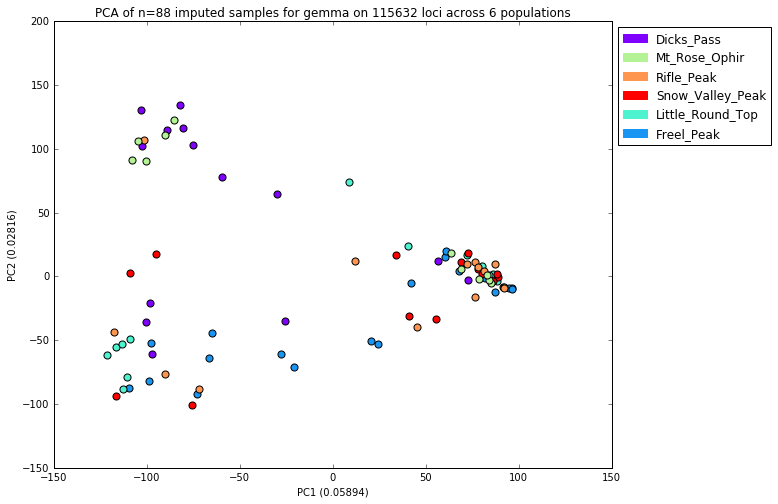

In [414]:
norm = mcolors.Normalize(min(popids.values()), max(popids.values()))
legend = {}
for row in impPCs.index:
    samp = row
    pop = stpDict[samp]
    n = norm(popids[pop])
    color = cm.rainbow(n)
    legend[pop] = color
    plt.scatter(impPCs.loc[row,'PC1'], 
                impPCs.loc[row,'PC2'], 
                s=50, 
                c=color)
fig = plt.gcf()
ax = plt.gca()
cmap = plt.get_cmap()
fig.set_size_inches(10,8)
plt.title("PCA of n=%d imputed samples for gemma on %d loci across 6 populations" % (len(impPCs), len(imp_std.columns)))
#0.05294  0.01079
#0.02051  0.01083
imp = summary(imp_res).rx("importance")[0]
plt.xlabel("PC1 (%g)" % imp.rx(2,1)[0])
plt.ylabel("PC2 (%g)" % imp.rx(2,2)[0])
handles = []
for pop in sorted(legend):
    handles.append(mpatches.Patch(color=legend[pop], label=pop))
plt.legend(handles=sorted(handles), loc=2,bbox_to_anchor=(1, 1))

plt.show()

### compare with the full imputed PCAs

In [402]:
gemma = r('readRDS')('/home/lindb/wbp/gemma/6pop_maf_z12_nofixed_std_noIDX_prcomp_res.rds')
gemmapcas = pd2ri.ri2py_dataframe(imp_res.rx2("x"))
gemmapcas.index = imp_std.index
gemmapcas.columns = imp_res.rx2("x").names.rx2(2)
gemmapcas = pd.DataFrame(gemmapcas)
gemmapcas.head()

PC1         PC2        PC3        PC4        PC5  \
010compiled -102.554518  102.219305  83.720558 -37.071304  52.506711   
011compiled  -97.414374  -60.854839  -6.546364 -20.796010  58.349705   
015compiled  -75.095144  102.786165 -81.339927  10.296074 -28.180816   
016compiled  -82.012535  134.794166  66.442810  21.232633 -33.823061   
018compiled  -80.469573  116.054241 -30.681101  18.043268 -45.595002   

                   PC6        PC7        PC8        PC9       PC10  \
010compiled  -6.315065  82.424182  66.478864 -19.208410 -22.171273   
011compiled  56.545442  90.315418  13.286594 -33.469212  52.565418   
015compiled   5.964864 -28.795428  43.299780 -15.441074 -30.042776   
016compiled -54.422823  26.455926  49.302161 -64.145468   6.649830   
018compiled  27.458998  61.997336  64.767772   1.982538  -0.438559   

                 ...           PC79      PC80      PC81      PC82      PC83  \
010compiled      ...       0.471827 -0.311766  1.131570 -0.220227  0.027128   
011compiled      ...      -0.122504  0.126337  0.269205 -0.022215 -0.071707   
015compiled      ...       0.316618 -0.879263  0.779076 -0.232847 -0.192296   
016compiled      ...       0.395163 -0.260053  0.401397 -0.203148 -0.387320   
018compiled      ...       0.401973 -0.308148 -0.343012  0.055453 -0.066646   

                 PC84      PC85      PC86      PC87          PC88  
010compiled -0.066909  0.079246 -0.014301  0.100060  2.183702e-10  
011compiled  0.006726 -0.105311  0.064290  0.085626  2.187054e-10  
015compiled  0.287561 -0.099505 -0.120518  0.096578  2.179043e-10  
016compiled -0.066729  0.293823 -0.028230 -0.237466  2.185384e-10  
018compiled  0.187510 -0.049522 -0.114166  0.099887  2.186741e-10  

[5 rows x 88 columns]

In [403]:
gemmapcas.shape

(88, 88)

In [386]:
def get_pca_x(res):
    x = pd.DataFrame(pd2ri.ri2py(res.rx2("x")))
    x.index = res.rx2("x").names[0]
    x.columns = res.rx2("x").names[1]
    return x

In [390]:
beagle = r('readRDS')('/home/lindb/wbp/workingsnps/imputed/pca_res.rds')
beaglepcas = get_pca_x(beagle)
beaglepcas = beaglepcas[beaglepcas.index.isin(gemmapcas.index)]
beaglepcas.head()

PC1         PC2         PC3         PC4         PC5  \
009compiled  -61.388551   28.149657   22.190595 -133.194194   48.989416   
010compiled  134.436939  120.047971   74.076630   27.239096   62.674998   
011compiled  133.378767  -64.459323   15.539632  -11.652990   14.884596   
012compiled  228.558021  252.049578  349.834612  -81.098185 -523.422539   
013compiled  163.075633  -70.833285  110.215646   -2.940702   45.538754   

                   PC6         PC7        PC8        PC9       PC10  \
009compiled -43.432926   -1.275564  11.544678 -37.374060  32.496316   
010compiled  30.749613  -25.391792 -16.555259 -24.196016 -79.269959   
011compiled  55.826882   36.623025  77.487397 -51.650985 -42.660001   
012compiled -68.488355   30.052452  61.889337 -50.248009   7.436572   
013compiled   3.491887 -109.321658  49.883963  53.107685 -76.225731   

                 ...          PC235     PC236     PC237     PC238     PC239  \
009compiled      ...       0.219103 -0.056206  0.005944 -0.085358  0.125850   
010compiled      ...      -0.075476 -0.165673  0.143099  0.123116 -0.030984   
011compiled      ...       0.076649  0.305732 -0.079873 -0.024622 -0.053867   
012compiled      ...       0.112173  1.222823  0.080979  0.011848 -0.028699   
013compiled      ...       0.172720  0.034191 -0.075845  0.157035 -0.134959   

                PC240     PC241     PC242     PC243         PC244  
009compiled -0.125695  0.074750 -0.189168  0.443855 -2.549343e-10  
010compiled  0.052445  0.001233  0.004421 -0.163867 -2.549509e-10  
011compiled  0.043298 -0.006808 -0.107455 -0.015652 -2.542708e-10  
012compiled  0.137371  0.114205  0.041218 -0.232853 -2.547735e-10  
013compiled  0.286004  0.085511 -0.017980 -0.088510 -2.548820e-10  

[5 rows x 244 columns]

In [404]:
beaglepcas.shape

(88, 244)

In [401]:
len(beaglepcas),len(gemmapcas)

(88, 88)

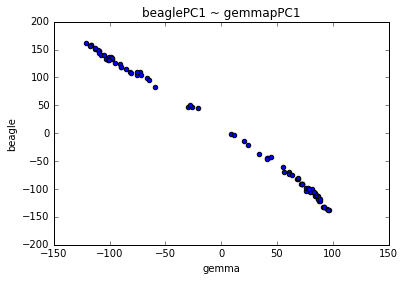

In [413]:
plt.scatter(gemmapcas['PC1'],beaglepcas['PC1'])
plt.title("beaglePC1 ~ gemmapPC1")
plt.xlabel("gemma")
plt.ylabel("beagle")

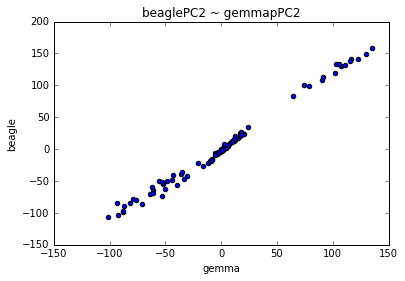

In [412]:
plt.scatter(gemmapcas['PC2'],beaglepcas['PC2'])
plt.title("beaglePC2 ~ gemmapPC2")
plt.xlabel("gemma")
plt.ylabel("beagle")

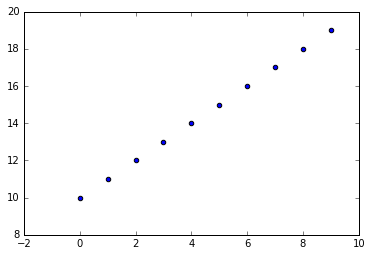

In [410]:
plt.scatter([x for x in range(0,10,1)],[y for y in range(10,20,1)])

### Step 4 - Use Tracy-Widom to get significant PCs

In [168]:
%%R
library(data.table)

In [241]:
%%R
data_imp = readRDS('/home/lindb/wbp/gemma/6pop_maf_z12_nofixed_std_noIDX_prcomp_res.rds') #bayenv

In [242]:
%%R
data_imp

Standard deviations:
 [1] 8.302875e+01 5.738894e+01 4.660695e+01 4.561547e+01 4.452100e+01
 [6] 4.367794e+01 4.367630e+01 4.342137e+01 4.335227e+01 4.326880e+01
[11] 4.317776e+01 4.300963e+01 4.293300e+01 4.289385e+01 4.280890e+01
[16] 4.277550e+01 4.273331e+01 4.263010e+01 4.258539e+01 4.257643e+01
[21] 4.248339e+01 4.239411e+01 4.234232e+01 4.227580e+01 4.218482e+01
[26] 4.213792e+01 4.204041e+01 4.200258e+01 4.189920e+01 4.186753e+01
[31] 4.167947e+01 4.162198e+01 4.151405e+01 4.136545e+01 4.105653e+01
[36] 4.070077e+01 4.016442e+01 3.986521e+01 3.937929e+01 3.869931e+01
[41] 3.797819e+01 3.730310e+01 3.561974e+01 3.468331e+01 3.453059e+01
[46] 3.415684e+01 3.402916e+01 3.395027e+01 3.370364e+01 3.311983e+01
[51] 3.298313e+01 3.247745e+01 3.196651e+01 3.189651e+01 3.159640e+01
[56] 3.133062e+01 3.098820e+01 3.088834e+01 3.016081e+01 2.988761e+01
[61] 2.974441e+01 2.964658e+01 2.930996e+01 2.928659e+01 2.900202e+01
[66] 2.896629e+01 2.869101e+01 2.855809e+01 2.838590e+01 2.789501e+01

In [243]:
filE = '/home/lindb/wbp/gemma/6pop_maf_z12_nofixed_std_noIDX_prcomp_res_PCs.txt' #bayenv
PCs = impPCs.loc[:,[col for col in impPCs.columns if 'PC' in col]]
PCs.to_csv(filE,header=True,index=True,sep="\t")

In [244]:
filE = '/home/lindb/wbp/gemma/6pop_maf_z12_nofixed_std_noIDX_prcomp_res_PCs_noIDX.txt' #bayenv
PCs.to_csv(filE,header=True,index=False,sep='\t')

In [245]:
%%R
source("/home/lindb/g/ipython/tw_calc.R")
twtable=read.table("/home/lindb/g/ipython/twTable.txt", header=F)
tw_imp = TWcalc(as.matrix(fread('/home/lindb/wbp/gemma/6pop_maf_z12_nofixed_std_noIDX_prcomp_res_PCs_noIDX.txt')),20)

In [246]:
tw_imp = r("tw_imp[[2]]")

In [247]:
def get_sig_tracywidom(tw_p):
    ps = []
    for i, p in enumerate(tw_p):
        if p > 0.05:
            print(i, p)
            break
        else:
            ps.append(p)
    return len(ps), ps

In [248]:
tw_num = get_sig_tracywidom(tw_imp)
tw_num #4 sig axes of structure

(2, 1.0)


(2, [8.0000000000000005e-09, 8.0000000000000005e-09])

### Step 5 - linear reg (get residuals): phen ~ PCs

In [249]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [250]:
impPCs.head()

bf_pop    c13_pop    ht_pop    n15_pop    rs_pop         PC1  \
010compiled  113.714414 -29.327732  4.733334  24.221204  2.791492 -102.554518   
011compiled  127.817009 -31.022282  4.549285  22.304978  2.403424  -97.414374   
015compiled  113.856717 -30.446611  5.126746  21.829093  2.405773  -75.095144   
016compiled  119.644967 -31.440705  4.717873  18.418470  2.624425  -82.012535   
018compiled  126.971708 -31.056280  4.515322  19.909427  2.758164  -80.469573   

                    PC2        PC3        PC4        PC5      ...       \
010compiled  102.219305  83.720558 -37.071304  52.506711      ...        
011compiled  -60.854839  -6.546364 -20.796010  58.349705      ...        
015compiled  102.786165 -81.339927  10.296074 -28.180816      ...        
016compiled  134.794166  66.442810  21.232633 -33.823061      ...        
018compiled  116.054241 -30.681101  18.043268 -45.595002      ...        

                 PC79      PC80      PC81      PC82      PC83      PC84  \
010compiled  0.471827 -0.311766  1.131570 -0.220227  0.027128 -0.066909   
011compiled -0.122504  0.126337  0.269205 -0.022215 -0.071707  0.006726   
015compiled  0.316618 -0.879263  0.779076 -0.232847 -0.192296  0.287561   
016compiled  0.395163 -0.260053  0.401397 -0.203148 -0.387320 -0.066729   
018compiled  0.401973 -0.308148 -0.343012  0.055453 -0.066646  0.187510   

                 PC85      PC86      PC87          PC88  
010compiled  0.079246 -0.014301  0.100060  2.183702e-10  
011compiled -0.105311  0.064290  0.085626  2.187054e-10  
015compiled -0.099505 -0.120518  0.096578  2.179043e-10  
016compiled  0.293823 -0.028230 -0.237466  2.185384e-10  
018compiled -0.049522 -0.114166  0.099887  2.186741e-10  

[5 rows x 93 columns]

In [267]:
[x for x in np.unique(impPCs).tolist() if math.isnan(x) == True]

[nan, nan, nan, nan]

In [254]:
phenos = sorted(impPCs.columns[:5])
phenos

['bf_pop', 'c13_pop', 'ht_pop', 'n15_pop', 'rs_pop']

In [255]:
impStatDict = OrderedDict()
phenCount = 0
for phen in phenos:
    data = pd.DataFrame()
    data[phen] = impPCs[phen][[i for i,x in enumerate(impPCs[phen]) if not math.isnan(x)]]
    data['PC1']  = impPCs['PC1'][[i for i,x in enumerate(impPCs[phen]) if not math.isnan(x)]]
    data['PC2']  = impPCs['PC2'][[i for i,x in enumerate(impPCs[phen]) if not math.isnan(x)]]  
    data = data.astype(float)
    formula = str("%s~PC1+PC2" % phen)
    impStatDict[phen] = smf.ols(formula, data).fit()
    phenCount+=1

In [256]:
impResidDict = OrderedDict()
for k,v in impStatDict.items():
    data = impStatDict[k]
    impResidDict[k] = data.resid

In [257]:
impResidDict

OrderedDict([('bf_pop', 010compiled    -5.961466
              011compiled     8.016984
              015compiled    -5.578503
              016compiled     0.182457
              018compiled     7.503257
              019compiled     3.758922
              020compiled    -9.981636
              023compiled     0.595833
              024compiled    -0.832300
              025compiled    -0.639761
              027compiled    -2.440222
              028compiled    -2.781871
              029compiled    -8.528985
              031compiled    -2.222652
              033compiled     7.253599
              075compiled     0.950653
              076compiled     2.047672
              078compiled     5.960340
              079compiled    -4.667224
              080compiled    -1.693404
              081compiled     6.669467
              082compiled     2.295463
              084compiled    -3.410629
              087compiled     4.376276
              088compiled     5.870508
              0

In [258]:
impResidDict[phenos[0]]

010compiled    -5.961466
011compiled     8.016984
015compiled    -5.578503
016compiled     0.182457
018compiled     7.503257
019compiled     3.758922
020compiled    -9.981636
023compiled     0.595833
024compiled    -0.832300
025compiled    -0.639761
027compiled    -2.440222
028compiled    -2.781871
029compiled    -8.528985
031compiled    -2.222652
033compiled     7.253599
075compiled     0.950653
076compiled     2.047672
078compiled     5.960340
079compiled    -4.667224
080compiled    -1.693404
081compiled     6.669467
082compiled     2.295463
084compiled    -3.410629
087compiled     4.376276
088compiled     5.870508
089compiled     6.361345
090compiled     4.791222
091compiled     0.250071
092compiled     8.174924
093compiled    -2.517583
                 ...    
169compiled     1.679506
170compiled     1.516059
172compiled   -12.097333
173compiled     1.675823
175compiled     3.946207
178compiled     1.427474
181compiled    -0.621331
182compiled    -8.834547
183compiled    -3.593216


In [259]:
p = phenos[0]
for i,x in enumerate(impResidDict[p]):
    print impResidDict[p].keys()[i]
    break

010compiled


In [260]:
x

-5.9614655459685508

In [269]:
impResidDf = pd.DataFrame()
impResidDf[0] = ["" for x in imp_std.index]
impResidDf.index = imp_std.index
leng = 0
count = 0
for p in phenos:
    for i,x in enumerate(impResidDict[p]):
        SAMP = impResidDict[p].keys()[i]
        #print i, SAMP
        if SAMP.endswith('compiled'):
            impResidDf.loc[SAMP,p] = x
    #break
impResidDf = impResidDf.loc[:,[col for col in phenos]]

In [270]:
impResidDf.head()

bf_pop   c13_pop    ht_pop   n15_pop    rs_pop
010compiled -5.961466  1.511405 -0.014499  2.785561  0.084962
011compiled  8.016984  0.037742 -0.069871  1.319704 -0.164217
015compiled -5.578503  0.384645  0.355640  0.241868 -0.303858
016compiled  0.182457 -0.651275 -0.073581 -3.224894 -0.111904
018compiled  7.503257 -0.241713 -0.262136 -1.687382  0.037705

In [271]:
[x for x in np.unique(impResidDf).tolist() if math.isnan(x) == True]

[nan, nan, nan, nan]

In [272]:
filE = '/home/lindb/wbp/gemma/6pop_maf_z12_nofixed_std_noIDX_prcomp_res_PCs_std.txt' #bayenv
impResidDf.to_csv(filE,header=True,index=True,sep="\t")

### Step 6 - normal quantile transformation

In [273]:
%R -i impResidDf

In [274]:
%%R
htpopx  = qqnorm(impResidDf$ht_pop,plot.it=F)$x
bfpopx  = qqnorm(impResidDf$bf_pop,plot.it=F)$x
rspopx  = qqnorm(impResidDf$rs_pop,plot.it=F)$x
c13popx = qqnorm(impResidDf$c13_pop,plot.it=F)$x
n15popx = qqnorm(impResidDf$n15_pop,plot.it=F)$x
#htfamx  = qqnorm(impResidDf$ht_fam,plot.it=F)$x
#bffamx  = qqnorm(impResidDf$bf_fam,plot.it=F)$x
#rsfamx  = qqnorm(impResidDf$rs_fam,plot.it=F)$x
#c13famx = qqnorm(impResidDf$c13_fam,plot.it=F)$x
#n15famx = qqnorm(impResidDf$n15_fam,plot.it=F)$x

In [275]:
impResidDf['htpopx'] = r('htpopx')
impResidDf['bfpopx'] = r('bfpopx')
impResidDf['rspopx'] = r('rspopx')
impResidDf['c13popx'] = r('c13popx')
impResidDf['n15popx'] = r('n15popx')
#impResidDf['htfamx'] = r('htfamx')
#impResidDf['bffamx'] = r('bffamx')
#impResidDf['rsfamx'] = r('rsfamx')
#impResidDf['c13famx'] = r('c13famx')
#impResidDf['n15famx'] = r('n15famx')

In [276]:
impResidDf.head()

bf_pop   c13_pop    ht_pop   n15_pop    rs_pop    htpopx  \
010compiled -5.961466  1.511405 -0.014499  2.785561  0.084962 -0.014243   
011compiled  8.016984  0.037742 -0.069871  1.319704 -0.164217 -0.128533   
015compiled -5.578503  0.384645  0.355640  0.241868 -0.303858  0.845687   
016compiled  0.182457 -0.651275 -0.073581 -3.224894 -0.111904 -0.157311   
018compiled  7.503257 -0.241713 -0.262136 -1.687382  0.037705 -0.729151   

               bfpopx    rspopx   c13popx   n15popx  
010compiled -1.230818  0.665263  2.118995  1.370745  
011compiled  1.748025 -0.593359  0.186219  0.692479  
015compiled -1.171546 -1.217197  0.930190  0.128533  
016compiled  0.028816 -0.361605 -1.178402 -1.904707  
018compiled  1.528305  0.425341 -0.394541 -0.692479

In [277]:
filE = '/home/lindb/wbp/gemma/6pop_maf_z12_nofixed_std_noIDX_prcomp_res_PCs_std_qqnorm.txt'
impResidDf.to_csv(filE,header=True,index=True,sep="\t")

### Step 7 - make phenotypic infiles

In [278]:
filE = '/home/lindb/wbp/gemma/6pop_maf_z12_nofixed_std_noIDX_prcomp_res_PCs_std_qqnorm.txt'
impResidDF = pd.read_csv(filE,header=0,index_col=0,sep="\t")
impResidDF.fillna("NA",inplace=True)
impResidDF.head()

bf_pop   c13_pop    ht_pop   n15_pop     rs_pop    htpopx  \
010compiled  -5.96147  1.511405 -0.014499  2.785561   0.084962 -0.014243   
011compiled   8.01698  0.037742 -0.069871  1.319704  -0.164217 -0.128533   
015compiled   -5.5785  0.384645  0.355640  0.241868  -0.303858  0.845687   
016compiled  0.182457 -0.651275 -0.073581 -3.224894  -0.111904 -0.157311   
018compiled   7.50326 -0.241713 -0.262136 -1.687382  0.0377052 -0.729151   

                bfpopx    rspopx   c13popx   n15popx  
010compiled   -1.23082  0.665263  2.118995  1.370745  
011compiled    1.74802 -0.593359  0.186219  0.692479  
015compiled   -1.17155   -1.2172  0.930190  0.128533  
016compiled  0.0288158 -0.361605 -1.178402 -1.904707  
018compiled    1.52831  0.425341 -0.394541 -0.692479

In [281]:
[x for x in np.unique(impResidDF).tolist() if x == 'NA']

['NA']

In [284]:
filEs = []
for col in impResidDF.columns[-5:]:
    print col
    filE = '/home/lindb/wbp/gemma/%s_infile_noHEADERIDX.txt' % col
    filEs.append(filE)
    print filE
    df = pd.DataFrame(impResidDF[col])
    df.to_csv(filE,header=False,index=False,sep="\t")
    filE2 = '/home/lindb/wbp/gemma/%s_infile.txt' % col
    df.to_csv(filE2,header=True,index=True,sep="\t")

htpopx
/home/lindb/wbp/gemma/htpopx_infile_noHEADERIDX.txt
bfpopx
/home/lindb/wbp/gemma/bfpopx_infile_noHEADERIDX.txt
rspopx
/home/lindb/wbp/gemma/rspopx_infile_noHEADERIDX.txt
c13popx
/home/lindb/wbp/gemma/c13popx_infile_noHEADERIDX.txt
n15popx
/home/lindb/wbp/gemma/n15popx_infile_noHEADERIDX.txt


In [296]:
meangene = pd.read_csv('/home/lindb/wbp/gemma/mean_genotypes.txt',header=0,sep="\t")
meangene.head()

locus mnr mjr  010compiled  011compiled  \
0   NODE_1000013_length_91_cov_1.802198_37   G   T        0.194        1.315   
1   NODE_1000031_length_98_cov_2.000000_30   C   T        1.000        0.000   
2   NODE_1000037_length_93_cov_2.043011_33   T   A        0.599        0.993   
3  NODE_1000042_length_93_cov_1.118280_100   T   G        0.000        0.015   
4   NODE_1000053_length_94_cov_1.744681_25   C   A        0.000        0.000   

   015compiled  016compiled  018compiled  019compiled  020compiled  \
0        0.037        0.208        0.046        0.084        0.443   
1        0.001        0.995        0.970        1.735        0.464   
2        0.001        0.001        0.353        0.054        0.180   
3        0.058        0.054        0.101        0.050        0.054   
4        0.000        0.000        0.000        0.000        0.016   

      ...       202compiled  203compiled  204compiled  205compiled  \
0     ...             0.401        0.443        0.019        0.719   
1     ...             0.464        0.464        0.001        0.464   
2     ...             0.010        0.002        0.103        0.108   
3     ...             0.028        0.186        0.134        0.186   
4     ...             0.016        0.023        0.000        0.023   

   206compiled  207compiled  208compiled  209compiled  210compiled  \
0        1.263        0.443        1.611        0.443        1.994   
1        0.002        0.172        0.276        0.379        1.000   
2        0.125        0.006        0.000        0.082        0.937   
3        0.086        0.186        0.007        0.186        0.044   
4        0.000        0.000        1.000        0.000        0.000   

   211compiled  
0        0.443  
1        0.464  
2        0.342  
3        0.186  
4        0.016  

[5 rows x 91 columns]

In [297]:
#make sure index is same order as columns in meangene file (index = columns = sorted sample names)
for i,samp in enumerate(df.index):
    if samp != meangene.columns[i+3]:
        print samp,meangene.columns[i+3]
        break

In [298]:
for f in filEs:
    print f

/home/lindb/wbp/gemma/htpopx_infile_noHEADERIDX.txt
/home/lindb/wbp/gemma/bfpopx_infile_noHEADERIDX.txt
/home/lindb/wbp/gemma/rspopx_infile_noHEADERIDX.txt
/home/lindb/wbp/gemma/c13popx_infile_noHEADERIDX.txt
/home/lindb/wbp/gemma/n15popx_infile_noHEADERIDX.txt


In [300]:
for f in filEs:
    print f
    bname = os.path.basename(f)
    os.symlink(f,os.path.join('/home/lindb/wbp/gemma/infiles/',bname))

/home/lindb/wbp/gemma/htpopx_infile_noHEADERIDX.txt
/home/lindb/wbp/gemma/bfpopx_infile_noHEADERIDX.txt
/home/lindb/wbp/gemma/rspopx_infile_noHEADERIDX.txt
/home/lindb/wbp/gemma/c13popx_infile_noHEADERIDX.txt
/home/lindb/wbp/gemma/n15popx_infile_noHEADERIDX.txt


In [301]:
phenos

['bf_pop', 'c13_pop', 'ht_pop', 'n15_pop', 'rs_pop']

# make SNP annotation file

In [302]:
z12.head()

NODE_1000013_length_91_cov_1.802198_37  \
010compiled                                       0   
011compiled                                       1   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000031_length_98_cov_2.000000_30  \
010compiled                                       1   
011compiled                                       0   
015compiled                                       0   
016compiled                                       1   
018compiled                                       1   

             NODE_1000037_length_93_cov_2.043011_33  \
010compiled                                       1   
011compiled                                       1   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000042_length_93_cov_1.118280_100  \
010compiled                                        0   
011compiled                                        0   
015compiled                                        0   
016compiled                                        0   
018compiled                                        0   

             NODE_1000053_length_94_cov_1.744681_25  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000061_length_47_cov_1.680851_49  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000118_length_95_cov_2.000000_24  \
010compiled                                       0   
011compiled                                       1   
015compiled                                       1   
016compiled                                       1   
018compiled                                       1   

             NODE_1000128_length_98_cov_1.714286_53  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000180_length_98_cov_2.204082_17  \
010compiled                                       0   
011compiled                                       1   
015compiled                                       1   
016compiled                                       1   
018compiled                                       1   

             NODE_1000188_length_67_cov_1.223881_65  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

                             ...                    \
010compiled                  ...                     
011compiled                  ...                     
015compiled                  ...                     
016compiled                  ...                     
018compiled                  ...                     

             NODE_999880_length_98_cov_1.683674_22  \
010compiled                                      0   
011compiled                                      0   
015compiled                                      0   
016compiled                                      1   
018compiled                                      0   

             NODE_999886_length_96_cov_1.020833

In [303]:
z12.shape

(88, 115632)

In [331]:
filE = '/home/lindb/wbp/gemma/snp_annotation.txt'
with open(filE,'w') as o:
    for i,locus in enumerate(z12.columns):
        #print locus
        contig = '_'.join([x for x in locus.split("_")[:-1]])
        pos = locus.split('_')[-1]
        #print contig
        #print pos
        text = '\t'.join([contig,str(pos),str(i+1)])+'\n'
        o.write("%s" % text)

In [332]:
snp_ano = pd.read_csv(filE,header=None,sep='\t')
snp_ano.head()

0    1  2
0  NODE_1000013_length_91_cov_1.802198   37  1
1  NODE_1000031_length_98_cov_2.000000   30  2
2  NODE_1000037_length_93_cov_2.043011   33  3
3  NODE_1000042_length_93_cov_1.118280  100  4
4  NODE_1000053_length_94_cov_1.744681   25  5

In [333]:
snp_ano.shape

(115632, 3)

In [307]:
if os.path.exists('/home/lindb/wbp/gemma/infiles/snp_annotation.txt'):
    os.remove('/home/lindb/wbp/gemma/infiles/snp_annotation.txt')
os.symlink('/home/lindb/wbp/gemma/snp_annotation.txt','/home/lindb/wbp/gemma/infiles/snp_annotation.txt')

# make all_pheno file

In [308]:
files = os.listdir('/home/lindb/wbp/gemma/')
files = [os.path.join('/home/lindb/wbp/gemma/',f) for f in files if 'infile_noHEADERIDX' in f]
len(files)

5

In [314]:
DF = impResidDF[sorted(impResidDF.columns[-5:])]
DF

bfpopx   c13popx    htpopx   n15popx     rspopx
010compiled   -1.23082  2.118995 -0.014243  1.370745   0.665263
011compiled    1.74802  0.186219 -0.128533  0.692479  -0.593359
015compiled   -1.17155  0.930190  0.845687  0.128533    -1.2172
016compiled  0.0288158 -1.178402 -0.157311 -1.904707  -0.361605
018compiled    1.52831 -0.394541 -0.729151 -0.692479   0.425341
019compiled   0.511222  2.531313  0.425524  0.729151  -0.820792
020compiled   -1.89971 -0.363932 -0.488776 -1.021921  -0.393273
023compiled   0.144561  0.042740  0.099861  1.123174   0.361605
024compiled -0.0865434  0.071271 -1.071175  0.273992   0.268603
025compiled -0.0576556  0.587574 -0.333660  0.766831  -0.457852
027compiled  -0.414974 -0.887147 -0.766831  1.534121  -0.951843
028compiled  -0.511222 -0.014243 -1.370745  0.099861  -0.425341
029compiled   -1.36449 -1.123174  0.186219 -0.975030  -0.740785
031compiled  -0.322431 -0.521135  1.237480  0.425524    2.51912
033compiled    1.44156  0.887147 -0.554049  0.215285  -0.268603
075compiled   0.173741 -1.021921  0.157311 -2.531313   0.820792
076compiled   0.383769 -0.930190  1.370745 -0.099861   0.029494
078compiled     1.0145 -0.128533  2.531313  0.071271   0.177872
079compiled  -0.967422  0.363932 -1.178402 -0.805633   -1.10171
080compiled   -0.20307  0.425524  0.273992  1.237480  -0.490854
081compiled    1.23082  1.237480  0.887147  0.521135   -1.15752
082compiled   0.446588 -0.488776 -1.904707  2.118995          0
084compiled   -0.68356  1.123174  1.633934  1.904707   -0.23815
087compiled    0.68356  0.099861 -0.456922 -0.333660     1.3517
088compiled   0.922396 -0.186219 -1.123174  0.930190    1.15752
089compiled    1.11613 -1.904707 -0.521135 -1.071175 -0.0590137
090compiled   0.758293  0.456922 -0.042740 -0.363932   -1.51643
091compiled  0.0576556 -2.531313 -0.071271 -0.244533   0.393273
092compiled    1.89971  1.021921  1.753330 -1.237480   0.906435
093compiled  -0.446588 -0.042740  0.363932 -1.178402    1.51643
...                ...       ...       ...       ...        ...
169compiled   0.322431  0.766831 -0.303691  0.186219    1.73719
170compiled   0.262283  1.904707  1.178402  1.178402   0.299307
172compiled    -2.5273 -0.805633  0.215285 -0.766831    1.10171
173compiled   0.292225  0.521135  1.021921 -0.887147    1.88951
175compiled   0.578068 -1.370745  0.587574  1.301224   0.490854
178compiled    0.20307  1.753330  0.128533 -0.071271         NA
181compiled -0.0288158  0.656716 -1.633934  1.753330  -0.207917
182compiled   -1.44156 -0.157311 -1.301224 -0.488776  -0.780164
183compiled  -0.758293 -0.621773  0.621773 -0.729151         NA
184compiled  -0.383769  0.488776 -0.273992  0.394541  -0.702523
185compiled    -1.0145 -0.215285 -2.531313 -0.425524   0.628904
187compiled  -0.647604  0.692479 -1.447606 -0.128533   -1.04913
188compiled  -0.352934 -0.273992 -0.244533 -0.273992   0.558547
191compiled  0.0865434  0.621773  0.766831  2.531313  -0.088585
192compiled    1.29476  1.447606  0.692479  0.621773    1.28155
194compiled  -0.612465 -1.534121 -0.930190  0.157311    1.61698
195compiled  -0.544341 -0.099861  0.488776 -0.042740  -0.999305
198compiled  -0.292225  0.805633 -0.845687  0.014243   0.780164
199compiled  -0.115504  1.370745  1.123174  0.587574    1.42922
200compiled  -0.173741 -0.766831  0.456922 -0.930190   0.524401
202compiled  -0.144561  0.128533  0.244533  0.554049   0.207917
203compiled   0.352934  1.071175  0.394541  1.071175   0.702523
204compiled   0.478655 -0.845687 -1.753330  0.456922   -1.61698
205compiled   -1.29476 -0.425524  0.729151 -1.753330  -0.147987
206compiled   -1.52831  0.303691 -0.621773 -0.394541  -0.665263
207compiled   -1.11613  1.633934  1.904707  0.488776  -0.177872
208compiled   0.647604  0.273992 -0.363932  0.042740   -2.10497
209compiled  -0.578068 -0.071271 -0.215285  0.845687  -0.628904
210compiled   0.232574 -1.447606  1.447606 -0.303691   -2.51912
211compiled    1.62836 -0.244533 -0.975030 -1.447606   0.593359

[88 rows x 5 columns]

In [315]:
DF.shape

(88, 5)

In [319]:
filE = '/home/lindb/wbp/gemma/all_pheno.txt'
DF.to_csv(filE,header=True,index=True,sep='\t')
filE = '/home/lindb/wbp/gemma/all_pheno_noHEADERIDX.txt'
DF.to_csv(filE,header=False,index=False,sep='\t')

In [317]:
if os.path.exists('/home/lindb/wbp/gemma/infiles/all_pheno_noHEADERIDX.txt'):
    os.remove('/home/lindb/wbp/gemma/infiles/all_pheno_noHEADERIDX.txt')
os.symlink('/home/lindb/wbp/gemma/all_pheno_noHEADERIDX.txt', '/home/lindb/wbp/gemma/infiles/all_pheno_noHEADERIDX.txt')

In [321]:
allpheno = pd.read_csv('/home/lindb/wbp/gemma/all_pheno.txt',header=0,index_col=0,sep="\t")
allpheno.head()

bfpopx   c13popx    htpopx   n15popx    rspopx
010compiled -1.230818  2.118995 -0.014243  1.370745  0.665263
011compiled  1.748025  0.186219 -0.128533  0.692479 -0.593359
015compiled -1.171546  0.930190  0.845687  0.128533 -1.217197
016compiled  0.028816 -1.178402 -0.157311 -1.904707 -0.361605
018compiled  1.528305 -0.394541 -0.729151 -0.692479  0.425341

In [322]:
a2 = pd.read_csv('/home/lindb/wbp/gemma/infiles/all_pheno_noHEADERIDX.txt',header=None,sep="\t")
a2.head()

0         1         2         3         4
0 -1.230818  2.118995 -0.014243  1.370745  0.665263
1  1.748025  0.186219 -0.128533  0.692479 -0.593359
2 -1.171546  0.930190  0.845687  0.128533 -1.217197
3  0.028816 -1.178402 -0.157311 -1.904707 -0.361605
4  1.528305 -0.394541 -0.729151 -0.692479  0.425341

# confirming infile requirements, updating if necessary

In [338]:
locfile = pd.read_csv('/home/lindb/wbp/gemma/infiles/snp_annotation.txt',header=None,sep='\t')
locfile.head()

0    1  2
0  NODE_1000013_length_91_cov_1.802198   37  1
1  NODE_1000031_length_98_cov_2.000000   30  2
2  NODE_1000037_length_93_cov_2.043011   33  3
3  NODE_1000042_length_93_cov_1.118280  100  4
4  NODE_1000053_length_94_cov_1.744681   25  5

In [339]:
locfile.shape

(115632, 3)

In [355]:
#get a list of SNPs
locs = ['_'.join([locfile.loc[row,0],str(locfile.loc[row,1])]) for row in locfile.index]
len(locs)

115632

In [370]:
#load meangenotype file created above, edit to only include SNPs that are not fixed across the 6 pops
meangeno = pd.read_csv('/home/lindb/wbp/gemma/mean_genotypes.txt',header=0,sep='\t')
meangeno = meangeno.loc[meangeno['locus'].isin(locs)]
meangeno.head()

locus mnr mjr  010compiled  011compiled  \
0   NODE_1000013_length_91_cov_1.802198_37   G   T        0.194        1.315   
1   NODE_1000031_length_98_cov_2.000000_30   C   T        1.000        0.000   
2   NODE_1000037_length_93_cov_2.043011_33   T   A        0.599        0.993   
3  NODE_1000042_length_93_cov_1.118280_100   T   G        0.000        0.015   
4   NODE_1000053_length_94_cov_1.744681_25   C   A        0.000        0.000   

   015compiled  016compiled  018compiled  019compiled  020compiled  \
0        0.037        0.208        0.046        0.084        0.443   
1        0.001        0.995        0.970        1.735        0.464   
2        0.001        0.001        0.353        0.054        0.180   
3        0.058        0.054        0.101        0.050        0.054   
4        0.000        0.000        0.000        0.000        0.016   

      ...       202compiled  203compiled  204compiled  205compiled  \
0     ...             0.401        0.443        0.019        0.719   
1     ...             0.464        0.464        0.001        0.464   
2     ...             0.010        0.002        0.103        0.108   
3     ...             0.028        0.186        0.134        0.186   
4     ...             0.016        0.023        0.000        0.023   

   206compiled  207compiled  208compiled  209compiled  210compiled  \
0        1.263        0.443        1.611        0.443        1.994   
1        0.002        0.172        0.276        0.379        1.000   
2        0.125        0.006        0.000        0.082        0.937   
3        0.086        0.186        0.007        0.186        0.044   
4        0.000        0.000        1.000        0.000        0.000   

   211compiled  
0        0.443  
1        0.464  
2        0.342  
3        0.186  
4        0.016  

[5 rows x 91 columns]

In [371]:
meangeno.shape #88 + 3 = 91

(115632, 91)

In [372]:
filE = '/home/lindb/wbp/gemma/mean_genotypes.txt'
meangeno.to_csv(filE,header=True,index=True,sep='\t')
filE = '/home/lindb/wbp/gemma/mean_genotypes_noHEADERIDX.txt'
meangeno.to_csv(filE,header=False,index=False,sep='\t')

In [373]:
z12.head()

NODE_1000013_length_91_cov_1.802198_37  \
010compiled                                       0   
011compiled                                       1   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000031_length_98_cov_2.000000_30  \
010compiled                                       1   
011compiled                                       0   
015compiled                                       0   
016compiled                                       1   
018compiled                                       1   

             NODE_1000037_length_93_cov_2.043011_33  \
010compiled                                       1   
011compiled                                       1   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000042_length_93_cov_1.118280_100  \
010compiled                                        0   
011compiled                                        0   
015compiled                                        0   
016compiled                                        0   
018compiled                                        0   

             NODE_1000053_length_94_cov_1.744681_25  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000061_length_47_cov_1.680851_49  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000118_length_95_cov_2.000000_24  \
010compiled                                       0   
011compiled                                       1   
015compiled                                       1   
016compiled                                       1   
018compiled                                       1   

             NODE_1000128_length_98_cov_1.714286_53  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000180_length_98_cov_2.204082_17  \
010compiled                                       0   
011compiled                                       1   
015compiled                                       1   
016compiled                                       1   
018compiled                                       1   

             NODE_1000188_length_67_cov_1.223881_65  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

                             ...                    \
010compiled                  ...                     
011compiled                  ...                     
015compiled                  ...                     
016compiled                  ...                     
018compiled                  ...                     

             NODE_999880_length_98_cov_1.683674_22  \
010compiled                                      0   
011compiled                                      0   
015compiled                                      0   
016compiled                                      1   
018compiled                                      0   

             NODE_999886_length_96_cov_1.020833

In [374]:
z12.shape

(88, 115632)

In [375]:
#how many fixed SNPs - because we called snps with 8 populations, not 6
fixed = 0
for col in z12.columns:
    if len(np.unique(z12[col]).tolist()) == 1:
        fixed += 1
fixed

0

In [317]:
#how many samples do I expect?
for col in ex.columns:
    l = len(ex[ex[col] > -10000000]) #another way to filer NA, np.nan, or NaN
    print col,l
#I should use ht,c13, or n15 for matrix estimation because they have all of the individuals

ht_pop 88
bf_pop 87
rs_pop 85
c13_pop 88
n15_pop 88


# GEMMA commands
## Estimate relatedness matrix

./gemma -g [filename] -p [filename] -gk [num] -o [prefix]

    cd /home/lindb/wbp/gemma/infiles/
    /home/lindb/g/src/gemma-0.94/bin/gemma -g mean_genotypes_noHEADERIDX.txt -p n15popx_infile_noHEADERIDX.txt \
    -gk 1 -o relatednessmatrix

## Eigen decomposition of relatedness matrix

./gemma -g [filename] -p [filename] -k [filename] -eigen -o [prefix]

    cd /home/lindb/wbp/gemma/infiles/
    /home/lindb/g/src/gemma-0.94/bin/gemma -g mean_genotypes_noHEADERIDX.txt -p n15popx_infile_noHEADERIDX.txt \
    -k ./output/relatednessmatrix.cXX.txt -eigen -o decomposition

## Association Tests with Univariate Linear Mixed Models


./gemma -g [filename] -p [filename] -a [filename] -k [filename] -lmm [num] -o [prefix]

    cd /home/lindb/wbp/gemma/infiles/
    /home/lindb/g/src/gemma-0.94/bin/gemma -g mean_genotypes_noHEADERIDX.txt -p bfpopx_infile_noHEADERIDX.txt
    -a snp_annotation.txt -k ./output/relatednessmatrix.cXX.txt -lmm 4 -o bfpopx_lmm

    /home/lindb/g/src/gemma-0.94/bin/gemma -g mean_genotypes_noHEADERIDX.txt -p c13popx_infile_noHEADERIDX.txt
    -a snp_annotation.txt -k ./output/relatednessmatrix.cXX.txt -lmm 4 -o c13popx_lmm

    /home/lindb/g/src/gemma-0.94/bin/gemma -g mean_genotypes_noHEADERIDX.txt -p htpopx_infile_noHEADERIDX.txt
    -a snp_annotation.txt -k ./output/relatednessmatrix.cXX.txt -lmm 4 -o htpopx_lmm

    /home/lindb/g/src/gemma-0.94/bin/gemma -g mean_genotypes_noHEADERIDX.txt -p n15popx_infile_noHEADERIDX.txt
    -a snp_annotation.txt -k ./output/relatednessmatrix.cXX.txt -lmm 4 -o n15popx_lmm

    /home/lindb/g/src/gemma-0.94/bin/gemma -g mean_genotypes_noHEADERIDX.txt -p rspopx_infile_noHEADERIDX.txt
    -a snp_annotation.txt -k ./output/relatednessmatrix.cXX.txt -lmm 4 -o rspopx_lmm


## Association Tests with Multivariate Linear Mixed Models


./gemma -g [filename] -p [filename] -a [filename] -k [filename] -lmm [num] -n [num1] [num2] [num3] -o [prefix]

    cd /home/lindb/wbp/gemma/infiles/
    ###### bfpopx vs rest
    /home/lindb/g/src/gemma-0.94/bin/gemma -g mean_genotypes_noHEADERIDX.txt -p all_pheno_noHEADERIDX.txt \
    -a snp_annotation.txt -k ./output/relatednessmatrix.cXX.txt -lmm 4 -n 1 2 -o bfpopx_c13popx

    /home/lindb/g/src/gemma-0.94/bin/gemma -g mean_genotypes_noHEADERIDX.txt -p all_pheno_noHEADERIDX.txt \
    -a snp_annotation.txt -k ./output/relatednessmatrix.cXX.txt -lmm 4 -n 1 3 -o bfpopx_htpopx

    /home/lindb/g/src/gemma-0.94/bin/gemma -g mean_genotypes_noHEADERIDX.txt -p all_pheno_noHEADERIDX.txt \
    -a snp_annotation.txt -k ./output/relatednessmatrix.cXX.txt -lmm 4 -n 1 4 -o bfpopx_n15popx    

    /home/lindb/g/src/gemma-0.94/bin/gemma -g mean_genotypes_noHEADERIDX.txt -p all_pheno_noHEADERIDX.txt \
    -a snp_annotation.txt -k ./output/relatednessmatrix.cXX.txt -lmm 4 -n 1 5 -o bfpopx_rspopx

    ###### c13popx vs rest
    /home/lindb/g/src/gemma-0.94/bin/gemma -g mean_genotypes_noHEADERIDX.txt -p all_pheno_noHEADERIDX.txt \
    -a snp_annotation.txt -k ./output/relatednessmatrix.cXX.txt -lmm 4 -n 2 3 -o c13popx_htpopx

    /home/lindb/g/src/gemma-0.94/bin/gemma -g mean_genotypes_noHEADERIDX.txt -p all_pheno_noHEADERIDX.txt \
    -a snp_annotation.txt -k ./output/relatednessmatrix.cXX.txt -lmm 4 -n 2 4 -o c13popx_n15popx    

    /home/lindb/g/src/gemma-0.94/bin/gemma -g mean_genotypes_noHEADERIDX.txt -p all_pheno_noHEADERIDX.txt \
    -a snp_annotation.txt -k ./output/relatednessmatrix.cXX.txt -lmm 4 -n 2 5 -o c13popx_rspopx

    ###### htpopx vs rest
    /home/lindb/g/src/gemma-0.94/bin/gemma -g mean_genotypes_noHEADERIDX.txt -p all_pheno_noHEADERIDX.txt \
    -a snp_annotation.txt -k ./output/relatednessmatrix.cXX.txt -lmm 4 -n 3 4 -o htpopx_n15popx

    /home/lindb/g/src/gemma-0.94/bin/gemma -g mean_genotypes_noHEADERIDX.txt -p all_pheno_noHEADERIDX.txt \
    -a snp_annotation.txt -k ./output/relatednessmatrix.cXX.txt -lmm 4 -n 3 5 -o htpopx_rspopx    

    ###### n15popx vs rest
    /home/lindb/g/src/gemma-0.94/bin/gemma -g mean_genotypes_noHEADERIDX.txt -p all_pheno_noHEADERIDX.txt \
    -a snp_annotation.txt -k ./output/relatednessmatrix.cXX.txt -lmm 4 -n 4 5 -o n15popx_rspopx


## Fit a Bayesian sparse linear mixed model

    ./gemma -g [filename] -p [filename] -a [filename] -k [filename] -bslmm [num] -o [prefix]

In [40]:
def make_qsub(tokens):
    filename, pheno, out, name = tokens
    num = filename.split(".")[0][-1:]
    text = '''#!/bin/bash
#$ -N BSLMM%s
#$ -V
#$ -cwd
#$ -j y
#$ -l mem_free=20G

/home/lindb/g/src/gemma-0.94/bin/gemma \
-g /home/lindb/wbp/gemma/infiles/mean_genotypes_noHEADERIDX.txt \
-p %s \
-a /home/lindb/wbp/gemma/infiles/snp_annotation.txt \
-k /home/lindb/wbp/gemma/infiles/output/relatednessmatrix.cXX.txt \
-bslmm 1 \
-o %s \
-w 1000000 \
-s 100000000 \
-smin 1 \
-smax 300 \
-hmin 0.01 \
-hmax 0.9 \
-pmin -3 \
-pmax 0 \
-rpace 1000
''' % ("%s%s" % (name[:3],num),
       pheno,
       out)
    with open(filename,'w') as o:
        o.write("%s" % text)
    return filename

In [8]:
phenos = [col for col in impResidDF.columns if 'x' in col]
phenos

['htpopx', 'bfpopx', 'rspopx', 'c13popx', 'n15popx']

In [43]:
for i in range(5):
    j = i+1
    for pheno in phenos:
        fname = '/home/lindb/wbp/gemma/infiles/bslmm/%s_bslmm_%s.sh'  % (pheno,j)
        out =   '%s_bslmm_%s_out' % (pheno,j)
        p =     '/home/lindb/wbp/gemma/infiles/%s_infile_noHEADERIDX.txt' % pheno
        name =  op.basename(p).split("_")[0]
        tokens = [fname,p,out,name]
        make_qsub(tokens)

In [36]:
fname

'/home/lindb/wbp/gemma/infiles/bslmm2/n15popx_bslmm_5.sh'

In [47]:
def make_qsub_10mil(tokens):
    filename, pheno, out, name = tokens
    num = filename.split(".")[0][-1:]
    text = '''#!/bin/bash
#$ -N BSLMM%s
#$ -V
#$ -cwd
#$ -j y
#$ -l mem_free=20G

/home/lindb/g/src/gemma-0.94/bin/gemma \
-g /home/lindb/wbp/gemma/infiles/mean_genotypes_noHEADERIDX.txt \
-p %s \
-a /home/lindb/wbp/gemma/infiles/snp_annotation.txt \
-k /home/lindb/wbp/gemma/infiles/output/relatednessmatrix.cXX.txt \
-bslmm 1 \
-o %s \
-w 1000000 \
-s 10000000 \
-smin 1 \
-smax 300 \
-hmin 0.01 \
-hmax 0.9 \
-pmin -3 \
-pmax 0 \
-rpace 1000
''' % ("%s%s" % (name[:3],num),
       pheno,
       out)
    with open(filename,'w') as o:
        o.write("%s" % text)
    return filename

In [45]:
def make_qsub_20mil(tokens):
    filename, pheno, out, name = tokens
    num = filename.split(".")[0][-1:]
    text = '''#!/bin/bash
#$ -N BSLMM%s
#$ -V
#$ -cwd
#$ -j y
#$ -l mem_free=20G

/home/lindb/g/src/gemma-0.94/bin/gemma \
-g /home/lindb/wbp/gemma/infiles/mean_genotypes_noHEADERIDX.txt \
-p %s \
-a /home/lindb/wbp/gemma/infiles/snp_annotation.txt \
-k /home/lindb/wbp/gemma/infiles/output/relatednessmatrix.cXX.txt \
-bslmm 1 \
-o %s \
-w 1000000 \
-s 20000000 \
-smin 1 \
-smax 300 \
-hmin 0.01 \
-hmax 0.9 \
-pmin -3 \
-pmax 0 \
-rpace 1000
''' % ("%s%s" % (name[:3],num),
       pheno,
       out)
    with open(filename,'w') as o:
        o.write("%s" % text)
    return filename

In [46]:
def make_qsub_50mil(tokens):
    filename, pheno, out, name = tokens
    num = filename.split(".")[0][-1:]
    text = '''#!/bin/bash
#$ -N BSLMM%s
#$ -V
#$ -cwd
#$ -j y
#$ -l mem_free=20G

/home/lindb/g/src/gemma-0.94/bin/gemma \
-g /home/lindb/wbp/gemma/infiles/mean_genotypes_noHEADERIDX.txt \
-p %s \
-a /home/lindb/wbp/gemma/infiles/snp_annotation.txt \
-k /home/lindb/wbp/gemma/infiles/output/relatednessmatrix.cXX.txt \
-bslmm 1 \
-o %s \
-w 1000000 \
-s 50000000 \
-smin 1 \
-smax 300 \
-hmin 0.01 \
-hmax 0.9 \
-pmin -3 \
-pmax 0 \
-rpace 1000
''' % ("%s%s" % (name[:3],num),
       pheno,
       out)
    with open(filename,'w') as o:
        o.write("%s" % text)
    return filename

In [49]:
for i in range(4):
    j = i+1
    for pheno in phenos:
        fname = '/home/lindb/wbp/gemma/infiles/bslmm/%s_bslmm_%s_10mil.sh'  % (pheno,j)
        out =   '%s_bslmm_%s_out_10mil' % (pheno,j)
        p =     '/home/lindb/wbp/gemma/infiles/%s_infile_noHEADERIDX.txt' % pheno
        name =  op.basename(p).split("_")[0]
        tokens = [fname,p,out,name]
        make_qsub_10mil(tokens)

In [50]:
for i in range(4):
    j = i+1
    for pheno in phenos:
        fname = '/home/lindb/wbp/gemma/infiles/bslmm/%s_bslmm_%s_20mil.sh'  % (pheno,j)
        out =   '%s_bslmm_%s_out_20mil' % (pheno,j)
        p =     '/home/lindb/wbp/gemma/infiles/%s_infile_noHEADERIDX.txt' % pheno
        name =  op.basename(p).split("_")[0]
        tokens = [fname,p,out,name]
        make_qsub_20mil(tokens)


In [51]:
for i in range(4):
    j = i+1
    for pheno in phenos:
        fname = '/home/lindb/wbp/gemma/infiles/bslmm/%s_bslmm_%s_50mil.sh'  % (pheno,j)
        out =   '%s_bslmm_%s_out_50mil' % (pheno,j)
        p =     '/home/lindb/wbp/gemma/infiles/%s_infile_noHEADERIDX.txt' % pheno
        name =  op.basename(p).split("_")[0]
        tokens = [fname,p,out,name]
        make_qsub_50mil(tokens)

# analyze output

 ### univariate association

In [164]:
DIR = '/home/lindb/wbp/gemma/infiles/output/'
files = [op.join(DIR,f) for f in ls(DIR) if 'lmm.assoc' in f]
len(files)

5

In [166]:
files

['/home/lindb/wbp/gemma/infiles/output/bfpopx_lmm.assoc.txt',
 '/home/lindb/wbp/gemma/infiles/output/c13popx_lmm.assoc.txt',
 '/home/lindb/wbp/gemma/infiles/output/htpopx_lmm.assoc.txt',
 '/home/lindb/wbp/gemma/infiles/output/n15popx_lmm.assoc.txt',
 '/home/lindb/wbp/gemma/infiles/output/rspopx_lmm.assoc.txt']

In [165]:
lmm = {}
for f in files:
    pheno = op.basename(f).split("_")[0]
    df = pd.read_csv(f,header=0,sep='\t')
    lmm[pheno] = df

In [1740]:
lmm[pheno].head()

chr                                       rs  ps  n_miss allele1 allele0  \
0   -9   NODE_1000013_length_91_cov_1.802198_37  -9       0       G       T   
1   -9   NODE_1000031_length_98_cov_2.000000_30  -9       0       C       T   
2   -9   NODE_1000037_length_93_cov_2.043011_33  -9       0       T       A   
3   -9  NODE_1000042_length_93_cov_1.118280_100  -9       0       T       G   
4   -9   NODE_1000053_length_94_cov_1.744681_25  -9       0       C       A   

      af      beta        se   l_remle     l_mle    p_wald     p_lrt   p_score  
0  0.269 -0.300552  0.216442  4.170135  4.882043  0.168668  0.174074  0.185119  
1  0.248  0.131671  0.288701  5.314719  6.225713  0.649522  0.641652  0.643183  
2  0.129  0.097566  0.310709  5.144002  6.151151  0.754301  0.750867  0.751736  
3  0.086 -0.119950  0.500141  5.326017  6.359387  0.811051  0.793131  0.795354  
4  0.035  0.108368  0.493028  5.244610  6.276595  0.826565  0.813066  0.814297

In [1757]:
for pheno in lmm:
    p = 0.05/len(lmm[pheno].index)
    sigs = lmm[pheno][lmm[pheno]['p_wald'] <= p]
    snps = sigs['rs'].tolist()
    print pheno,p,len(snps),min(lmm[pheno]['p_wald']),min(lmm[pheno]['p_wald'])/p

rspopx 4.32578339937e-07 0 1.707738e-05 39.4781208936
bfpopx 4.3253717657e-07 0 2.617198e-05 60.5080474412
c13popx 4.32518468539e-07 0 1.772365e-06 4.0977787746
n15popx 4.32518468539e-07 0 3.96635e-05 91.70359854
htpopx 4.32518468539e-07 0 5.294266e-06 12.2405547626


In [1743]:
DIR = '/home/lindb/wbp/gemma/infiles/output/'
files = [op.join(DIR,f) for f in ls(DIR) if 'lmm.log' in f]
len(files)

5

In [1755]:
log = {}
for f in files:
    pheno = op.basename(f).split("_")[0]
    df = open(f,'r')
    g = df.readlines()
    for line in g:
        if '## pve' in line:
            pve = line.split("=")[1].strip()
        if '## se(pve)' in line:
            se = line.split("=")[1].strip()
            log[pheno] = (pve,se)
            break
    print pheno,log[pheno]

bfpopx ('1.07494e-06', '-nan')
c13popx ('1.08106e-06', '0.406596')
htpopx ('1.08106e-06', '0.721715')
n15popx ('1.08106e-06', '-nan')
rspopx ('0.352638', '0.252905')


In [1748]:
line

'## pve estimate in the null model = 1.07494e-06\n'

In [1751]:
line.split("=")[1].strip()

'1.07494e-06'

In [1855]:
p = 0.05/116231
log10p = -1*math.log(p,10)
lnp = -1*math.log(p)
log10p,lnp

(6.366351969960995, 14.659067142785466)

rspopx


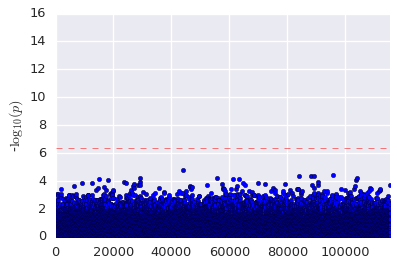

bfpopx


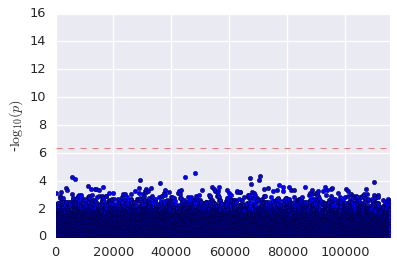

c13popx


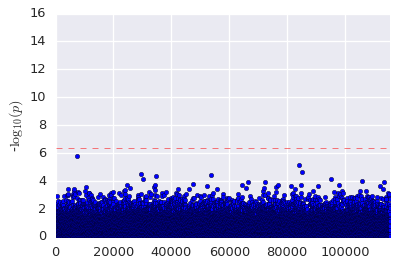

n15popx


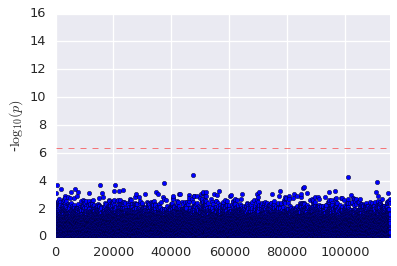

htpopx


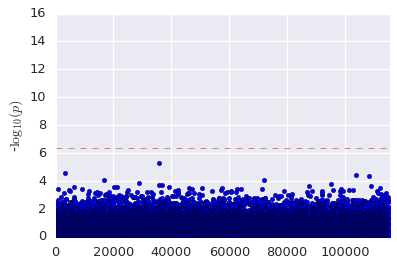

In [1856]:
for pheno in lmm:
    print pheno
    filE = '/home/lindb/wbp/figures/%s_lmm_manhattan_log10.pdf' % pheno
    with PdfPages(filE) as pdf:
        fig = plt.figure()
        plt.scatter(range(len(lmm[pheno].index)),[-1*math.log(x,10) for x in lmm[pheno]['p_wald'].tolist()])
        plt.xlim(0,len(lmm[pheno].index))
        plt.ylim(0,16)
        plt.axhline(y=log10p,c="red",linewidth=0.5,zorder=1,ls='dashed')
        plt.ylabel(r'-$\log_{10}(p)$',fontsize=14)
        plt.show()

In [163]:
lmm[pheno]['p_wald'][0]

NameError: name 'lmm' is not defined

rspopx


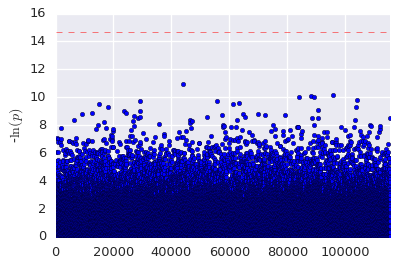

bfpopx


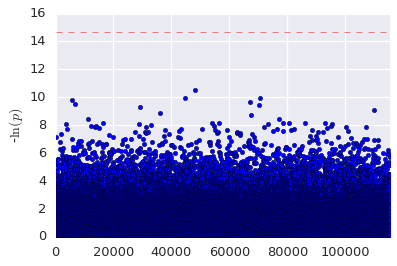

c13popx


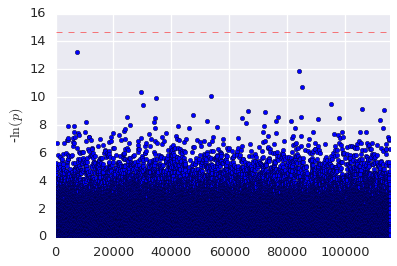

n15popx


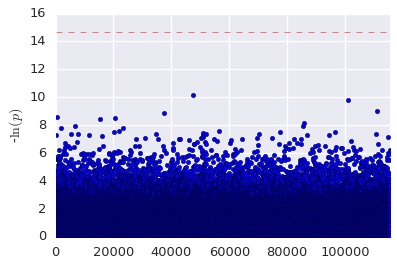

htpopx


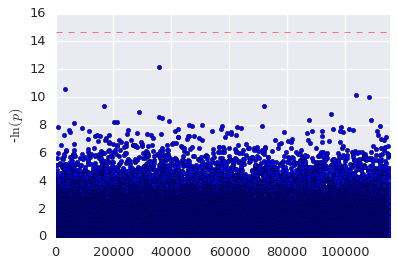

In [1857]:
for pheno in lmm:
    print pheno
    filE = '/home/lindb/wbp/figures/%s_lmm_manhattan_ln.pdf' % pheno
    with PdfPages(filE) as pdf:
        fig = plt.figure()
        plt.scatter(range(len(lmm[pheno].index)),[-1*math.log(x) for x in lmm[pheno]['p_wald'].tolist()])
        plt.xlim(0,len(lmm[pheno].index))
        plt.ylim(0,16)
        plt.axhline(y=lnp,c="red",linewidth=0.5,zorder=1,ls='dashed')
        plt.ylabel(r'-$\ln(p)$',fontsize=14)
        plt.show()

In [1862]:
#get the loci that kind of stand out (lnloci)
lmmloci = {}
outloci = {}
lnloci = {}
for pheno in lmm:
    print pheno
    lmmloci = {}
    lmmloci[pheno] = {}
    lmmloci[pheno]['log10'] = {}
    lmmloci[pheno]['ln'] = {}
    lnloci[pheno] = []
    for i,snp in enumerate(lmm[pheno]['rs'].tolist()):
        x = lmm[pheno].loc[i,'p_wald']
        if -1*math.log(x) >=10:
            lmmloci[pheno]['log10'][snp] = -1*math.log(x,10)
            lmmloci[pheno]['ln'][snp] = -1*math.log(x)
            lnloci[pheno].append(snp)

rspopx
bfpopx
c13popx
n15popx
htpopx


In [1919]:
for pheno in sorted(lnloci):
    print pheno,len(lnloci[pheno])

 bfpopx 1
c13popx 5
htpopx 4
n15popx 1
rspopx 4


In [2003]:
outloci = []
for pheno in sorted(lnloci):
    for snp in lnloci[pheno]:
        outloci.append(snp)
len(outloci)

15

In [1864]:
for pheno in lnloci:
    filE  = '/home/lindb/wbp/gemma/lnloci_%s.txt' % pheno
    df = pd.DataFrame(lnloci[pheno])
    df.to_csv(filE,header=False,index=False,sep='\t')

In [1865]:
for pheno in toppips:
    print pheno,len(toppips[pheno])

rspopx 117
bfpopx 118
c13popx 122
n15popx 117
htpopx 117


In [1905]:
snplst = []

In [1906]:
#intersection with top 0.999 PIPs
for i,phenoi in enumerate(toppips):
    for j,phenoj in enumerate(lnloci):
        snps = set(toppips[phenoi]).intersection(set(lnloci[phenoj]))
        if len(snps) > 0:
            [snplst.append(snp) for snp in snps if snp not in snplst]
            print phenoi,phenoj,len(snps),len(lnloci[phenoj]),'\n',snps

rspopx rspopx 1 4 
set(['NODE_1607014_length_90_cov_1.811111_16'])
c13popx c13popx 2 5 
set(['NODE_1095245_length_94_cov_2.872340_77', 'NODE_1377866_length_94_cov_1.297872_67'])
htpopx htpopx 1 4 
set(['NODE_1042213_length_96_cov_2.010417_23'])


In [1871]:
for pheno in topint:
    print pheno, len(topint[pheno][0.999])

bfpopx 80
n15popx 5
c13popx 31
rspopx 94
htpopx 7


In [1908]:
#intersection with top 0.999 PIPs and 0.999 modfx
for i,phenoi in enumerate(topint):
    for j,phenoj in enumerate(lnloci):
        snps = set(topint[phenoi][0.999]).intersection(set(lnloci[phenoj]))
        if len(snps) > 0:
            [snplst.append(snp) for snp in snps if snp not in snplst]
            print phenoi,phenoj,len(snps),len(lnloci[phenoj]),'\n',snps

c13popx c13popx 2 5 
set(['NODE_1095245_length_94_cov_2.872340_77', 'NODE_1377866_length_94_cov_1.297872_67'])
rspopx rspopx 1 4 
set(['NODE_1607014_length_90_cov_1.811111_16'])
htpopx htpopx 1 4 
set(['NODE_1042213_length_96_cov_2.010417_23'])


In [1997]:
#intersection with top 0.998 PIPs
for i,phenoi in enumerate(pip998):
    for j,phenoj in enumerate(lnloci):
        snps = set(pip998[phenoi]).intersection(set(lnloci[phenoj]))
        if len(snps) > 0:
            print phenoi,phenoj,len(snps),len(lnloci[phenoj])

rspopx rspopx 1 4
bfpopx bfpopx 1 1
c13popx c13popx 3 5
n15popx n15popx 1 1
htpopx htpopx 3 4


In [1909]:
len(snplst)

4

In [1872]:
for pheno in topint:
    print pheno,len(topint[pheno][0.995])

bfpopx 222
n15popx 10
c13popx 77
rspopx 325
htpopx 21


In [1910]:
#intersection with top 0.995 PIPs and 0.995 modfx
for i,phenoi in enumerate(topint):
    for j,phenoj in enumerate(lnloci):
        snps = set(topint[phenoi][0.995]).intersection(set(lnloci[phenoj]))
        if len(snps) > 0:
            [snplst.append(snp) for snp in snps if snp not in snplst]
            print phenoi,phenoj,len(snps),len(lnloci[phenoj]),'\n',snps

bfpopx bfpopx 1 1 
set(['NODE_169038_length_78_cov_2.179487_47'])
c13popx c13popx 2 5 
set(['NODE_1095245_length_94_cov_2.872340_77', 'NODE_1377866_length_94_cov_1.297872_67'])
rspopx rspopx 2 4 
set(['NODE_511827_length_99_cov_1.090909_59', 'NODE_1607014_length_90_cov_1.811111_16'])
htpopx htpopx 2 4 
set(['NODE_1042213_length_96_cov_2.010417_23', 'NODE_1449960_length_95_cov_2.978947_15'])


In [1911]:
len(snplst)

7

In [1912]:
math.e**(-10)

4.5399929762484875e-05

In [ ]:
 bfpopx 1
c13popx 5
htpopx 4
n15popx 1
rspopx 4

In [1922]:
len(snplst)

7

In [1920]:
for pheno in sorted(lmm):
    print pheno
    df = lmm[pheno][lmm[pheno]['p_wald'] <= math.e**(-10)]
    for row in df.index:
        print df.loc[row,'rs']
        print df.loc[row,'beta']
    print '\n'

bfpopx
NODE_169038_length_78_cov_2.179487_47
-1.538456


c13popx
NODE_1095245_length_94_cov_2.872340_77
-1.426234
NODE_1377866_length_94_cov_1.297872_67
-0.8927213
NODE_181543_length_97_cov_1.216495_29
1.207842
NODE_511732_length_98_cov_2.000000_70
2.96742
NODE_524771_length_98_cov_5.908163_69
2.673953


htpopx
NODE_1042213_length_96_cov_2.010417_23
0.8619798
NODE_1449960_length_95_cov_2.978947_15
-1.286206
NODE_841289_length_92_cov_1.010870_91
-1.216451
NODE_906250_length_99_cov_1.151515_69
-1.551483


n15popx
NODE_1679469_length_95_cov_1.010526_89
1.246028


rspopx
NODE_1607014_length_90_cov_1.811111_16
-1.401514
NODE_511827_length_99_cov_1.090909_59
-1.518723
NODE_593391_length_80_cov_1.687500_71
3.732037
NODE_727088_length_92_cov_1.000000_87
2.246847




In [1921]:
for i,phenoi in enumerate(lnloci):
    for j,phenoj in enumerate(lnloci):
        if i>j:
            snps = set(lnloci[phenoi]).intersection(set(lnloci[phenoj]))
            if len(snps)>0:
                print phenoi,phenoj,len(snps)

In [1914]:
lmm[pheno].head()

chr                                       rs  ps  n_miss allele1 allele0  \
0   -9   NODE_1000013_length_91_cov_1.802198_37  -9       0       G       T   
1   -9   NODE_1000031_length_98_cov_2.000000_30  -9       0       C       T   
2   -9   NODE_1000037_length_93_cov_2.043011_33  -9       0       T       A   
3   -9  NODE_1000042_length_93_cov_1.118280_100  -9       0       T       G   
4   -9   NODE_1000053_length_94_cov_1.744681_25  -9       0       C       A   

      af      beta        se  l_remle    l_mle    p_wald     p_lrt   p_score  
0  0.263  0.012943  0.204897  0.00001  0.00001  0.949779  0.949052  0.949201  
1  0.243 -0.058689  0.275588  0.00001  0.00001  0.831862  0.829460  0.829992  
2  0.127  0.301451  0.304247  0.00001  0.00001  0.324557  0.317589  0.321757  
3  0.084 -0.505040  0.486361  0.00001  0.00001  0.301993  0.295036  0.299464  
4  0.035  0.372455  0.486444  0.00001  0.00001  0.445971  0.439402  0.442294

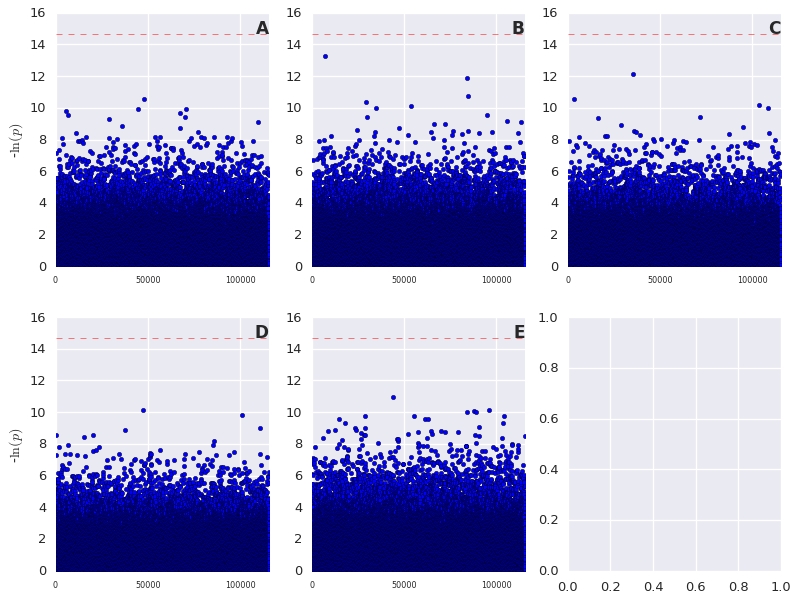

In [2062]:
lst = ['A','B','C','D','E','F']
with PdfPages('/home/lindb/wbp/figures/all_manhattan_ln.pdf') as pdf:
    
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6)) = plt.subplots(2, 3, figsize=(5,5),dpi=400)
    
    plotdict = {}
    count = 1
    for pheno in sorted(lmm):
        plotdict[count] = plt.subplot(int("23%s" % count))

        plotdict[count].scatter(range(len(lmm[pheno].index)),[-1*math.log(x) for x in lmm[pheno]['p_wald'].tolist()])

        plotdict[count].set_title(lst[count-1],y=.9,loc='right',fontsize=17,fontweight='bold')
        
        plotdict[count].set_xlim(0,len(lmm[pheno].index))
        plotdict[count].set_ylim(0,16)
        plotdict[count].axhline(y=lnp,c="red",linewidth=0.5,zorder=1,ls='dashed')
        plotdict[count].locator_params(axis='x',nbins=5)
        for tick in plotdict[count].xaxis.get_major_ticks():
                tick.label.set_fontsize(8)
        if count in [1,4,7]:
            plotdict[count].set_ylabel(r'-$\ln(p)$',fontsize=14)
        
        if count == 6:
            plotdict[count].spines['right'].set_visible(False)
            plotdict[count].spines['left'].set_visible(False)
            plotdict[count].spines['top'].set_visible(False)
            plotdict[count].spines['bottom'].set_visible(False)
            plotdict[count].axes.get_yaxis().set_visible(False)
            plotdict[count].axes.get_xaxis().set_ticks([])
            plotdict[count].axes.get_yaxis().set_ticks([])
        
        count += 1

    fig.set_size_inches(13,10)
    pdf.savefig(fig,bbox_inches='tight')

### blslmm

In [52]:
outdir = '/home/lindb/wbp/gemma/infiles/bslmm/output/'

In [55]:
bslmm = [op.join(outdir,f) for f in ls(outdir) if '50mil' in f]
len(bslmm)

100

In [57]:
sorted(bslmm)

['/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_1_out_50mil.bv.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_1_out_50mil.gamma.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_1_out_50mil.hyp.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_1_out_50mil.log.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_1_out_50mil.param.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_2_out_50mil.bv.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_2_out_50mil.gamma.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_2_out_50mil.hyp.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_2_out_50mil.log.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_2_out_50mil.param.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_3_out_50mil.bv.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_3_out_50mil.gamma.txt',
 '/home/lindb/wbp/gemma/infiles/b

In [70]:
%%R
library(coda)
library(data.table)

In [69]:
plot_mcmc = r('plot')

In [75]:
def makehash():
    return collections.defaultdict(makehash)

def split_bslmm_by_pheno(bslmm):
    h = makehash()
    for f in bslmm:
        d = os.path.basename(f).split("_")
        pheno = d[0]
        o = d[-1].split(".")
        out = o[1]
        num = d[2]
        h[pheno][out][num] = f
    return h
bslmm_dict = split_bslmm_by_pheno(bslmm)

In [76]:
def collect_files(key):
    d = defaultdict(list)
    for pheno, data in bslmm_dict.items():
        for n in data[key]:
            d[pheno].append(data[key][n])
    return d
    
hyp_files = collect_files("hyp")
param_files = collect_files("param")

In [77]:
hyp_files

defaultdict(list,
            {'bfpopx': ['/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_1_out_50mil.hyp.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_3_out_50mil.hyp.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_2_out_50mil.hyp.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_4_out_50mil.hyp.txt'],
             'c13popx': ['/home/lindb/wbp/gemma/infiles/bslmm/output/c13popx_bslmm_1_out_50mil.hyp.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/c13popx_bslmm_3_out_50mil.hyp.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/c13popx_bslmm_2_out_50mil.hyp.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/c13popx_bslmm_4_out_50mil.hyp.txt'],
             'htpopx': ['/home/lindb/wbp/gemma/infiles/bslmm/output/htpopx_bslmm_1_out_50mil.hyp.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/htpopx_bslmm_3_out_50mil.hyp.txt',
              '

In [78]:
param_files

defaultdict(list,
            {'bfpopx': ['/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_1_out_50mil.param.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_3_out_50mil.param.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_2_out_50mil.param.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_4_out_50mil.param.txt'],
             'c13popx': ['/home/lindb/wbp/gemma/infiles/bslmm/output/c13popx_bslmm_1_out_50mil.param.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/c13popx_bslmm_3_out_50mil.param.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/c13popx_bslmm_2_out_50mil.param.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/c13popx_bslmm_4_out_50mil.param.txt'],
             'htpopx': ['/home/lindb/wbp/gemma/infiles/bslmm/output/htpopx_bslmm_1_out_50mil.param.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/htpopx_bslmm_3_out_50mil.param.t

In [79]:
r('eff_size=list()')
r('mcmc_summary=list()')
r('mcmc_lists=list()')
for pheno, files in hyp_files.items():
    print(pheno)
    r("m_list=list()")
    %R -i pheno
    for i, hyp_file in enumerate(files):
        lines = open(hyp_file).readlines()
        if len(lines) < 10:
            continue
        data = []
        for l in lines:
            l = l.strip().split("\t")
            data.append(l)
        hyp = pd.DataFrame(data[1:], columns=data[0], dtype=float)
        hyp.columns = [x.strip() for x in hyp.columns]
        hyp.to_csv(hyp_file, sep="\t", header=True, index=False)
        %R -i hyp_file
        r("m = mcmc(fread('%s', sep='\t', , header=T, data.table=F), thin=1000)" % hyp_file)
        r("m_list$%s = m" % os.path.basename(hyp_file))
    r("mcmc_list = mcmc.list(m_list)")
    r("mcmc_lists$%s = mcmc_list" % pheno) 
    r("eff_size$%s = effectiveSize(mcmc_list)" % pheno)
    r("mcmc_summary$%s = summary(mcmc_list)" % pheno)

rspopx
bfpopx
c13popx
n15popx
htpopx


In [83]:
%R -i outdir
r("saveRDS(mcmc_lists, file='%s')" % os.path.join(outdir, "mcmc_lists_50mil.rds"));
r("saveRDS(mcmc_summary, file='%s')" % os.path.join(outdir, "mcmc_summary_50mil.rds"));

In [85]:
print '\t effective sizes'
print(r('eff_size'))
print '\t mcmc summaries'
print(r('mcmc_summary'))
print '\t stuff'
for pheno in hyp_files:
    print(pheno, r('gelman.diag(mcmc_lists$%s, autoburnin=F)' % pheno))

	 effective sizes
$rspopx
         h        pve        rho        pge         pi    n_gamma 
174634.061 174660.583 165759.920 164976.921   2482.951   2379.966 

$bfpopx
         h        pve        rho        pge         pi    n_gamma 
170436.545 168265.006 179322.545 178958.491   2510.537   2353.234 

$c13popx
         h        pve        rho        pge         pi    n_gamma 
181831.725 181402.980 183760.145 184036.660   2379.670   2241.652 

$n15popx
         h        pve        rho        pge         pi    n_gamma 
190591.829 190782.000 197771.034 198260.415   2121.739   2038.530 

$htpopx
         h        pve        rho        pge         pi    n_gamma 
190111.671 186313.595 188676.860 188247.670   2242.278   2125.051 


	 mcmc summaries
$rspopx

Iterations = 1:49999001
Thinning interval = 1000 
Number of chains = 4 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

             Mean        SD  Naive SE

[1] "bfpopx"
[1] "c13popx"
[1] "n15popx"
[1] "htpopx"
[1] "rspopx"


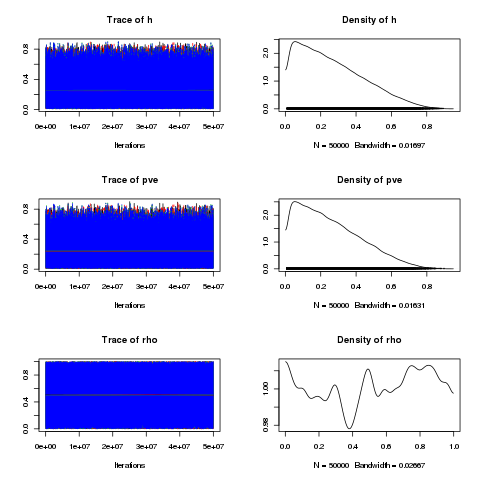

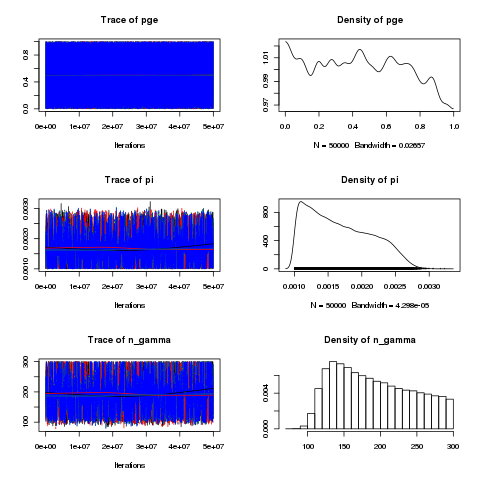

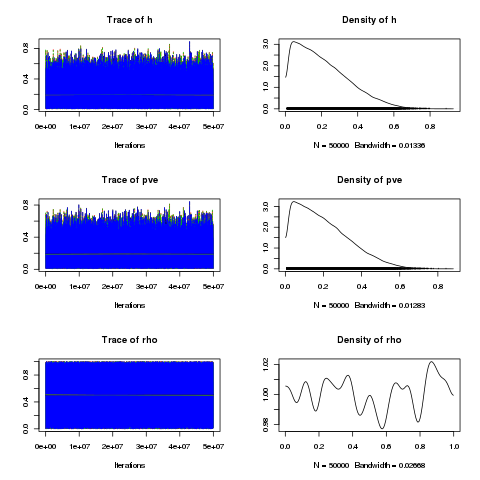

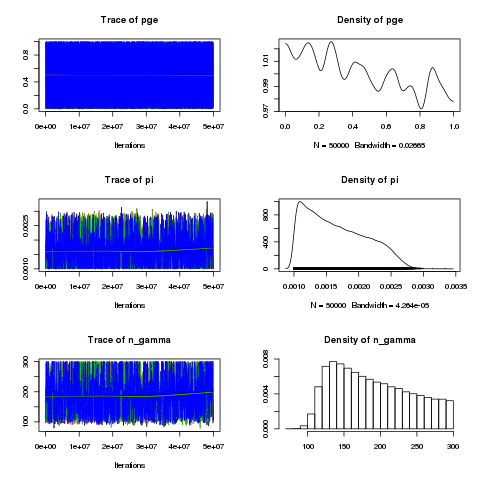

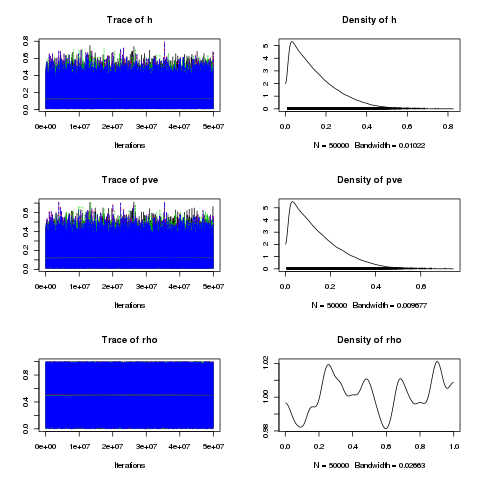

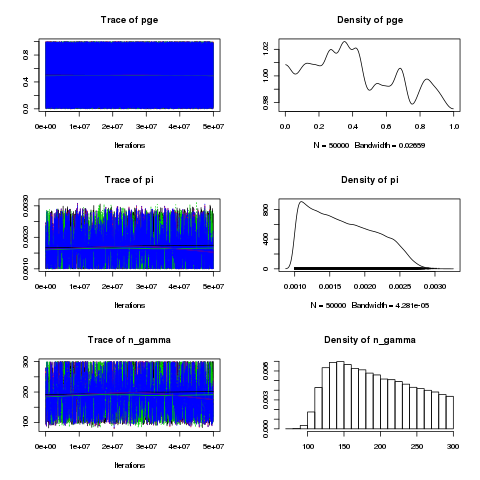

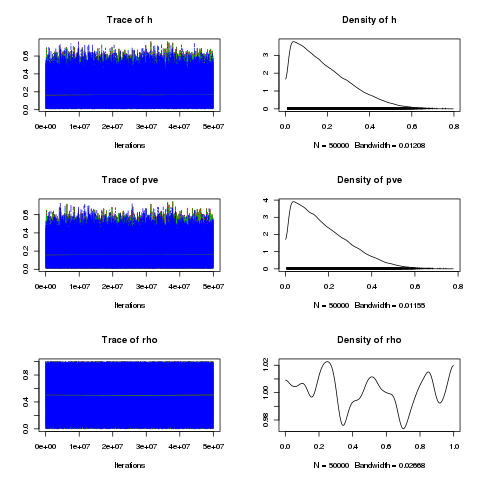

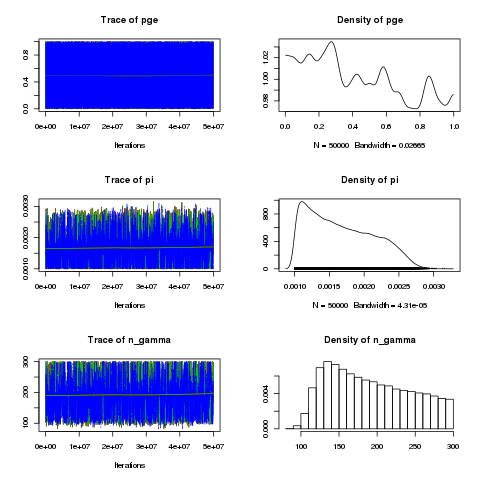

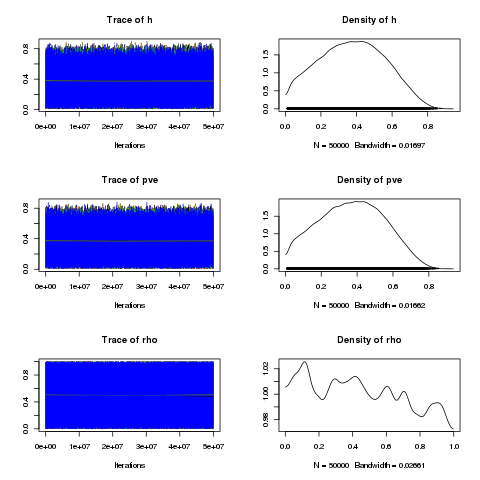

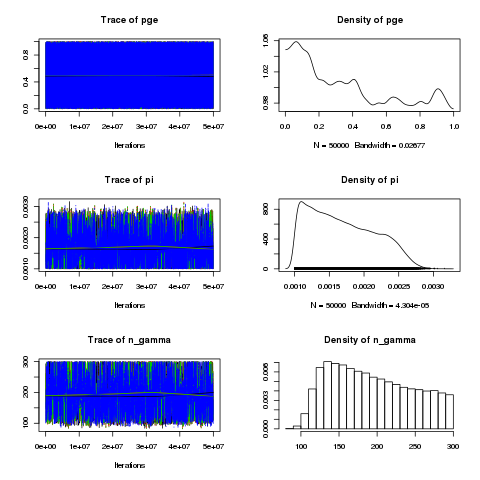

In [91]:
%%R
print("bfpopx")
mcmc_lists = readRDS(paste(outdir, '/mcmc_lists_50mil.rds', sep=''))
plot(mcmc_lists$bfpopx)
print("c13popx")
plot(mcmc_lists$c13popx)
print("n15popx")
plot(mcmc_lists$n15popx)
print("htpopx")
plot(mcmc_lists$htpopx)
print("rspopx")
plot(mcmc_lists$rspopx)

In [2091]:
p

TypeError: unbound method __init__() must be called with NDFrame instance as first argument (got Series instance instead)

In [2092]:
param_files

defaultdict(list,
            {'bfpopx': ['/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_1_out_50mil.param.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_3_out_50mil.param.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_2_out_50mil.param.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx_bslmm_4_out_50mil.param.txt'],
             'c13popx': ['/home/lindb/wbp/gemma/infiles/bslmm/output/c13popx_bslmm_1_out_50mil.param.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/c13popx_bslmm_3_out_50mil.param.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/c13popx_bslmm_2_out_50mil.param.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/c13popx_bslmm_4_out_50mil.param.txt'],
             'htpopx': ['/home/lindb/wbp/gemma/infiles/bslmm/output/htpopx_bslmm_1_out_50mil.param.txt',
              '/home/lindb/wbp/gemma/infiles/bslmm/output/htpopx_bslmm_3_out_50mil.param.t

In [2090]:
param_dfs['bfpopx']

OptionError: "No such keys(s): 'display.encoding'"

OptionError: "No such keys(s): 'display.large_repr'"

In [111]:
param_dfs['bfpopx']

chr_1  ps_1  n_miss_1       alpha_1  \
rs                                                                             
NODE_1000013_length_91_cov_1.802198_37      -9    -9         0 -1.810487e-05   
NODE_1000031_length_98_cov_2.000000_30      -9    -9         0  8.214069e-06   
NODE_1000037_length_93_cov_2.043011_33      -9    -9         0  1.218025e-05   
NODE_1000042_length_93_cov_1.118280_100     -9    -9         0  6.114693e-06   
NODE_1000053_length_94_cov_1.744681_25      -9    -9         0  5.760118e-05   
NODE_1000061_length_47_cov_1.680851_49      -9    -9         0  2.527474e-05   
NODE_1000118_length_95_cov_2.000000_24      -9    -9         0 -3.003898e-05   
NODE_1000128_length_98_cov_1.714286_53      -9    -9         0  1.514000e-05   
NODE_1000180_length_98_cov_2.204082_17      -9    -9         0  2.442354e-05   
NODE_1000188_length_67_cov_1.223881_65      -9    -9         0 -5.827942e-06   
NODE_1000205_length_93_cov_1.096774_25      -9    -9         0 -8.128915e-06   
NODE_1000221_length_96_cov_1.000000_62      -9    -9         0  2.036075e-05   
NODE_1000239_length_82_cov_1.707317_43      -9    -9         0  2.474991e-05   
NODE_1000253_length_98_cov_2.173469_19      -9    -9         0 -4.313407e-05   
NODE_1000254_length_97_cov_3.783505_29      -9    -9         0 -5.308542e-05   
NODE_1000280_length_100_cov_4.000000_84     -9    -9         0 -2.659978e-05   
NODE_1000281_length_98_cov_1.071429_78      -9    -9         0  1.628885e-05   
NODE_1000307_length_94_cov_1.138298_101     -9    -9         0  1.385645e-05   
NODE_1000309_length_97_cov_1.000000_112     -9    -9         0  7.605556e-05   
NODE_1000340_length_100_cov_3.140000_14     -9    -9         0  6.868289e-06   
NODE_1000353_length_95_cov_1.147368_20      -9    -9         0 -2.558948e-05   
NODE_1000357_length_98_cov_2.204082_30      -9    -9         0  1.082677e-06   
NODE_1000358_length_99_cov_2.202020_36      -9    -9         0 -4.196902e-05   
NODE_1000360_length_91_cov_1.010989_94      -9    -9         0  1.888109e-05   
NODE_1000364_length_95_cov_1.000000_103     -9    -9         0 -8.124077e-06   
NODE_1000403_length_98_cov_4.214286_139     -9    -9         0 -2.278585e-05   
NODE_1000435_length_95_cov_1.052632_10      -9    -9         0 -7.221771e-05   
NODE_1000451_length_98_cov_3.061224_15      -9    -9         0 -3.180080e-05   
NODE_1000468_length_98_cov_1.173469_125     -9    -9         0 -3.587051e-05   
NODE_100046_length_98_cov_2.000000_114      -9    -9         0  2.196567e-05   
...                                        ...   ...       ...           ...   
NODE_99969_length_61_cov_1.573771_66        -9    -9         0 -1.817467e-05   
NODE_999726_length_96_cov_1.041667_55       -9    -9         0 -2.258402e-05   
NODE_999729_length_107_cov_1.224299_110     -9    -9         0 -1.105721e-05   
NODE_999738_length_123_cov_1.162602_83      -9    -9         0  6.100954e-05   
NODE_999744_length_98_cov_2.000000_74       -9    -9         0 -4.895173e-06   
NODE_999745_length_98_cov_1.591837_20       -9    -9         0  4.793594e-06   
NODE_999746_length_49_cov_2.000000_56       -9    -9         0  5.539977e-06   
NODE_999751_length_95_cov_1.526316_18       -9    -9         0  7.058543e-06   
NODE_999760_length_97_cov_1.082474_80       -9    -9         0 -5.234239e-05   
NODE_999770_length_95_cov_2.000000_7        -9    -9         0  2.915922e-06   
NODE_999782_length_97_cov_2.000000_27       -9    -9         0  4.621054e-05   
NODE_999799_length_52_cov_1.115385_52       -9    -9         0  8.456983e-07   
NODE_999811_length_94_cov_1.000000_47       -9    -9         0  2.875620e-05   
NODE_999813_length_99_cov_1.060606_65       -9    -9         0  6.223529e-05   
NODE_999823_length_98_cov_2.000000_111      -9    -9         0  2.943596e-07   
NODE_999827_length_103_cov_1.844660_90      -9    -9         0 -3.463496e-06   
NODE_999845_length_92_cov_1.097826_33       -9    -9         0 -1.182211e-05   
NODE_999856_length_70_cov_1.471429_51    

In [124]:
hyp_files[0]

[]

In [132]:
#delete a useless key
newhyp_files = {}
for pheno in hyp_files.keys():
    if (pheno !=0) and (pheno!='0'):
        flz = hyp_files[pheno]
        newhyp_files[pheno] = flz
newhyp_files.keys()

['bfpopx', 'n15popx', 'c13popx', 'rspopx', 'htpopx']

In [133]:
def get_hyp_dfs(files):
    dfs = {}
    for pheno, filelist in files.items():
        dfs[pheno] = pd.DataFrame()
        df = None
        fcount = 0
        for f in sorted(filelist):
            fdata = os.path.basename(f).split(".")[0].split("_")
            num = int(fdata[2])
            
            if fcount == 0:
                df = pd.read_csv(f, sep="\t")
                df.columns = ['%s_%s' % (col,num) for col in df.columns]
            else:
                newdf = pd.read_csv(f, sep="\t")
                newdf.columns = ["%s_%s" % (col,num) for col in newdf.columns]
                df = pd.merge(df,newdf,left_index=True,right_index=True)
            fcount += 1
        df = df.apply(pd.to_numeric, errors="ignore")
        dfs[pheno] = df
    return dfs
hyp_dfs = get_hyp_dfs(newhyp_files)

In [134]:
hyp_dfs['bfpopx']

h_1     pve_1     rho_1     pge_1      pi_1  n_gamma_1       h_2  \
0      0.220253  0.231943  0.410713  0.443830  0.001884        220  0.267925   
1      0.450946  0.416229  0.617552  0.646631  0.001930        229  0.401846   
2      0.202163  0.179139  0.656780  0.554563  0.001746        202  0.211270   
3      0.183005  0.164360  0.442000  0.458563  0.001426        195  0.566320   
4      0.067618  0.062976  0.163403  0.160793  0.001379        184  0.353257   
5      0.028817  0.033380  0.888031  0.926138  0.001425        172  0.063806   
6      0.524699  0.439230  0.841032  0.827066  0.001675        167  0.715867   
7      0.539227  0.497516  0.920502  0.899939  0.001362        169  0.499005   
8      0.023987  0.022809  0.605817  0.534138  0.001342        155  0.367261   
9      0.100617  0.125269  0.849973  0.884611  0.001228        146  0.187530   
10     0.193703  0.200886  0.876232  0.916344  0.001072        144  0.024144   
11     0.447369  0.395330  0.423790  0.278062  0.001189        141  0.079034   
12     0.466187  0.374570  0.832548  0.749411  0.001331        152  0.180416   
13     0.478936  0.467399  0.238963  0.193580  0.001235        162  0.203509   
14     0.159342  0.168133  0.922936  0.919685  0.001535        162  0.320922   
15     0.230437  0.180328  0.281697  0.356596  0.001227        153  0.538278   
16     0.195016  0.164923  0.855600  0.807470  0.001444        157  0.319938   
17     0.257050  0.262500  0.319305  0.361510  0.001347        152  0.366612   
18     0.471893  0.418720  0.031475  0.026811  0.001392        154  0.404247   
19     0.110145  0.130568  0.993929  0.994594  0.001225        142  0.045177   
20     0.513436  0.536084  0.441188  0.474928  0.001111        130  0.265837   
21     0.253774  0.255010  0.487734  0.569382  0.001255        139  0.233778   
22     0.066914  0.068039  0.871093  0.840417  0.001410        133  0.512785   
23     0.325590  0.297407  0.187945  0.229934  0.001049        120  0.237857   
24     0.118700  0.112208  0.628135  0.550786  0.001025        123  0.434278   
25     0.118836  0.132268  0.161857  0.197738  0.001276        137  0.513598   
26     0.296594  0.261866  0.328051  0.305696  0.001294        152  0.048921   
27     0.310531  0.285236  0.900538  0.871786  0.001366        160  0.260516   
28     0.209941  0.165778  0.069556  0.084899  0.001319        134  0.830085   
29     0.282076  0.244387  0.790437  0.804691  0.001058        128  0.061848   
...         ...       ...       ...       ...       ...        ...       ...   
49970  0.034958  0.027658  0.438821  0.457295  0.002403        261  0.158843   
49971  0.338466  0.365638  0.682637  0.758641  0.002356        262  0.058552   
49972  0.323376  0.298639  0.414917  0.430888  0.002212        257  0.516747   
49973  0.131563  0.168677  0.241480  0.299781  0.002185        254  0.106830   
49974  0.328923  0.341535  0.190705  0.161993  0.001974        224  0.238570   
49975  0.073010  0.071156  0.262949  0.287654  0.001803        223  0.285032   
49976  0.146843  0.144078  0.103336  0.080942  0.002138        236  0.057466   
49977  0.284492  0.288403  0.337738  0.307624  0.001899        238  0.060440   
49978  0.818856  0.808314  0.871087  0.804248  0.002164        247  0.184959   
49979  0.275119  0.274121  0.168852  0.235386  0.002229        244  0.133052   
49980  0.031305  0.041582  0.819818  0.863954  0.002128        260  0.242404   
49981  0.239086  0.250904  0.365657  0.404425  0.002000        250  0.759196   
49982  0.393200  0.361144  0.441862  0.363284  0.002346        254  0.185146   
49983  0.424185  0.405338  0.834437  0.845581  0.002059        249  0.285677   
49984  0.045108  0.050768  0.055408  0.054409  0.001848        221  0.197830   
49985  0.063969  0.061896  0.040992  0.031091  0.001742        222  0.100248   
49986  0.230693  0.230727  0.615421  0.680316  0.002264        242  0.501573   
49987  0.448499  0.472035  0.417684  0.459317  0.002025        227  0.497888   
49988  0.454

In [2079]:
def get_hmean_row(row):
    try:
        return sp.stats.hmean(row)
    except ValueError as e:
        return np.nan   

def get_hmean(param):
    d = {}
    for pheno in param_dfs:
        df = param_dfs[pheno]
        g = pd.DataFrame(df[[col for col in df.columns if param in col]])
        #m = g.apply(get_hmean_row, axis=1)
        m = g.apply(np.mean, axis=1)
        g['%s_hmean' % param] = m
        d[pheno] = g
    return d

gamma_dfs = get_hmean('gamma')
beta_dfs = get_hmean('beta')
alpha_dfs = get_hmean('alpha')

In [2085]:
param = 'gamma'
for pheno in param_dfs:
    df = param_dfs[pheno]
    g = pd.DataFrame(df[[col for col in df.columns if 'gamma' in col]])
    m = g.apply(np.mean,axis=1)
    g['%s_hmean' % 'gamma']  = m
    d[pheno] = g

TypeError: unbound method __init__() must be called with NDFrame instance as first argument (got Series instance instead)

In [194]:
for pheno in gamma_dfs:
    print pheno,gamma_dfs[pheno]['gamma_hmean'].describe()['max']
    maxx = gamma_dfs[pheno]['gamma_hmean'].describe()['max']
    minn = gamma_dfs[pheno]['gamma_hmean'].describe()['min']
    print maxx/minn

rspopx 0.00754
9.0843373494
bfpopx 0.00468
6.07792207792
c13popx 0.00385
5.2027027027
n15popx 0.00306
3.94838709677
htpopx 0.003905
6.6186440678


In [207]:
np.arange(0,maxx,20)

array([ 0.])

In [208]:
d[x].quantile(q)

0.0075399999999999998

rspopx
count    115586.000000
mean          0.001679
std           0.000239
min           0.000830
25%           0.001515
50%           0.001670
75%           0.001830
max           0.007540
Name: gamma_hmean, dtype: float64


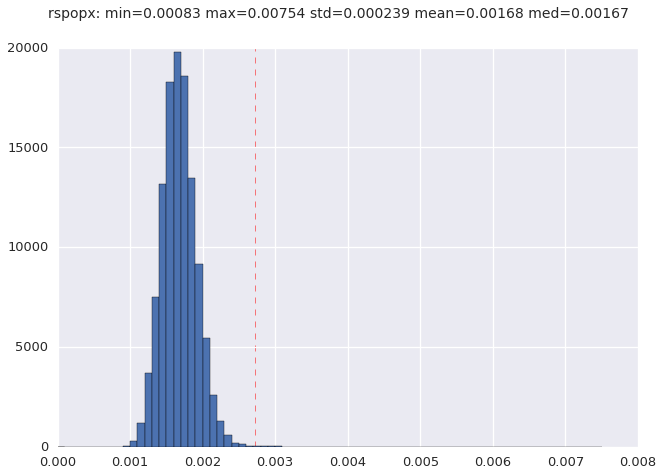

bfpopx
count    115597.000000
mean          0.001662
std           0.000223
min           0.000770
25%           0.001510
50%           0.001655
75%           0.001805
max           0.004680
Name: gamma_hmean, dtype: float64


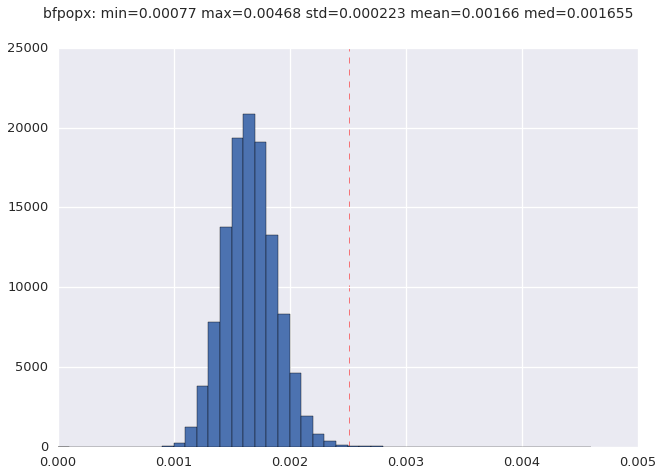

c13popx
count    115602.000000
mean          0.001646
std           0.000255
min           0.000740
25%           0.001470
50%           0.001640
75%           0.001810
max           0.003850
Name: gamma_hmean, dtype: float64


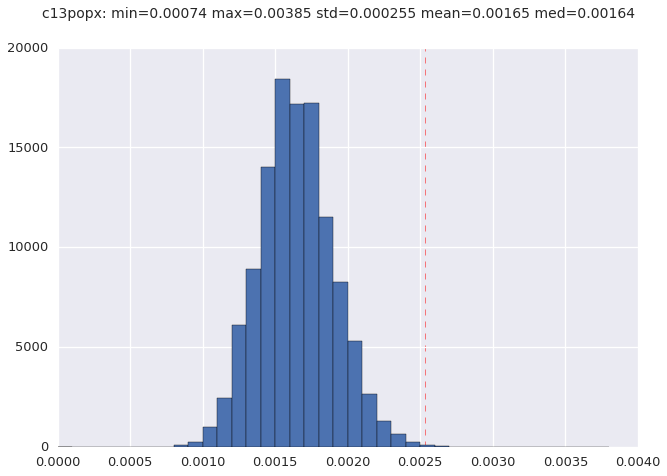

n15popx
count    115602.000000
mean          0.001675
std           0.000239
min           0.000775
25%           0.001510
50%           0.001670
75%           0.001830
max           0.003060
Name: gamma_hmean, dtype: float64


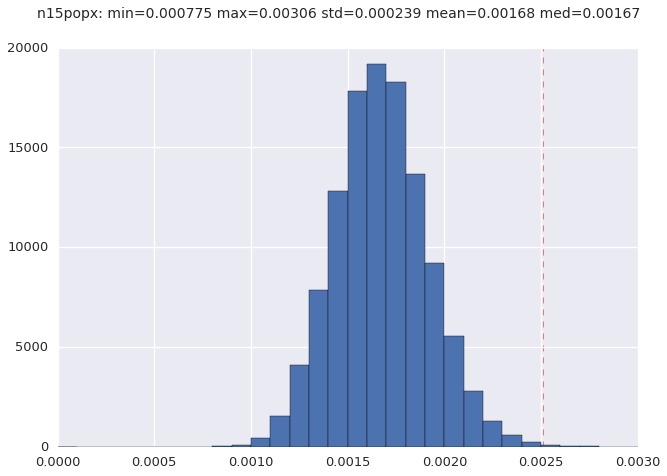

htpopx
count    115602.000000
mean          0.001659
std           0.000293
min           0.000590
25%           0.001455
50%           0.001650
75%           0.001850
max           0.003905
Name: gamma_hmean, dtype: float64


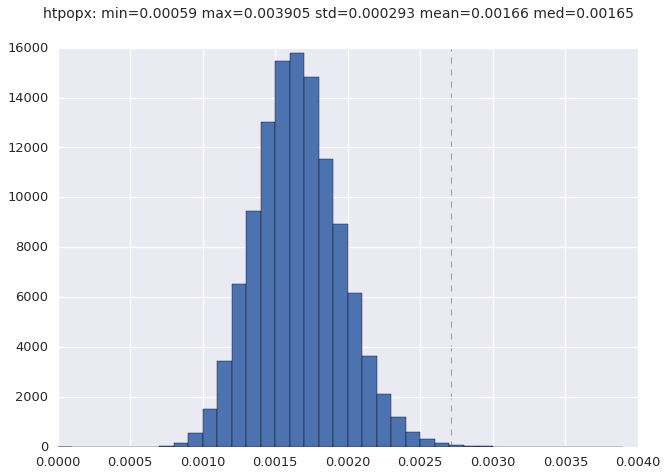

In [225]:
for pheno in gamma_dfs:
    print pheno
    print gamma_dfs[pheno]['gamma_hmean'].describe()
    maxx = max(gamma_dfs[pheno]['gamma_hmean'])
    minn = min(gamma_dfs[pheno]['gamma_hmean'])
    mean = round(gamma_dfs[pheno]['gamma_hmean'].describe()['mean'],5)
    std = gamma_dfs[pheno]['gamma_hmean'].describe()['std']
    quant = gamma_dfs[pheno]['gamma_hmean'].quantile(0.999)
    fth = gamma_dfs[pheno]['gamma_hmean'].quantile(0.5)
    plt.hist(gamma_dfs[pheno]['gamma_hmean'], bins = np.arange(0,maxx,0.0001))
    plt.axvline(x=quant,c="red",linewidth=0.5,zorder=0,ls='dashed')
    plt.suptitle(str(pheno)+':'+' min='+str(minn)+' max='+str(maxx)+' std='+str(round(std,6))+' mean='+str(mean)+' med='+str(fth),fontsize=14)
    plt.show()

In [185]:
gamma_dfs['bfpopx']['gamma_hmean'].describe()

count    115597.000000
mean          0.001662
std           0.000223
min           0.000770
25%           0.001510
50%           0.001655
75%           0.001805
max           0.004680
Name: gamma_hmean, dtype: float64

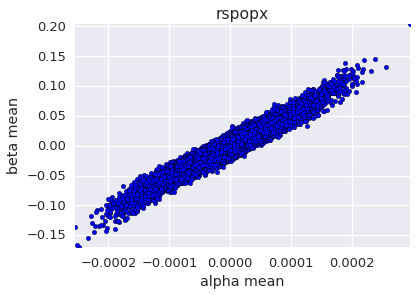

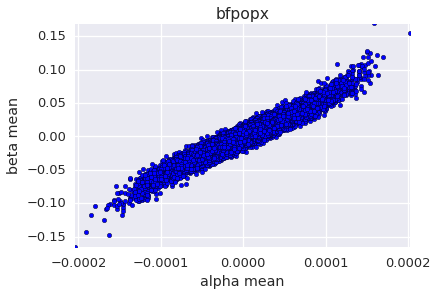

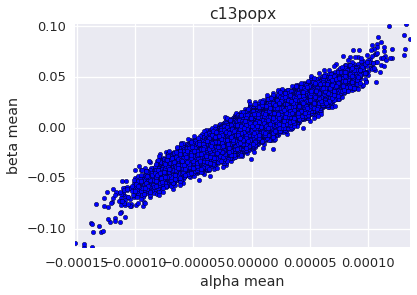

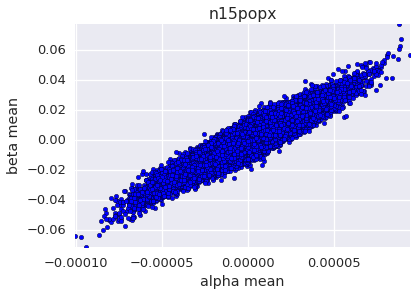

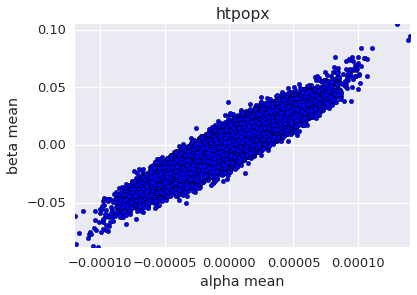

In [1607]:
#get dataframes with absolute values of effect 
combined_dfs = {}
for pheno in gamma_dfs:
    a = alpha_dfs[pheno]['alpha_hmean']
    b = beta_dfs[pheno]['beta_hmean']
    g = gamma_dfs[pheno]['gamma_hmean']
    t = pd.concat((a, b, g), axis=1)
    plt.scatter(t['alpha_hmean'], t['beta_hmean'])
    plt.xlim(np.min(a), np.max(a))
    plt.ylim(np.min(b), np.max(b))
    plt.ylabel("beta mean")
    plt.xlabel("alpha mean")
    plt.title(pheno)
    plt.show()
    t = np.abs(t)
    t['total_effect'] = t.apply(lambda x: x.alpha_hmean + x.beta_hmean, axis=1)
    t['model_averaged'] = t.apply(lambda x: x.alpha_hmean + (x.beta_hmean*x.gamma_hmean),axis=1) #sensu gompert et al. 2015
    combined_dfs[pheno] = t

In [1606]:
#get data frames with original sign from GEMMA (pos or neg effect)
combined_fx_dfs = {}
for pheno in gamma_dfs:
    a = alpha_dfs[pheno]['alpha_hmean']
    b = beta_dfs[pheno]['beta_hmean']
    g = gamma_dfs[pheno]['gamma_hmean']
    t = pd.concat((a, b, g), axis=1)
    t['total_effect'] = t.apply(lambda x: x.alpha_hmean + x.beta_hmean, axis=1)
    t['model_averaged'] = t.apply(lambda x: x.alpha_hmean + (x.beta_hmean*x.gamma_hmean), axis=1) #sensu gompert et al. 2015
    combined_fx_dfs[pheno] = t

In [1608]:
combined_fx_dfs[pheno].head()

alpha_hmean  beta_hmean  gamma_hmean  \
rs                                                                              
NODE_1000013_length_91_cov_1.802198_37      0.000005    0.002301     0.001905   
NODE_1000031_length_98_cov_2.000000_30     -0.000006   -0.007792     0.001810   
NODE_1000037_length_93_cov_2.043011_33      0.000020    0.017567     0.001920   
NODE_1000042_length_93_cov_1.118280_100    -0.000016   -0.005353     0.001675   
NODE_1000053_length_94_cov_1.744681_25      0.000011   -0.000533     0.001780   

                                         total_effect  model_averaged  
rs                                                                     
NODE_1000013_length_91_cov_1.802198_37       0.002306        0.000009  
NODE_1000031_length_98_cov_2.000000_30      -0.007798       -0.000021  
NODE_1000037_length_93_cov_2.043011_33       0.017588        0.000054  
NODE_1000042_length_93_cov_1.118280_100     -0.005369       -0.000025  
NODE_1000053_length_94_cov_1.744681_25      -0.000522        0.000010

In [1603]:
combined_dfs[pheno].loc['NODE_1000031_length_98_cov_2.000000_30',:]

alpha_hmean     0.000006
beta_hmean      0.007792
gamma_hmean     0.001810
total_effect    0.007798
Name: NODE_1000031_length_98_cov_2.000000_30, dtype: float64

In [2073]:
for pheno in combined_dfs:
    print(pheno)
    display(combined_dfs[pheno].head())

bfpopx


alpha_hmean  beta_hmean  gamma_hmean  \
rs                                                                              
NODE_1000013_length_91_cov_1.802198_37      0.000018    0.000751      0.00118   
NODE_1000031_length_98_cov_2.000000_30      0.000008    0.018813      0.00181   
NODE_1000037_length_93_cov_2.043011_33      0.000012    0.004933      0.00146   
NODE_1000042_length_93_cov_1.118280_100     0.000006    0.002573      0.00146   
NODE_1000053_length_94_cov_1.744681_25      0.000058    0.031942      0.00171   

                                         total_effect  model_averaged  
rs                                                                     
NODE_1000013_length_91_cov_1.802198_37       0.000770        0.000019  
NODE_1000031_length_98_cov_2.000000_30       0.018821        0.000042  
NODE_1000037_length_93_cov_2.043011_33       0.004945        0.000019  
NODE_1000042_length_93_cov_1.118280_100      0.002579        0.000010  
NODE_1000053_length_94_cov_1.744681_25       0.032000        0.000112

n15popx


alpha_hmean  beta_hmean  gamma_hmean  \
rs                                                                              
NODE_1000013_length_91_cov_1.802198_37      0.000035    0.016382     0.001555   
NODE_1000031_length_98_cov_2.000000_30      0.000023    0.014235     0.001860   
NODE_1000037_length_93_cov_2.043011_33      0.000006    0.003460     0.001580   
NODE_1000042_length_93_cov_1.118280_100     0.000004    0.002745     0.001315   
NODE_1000053_length_94_cov_1.744681_25      0.000012    0.015700     0.001725   

                                         total_effect  model_averaged  
rs                                                                     
NODE_1000013_length_91_cov_1.802198_37       0.016417        0.000060  
NODE_1000031_length_98_cov_2.000000_30       0.014257        0.000049  
NODE_1000037_length_93_cov_2.043011_33       0.003465        0.000011  
NODE_1000042_length_93_cov_1.118280_100      0.002749        0.000008  
NODE_1000053_length_94_cov_1.744681_25       0.015713        0.000039

c13popx


alpha_hmean  beta_hmean  gamma_hmean  \
rs                                                                              
NODE_1000013_length_91_cov_1.802198_37      0.000006    0.008956      0.00137   
NODE_1000031_length_98_cov_2.000000_30      0.000003    0.000100      0.00166   
NODE_1000037_length_93_cov_2.043011_33      0.000021    0.004199      0.00142   
NODE_1000042_length_93_cov_1.118280_100     0.000008    0.002320      0.00150   
NODE_1000053_length_94_cov_1.744681_25      0.000041    0.027766      0.00163   

                                         total_effect  model_averaged  
rs                                                                     
NODE_1000013_length_91_cov_1.802198_37       0.008961        0.000018  
NODE_1000031_length_98_cov_2.000000_30       0.000103        0.000003  
NODE_1000037_length_93_cov_2.043011_33       0.004220        0.000027  
NODE_1000042_length_93_cov_1.118280_100      0.002328        0.000012  
NODE_1000053_length_94_cov_1.744681_25       0.027807        0.000086

rspopx


alpha_hmean  beta_hmean  gamma_hmean  \
rs                                                                              
NODE_1000013_length_91_cov_1.802198_37      0.000089    0.033259     0.001765   
NODE_1000031_length_98_cov_2.000000_30      0.000024    0.011842     0.001620   
NODE_1000037_length_93_cov_2.043011_33      0.000016    0.004484     0.001635   
NODE_1000042_length_93_cov_1.118280_100     0.000009    0.001231     0.001680   
NODE_1000053_length_94_cov_1.744681_25      0.000008    0.001378     0.001835   

                                         total_effect  model_averaged  
rs                                                                     
NODE_1000013_length_91_cov_1.802198_37       0.033348        0.000148  
NODE_1000031_length_98_cov_2.000000_30       0.011866        0.000043  
NODE_1000037_length_93_cov_2.043011_33       0.004500        0.000023  
NODE_1000042_length_93_cov_1.118280_100      0.001240        0.000011  
NODE_1000053_length_94_cov_1.744681_25       0.001386        0.000010

htpopx


alpha_hmean  beta_hmean  gamma_hmean  \
rs                                                                              
NODE_1000013_length_91_cov_1.802198_37      0.000005    0.002301     0.001905   
NODE_1000031_length_98_cov_2.000000_30      0.000006    0.007792     0.001810   
NODE_1000037_length_93_cov_2.043011_33      0.000020    0.017567     0.001920   
NODE_1000042_length_93_cov_1.118280_100     0.000016    0.005353     0.001675   
NODE_1000053_length_94_cov_1.744681_25      0.000011    0.000533     0.001780   

                                         total_effect  model_averaged  
rs                                                                     
NODE_1000013_length_91_cov_1.802198_37       0.002306        0.000009  
NODE_1000031_length_98_cov_2.000000_30       0.007798        0.000021  
NODE_1000037_length_93_cov_2.043011_33       0.017588        0.000054  
NODE_1000042_length_93_cov_1.118280_100      0.005369        0.000025  
NODE_1000053_length_94_cov_1.744681_25       0.000544        0.000012

In [141]:
from matplotlib_venn import venn3, venn3_unweighted, venn3_circles

In [2075]:
phenos

['n15popx', 'c13popx', 'htpopx', 'bfpopx', 'rspopx']

In [2074]:
#write the combined_dfs to file
for pheno in combined_dfs:
    filE = '/home/lindb/wbp/gemma/infiles/bslmm/output/%s_combined_df.txt' % pheno
    combined_dfs[pheno].to_csv(filE,header=True,index=True,sep='\t')

In [111]:
#when I restart my notebook
DIR = '/home/lindb/wbp/gemma/infiles/bslmm/output/'
files = [op.join(DIR,f) for f in ls(DIR) if 'x_combined_df' in f]
combined_dfs = {}
for f in sorted(files):
    pheno = op.basename(f).split("_")[0]
    combined_dfs[pheno] = pd.read_csv(f,header=0,index_col='rs',sep='\t')

In [112]:
combined_dfs[pheno].head()

alpha_hmean  beta_hmean  gamma_hmean  \
rs                                                                              
NODE_1000013_length_91_cov_1.802198_37      0.000089    0.033259     0.001765   
NODE_1000031_length_98_cov_2.000000_30      0.000024    0.011842     0.001620   
NODE_1000037_length_93_cov_2.043011_33      0.000016    0.004484     0.001635   
NODE_1000042_length_93_cov_1.118280_100     0.000009    0.001231     0.001680   
NODE_1000053_length_94_cov_1.744681_25      0.000008    0.001378     0.001835   

                                         total_effect  model_averaged  
rs                                                                     
NODE_1000013_length_91_cov_1.802198_37       0.033348        0.000148  
NODE_1000031_length_98_cov_2.000000_30       0.011866        0.000043  
NODE_1000037_length_93_cov_2.043011_33       0.004500        0.000023  
NODE_1000042_length_93_cov_1.118280_100      0.001240        0.000011  
NODE_1000053_length_94_cov_1.744681_25       0.001386        0.000010

In [919]:
effect_snps = {}
for pheno in combined_dfs:
    d = combined_dfs[pheno]
    x = 'gamma_hmean'
    for q in [0.995, 0.999]:
        x99_cutoff = d[x].quantile(q)
        xvals = d[x][d[x] >= x99_cutoff] 
        for y in ['alpha_hmean', 'beta_hmean', 'total_effect']:
            y99_cutoff = d[y].quantile(q)
            yvals = d[y][d[y] >= y99_cutoff]
            isect = set(xvals.index).intersection(set(yvals.index))
            effect_snps[pheno, x, y, q] = isect
            print(pheno, x, y, q, len(isect))
        print()

('bfpopx', 'gamma_hmean', 'alpha_hmean', 0.995, 209)
('bfpopx', 'gamma_hmean', 'beta_hmean', 0.995, 201)
('bfpopx', 'gamma_hmean', 'total_effect', 0.995, 202)
()
('bfpopx', 'gamma_hmean', 'alpha_hmean', 0.999, 72)
('bfpopx', 'gamma_hmean', 'beta_hmean', 0.999, 70)
('bfpopx', 'gamma_hmean', 'total_effect', 0.999, 70)
()
('n15popx', 'gamma_hmean', 'alpha_hmean', 0.995, 9)
('n15popx', 'gamma_hmean', 'beta_hmean', 0.995, 9)
('n15popx', 'gamma_hmean', 'total_effect', 0.995, 9)
()
('n15popx', 'gamma_hmean', 'alpha_hmean', 0.999, 5)
('n15popx', 'gamma_hmean', 'beta_hmean', 0.999, 5)
('n15popx', 'gamma_hmean', 'total_effect', 0.999, 5)
()
('c13popx', 'gamma_hmean', 'alpha_hmean', 0.995, 74)
('c13popx', 'gamma_hmean', 'beta_hmean', 0.995, 73)
('c13popx', 'gamma_hmean', 'total_effect', 0.995, 73)
()
('c13popx', 'gamma_hmean', 'alpha_hmean', 0.999, 29)
('c13popx', 'gamma_hmean', 'beta_hmean', 0.999, 27)
('c13popx', 'gamma_hmean', 'total_effect', 0.999, 27)
()
('rspopx', 'gamma_hmean', 'alpha_hmea

In [144]:
import pickle

In [145]:
with open(os.path.join(outdir, "effect_snps_50mil.pkl"), "wb") as o:
    pickle.dump(effect_snps, o, pickle.HIGHEST_PROTOCOL)

In [172]:
for k in sorted(effect_snps):
    print k

('bfpopx', 'gamma_hmean', 'alpha_hmean', 0.995)
('bfpopx', 'gamma_hmean', 'alpha_hmean', 0.999)
('bfpopx', 'gamma_hmean', 'beta_hmean', 0.995)
('bfpopx', 'gamma_hmean', 'beta_hmean', 0.999)
('bfpopx', 'gamma_hmean', 'total_effect', 0.995)
('bfpopx', 'gamma_hmean', 'total_effect', 0.999)
('c13popx', 'gamma_hmean', 'alpha_hmean', 0.995)
('c13popx', 'gamma_hmean', 'alpha_hmean', 0.999)
('c13popx', 'gamma_hmean', 'beta_hmean', 0.995)
('c13popx', 'gamma_hmean', 'beta_hmean', 0.999)
('c13popx', 'gamma_hmean', 'total_effect', 0.995)
('c13popx', 'gamma_hmean', 'total_effect', 0.999)
('htpopx', 'gamma_hmean', 'alpha_hmean', 0.995)
('htpopx', 'gamma_hmean', 'alpha_hmean', 0.999)
('htpopx', 'gamma_hmean', 'beta_hmean', 0.995)
('htpopx', 'gamma_hmean', 'beta_hmean', 0.999)
('htpopx', 'gamma_hmean', 'total_effect', 0.995)
('htpopx', 'gamma_hmean', 'total_effect', 0.999)
('n15popx', 'gamma_hmean', 'alpha_hmean', 0.995)
('n15popx', 'gamma_hmean', 'alpha_hmean', 0.999)
('n15popx', 'gamma_hmean', 'beta

In [151]:
for key in effect_snps:
    k = [str(x) for x in key]
    out = os.path.join(outdir, "%s_effect_50mil.txt" % "-".join(k))
    with open(out, "w") as o:
        o.write("\n".join(effect_snps[key]))

In [152]:
with open(os.path.join(outdir, "combined_dfs_50mil.pkl"), "wb") as o:
    pickle.dump(combined_dfs, o, pickle.HIGHEST_PROTOCOL)

In [154]:
import seaborn as sns

/gpfs_fs/home/lindb/anaconda/envs/conda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


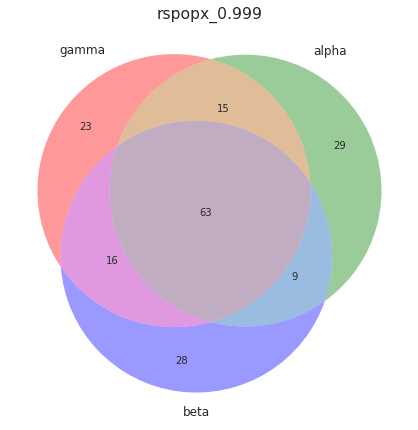

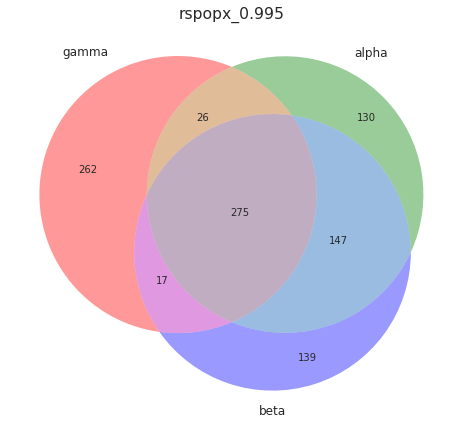

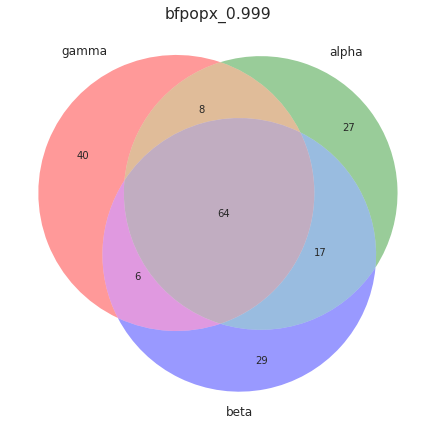

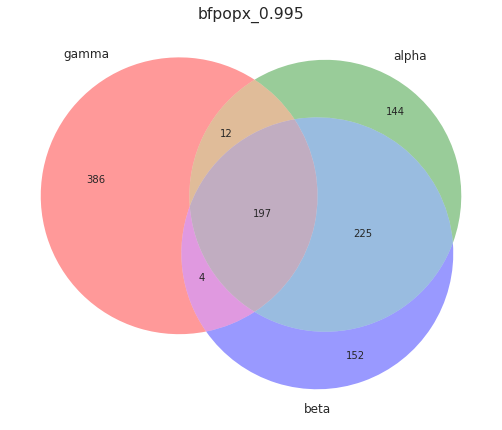

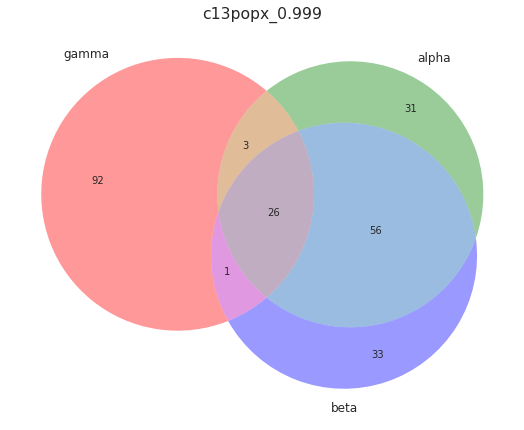

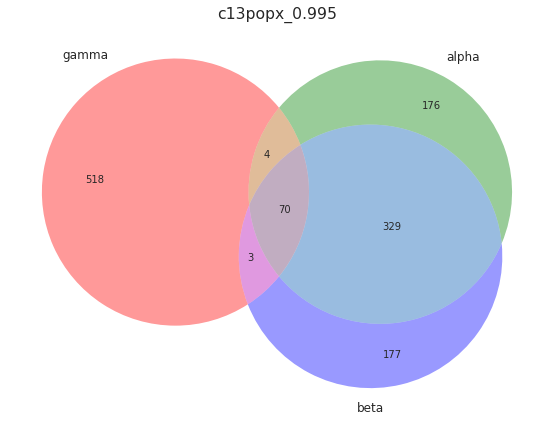

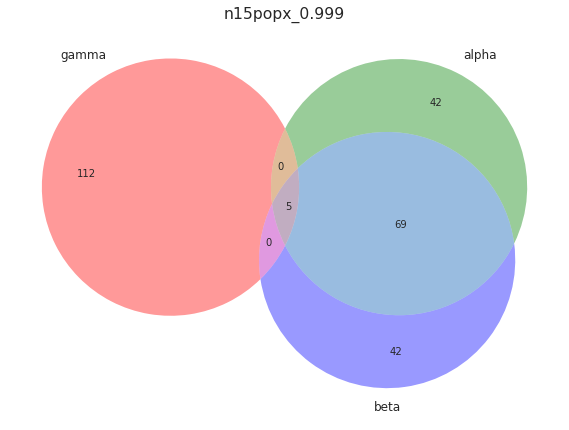

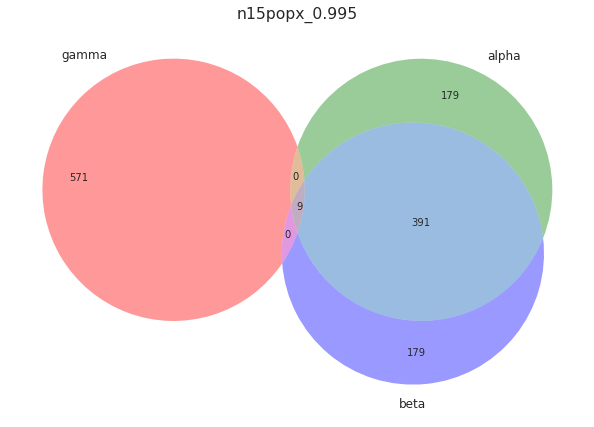

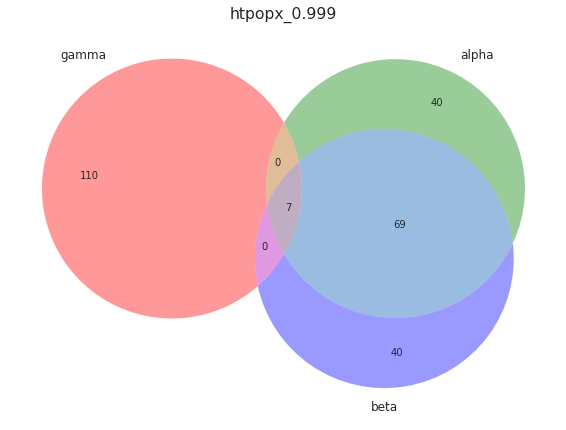

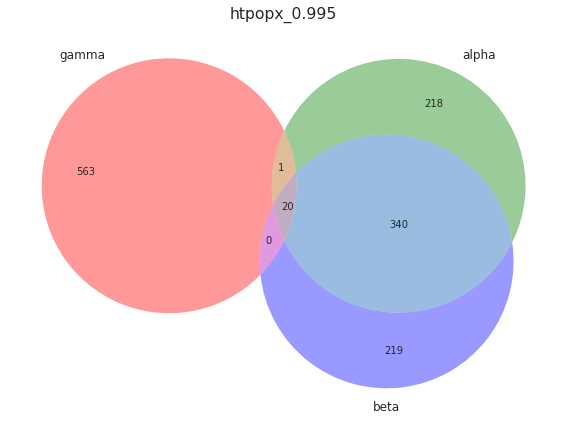

In [155]:
venn_data = {}
for pheno in combined_dfs:
    d = combined_dfs[pheno]
    x = 'gamma_hmean'
    venn_data[pheno] = {}
    for q in [0.995, 0.999]:
        venn_data[pheno][q] = []
        x99_cutoff = d[x].quantile(q)
        xvals = d[x][d[x] >= x99_cutoff] 
        venn_data[pheno][q].append(set(xvals.index))
        for y in ['alpha_hmean', 'beta_hmean']:
            y99_cutoff = d[y].quantile(q)
            yvals = d[y][d[y] >= y99_cutoff]
            venn_data[pheno][q].append(set(yvals.index))

sns.set_context("talk")
for pheno, d in venn_data.items():
    for q in d:
        venn3(d[q], ("gamma", "alpha", "beta"))
        plt.title("%s_%.3f" % (pheno, q))
        plt.show()

/gpfs_fs/home/lindb/anaconda/envs/conda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


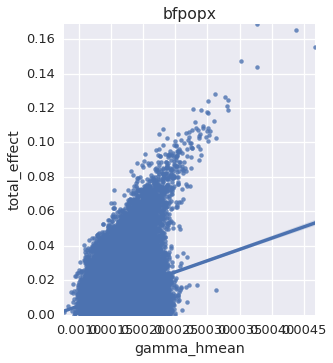

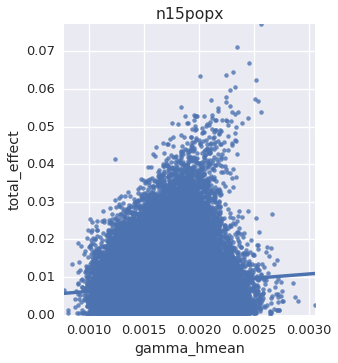

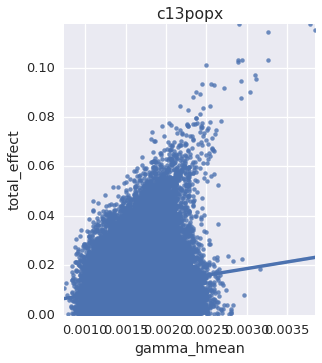

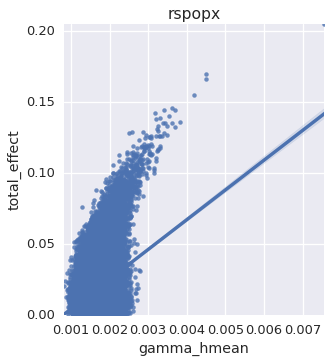

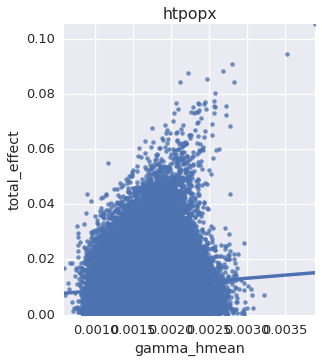

In [158]:
for pheno in combined_dfs:
    d = combined_dfs[pheno]
    x = 'gamma_hmean'
    y = 'total_effect'
    sns.lmplot(x, y, d)
    plt.xlim(np.min(d[x]), np.max(d[x]))
    plt.ylim(np.min(d[y]), np.max(d[y]))
    plt.title(pheno)
    plt.show()

In [162]:
df = pd.read_csv('/home/lindb/wbp/hierfstat/imputed/imputed_hierarchical_Fstats.txt',header=0,index_col=0,sep='\t')
df.head()

pop_total  plot_total  plot_pop  \
NODE_1000013_length_91_cov_1.802198_37   -0.002797   -0.018565 -0.015723   
NODE_1000031_length_98_cov_2.000000_30    0.014700    0.007232 -0.007579   
NODE_1000037_length_93_cov_2.043011_33   -0.008883   -0.011011 -0.002109   
NODE_1000042_length_93_cov_1.118280_100  -0.008273    0.018138  0.026194   
NODE_1000053_length_94_cov_1.744681_25   -0.020574    0.024885  0.044543   

                                         perc data  
NODE_1000013_length_91_cov_1.802198_37           1  
NODE_1000031_length_98_cov_2.000000_30           1  
NODE_1000037_length_93_cov_2.043011_33           1  
NODE_1000042_length_93_cov_1.118280_100          1  
NODE_1000053_length_94_cov_1.744681_25           1

In [166]:
loci_fst = pd.DataFrame(df['pop_total'])
loci_fst.columns = ['Fst']

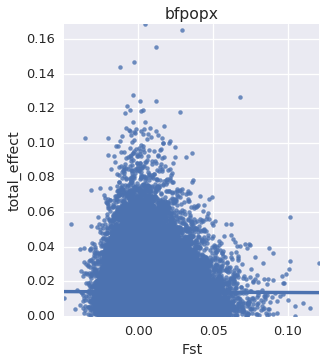

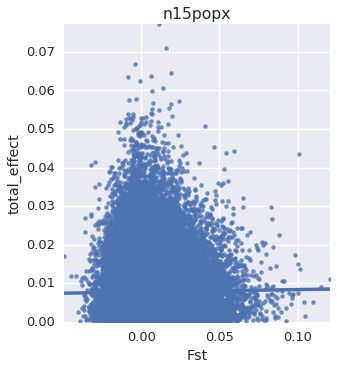

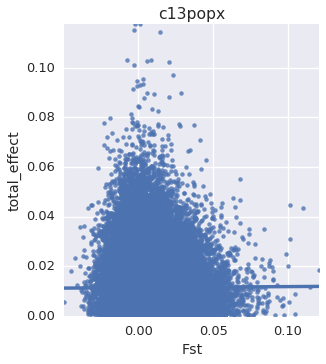

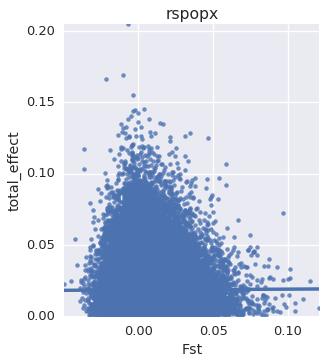

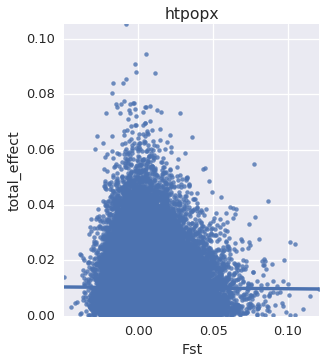

In [167]:
for pheno in combined_dfs:
    d = combined_dfs[pheno]
    j = d.join(loci_fst, how="inner")
    x = 'Fst'
    y = 'total_effect'
    sns.lmplot(x, y, j)
    plt.xlim(np.min(j[x]), np.max(j[x]))
    plt.ylim(np.min(j[y]), np.max(j[y]))
    plt.title(pheno)
    plt.show()

In [176]:
DIR = '/home/lindb/wbp/gemma/infiles/bslmm/output'
files = [op.join(DIR,f) for f in ls(DIR) if '0.999_effect_50mil' in f and 'swp' not in f]
len(files)

15

In [177]:
sorted(files)

['/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx-gamma_hmean-alpha_hmean-0.999_effect_50mil.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx-gamma_hmean-beta_hmean-0.999_effect_50mil.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx-gamma_hmean-total_effect-0.999_effect_50mil.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/c13popx-gamma_hmean-alpha_hmean-0.999_effect_50mil.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/c13popx-gamma_hmean-beta_hmean-0.999_effect_50mil.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/c13popx-gamma_hmean-total_effect-0.999_effect_50mil.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/htpopx-gamma_hmean-alpha_hmean-0.999_effect_50mil.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/htpopx-gamma_hmean-beta_hmean-0.999_effect_50mil.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/htpopx-gamma_hmean-total_effect-0.999_effect_50mil.txt',
 '/home/lindb/wbp/gemma/infiles/bslmm/output/n15popx-gamma_hmean-alpha_hmean-0.999_effec

In [179]:
fdict = {}
for f in files:
    pheno = op.basename(f).split("-")[0]
    if pheno not in fdict.keys():
        fdict[pheno] = []
    fdict[pheno].append(f)
fdict

{'bfpopx': ['/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx-gamma_hmean-beta_hmean-0.999_effect_50mil.txt',
  '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx-gamma_hmean-total_effect-0.999_effect_50mil.txt',
  '/home/lindb/wbp/gemma/infiles/bslmm/output/bfpopx-gamma_hmean-alpha_hmean-0.999_effect_50mil.txt'],
 'c13popx': ['/home/lindb/wbp/gemma/infiles/bslmm/output/c13popx-gamma_hmean-beta_hmean-0.999_effect_50mil.txt',
  '/home/lindb/wbp/gemma/infiles/bslmm/output/c13popx-gamma_hmean-total_effect-0.999_effect_50mil.txt',
  '/home/lindb/wbp/gemma/infiles/bslmm/output/c13popx-gamma_hmean-alpha_hmean-0.999_effect_50mil.txt'],
 'htpopx': ['/home/lindb/wbp/gemma/infiles/bslmm/output/htpopx-gamma_hmean-total_effect-0.999_effect_50mil.txt',
  '/home/lindb/wbp/gemma/infiles/bslmm/output/htpopx-gamma_hmean-alpha_hmean-0.999_effect_50mil.txt',
  '/home/lindb/wbp/gemma/infiles/bslmm/output/htpopx-gamma_hmean-beta_hmean-0.999_effect_50mil.txt'],
 'n15popx': ['/home/lindb/wbp/gemma/infiles/b

In [182]:
sets = {}
for pheno in fdict.keys():
    fcount = 0
    for f in fdict[pheno]:
        if fcount == 0:
            df = pd.read_csv(f,header=None,sep='\t')
            snps = df[0].tolist()
            sets[pheno] = snps
        else:
            df = pd.read_csv(f,header=None,sep='\t')
            snps = df[0].tolist()
            sets[pheno] = set(sets[pheno]).intersection(set(snps))
        fcount += 1
for pheno in sorted(sets.keys()):
    print pheno,len(sets[pheno])

bfpopx 64
c13popx 26
htpopx 7
n15popx 5
rspopx 63


# covariances intersection of 99.9th percentile of PIPs and total effect

In [6]:
filE = '/home/lindb/wbp/sampsTOpop.txt'
stpdf = pd.read_csv(filE,header=0,sep='\t')
stpdf.head()

sampID         pop  plot
0  028compiled  Dicks_Pass     3
1  024compiled  Dicks_Pass     2
2  020compiled  Dicks_Pass     2
3  025compiled  Dicks_Pass     2
4  023compiled  Dicks_Pass     2

In [7]:
stpDict = OrderedDict()
for row in stpdf.index:
    pop = stpdf.loc[row,'pop']
    if not pop in ['Heavenly','West_Shore_Peaks']:
        if not pop in stpDict.keys():
            stpDict[pop] =[]
        stpDict[pop].append(stpdf.loc[row,'sampID'])
len(stpDict.keys())

6

In [5]:
#get 012 file
filE = '/home/lindb/wbp/gemma/imputed_z12_maf_swp_trans_z12_6pop_maf_z12_nofixed.txt'
nnz12 = pd.read_csv(filE,header=0,index_col=0,sep='\t')
nnz12.head()

NODE_1000013_length_91_cov_1.802198_37  \
010compiled                                       0   
011compiled                                       1   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000031_length_98_cov_2.000000_30  \
010compiled                                       1   
011compiled                                       0   
015compiled                                       0   
016compiled                                       1   
018compiled                                       1   

             NODE_1000037_length_93_cov_2.043011_33  \
010compiled                                       1   
011compiled                                       1   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000042_length_93_cov_1.118280_100  \
010compiled                                        0   
011compiled                                        0   
015compiled                                        0   
016compiled                                        0   
018compiled                                        0   

             NODE_1000053_length_94_cov_1.744681_25  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000061_length_47_cov_1.680851_49  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000118_length_95_cov_2.000000_24  \
010compiled                                       0   
011compiled                                       1   
015compiled                                       1   
016compiled                                       1   
018compiled                                       1   

             NODE_1000128_length_98_cov_1.714286_53  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

             NODE_1000180_length_98_cov_2.204082_17  \
010compiled                                       0   
011compiled                                       1   
015compiled                                       1   
016compiled                                       1   
018compiled                                       1   

             NODE_1000188_length_67_cov_1.223881_65  \
010compiled                                       0   
011compiled                                       0   
015compiled                                       0   
016compiled                                       0   
018compiled                                       0   

                             ...                    \
010compiled                  ...                     
011compiled                  ...                     
015compiled                  ...                     
016compiled                  ...                     
018compiled                  ...                     

             NODE_999880_length_98_cov_1.683674_22  \
010compiled                                      0   
011compiled                                      0   
015compiled                                      0   
016compiled                                      1   
018compiled                                      0   

             NODE_999886_length_96_cov_1.020833

In [8]:
len(nnz12.index)

88

In [9]:
#get a dictionary of dataframes for each pop
popDict = OrderedDict()
for pop in stpDict.keys():
    df = nnz12[nnz12.index.isin(stpDict[pop])]
    popDict[pop] = df

In [13]:
#get maf for each locus for each pop
mafDict = OrderedDict()
lcount = 0
for locus in nnz12.columns:
    mafDict[locus] = OrderedDict()
    for pop in stpDict.keys():
        df = pd.DataFrame(popDict[pop])
        
        zero = df[locus].tolist().count(0)
        one = df[locus].tolist().count(1)
        two = df[locus].tolist().count(2)
        
        p = ((2*zero)+one)/(2*len(df.index))
        q = ((2*two)+one)/(2*len(df.index))
        
        assert p > q
        
        maf = q #want pop freq to be representative of the globally minor allele
        mafDict[locus][pop] = maf
    lcount += 1
    if lcount % 10000 == 0:
        print lcount

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000


In [428]:
mafDict.keys()[0]

'NODE_1000013_length_91_cov_1.802198_37'

In [14]:
filE = '/home/lindb/wbp/gemma/6pop_pop_maf.txt'
with open(filE,'w') as o:
    key0 = mafDict.keys()[0]
    line = '\t'.join(mafDict[key0].keys())+'\n'
    o.write("%s" % line)
    for locus in mafDict.keys():
        line = str(locus)+'\t'+'\t'.join([str(x) for x in mafDict[locus].values()]) + '\n'
        o.write("%s" % line)       

In [15]:
filE = '/home/lindb/wbp/gemma/6pop_pop_maf.txt'
mafDF = pd.read_csv(filE,header=0,index_col=0,sep='\t')
mafDF.head()

Dicks_Pass  Freel_Peak  \
NODE_1000013_length_91_cov_1.802198_37     0.066667    0.105263   
NODE_1000031_length_98_cov_2.000000_30     0.333333    0.078947   
NODE_1000037_length_93_cov_2.043011_33     0.100000    0.078947   
NODE_1000042_length_93_cov_1.118280_100    0.000000    0.000000   
NODE_1000053_length_94_cov_1.744681_25     0.033333    0.000000   

                                         Little_Round_Top  Mt_Rose_Ophir  \
NODE_1000013_length_91_cov_1.802198_37           0.250000       0.272727   
NODE_1000031_length_98_cov_2.000000_30           0.178571       0.045455   
NODE_1000037_length_93_cov_2.043011_33           0.071429       0.045455   
NODE_1000042_length_93_cov_1.118280_100          0.035714       0.000000   
NODE_1000053_length_94_cov_1.744681_25           0.035714       0.045455   

                                         Rifle_Peak  Snow_Valley_Peak  
NODE_1000013_length_91_cov_1.802198_37     0.100000          0.178571  
NODE_1000031_length_98_cov_2.000000_30     0.100000          0.178571  
NODE_1000037_length_93_cov_2.043011_33     0.133333          0.142857  
NODE_1000042_length_93_cov_1.118280_100    0.000000          0.071429  
NODE_1000053_length_94_cov_1.744681_25     0.033333          0.035714

In [16]:
mafDict['NODE_1000013_length_91_cov_1.802198_37']

OrderedDict([('Dicks_Pass', 0.06666666666666667),
             ('Freel_Peak', 0.10526315789473684),
             ('Little_Round_Top', 0.25),
             ('Mt_Rose_Ophir', 0.2727272727272727),
             ('Rifle_Peak', 0.1),
             ('Snow_Valley_Peak', 0.17857142857142858)])

In [17]:
for col in mafDF.columns:
    print col, max(mafDF[col])

Dicks_Pass 0.866666666667
Freel_Peak 0.736842105263
Little_Round_Top 0.75
Mt_Rose_Ophir 0.818181818182
Rifle_Peak 0.733333333333
Snow_Valley_Peak 0.785714285714


In [20]:
#get global maf for each locus
glob = OrderedDict()
lcount = 0
for locus in nnz12.columns:
    zero = nnz12[locus].tolist().count(0)
    one = nnz12[locus].tolist().count(1)
    two = nnz12[locus].tolist().count(2)
    
    p = ((2*zero)+one)/(2*len(nnz12.index))
    q = ((2*two)+one)/(2*len(nnz12.index))
    
    assert p >= q
    
    glob[locus] = min(p,q)
    lcount += 1
    if lcount % 10000 == 0:
        print lcount

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000


In [427]:
filE = '/home/lindb/wbp/gemma/6pop_glob_mafs.txt'
with open(filE,'w') as o:
    line = '\t'.join(['locus','maf'])+'\n'
    o.write("%s" % line)
    for locus in glob.keys():
        line = '\t'.join([locus,str(glob[locus])])+'\n'
        o.write("%s" % line)

In [671]:
glob['NODE_1000042_length_93_cov_1.118280_100']

0.017045454545454544

In [22]:
filE = '/home/lindb/wbp/gemma/6pop_glob_mafs.txt'
df = pd.read_csv(filE,header=0,index_col=0,sep='\t')
glob = OrderedDict()
for locus in df.index:
    glob[locus] = df.loc[locus,'maf']
df.head()

maf
locus                                            
NODE_1000013_length_91_cov_1.802198_37   0.153409
NODE_1000031_length_98_cov_2.000000_30   0.153409
NODE_1000037_length_93_cov_2.043011_33   0.096591
NODE_1000042_length_93_cov_1.118280_100  0.017045
NODE_1000053_length_94_cov_1.744681_25   0.028409

In [23]:
from __future__ import division

In [24]:
#population sizes (only for individuals in pops with phenotypic measurements)
popsizeDict = {'Dicks_Pass':15,
'Freel_Peak':19,
'Little_Round_Top':14,
'Mt_Rose_Ophir':11,
'Rifle_Peak':15,
'Snow_Valley_Peak':14,}

In [25]:
#get files with significant SNPs
DIR = '/home/lindb/wbp/gemma/infiles/bslmm/output/'
files = [op.join(DIR,f) for f in ls(DIR) if 'total_effect-0.999_effect_50mil.txt' in f]
len(files)
snpdict999 = {}
for f in sorted(files):
    pheno = op.basename(f).split("-")[0]
    df = pd.read_csv(f,header=None,sep='\t')
    snpdict999[pheno] = df[0].tolist()
    print pheno,len(snpdict999[pheno])

bfpopx 70
c13popx 27
htpopx 7
n15popx 5
rspopx 79


In [245]:
#get files with significant SNPs
DIR = '/home/lindb/wbp/gemma/infiles/bslmm/output/'
files = [op.join(DIR,f) for f in ls(DIR) if 'total_effect-0.995_effect_50mil.txt' in f]
snpdict995 = {}
for f in sorted(files):
    pheno = op.basename(f).split("-")[0]
    df = pd.read_csv(f,header=None,sep='\t')
    snpdict995[pheno] = df[0].tolist()
    print pheno,len(snpdict995[pheno])

bfpopx 202
c13popx 73
htpopx 20
n15popx 9
rspopx 292


In [36]:
from ipyparallel import Client

In [187]:
rc = Client(profile="xmn")
dview = rc[:]
lview = rc.load_balanced_view()
len(lview)

50

In [597]:
sums = 0
for pop in popsizeDict.keys():
    sums = sums + popsizeDict[pop]
sums

88

In [598]:
#change total pop size if necessary
#do pairwise to get Dij
def get_dijdict(tokens):
    from collections import OrderedDict
    from os import path as op
    from os import listdir as ls
    import os
    import numpy as np
    import pandas as pd
    
    pheno,outliersnps,glob,mafDict,popDict = tokens
    dijDict = OrderedDict() 
    dijDict[pheno] = OrderedDict() 
    for i,locusi in enumerate(outliersnps):
        dijDict[pheno][locusi] = OrderedDict()
        qi = glob[locusi] #global maf

        for j,locusj in enumerate(outliersnps):
            if i > j: #i=row, j=col : lower triangle 
                qj = glob[locusj] #global maf

                sums = 0
                for pop in popDict.keys():
                    qik = mafDict[locusi][pop] #get pop maf
                    qjk = mafDict[locusj][pop] #get pop maf
                    nk = popDict[pop]

                    sums += (float(nk)/float(88))*((qik*qjk)-(qi*qj))

                dijDict[pheno][locusi][locusj] = sums
            else:
                dijDict[pheno][locusi][locusj] = np.nan
    #write out the file
    for pheno in dijDict.keys():
        filE = '/home/lindb/wbp/gemma/covariances_total_effect_999/dvals/%s_dvals.txt' % pheno
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            key0 = dijDict[pheno].keys()[0]
            line = '\t'.join(dijDict[pheno][key0].keys()) + str('\n')
            o.write("%s" % line)
            for locusi in dijDict[pheno].keys():
                line = str(locusi)+'\t'+'\t'.join([str(x) for x in dijDict[pheno][locusi].values()]) + str('\n')
                o.write("%s" % line)

In [603]:
jobs = []
for pheno in snpdict995.keys():
    print pheno
    jobs.append(lview.apply_async(get_dijdict,[pheno,snpdict999[pheno],glob,mafDict,popsizeDict]))

rspopx
bfpopx
c13popx
n15popx
htpopx


In [613]:
count = 0
for j in jobs:
    if j.ready():
        count += 1
count

5

In [614]:
for j in jobs:
    if j.ready():
        print j.r

None
None
None
None
None


In [615]:
DIR = '/home/lindb/wbp/gemma/covariances_total_effect_999/dvals'
files = [op.join(DIR,f) for f in ls(DIR)]
dijDict = OrderedDict()
for f in sorted(files):
    pheno = op.basename(f).split("_")[0]
    dijDict[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')
dijDict[pheno].head()

NODE_1313035_length_98_cov_3.908163_26  \
NODE_1313035_length_98_cov_3.908163_26                                     NaN   
NODE_1671970_length_96_cov_1.479167_36                               -0.001405   
NODE_1305883_length_62_cov_1.322581_41                                0.000482   
NODE_640038_length_94_cov_1.202128_16                                -0.003119   
NODE_1607014_length_90_cov_1.811111_16                               -0.005580   

                                        NODE_1671970_length_96_cov_1.479167_36  \
NODE_1313035_length_98_cov_3.908163_26                                     NaN   
NODE_1671970_length_96_cov_1.479167_36                                     NaN   
NODE_1305883_length_62_cov_1.322581_41                                0.001654   
NODE_640038_length_94_cov_1.202128_16                                 0.003394   
NODE_1607014_length_90_cov_1.811111_16                                0.003501   

                                        NODE_1305883_length_62_cov_1.322581_41  \
NODE_1313035_length_98_cov_3.908163_26                                     NaN   
NODE_1671970_length_96_cov_1.479167_36                                     NaN   
NODE_1305883_length_62_cov_1.322581_41                                     NaN   
NODE_640038_length_94_cov_1.202128_16                                -0.000090   
NODE_1607014_length_90_cov_1.811111_16                                0.008966   

                                        NODE_640038_length_94_cov_1.202128_16  \
NODE_1313035_length_98_cov_3.908163_26                                    NaN   
NODE_1671970_length_96_cov_1.479167_36                                    NaN   
NODE_1305883_length_62_cov_1.322581_41                                    NaN   
NODE_640038_length_94_cov_1.202128_16                                     NaN   
NODE_1607014_length_90_cov_1.811111_16                               0.001919   

                                        NODE_1607014_length_90_cov_1.811111_16  \
NODE_1313035_length_98_cov_3.908163_26                                     NaN   
NODE_1671970_length_96_cov_1.479167_36                                     NaN   
NODE_1305883_length_62_cov_1.322581_41                                     NaN   
NODE_640038_length_94_cov_1.202128_16                                      NaN   
NODE_1607014_length_90_cov_1.811111_16                                     NaN   

                                        NODE_1464545_length_92_cov_1.010870_12  \
NODE_1313035_length_98_cov_3.908163_26                                     NaN   
NODE_1671970_length_96_cov_1.479167_36                                     NaN   
NODE_1305883_length_62_cov_1.322581_41                                     NaN   
NODE_640038_length_94_cov_1.202128_16                                      NaN   
NODE_1607014_length_90_cov_1.811111_16                                     NaN   

                                        NODE_1302121_length_94_cov_1.000000_107  \
NODE_1313035_length_98_cov_3.908163_26                                      NaN   
NODE_1671970_length_96_cov_1.479167_36                                      NaN   
NODE_1305883_length_62_cov_1.322581_41                                      NaN   
NODE_640038_length_94_cov_1.202128_16                                       NaN   
NODE_1607014_length_90_cov_1.811111_16                                      NaN   

                                        NODE_1107548_length_94_cov_1.031915_16  \
NODE_1313035_length_98_cov_3.908163_26                                     NaN   
NODE_1671970_length_96_cov_1.479167_36                                     NaN   
NODE_1305883_length_62_cov_1.322581_41                                     NaN   
NODE_640038_length_94_cov_1.202128_16                                      NaN   
NODE_1607014_length_90_cov_1.811111_16                                     NaN   

                                        NODE_1553188_length_98_cov_1.010204_134  \
NODE_1313035_

In [616]:
for pheno in dijDict.keys():
    print pheno,len(dijDict[pheno].columns)

bfpopx 70
c13popx 27
htpopx 7
n15popx 5
rspopx 79


In [617]:
#get expected heterozygosity
Hexp = OrderedDict()
for locus in glob.keys():
    Hexp[locus] = 2*glob[locus]*(1-glob[locus])

In [618]:
filE = '/home/lindb/wbp/gemma/covariances_total_effect_999/6pops_Hexp_by_snp.txt'
with open(filE,'w') as o:
    text = 'locus\tH_exp\n'
    o.write("%s" % text)
    for snp in Hexp.keys():
        text = '\t'.join([snp,str(Hexp[snp])])+'\n'
        o.write("%s" % text)

In [619]:
filE = '/home/lindb/wbp/gemma/covariances_total_effect_999/6pops_Hexp_by_snp.txt'
H = pd.read_csv(filE,header=0,sep='\t')
H.index = [snp for snp in H['locus'].tolist()]
H.head()

locus  \
NODE_1000013_length_91_cov_1.802198_37    NODE_1000013_length_91_cov_1.802198_37   
NODE_1000031_length_98_cov_2.000000_30    NODE_1000031_length_98_cov_2.000000_30   
NODE_1000037_length_93_cov_2.043011_33    NODE_1000037_length_93_cov_2.043011_33   
NODE_1000042_length_93_cov_1.118280_100  NODE_1000042_length_93_cov_1.118280_100   
NODE_1000053_length_94_cov_1.744681_25    NODE_1000053_length_94_cov_1.744681_25   

                                            H_exp  
NODE_1000013_length_91_cov_1.802198_37   0.259749  
NODE_1000031_length_98_cov_2.000000_30   0.259749  
NODE_1000037_length_93_cov_2.043011_33   0.174522  
NODE_1000042_length_93_cov_1.118280_100  0.033510  
NODE_1000053_length_94_cov_1.744681_25   0.055204

In [620]:
#assign bins to samps
#1st bin is the j=0th bin, 50th bin is the j=49th bin
count = 0
binDict = OrderedDict()
for row in H.index:
    h = np.round(H.loc[row,'H_exp'],decimals=3)
    binDict[row] = 0 #because 2pq will never be equal to 0 for a SNP, but may be less than 0.01
    for Bin,j in enumerate(np.arange(0,0.51,0.01)): #1st bin is the j=0th bin, 50th bin is the j=49th bin
        if h>j: #binDict[row] will constantly replace the value, which is good. don't want 2pq=0.5 having its own group
            binDict[row] = Bin
    count += 1
    if count % 10000 == 0:
        print count
H['bin'] = binDict.values()

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000


In [389]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mtick
%matplotlib inline

<a list of 50 Patch objects>

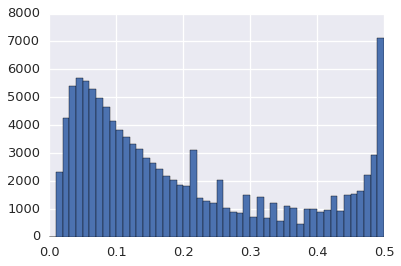

In [391]:
plt.hist(H['H_exp'],bins = [x for x in np.arange(0,.51,0.01)])[2]

In [392]:
dijDict.keys()

['bfpopx', 'c13popx', 'htpopx', 'n15popx', 'rspopx']

In [622]:
#get a dataframe with the outlier loci and their bins
outlierdata = OrderedDict()
for pheno in dijDict.keys():
    print pheno,len(snpdict999[pheno])
    outliersnps = snpdict999[pheno]

    outlierdata[pheno] = pd.DataFrame(H[H.index.isin(outliersnps)])

bfpopx 70
c13popx 27
htpopx 7
n15popx 5
rspopx 79


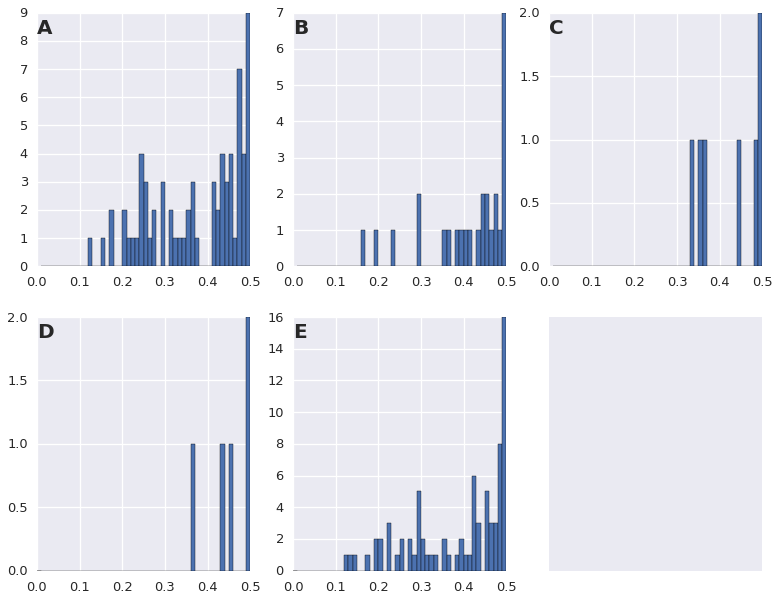

In [623]:
with PdfPages('/home/lindb/wbp/figures/grid_imp_hexp_hist_by_pheno_999.pdf') as pdf:
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6)) = plt.subplots(2, 3, figsize=(5,5),dpi=400)

    a1 = plt.subplot(231)
    a1.hist(outlierdata['bfpopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a1.set_title('A',y=.9,loc='left',fontsize=20,fontweight='bold')
    a1.spines['right'].set_visible(False)
    a1.spines['top'].set_visible(False)
    a1.yaxis.set_ticks_position('left')
    a1.xaxis.set_ticks_position('bottom')
    
    a2 = plt.subplot(232)
    a2.hist(outlierdata['c13popx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a2.set_title('B',y=.9,loc='left',fontsize=20,fontweight='bold')
    a2.spines['right'].set_visible(False)
    a2.spines['top'].set_visible(False)
    a2.yaxis.set_ticks_position('left')
    a2.xaxis.set_ticks_position('bottom')
    
    a3 = plt.subplot(233)
    a3.hist(outlierdata['htpopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a3.set_title('C',y=.9,loc='left',fontsize=20,fontweight='bold')
    a3.spines['right'].set_visible(False)
    a3.spines['top'].set_visible(False)
    a3.yaxis.set_ticks_position('left')
    a3.xaxis.set_ticks_position('bottom')
    
    a4 = plt.subplot(234)
    a4.hist(outlierdata['n15popx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a4.set_title('D',y=.9,loc='left',fontsize=20,fontweight='bold')
    a4.spines['right'].set_visible(False)
    a4.spines['top'].set_visible(False)
    a4.yaxis.set_ticks_position('left')
    a4.xaxis.set_ticks_position('bottom')
    
    a5 = plt.subplot(235)
    a5.hist(outlierdata['rspopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a5.set_title('E',y=.9,loc='left',fontsize=20,fontweight='bold')
    a5.spines['right'].set_visible(False)
    a5.spines['top'].set_visible(False)
    a5.yaxis.set_ticks_position('left')
    a5.xaxis.set_ticks_position('bottom')
    
    a6.spines['right'].set_visible(False)
    a6.spines['left'].set_visible(False)
    a6.spines['top'].set_visible(False)
    a6.spines['bottom'].set_visible(False)
    a6.axes.get_yaxis().set_visible(False)
    a6.axes.get_xaxis().set_ticks([])
    a6.axes.get_yaxis().set_ticks([])
    
    fig.set_size_inches(13,10)
    pdf.savefig(fig,bbox_inches='tight')

In [624]:
#get sets of SNPs to make random draws
nonsigsnps = OrderedDict()
for pheno in outlierdata.keys():
    nonsigs = list(set(H.index.tolist()) - set(outlierdata[pheno].index.tolist()))
    nonsigsnps[pheno] = pd.DataFrame(H[H.index.isin(nonsigs)])
    print len(outlierdata[pheno].index.tolist())+len(nonsigsnps[pheno].index)

115632
115632
115632
115632
115632


In [625]:
#how many random snps to draw from each bin?
binCounter = OrderedDict()
for pheno in outlierdata.keys():
    binCounter[pheno] = Counter()
    for row in outlierdata[pheno].index:
        binCounter[pheno][outlierdata[pheno].loc[row,'bin']] += 1
    for b in binCounter[pheno].keys():
        print pheno,b,binCounter[pheno][b]

bfpopx 12 1
bfpopx 15 1
bfpopx 17 2
bfpopx 20 2
bfpopx 21 1
bfpopx 22 1
bfpopx 23 1
bfpopx 24 4
bfpopx 25 3
bfpopx 26 1
bfpopx 27 2
bfpopx 28 2
bfpopx 29 1
bfpopx 31 2
bfpopx 32 1
bfpopx 33 1
bfpopx 34 1
bfpopx 35 2
bfpopx 36 3
bfpopx 37 1
bfpopx 41 3
bfpopx 42 2
bfpopx 43 4
bfpopx 44 3
bfpopx 45 4
bfpopx 46 1
bfpopx 47 7
bfpopx 48 4
bfpopx 49 9
c13popx 48 1
c13popx 35 1
c13popx 36 1
c13popx 38 1
c13popx 39 1
c13popx 40 1
c13popx 41 1
c13popx 43 1
c13popx 44 2
c13popx 45 2
c13popx 46 1
c13popx 47 2
c13popx 16 1
c13popx 49 7
c13popx 19 1
c13popx 23 1
c13popx 29 2
htpopx 33 1
htpopx 35 1
htpopx 36 1
htpopx 44 1
htpopx 48 1
htpopx 49 2
n15popx 49 2
n15popx 43 1
n15popx 36 1
n15popx 45 1
rspopx 12 1
rspopx 13 1
rspopx 14 1
rspopx 17 1
rspopx 19 2
rspopx 20 2
rspopx 22 3
rspopx 24 1
rspopx 25 2
rspopx 27 2
rspopx 28 4
rspopx 29 2
rspopx 30 2
rspopx 31 1
rspopx 32 1
rspopx 33 1
rspopx 35 2
rspopx 36 1
rspopx 38 1
rspopx 39 2
rspopx 40 1
rspopx 41 1
rspopx 42 6
rspopx 43 3
rspopx 45 5
rspopx 

In [422]:
os.makedirs('/home/lindb/wbp/gemma/covariances_total_effect_999/randmatrices')
os.makedirs('/home/lindb/wbp/gemma/covariances_total_effect_999/randmatrices/randsnps')

In [626]:
#for each pheno make 1000 dataframes with a set of snps == len(outliersnps[pheno])
for pheno in outlierdata.keys():
    print pheno
    for i in range(1000):  
        snps = []        
        for binn in binCounter[pheno].keys():
            data = nonsigsnps[pheno][nonsigsnps[pheno]['bin'] == binn]
                
            [snps.append(snp) for snp in random.sample(data.index,binCounter[pheno][binn])]
        
        assert len(np.unique(snps).tolist()) == sum(binCounter[pheno].values())

        DIR = '/home/lindb/wbp/gemma/covariances_total_effect_999/randmatrices/randsnps/%s' % pheno
        if not op.exists(DIR):
            os.makedirs(DIR)
        filE = op.join(DIR,"%s_%s_randsnps.txt" % (pheno,str(i).zfill(3)))
        df = pd.DataFrame(snps)
        df.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
c13popx
htpopx
n15popx
rspopx


In [627]:
#quicker to do it this way
#get dvals for the sets of random snps for each pheno
for pheno in outlierdata.keys():
    for i in range(1000):
        text = '''from __future__ import division
import os
from collections import OrderedDict,Counter
import pandas as pd
import numpy as np
import random
import math
from os import path as op
from os import listdir as ls


#get a dict with num indiv in pop
#population sizes (only for individuals in pops with phenotypic measurements)
popDict = {'Dicks_Pass':15,
'Freel_Peak':19,
'Little_Round_Top':14,
'Mt_Rose_Ophir':11,
'Rifle_Peak':15,
'Snow_Valley_Peak':14,}


filE = '/home/lindb/wbp/gemma/6pop_glob_mafs.txt'
globs = pd.read_csv(filE,header=0,sep='\\t')
glob = OrderedDict()
for row in globs.index:
    snp = globs.loc[row,'locus']
    maf = globs.loc[row,'maf']
    glob[snp] = maf

impMAF = pd.read_csv('/home/lindb/wbp/gemma/6pop_pop_maf.txt',header=0,index_col=0,sep="\\t")

filE= '/home/lindb/wbp/gemma/covariances_total_effect_999/randmatrices/randsnps/%s/%s_%s_randsnps.txt' 
df = pd.read_csv(filE,header=None,sep="\\t")
randomsnps = df[0].tolist()

dijDict = OrderedDict() 
for i,locusi in enumerate(randomsnps):
    dijDict[locusi] = OrderedDict()
    qi = glob[locusi] #global maf

    for j,locusj in enumerate(randomsnps):
        if i > j: #i=row, j=col : lower triangle 
            qj = glob[locusj] #global maf

            sums = 0
            for pop in impMAF.columns:
                qik = impMAF.loc[locusi,pop] #get pop maf
                qjk = impMAF.loc[locusj,pop] #get pop maf
                nk = popDict[pop]

                sums += (nk/88)*((qik*qjk)-(qi*qj))

            dijDict[locusi][locusj] = sums
        else:
            dijDict[locusi][locusj] = np.nan

filE = '/home/lindb/wbp/gemma/covariances_total_effect_999/randmatrices/randDVALS/%s/%s_%s_randDVALS.txt'
if not op.exists('/home/lindb/wbp/gemma/covariances_total_effect_999/randmatrices/randDVALS/'):
    os.makedirs('/home/lindb/wbp/gemma/covariances_total_effect_999/randmatrices/randDVALS/')
DIR = op.dirname(filE)
if not op.exists(DIR):
    os.makedirs(DIR)

with open(filE,'w') as o:
    key0 = dijDict.keys()[0]
    line = '\\t'.join(dijDict[key0].keys()) + str('\\n')
    o.write("%%s" %% line)
    for locusi in dijDict.keys():
        line = str(locusi)+'\\t'+'\\t'.join([str(x) for x in dijDict[locusi].values()]) + str('\\n')
        o.write("%%s" %% line)


''' % (pheno,pheno,str(i).zfill(3),
       pheno,pheno,str(i).zfill(3))
        filE = '/home/lindb/wbp/gemma/covariances_total_effect_999/randmatrices/randpyfiles/get_rand_dvals_%s_%s.py' % (pheno,
                                                                                                      str(i).zfill(3)
                                                                                                     )
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [688]:
DIR = '/home/lindb/wbp/gemma/covariances_total_effect_999/randmatrices/randpyfiles/'
pyfiles = [op.join(DIR,f) for f in ls(DIR)]
len(pyfiles)

5000

In [444]:
5000/40

125.0

In [629]:
#spread out the jobs across 25 files
#18000/25=720
count = 0
fcount = 0
for f in sorted(pyfiles):
    if count == 0:
        text = 'python %s\n' % f
    else:
        newtext = 'python %s\n' % f
        text = text + newtext
    count += 1
    if count == 40:
        count = 0
        fcount += 1
        filE = '/home/lindb/wbp/gemma/covariances_total_effect_999/randmatrices/runpyfiles/%s_cmds.txt' % str(fcount).zfill(3)
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [630]:
#make 125 qsub files
for i in range(125):
    j = i+1
    text = '''#!/bin/bash
#$ -N pyfile%s
#$ -V
#$ -j y
#$ -cwd

cat %s_cmds.txt | parallel --progress --

''' % (str(j).zfill(3),
       str(j).zfill(3)
      )
    filE = '/home/lindb/wbp/gemma/covariances_total_effect_999/randmatrices/runpyfiles/%s_run.sh' % str(j).zfill(3)
    with open(filE,'w') as o:
        o.write("%s" % text)

In [ ]:
#qsub the qsubs

In [633]:
#check on progress
DIR = '/home/lindb/wbp/gemma/covariances_total_effect_999/randmatrices/randDVALS/'
ds = [op.join(DIR,d) for d in ls(DIR)]
count = 0
for DIR in ds:
    count = count + len(ls(DIR))
count

5000

In [634]:
# get observed dvals
dvals = OrderedDict()
medvals = OrderedDict()
for pheno in outlierdata.keys():
    print pheno
    DF = pd.read_csv('/home/lindb/wbp/gemma/covariances_total_effect_999/dvals/%s_dvals.txt' % pheno,
                     header=0,index_col=0,sep="\t")
    dvals[pheno] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[pheno].append(abs(DF.loc[row,col]))

    DIR = '/home/lindb/wbp/gemma/covariances_total_effect_999/randmatrices/randDVALS/%s/' % pheno
    files = [op.join(DIR,f) for f in ls(DIR)]

    fcount = 0
    medvals[pheno] = []
    for f in files:
        df = pd.read_csv(f,header=0,index_col=0,sep="\t")
        rvals = [] #random dij values
        for lst in df.values.tolist():
            for x in lst:
                if math.isnan(x) == False:
                    rvals.append(x)


        medvals[pheno].append(np.median([abs(val) for val in rvals]))

        fcount += 1
        if fcount % 100 == 0:
            print fcount

    filE = '/home/lindb/wbp/gemma/covariances_total_effect_999/randmatrices/randmedvals/%s_randmedvalues.txt' % pheno
    if not op.exists(op.dirname(filE)):
        os.makedirs(op.dirname(filE))
    medvaldf = pd.DataFrame(medvals[pheno])
    medvaldf.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
100
200
300
400
500
600
700
800
900
1000
c13popx
100
200
300
400
500
600
700
800
900
1000
htpopx
100
200
300
400
500
600
700
800
900
1000
n15popx
100
200
300
400
500
600
700
800
900
1000
rspopx
100
200
300
400
500
600
700
800
900
1000


In [973]:
#in case I restart my notebook
medvals = {}
for pheno in outlierdata.keys():
    print pheno
    DF = pd.read_csv('/home/lindb/wbp/gemma/covariances_total_effect_999/dvals/%s_dvals.txt' % pheno,
                     header=0,index_col=0,sep="\t")
    dvals[pheno] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[pheno].append(abs(DF.loc[row,col]))
    filE = '/home/lindb/wbp/gemma/covariances_total_effect_999/randmatrices/randmedvals/%s_randmedvalues.txt' % pheno
    df = pd.read_csv(filE,header=None,sep='\t')
    medvals[pheno] = df[0].tolist()

bfpopx
c13popx
htpopx
n15popx
rspopx


In [974]:
n5th = OrderedDict()    #get 95th percentile
gt_hth = OrderedDict()  #how much greater is the empirical median dvalue than the 100th percentile of random SNPs?
gt_n5th = OrderedDict() #how much greater is the empirical median dvalue than the 95th percentile of random SNPs?
bmax=OrderedDict()      #below what percentile of the observed dvals are the values less than the maximum randdvals
bn5th = OrderedDict()   #below what percentile of the observed dvals are the values less than the 95th perc randdvals
for pheno in outlierdata.keys():
    print pheno,'has',len(snpdict999[pheno]),'SNPs in intersection of top PIPs and top effects (alpha+beta)'
    sorts        = sorted(medvals[pheno])
    n5th[pheno]    = sorts[949]
    gt_hth[pheno]  = np.median(dvals[pheno])/max(medvals[pheno])
    print 'emp median is %sx greater than 100th percentile of random'%str(round(gt_hth[pheno],3))
    gt_n5th[pheno] = np.median(dvals[pheno])/n5th[pheno]
    print 'emp median is %sx greater than 95th percentile of random'%str(round(gt_n5th[pheno],3))
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < max(sorts): #the max(randDval) corresponds to the xth percentile of empirical d-values
            bmax[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < sorts[949]:
            bn5th[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    print 'the max random value corresponds to the %s precentile' % str(round(bmax[pheno][1],3)*100),"(%s/%s)" % (bmax[pheno][0],len(dvals[pheno])),'of emp values'
    print 'the 95th perc rand val corresponds to the %s percentile',str(round(bn5th[pheno][1],3)*100),"(%s/%s)" % (bn5th[pheno][0],len(dvals[pheno])),'of emp values'
    print 'emp med dval =',"{:.4}".format(np.median(dvals[pheno]))
    print 'max rand dval =',"{:.4}".format(max(medvals[pheno]))
    print '95th rand dval =',"{:.4}".format(n5th[pheno])
    print '\n' 

bfpopx has 70 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.904x greater than 100th percentile of random
emp median is 1.031x greater than 95th percentile of random
the max random value corresponds to the 53.3 precentile (1288/2415) of emp values
the 95th perc rand val corresponds to the %s percentile 48.7 (1175/2415) of emp values
emp med dval = 0.00238
max rand dval = 0.002635
95th rand dval = 0.002308


c13popx has 27 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.515x greater than 100th percentile of random
emp median is 0.844x greater than 95th percentile of random
the max random value corresponds to the 67.0 precentile (235/351) of emp values
the 95th perc rand val corresponds to the %s percentile 55.8 (196/351) of emp values
emp med dval = 0.003872
max rand dval = 0.007511
95th rand dval = 0.004585


htpopx has 7 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.254x greater than 100th per

In [ ]:
#I moved the /covariances/ directory to /covariances_total_effect_999
#I went back through to confirm analyses, replaced (in script)
    #covariance with covariances_total_effect_999

# covariance for intersection of top 0.995 PIPs and tot effects

In [927]:
#get files with significant SNPs
DIR = '/home/lindb/wbp/gemma/infiles/bslmm/output/'
files = [op.join(DIR,f) for f in ls(DIR) if 'total_effect-0.995_effect_50mil.txt' in f]
snpdict995 = {}
for f in sorted(files):
    pheno = op.basename(f).split("-")[0]
    df = pd.read_csv(f,header=None,sep='\t')
    snpdict995[pheno] = df[0].tolist()
    print pheno,len(snpdict995[pheno])

bfpopx 202
c13popx 73
htpopx 20
n15popx 9
rspopx 292


In [928]:
popsizeDict

{'Dicks_Pass': 15,
 'Freel_Peak': 19,
 'Little_Round_Top': 14,
 'Mt_Rose_Ophir': 11,
 'Rifle_Peak': 15,
 'Snow_Valley_Peak': 14}

In [931]:
#do pairwise to get Dij
for pheno in snpdict995.keys():
    outliersnps = snpdict995[pheno]
    popDict = OrderedDict(popsizeDict)

    dijDict = OrderedDict() 
    dijDict[pheno] = OrderedDict() 
    for i,locusi in enumerate(outliersnps):
        dijDict[pheno][locusi] = OrderedDict()
        qi = glob[locusi] #global maf

        for j,locusj in enumerate(outliersnps):
            if i > j: #i=row, j=col : lower triangle 
                qj = glob[locusj] #global maf

                sums = 0
                for pop in popDict.keys():
                    qik = mafDict[locusi][pop] #get pop maf
                    qjk = mafDict[locusj][pop] #get pop maf
                    nk = popDict[pop]

                    sums += (float(nk)/float(88))*((qik*qjk)-(qi*qj))

                dijDict[pheno][locusi][locusj] = sums
            else:
                dijDict[pheno][locusi][locusj] = np.nan
    #write out the file
    for pheno in dijDict.keys(): #indented by accident, would just overwrite and take longer than necessary
        filE = '/home/lindb/wbp/gemma/covariances_total_effect_995/dvals/%s_dvals.txt' % pheno
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            key0 = dijDict[pheno].keys()[0]
            line = '\t'.join(dijDict[pheno][key0].keys()) + str('\n')
            o.write("%s" % line)
            for locusi in dijDict[pheno].keys():
                line = str(locusi)+'\t'+'\t'.join([str(x) for x in dijDict[pheno][locusi].values()]) + str('\n')
                o.write("%s" % line)

In [970]:
DIR = '/home/lindb/wbp/gemma/covariances_total_effect_995/dvals'
files = [op.join(DIR,f) for f in ls(DIR)]
dijDict = OrderedDict()
for f in sorted(files):
    pheno = op.basename(f).split("_")[0]
    dijDict[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')
dijDict[pheno].head()

NODE_42100_length_83_cov_1.325301_45  \
NODE_42100_length_83_cov_1.325301_45                                     NaN   
NODE_1292020_length_98_cov_2.153061_25                             -0.006110   
NODE_640038_length_94_cov_1.202128_16                               0.002278   
NODE_339447_length_128_cov_3.515625_40                              0.002684   
NODE_801694_length_96_cov_2.812500_69                               0.003035   

                                        NODE_1292020_length_98_cov_2.153061_25  \
NODE_42100_length_83_cov_1.325301_45                                       NaN   
NODE_1292020_length_98_cov_2.153061_25                                     NaN   
NODE_640038_length_94_cov_1.202128_16                                -0.007106   
NODE_339447_length_128_cov_3.515625_40                               -0.011264   
NODE_801694_length_96_cov_2.812500_69                                -0.015876   

                                        NODE_640038_length_94_cov_1.202128_16  \
NODE_42100_length_83_cov_1.325301_45                                      NaN   
NODE_1292020_length_98_cov_2.153061_25                                    NaN   
NODE_640038_length_94_cov_1.202128_16                                     NaN   
NODE_339447_length_128_cov_3.515625_40                               0.002048   
NODE_801694_length_96_cov_2.812500_69                                0.001546   

                                        NODE_339447_length_128_cov_3.515625_40  \
NODE_42100_length_83_cov_1.325301_45                                       NaN   
NODE_1292020_length_98_cov_2.153061_25                                     NaN   
NODE_640038_length_94_cov_1.202128_16                                      NaN   
NODE_339447_length_128_cov_3.515625_40                                     NaN   
NODE_801694_length_96_cov_2.812500_69                                 0.001171   

                                        NODE_801694_length_96_cov_2.812500_69  \
NODE_42100_length_83_cov_1.325301_45                                      NaN   
NODE_1292020_length_98_cov_2.153061_25                                    NaN   
NODE_640038_length_94_cov_1.202128_16                                     NaN   
NODE_339447_length_128_cov_3.515625_40                                    NaN   
NODE_801694_length_96_cov_2.812500_69                                     NaN   

                                        NODE_1107548_length_94_cov_1.031915_16  \
NODE_42100_length_83_cov_1.325301_45                                       NaN   
NODE_1292020_length_98_cov_2.153061_25                                     NaN   
NODE_640038_length_94_cov_1.202128_16                                      NaN   
NODE_339447_length_128_cov_3.515625_40                                     NaN   
NODE_801694_length_96_cov_2.812500_69                                      NaN   

                                        NODE_1986331_length_96_cov_1.000000_26  \
NODE_42100_length_83_cov_1.325301_45                                       NaN   
NODE_1292020_length_98_cov_2.153061_25                                     NaN   
NODE_640038_length_94_cov_1.202128_16                                      NaN   
NODE_339447_length_128_cov_3.515625_40                                     NaN   
NODE_801694_length_96_cov_2.812500_69                                      NaN   

                                        NODE_1933405_length_68_cov_2.000000_93  \
NODE_42100_length_83_cov_1.325301_45                                       NaN   
NODE_1292020_length_98_cov_2.153061_25                                     NaN   
NODE_640038_length_94_cov_1.202128_16                                      NaN   
NODE_339447_length_128_cov_3.515625_40                                     NaN   
NODE_801694_length_96_cov_2.812500_69                                      NaN   

                                        NODE_503004_length_98_cov_3.500000_57  \
NODE_42100_length_83_cov_1.325301_45   

In [933]:
for pheno in dijDict.keys():
    print pheno,len(dijDict[pheno].columns)

bfpopx 202
c13popx 73
htpopx 20
n15popx 9
rspopx 292


In [934]:
len(Hexp.keys())

115632

In [971]:
#get a dataframe with the outlier loci and their bins
outlierdata = OrderedDict()
for pheno in dijDict.keys():
    outliersnps = snpdict995[pheno]

    outlierdata[pheno] = pd.DataFrame(H[H.index.isin(outliersnps)])
    print pheno,len(outlierdata[pheno].index)

bfpopx 202
c13popx 73
htpopx 20
n15popx 9
rspopx 292


In [937]:
H.head()

locus  \
NODE_1000013_length_91_cov_1.802198_37    NODE_1000013_length_91_cov_1.802198_37   
NODE_1000031_length_98_cov_2.000000_30    NODE_1000031_length_98_cov_2.000000_30   
NODE_1000037_length_93_cov_2.043011_33    NODE_1000037_length_93_cov_2.043011_33   
NODE_1000042_length_93_cov_1.118280_100  NODE_1000042_length_93_cov_1.118280_100   
NODE_1000053_length_94_cov_1.744681_25    NODE_1000053_length_94_cov_1.744681_25   

                                            H_exp  bin  
NODE_1000013_length_91_cov_1.802198_37   0.259749   25  
NODE_1000031_length_98_cov_2.000000_30   0.259749   25  
NODE_1000037_length_93_cov_2.043011_33   0.174522   17  
NODE_1000042_length_93_cov_1.118280_100  0.033510    3  
NODE_1000053_length_94_cov_1.744681_25   0.055204    5

<a list of 50 Patch objects>

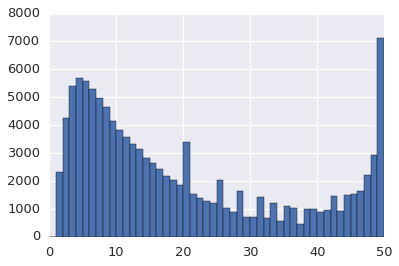

In [945]:
plt.hist(H['bin'],bins =np.arange(0,51,1))[2]

In [941]:
H.shape

(115632, 3)

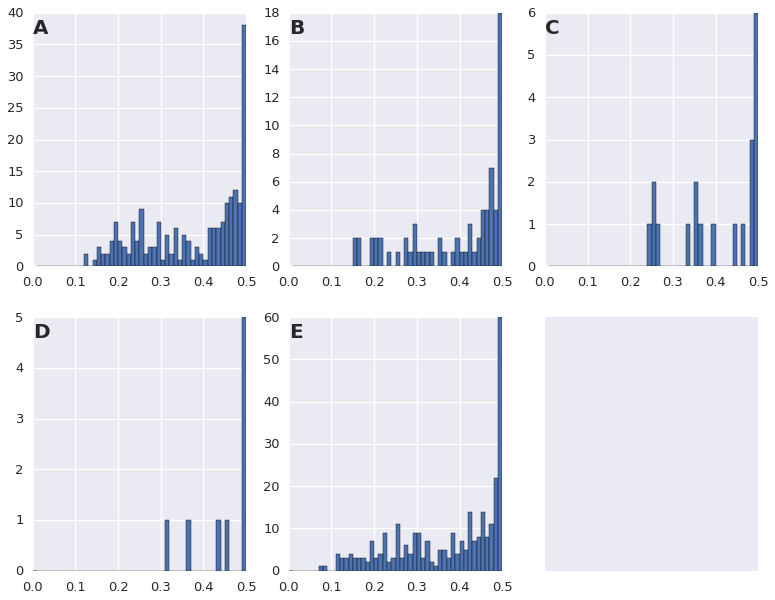

In [972]:
with PdfPages('/home/lindb/wbp/figures/grid_imp_hexp_hist_by_pheno_top_PIPs_top_effects_995.pdf') as pdf:
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6)) = plt.subplots(2, 3, figsize=(5,5),dpi=400)

    a1 = plt.subplot(231)
    a1.hist(outlierdata['bfpopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a1.set_title('A',y=.9,loc='left',fontsize=20,fontweight='bold')
    a1.spines['right'].set_visible(False)
    a1.spines['top'].set_visible(False)
    a1.yaxis.set_ticks_position('left')
    a1.xaxis.set_ticks_position('bottom')
    
    a2 = plt.subplot(232)
    a2.hist(outlierdata['c13popx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a2.set_title('B',y=.9,loc='left',fontsize=20,fontweight='bold')
    a2.spines['right'].set_visible(False)
    a2.spines['top'].set_visible(False)
    a2.yaxis.set_ticks_position('left')
    a2.xaxis.set_ticks_position('bottom')
    
    a3 = plt.subplot(233)
    a3.hist(outlierdata['htpopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a3.set_title('C',y=.9,loc='left',fontsize=20,fontweight='bold')
    a3.spines['right'].set_visible(False)
    a3.spines['top'].set_visible(False)
    a3.yaxis.set_ticks_position('left')
    a3.xaxis.set_ticks_position('bottom')
    
    a4 = plt.subplot(234)
    a4.hist(outlierdata['n15popx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a4.set_title('D',y=.9,loc='left',fontsize=20,fontweight='bold')
    a4.spines['right'].set_visible(False)
    a4.spines['top'].set_visible(False)
    a4.yaxis.set_ticks_position('left')
    a4.xaxis.set_ticks_position('bottom')
    
    a5 = plt.subplot(235)
    a5.hist(outlierdata['rspopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a5.set_title('E',y=.9,loc='left',fontsize=20,fontweight='bold')
    a5.spines['right'].set_visible(False)
    a5.spines['top'].set_visible(False)
    a5.yaxis.set_ticks_position('left')
    a5.xaxis.set_ticks_position('bottom')
    
    a6.spines['right'].set_visible(False)
    a6.spines['left'].set_visible(False)
    a6.spines['top'].set_visible(False)
    a6.spines['bottom'].set_visible(False)
    a6.axes.get_yaxis().set_visible(False)
    a6.axes.get_xaxis().set_ticks([])
    a6.axes.get_yaxis().set_ticks([])
    
    fig.set_size_inches(13,10)
    pdf.savefig(fig,bbox_inches='tight')

In [949]:
#get sets of SNPs to make random draws
nonsigsnps = OrderedDict()
for pheno in outlierdata.keys():
    nonsigs = list(set(H.index.tolist()) - set(outlierdata[pheno].index.tolist()))
    nonsigsnps[pheno] = pd.DataFrame(H[H.index.isin(nonsigs)])
    print len(outlierdata[pheno].index.tolist())+len(nonsigsnps[pheno].index)

115632
115632
115632
115632
115632


In [950]:
#how many random snps to draw from each bin?
binCounter = OrderedDict()
for pheno in outlierdata.keys():
    binCounter[pheno] = Counter()
    for row in outlierdata[pheno].index:
        binCounter[pheno][outlierdata[pheno].loc[row,'bin']] += 1
    for b in binCounter[pheno].keys():
        print pheno,b,binCounter[pheno][b]

bfpopx 12 2
bfpopx 14 1
bfpopx 15 3
bfpopx 16 2
bfpopx 17 2
bfpopx 18 4
bfpopx 19 7
bfpopx 20 6
bfpopx 21 1
bfpopx 22 2
bfpopx 23 7
bfpopx 24 4
bfpopx 25 9
bfpopx 26 2
bfpopx 27 3
bfpopx 28 6
bfpopx 29 4
bfpopx 30 1
bfpopx 31 5
bfpopx 32 2
bfpopx 33 6
bfpopx 34 1
bfpopx 35 5
bfpopx 36 4
bfpopx 37 1
bfpopx 38 3
bfpopx 39 2
bfpopx 40 1
bfpopx 41 6
bfpopx 42 6
bfpopx 43 6
bfpopx 44 7
bfpopx 45 10
bfpopx 46 11
bfpopx 47 12
bfpopx 48 10
bfpopx 49 38
c13popx 15 2
c13popx 16 2
c13popx 19 2
c13popx 20 4
c13popx 23 1
c13popx 25 1
c13popx 27 2
c13popx 28 2
c13popx 29 2
c13popx 30 1
c13popx 31 1
c13popx 32 1
c13popx 33 1
c13popx 35 2
c13popx 36 1
c13popx 38 1
c13popx 39 2
c13popx 40 1
c13popx 41 1
c13popx 42 3
c13popx 43 1
c13popx 44 2
c13popx 45 4
c13popx 46 4
c13popx 47 7
c13popx 48 4
c13popx 49 18
htpopx 33 1
htpopx 35 2
htpopx 36 1
htpopx 39 1
htpopx 44 1
htpopx 46 1
htpopx 48 3
htpopx 49 6
htpopx 24 1
htpopx 25 2
htpopx 26 1
n15popx 49 5
n15popx 43 1
n15popx 36 1
n15popx 45 1
n15popx 31 1
rs

In [951]:
os.makedirs('/home/lindb/wbp/gemma/covariances_total_effect_995/randmatrices')
os.makedirs('/home/lindb/wbp/gemma/covariances_total_effect_995/randmatrices/randsnps')

In [952]:
for pheno in outlierdata.keys():
    print pheno,len(outlierdata[pheno].index)

bfpopx 202
c13popx 73
htpopx 20
n15popx 9
rspopx 292


In [953]:
#for each pheno make 1000 dataframes with a set of snps == len(outliersnps[pheno])
for pheno in outlierdata.keys():
    print pheno
    for i in range(1000):  
        snps = []        
        for binn in binCounter[pheno].keys():
            data = nonsigsnps[pheno][nonsigsnps[pheno]['bin'] == binn]
                
            [snps.append(snp) for snp in random.sample(data.index,binCounter[pheno][binn])]
        
        assert len(np.unique(snps).tolist()) == sum(binCounter[pheno].values())

        DIR = '/home/lindb/wbp/gemma/covariances_total_effect_995/randmatrices/randsnps/%s' % pheno
        if not op.exists(DIR):
            os.makedirs(DIR)
        filE = op.join(DIR,"%s_%s_randsnps.txt" % (pheno,str(i).zfill(3)))
        df = pd.DataFrame(snps)
        df.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
c13popx
htpopx
n15popx
rspopx


In [960]:
#quicker to do it this way
#get dvals for the sets of random snps for each pheno
for pheno in outlierdata.keys():
    for i in range(1000):
        text = '''from __future__ import division
import os
from collections import OrderedDict,Counter
import pandas as pd
import numpy as np
import random
import math
from os import path as op
from os import listdir as ls


#get a dict with num indiv in pop
#population sizes (only for individuals in pops with phenotypic measurements)
popDict = {'Dicks_Pass':15,
'Freel_Peak':19,
'Little_Round_Top':14,
'Mt_Rose_Ophir':11,
'Rifle_Peak':15,
'Snow_Valley_Peak':14,}


filE = '/home/lindb/wbp/gemma/6pop_glob_mafs.txt'
globs = pd.read_csv(filE,header=0,sep='\\t')
glob = OrderedDict()
for row in globs.index:
    snp = globs.loc[row,'locus']
    maf = globs.loc[row,'maf']
    glob[snp] = maf

impMAF = pd.read_csv('/home/lindb/wbp/gemma/6pop_pop_maf.txt',header=0,index_col=0,sep="\\t")

filE= '/home/lindb/wbp/gemma/covariances_total_effect_995/randmatrices/randsnps/%s/%s_%s_randsnps.txt' 
df = pd.read_csv(filE,header=None,sep="\\t")
randomsnps = df[0].tolist()

dijDict = OrderedDict() 
for i,locusi in enumerate(randomsnps):
    dijDict[locusi] = OrderedDict()
    qi = glob[locusi] #global maf

    for j,locusj in enumerate(randomsnps):
        if i > j: #i=row, j=col : lower triangle 
            qj = glob[locusj] #global maf

            sums = 0
            for pop in impMAF.columns:
                qik = impMAF.loc[locusi,pop] #get pop maf
                qjk = impMAF.loc[locusj,pop] #get pop maf
                nk = popDict[pop]

                sums += (nk/88)*((qik*qjk)-(qi*qj))

            dijDict[locusi][locusj] = sums
        else:
            dijDict[locusi][locusj] = np.nan

filE = '/home/lindb/wbp/gemma/covariances_total_effect_995/randmatrices/randDVALS/%s/%s_%s_randDVALS.txt'
if not op.exists('/home/lindb/wbp/gemma/covariances_total_effect_995/randmatrices/randDVALS/'):
    os.makedirs('/home/lindb/wbp/gemma/covariances_total_effect_995/randmatrices/randDVALS/')
DIR = op.dirname(filE)
if not op.exists(DIR):
    os.makedirs(DIR)

with open(filE,'w') as o:
    key0 = dijDict.keys()[0]
    line = '\\t'.join(dijDict[key0].keys()) + str('\\n')
    o.write("%%s" %% line)
    for locusi in dijDict.keys():
        line = str(locusi)+'\\t'+'\\t'.join([str(x) for x in dijDict[locusi].values()]) + str('\\n')
        o.write("%%s" %% line)
        
''' % (pheno,pheno,str(i).zfill(3),
       pheno,pheno,str(i).zfill(3))
        filE = '/home/lindb/wbp/gemma/covariances_total_effect_995/randmatrices/randpyfiles/get_rand_dvals_%s_%s.py' % (pheno,
                                                                                                      str(i).zfill(3)
                                                                                                     )
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [961]:
#get the python scripts
DIR = '/home/lindb/wbp/gemma/covariances_total_effect_995/randmatrices/randpyfiles/'
pyfiles = [op.join(DIR,f) for f in ls(DIR)]
len(pyfiles)

5000

In [962]:
#spread out the jobs across 25 files
#5000/25=200
count = 0
fcount = 0
for f in sorted(pyfiles):
    if count == 0:
        text = 'python %s\n' % f
    else:
        newtext = 'python %s\n' % f
        text = text + newtext
    count += 1
    if count == 200:
        count = 0
        fcount += 1
        filE = '/home/lindb/wbp/gemma/covariances_total_effect_995/randmatrices/runpyfiles/%s_cmds.txt' % str(fcount).zfill(3)
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [964]:
#make 125 qsub files
for i in range(25):
    j = i+1
    text = '''#!/bin/bash
#$ -N pyfile%s
#$ -V
#$ -j y
#$ -cwd

cat %s_cmds.txt | parallel --progress --

''' % (str(j).zfill(3),
       str(j).zfill(3)
      )
    filE = '/home/lindb/wbp/gemma/covariances_total_effect_995/randmatrices/runpyfiles/%s_run.sh' % str(j).zfill(3)
    with open(filE,'w') as o:
        o.write("%s" % text)

In [ ]:
#qsub the qsubs

In [965]:
#check on progress
DIR = '/home/lindb/wbp/gemma/covariances_total_effect_995/randmatrices/randDVALS/'
ds = [op.join(DIR,d) for d in ls(DIR)]
count = 0
for DIR in ds:
    count = count + len(ls(DIR))
count

5000

In [967]:
#double check data
for pheno in outlierdata.keys():
    print pheno, len(outlierdata[pheno].index),len(snpdict995[pheno])

 bfpopx 202 202
c13popx 73 73
htpopx 20 20
n15popx 9 9
rspopx 292 292


In [968]:
# get observed dvals
dvals = OrderedDict()
medvals = OrderedDict()
for pheno in outlierdata.keys():
    print pheno
    DF = pd.read_csv('/home/lindb/wbp/gemma/covariances_total_effect_995/dvals/%s_dvals.txt' % pheno,
                     header=0,index_col=0,sep="\t")
    dvals[pheno] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[pheno].append(abs(DF.loc[row,col]))

    DIR = '/home/lindb/wbp/gemma/covariances_total_effect_995/randmatrices/randDVALS/%s/' % pheno
    files = [op.join(DIR,f) for f in ls(DIR)]

    fcount = 0
    medvals[pheno] = []
    for f in files:
        df = pd.read_csv(f,header=0,index_col=0,sep="\t")
        rvals = [] #random dij values
        for lst in df.values.tolist():
            for x in lst:
                if math.isnan(x) == False:
                    rvals.append(x)


        medvals[pheno].append(np.median([abs(val) for val in rvals]))

        fcount += 1
        if fcount % 100 == 0:
            print fcount

    filE = '/home/lindb/wbp/gemma/covariances_total_effect_995/randmatrices/randmedvals/%s_randmedvalues.txt' % pheno
    if not op.exists(op.dirname(filE)):
        os.makedirs(op.dirname(filE))
    medvaldf = pd.DataFrame(medvals[pheno])
    medvaldf.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
100
200
300
400
500
600
700
800
900
1000
c13popx
100
200
300
400
500
600
700
800
900
1000
htpopx
100
200
300
400
500
600
700
800
900
1000
n15popx
100
200
300
400
500
600
700
800
900
1000
rspopx
100
200
300
400
500
600
700
800
900
1000


In [975]:
#in case I restart my notebook
medvals = {}
for pheno in outlierdata.keys():
    print pheno
    DF = pd.read_csv('/home/lindb/wbp/gemma/covariances_total_effect_995/dvals/%s_dvals.txt' % pheno,
                     header=0,index_col=0,sep="\t")
    dvals[pheno] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[pheno].append(abs(DF.loc[row,col]))
    filE = '/home/lindb/wbp/gemma/covariances_total_effect_995/randmatrices/randmedvals/%s_randmedvalues.txt' % pheno
    df = pd.read_csv(filE,header=None,sep='\t')
    medvals[pheno] = df[0].tolist()

bfpopx
c13popx
htpopx
n15popx
rspopx


In [976]:
n5th = OrderedDict()    #get 95th percentile
gt_hth = OrderedDict()  #how much greater is the empirical median dvalue than the 100th percentile of random SNPs?
gt_n5th = OrderedDict() #how much greater is the empirical median dvalue than the 95th percentile of random SNPs?
bmax=OrderedDict()      #below what percentile of the observed dvals are the values less than the maximum randdvals
bn5th = OrderedDict()   #below what percentile of the observed dvals are the values less than the 95th perc randdvals
for pheno in outlierdata.keys():
    print pheno,'has',len(snpdict995[pheno]),'SNPs in intersection of top PIPs and top effects (alpha+beta)'
    sorts        = sorted(medvals[pheno])
    n5th[pheno]    = sorts[949]
    gt_hth[pheno]  = np.median(dvals[pheno])/max(medvals[pheno])
    print 'emp median is %sx greater than 100th percentile of random'%str(round(gt_hth[pheno],3))
    gt_n5th[pheno] = np.median(dvals[pheno])/n5th[pheno]
    print 'emp median is %sx greater than 95th percentile of random'%str(round(gt_n5th[pheno],3))
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < max(sorts): #the max(randDval) corresponds to the xth percentile of empirical d-values
            bmax[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < sorts[949]:
            bn5th[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    print 'the max random value corresponds to the %s precentile' % str(round(bmax[pheno][1],3)*100),"(%s/%s)" % (bmax[pheno][0],len(dvals[pheno])),'of emp values'
    print 'the 95th perc rand val corresponds to the %s percentile',str(round(bn5th[pheno][1],3)*100),"(%s/%s)" % (bn5th[pheno][0],len(dvals[pheno])),'of emp values'
    print 'emp med dval =',"{:.4}".format(np.median(dvals[pheno]))
    print 'max rand dval =',"{:.4}".format(max(medvals[pheno]))
    print '95th rand dval =',"{:.4}".format(n5th[pheno])
    print '\n' 

bfpopx has 202 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.935x greater than 100th percentile of random
emp median is 1.094x greater than 95th percentile of random
the max random value corresponds to the 51.9 precentile (10544/20301) of emp values
the 95th perc rand val corresponds to the %s percentile 47.4 (9622/20301) of emp values
emp med dval = 0.002617
max rand dval = 0.002798
95th rand dval = 0.002391


c13popx has 73 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.838x greater than 100th percentile of random
emp median is 1.106x greater than 95th percentile of random
the max random value corresponds to the 54.1 precentile (1421/2628) of emp values
the 95th perc rand val corresponds to the %s percentile 47.7 (1254/2628) of emp values
emp med dval = 0.003803
max rand dval = 0.004539
95th rand dval = 0.003437


htpopx has 20 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.584x greater than

# covariance among top PIPs

In [85]:
effect_snps = {}
for pheno in phenos:
    d = combined_dfs[pheno]
    x = 'gamma_hmean'
    effect_snps[pheno] = {}
    for q in [0.999]:
        x99_cutoff = d[x].quantile(q)
        xvals = d[x][d[x] >= x99_cutoff] 
        effect_snps[pheno][q] = xvals.index

In [699]:
for pheno in effect_snps.keys():
    for q in effect_snps[pheno].keys():
        print pheno,q,len(effect_snps[pheno][q])

rspopx 0.999 117
rspopx 0.995 580
bfpopx 0.999 118
bfpopx 0.995 599
c13popx 0.999 122
c13popx 0.995 595
n15popx 0.999 117
n15popx 0.995 580
htpopx 0.999 117
htpopx 0.995 584


In [700]:
outdir

'/home/lindb/wbp/gemma/infiles/bslmm/output/'

In [466]:
with open(os.path.join(outdir, "effect_snps_top_PIPs_50mil.pkl"), "wb") as o:
    pickle.dump(effect_snps, o, pickle.HIGHEST_PROTOCOL)

In [470]:
#write out the files
for pheno in effect_snps.keys():
    for q in effect_snps[pheno].keys():
        out = op.join(outdir,"%s_effect_top_PIPs_50mil.txt" % "-".join([pheno,str(q)]))
        with open(out,'w') as o:
            o.write("\n".join(effect_snps[pheno][q]))

In [113]:
toppips = {}
x = 'gamma_hmean'
q = 0.999
for pheno in phenos:
    d = combined_dfs[pheno]
    cutoff = d[x].quantile(q)
    xvals = d[x][d[x]>=cutoff]
    toppips[pheno] = xvals.index
    print pheno,len(toppips[pheno])

bfpopx 118
c13popx 122
htpopx 117
n15popx 117
rspopx 119


In [106]:
rc = Client(profile="xmn")
dview = rc[:]
lview = rc.load_balanced_view()
len(lview)

47

In [509]:
op.makedirs("/home/lindb/wbp/gemma/covariances_top_PIPs/")

In [46]:
#do pairwise to get Dij
def get_dijdict(tokens):
    from collections import OrderedDict
    from os import path as op
    from os import listdir as ls
    import os
    import numpy as np
    import pandas as pd
    
    pheno,outliersnps,glob,mafDict,popDict = tokens
    dijDict = OrderedDict() 
    dijDict[pheno] = OrderedDict() 
    for i,locusi in enumerate(outliersnps):
        dijDict[pheno][locusi] = OrderedDict()
        qi = glob[locusi] #global maf

        for j,locusj in enumerate(outliersnps):
            if i > j: #i=row, j=col : lower triangle 
                qj = glob[locusj] #global maf

                sums = 0
                for pop in popDict.keys():
                    qik = mafDict[locusi][pop] #get pop maf
                    qjk = mafDict[locusj][pop] #get pop maf
                    nk = popDict[pop]

                    sums += (float(nk)/float(88))*((qik*qjk)-(qi*qj))

                dijDict[pheno][locusi][locusj] = sums
            else:
                dijDict[pheno][locusi][locusj] = np.nan
    #write out the file
    for pheno in dijDict.keys():
        filE = '/home/lindb/wbp/gemma/covariances_top_PIPs/dvals/%s_dvals.txt' % pheno
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            key0 = dijDict[pheno].keys()[0]
            line = '\t'.join(dijDict[pheno][key0].keys()) + str('\n')
            o.write("%s" % line)
            for locusi in dijDict[pheno].keys():
                line = str(locusi)+'\t'+'\t'.join([str(x) for x in dijDict[pheno][locusi].values()]) + str('\n')
                o.write("%s" % line)

In [116]:
jobs = []
for pheno in toppips.keys():
    print pheno
    jobs.append(lview.apply_async(get_dijdict,[pheno,toppips[pheno],glob,mafDict,popsizeDict]))

rspopx
bfpopx
c13popx
n15popx
htpopx


In [119]:
for j in jobs:
    if j.ready():
        print j.r

None
None
None
None
None


In [120]:
DIR = '/home/lindb/wbp/gemma/covariances_top_PIPs/dvals'
files = [op.join(DIR,f) for f in ls(DIR)]
dijDict = OrderedDict()
for f in sorted(files):
    pheno = op.basename(f).split("_")[0]
    dijDict[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')
dijDict[pheno].head()

NODE_1002798_length_96_cov_1.708333_69  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                 0.015655   
NODE_1005005_length_97_cov_1.041237_100                                0.009373   
NODE_1006116_length_110_cov_1.718182_68                               -0.008239   
NODE_1022519_length_94_cov_1.712766_68                                -0.010523   

                                         NODE_1004353_length_98_cov_6.795918_59  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                0.008958   
NODE_1006116_length_110_cov_1.718182_68                               -0.004896   
NODE_1022519_length_94_cov_1.712766_68                                -0.008004   

                                         NODE_1005005_length_97_cov_1.041237_100  \
NODE_1002798_length_96_cov_1.708333_69                                       NaN   
NODE_1004353_length_98_cov_6.795918_59                                       NaN   
NODE_1005005_length_97_cov_1.041237_100                                      NaN   
NODE_1006116_length_110_cov_1.718182_68                                -0.013103   
NODE_1022519_length_94_cov_1.712766_68                                 -0.007492   

                                         NODE_1006116_length_110_cov_1.718182_68  \
NODE_1002798_length_96_cov_1.708333_69                                       NaN   
NODE_1004353_length_98_cov_6.795918_59                                       NaN   
NODE_1005005_length_97_cov_1.041237_100                                      NaN   
NODE_1006116_length_110_cov_1.718182_68                                      NaN   
NODE_1022519_length_94_cov_1.712766_68                                  0.005599   

                                         NODE_1022519_length_94_cov_1.712766_68  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   

                                         NODE_1043532_length_95_cov_2.000000_10  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   

                                         NODE_1051747_length_64_cov_1.328125_30  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   

                                         NODE_1059708_length_68_cov_1.073529_68  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   

                                     

In [50]:
for pheno in dijDict.keys():
    print pheno,len(dijDict[pheno].columns)

bfpopx 118
c13popx 122
htpopx 117
n15popx 117
rspopx 117


In [542]:
H.head()

locus  \
NODE_1000013_length_91_cov_1.802198_37    NODE_1000013_length_91_cov_1.802198_37   
NODE_1000031_length_98_cov_2.000000_30    NODE_1000031_length_98_cov_2.000000_30   
NODE_1000037_length_93_cov_2.043011_33    NODE_1000037_length_93_cov_2.043011_33   
NODE_1000042_length_93_cov_1.118280_100  NODE_1000042_length_93_cov_1.118280_100   
NODE_1000053_length_94_cov_1.744681_25    NODE_1000053_length_94_cov_1.744681_25   

                                            H_exp  bin  
NODE_1000013_length_91_cov_1.802198_37   0.259749   25  
NODE_1000031_length_98_cov_2.000000_30   0.259749   25  
NODE_1000037_length_93_cov_2.043011_33   0.174522   17  
NODE_1000042_length_93_cov_1.118280_100  0.033510    3  
NODE_1000053_length_94_cov_1.744681_25   0.055204    5

In [678]:
#get a dataframe with the outlier loci and their bins
outlierdata = OrderedDict()
for pheno in dijDict.keys():
    print pheno,len(toppips[pheno])
    outliersnps = toppips[pheno]

    outlierdata[pheno] = pd.DataFrame(H[H.index.isin(outliersnps)])

bfpopx 118
c13popx 122
htpopx 117
n15popx 117
rspopx 117


In [679]:
len(outlierdata[pheno].index)

117

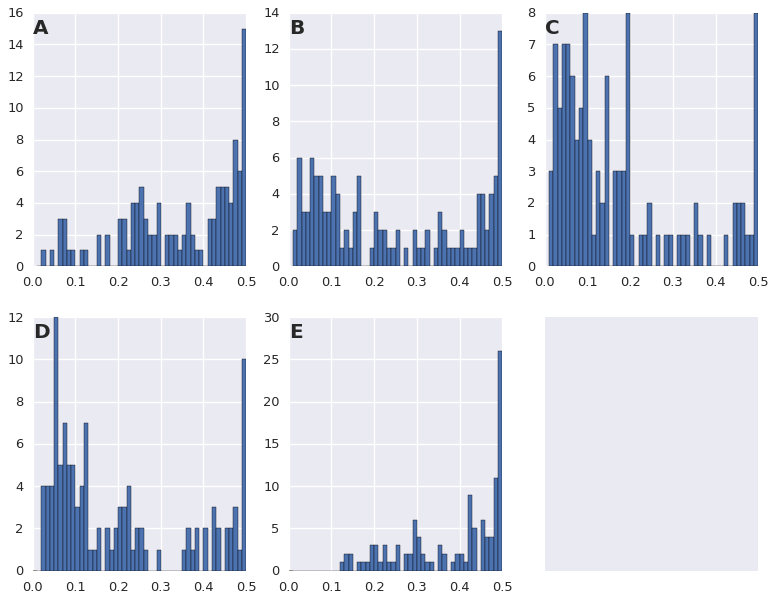

In [680]:
with PdfPages('/home/lindb/wbp/figures/grid_imp_hexp_hist_by_pheno_top_PIPs.pdf') as pdf:
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6)) = plt.subplots(2, 3, figsize=(5,5),dpi=400)

    a1 = plt.subplot(231)
    a1.hist(outlierdata['bfpopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a1.set_title('A',y=.9,loc='left',fontsize=20,fontweight='bold')
    a1.spines['right'].set_visible(False)
    a1.spines['top'].set_visible(False)
    a1.yaxis.set_ticks_position('left')
    a1.xaxis.set_ticks_position('bottom')
    
    a2 = plt.subplot(232)
    a2.hist(outlierdata['c13popx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a2.set_title('B',y=.9,loc='left',fontsize=20,fontweight='bold')
    a2.spines['right'].set_visible(False)
    a2.spines['top'].set_visible(False)
    a2.yaxis.set_ticks_position('left')
    a2.xaxis.set_ticks_position('bottom')
    
    a3 = plt.subplot(233)
    a3.hist(outlierdata['htpopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a3.set_title('C',y=.9,loc='left',fontsize=20,fontweight='bold')
    a3.spines['right'].set_visible(False)
    a3.spines['top'].set_visible(False)
    a3.yaxis.set_ticks_position('left')
    a3.xaxis.set_ticks_position('bottom')
    
    a4 = plt.subplot(234)
    a4.hist(outlierdata['n15popx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a4.set_title('D',y=.9,loc='left',fontsize=20,fontweight='bold')
    a4.spines['right'].set_visible(False)
    a4.spines['top'].set_visible(False)
    a4.yaxis.set_ticks_position('left')
    a4.xaxis.set_ticks_position('bottom')
    
    a5 = plt.subplot(235)
    a5.hist(outlierdata['rspopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a5.set_title('E',y=.9,loc='left',fontsize=20,fontweight='bold')
    a5.spines['right'].set_visible(False)
    a5.spines['top'].set_visible(False)
    a5.yaxis.set_ticks_position('left')
    a5.xaxis.set_ticks_position('bottom')
    
    a6.spines['right'].set_visible(False)
    a6.spines['left'].set_visible(False)
    a6.spines['top'].set_visible(False)
    a6.spines['bottom'].set_visible(False)
    a6.axes.get_yaxis().set_visible(False)
    a6.axes.get_xaxis().set_ticks([])
    a6.axes.get_yaxis().set_ticks([])
    
    fig.set_size_inches(13,10)
    pdf.savefig(fig,bbox_inches='tight')

In [682]:
#get sets of SNPs to make random draws
nonsigsnps = OrderedDict()
for pheno in outlierdata.keys():
    nonsigs = list(set(H.index.tolist()) - set(outlierdata[pheno].index.tolist()))
    nonsigsnps[pheno] = pd.DataFrame(H[H.index.isin(nonsigs)])
    print len(outlierdata[pheno].index.tolist())+len(nonsigsnps[pheno].index)

115632
115632
115632
115632
115632


In [683]:
#how many random snps to draw from each bin?
binCounter = OrderedDict()
for pheno in outlierdata.keys():
    binCounter[pheno] = Counter()
    for row in outlierdata[pheno].index:
        binCounter[pheno][outlierdata[pheno].loc[row,'bin']] += 1
    for b in binCounter[pheno].keys():
        print pheno,b,binCounter[pheno][b]

bfpopx 2 1
bfpopx 4 1
bfpopx 6 3
bfpopx 7 3
bfpopx 8 1
bfpopx 9 1
bfpopx 11 1
bfpopx 12 1
bfpopx 15 2
bfpopx 17 2
bfpopx 20 5
bfpopx 21 1
bfpopx 22 1
bfpopx 23 4
bfpopx 24 4
bfpopx 25 5
bfpopx 26 3
bfpopx 27 2
bfpopx 28 5
bfpopx 29 1
bfpopx 31 2
bfpopx 32 2
bfpopx 33 2
bfpopx 34 1
bfpopx 35 2
bfpopx 36 4
bfpopx 37 2
bfpopx 38 1
bfpopx 39 1
bfpopx 41 3
bfpopx 42 3
bfpopx 43 5
bfpopx 44 5
bfpopx 45 5
bfpopx 46 4
bfpopx 47 8
bfpopx 48 6
bfpopx 49 15
c13popx 1 2
c13popx 2 6
c13popx 3 3
c13popx 4 3
c13popx 5 6
c13popx 6 5
c13popx 7 5
c13popx 8 3
c13popx 9 3
c13popx 10 5
c13popx 11 4
c13popx 12 1
c13popx 13 2
c13popx 14 1
c13popx 15 3
c13popx 16 5
c13popx 19 1
c13popx 20 3
c13popx 21 2
c13popx 22 2
c13popx 23 1
c13popx 24 1
c13popx 25 2
c13popx 27 1
c13popx 29 2
c13popx 30 1
c13popx 31 1
c13popx 32 2
c13popx 34 1
c13popx 35 3
c13popx 36 2
c13popx 37 1
c13popx 38 1
c13popx 39 1
c13popx 40 2
c13popx 41 1
c13popx 42 1
c13popx 43 1
c13popx 44 4
c13popx 45 4
c13popx 46 2
c13popx 47 4
c13popx 48 5

In [554]:
os.makedirs('/home/lindb/wbp/gemma/covariances_top_PIPs/randmatrices')
os.makedirs('/home/lindb/wbp/gemma/covariances_top_PIPs/randmatrices/randsnps')

In [684]:
for pheno in outlierdata.keys():
    print pheno,len(outlierdata[pheno].index)

bfpopx 118
c13popx 122
htpopx 117
n15popx 117
rspopx 117


In [685]:
#for each pheno make 1000 dataframes with a set of snps == len(outliersnps[pheno])
for pheno in outlierdata.keys():
    print pheno
    for i in range(1000):  
        snps = []        
        for binn in binCounter[pheno].keys():
            data = nonsigsnps[pheno][nonsigsnps[pheno]['bin'] == binn]
                
            [snps.append(snp) for snp in random.sample(data.index,binCounter[pheno][binn])]
        
        assert len(np.unique(snps).tolist()) == sum(binCounter[pheno].values())

        DIR = '/home/lindb/wbp/gemma/covariances_top_PIPs/randmatrices/randsnps/%s' % pheno
        if not op.exists(DIR):
            os.makedirs(DIR)
        filE = op.join(DIR,"%s_%s_randsnps.txt" % (pheno,str(i).zfill(3)))
        df = pd.DataFrame(snps)
        df.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
c13popx
htpopx
n15popx
rspopx


In [686]:
#quicker to do it this way
#get dvals for the sets of random snps for each pheno
for pheno in outlierdata.keys():
    for i in range(1000):
        text = '''from __future__ import division
import os
from collections import OrderedDict,Counter
import pandas as pd
import numpy as np
import random
import math
from os import path as op
from os import listdir as ls


#get a dict with num indiv in pop
#population sizes (only for individuals in pops with phenotypic measurements)
popDict = {'Dicks_Pass':15,
'Freel_Peak':19,
'Little_Round_Top':14,
'Mt_Rose_Ophir':11,
'Rifle_Peak':15,
'Snow_Valley_Peak':14,}


filE = '/home/lindb/wbp/gemma/6pop_glob_mafs.txt'
globs = pd.read_csv(filE,header=0,sep='\\t')
glob = OrderedDict()
for row in globs.index:
    snp = globs.loc[row,'locus']
    maf = globs.loc[row,'maf']
    glob[snp] = maf

impMAF = pd.read_csv('/home/lindb/wbp/gemma/6pop_pop_maf.txt',header=0,index_col=0,sep="\\t")

filE= '/home/lindb/wbp/gemma/covariances_top_PIPs/randmatrices/randsnps/%s/%s_%s_randsnps.txt' 
df = pd.read_csv(filE,header=None,sep="\\t")
randomsnps = df[0].tolist()

dijDict = OrderedDict() 
for i,locusi in enumerate(randomsnps):
    dijDict[locusi] = OrderedDict()
    qi = glob[locusi] #global maf

    for j,locusj in enumerate(randomsnps):
        if i > j: #i=row, j=col : lower triangle 
            qj = glob[locusj] #global maf

            sums = 0
            for pop in impMAF.columns:
                qik = impMAF.loc[locusi,pop] #get pop maf
                qjk = impMAF.loc[locusj,pop] #get pop maf
                nk = popDict[pop]

                sums += (nk/88)*((qik*qjk)-(qi*qj))

            dijDict[locusi][locusj] = sums
        else:
            dijDict[locusi][locusj] = np.nan

filE = '/home/lindb/wbp/gemma/covariances_top_PIPs/randmatrices/randDVALS/%s/%s_%s_randDVALS.txt'
if not op.exists('/home/lindb/wbp/gemma/covariances_top_PIPs/randmatrices/randDVALS/'):
    os.makedirs('/home/lindb/wbp/gemma/covariances_top_PIPs/randmatrices/randDVALS/')
DIR = op.dirname(filE)
if not op.exists(DIR):
    os.makedirs(DIR)

with open(filE,'w') as o:
    key0 = dijDict.keys()[0]
    line = '\\t'.join(dijDict[key0].keys()) + str('\\n')
    o.write("%%s" %% line)
    for locusi in dijDict.keys():
        line = str(locusi)+'\\t'+'\\t'.join([str(x) for x in dijDict[locusi].values()]) + str('\\n')
        o.write("%%s" %% line)
        
''' % (pheno,pheno,str(i).zfill(3),
       pheno,pheno,str(i).zfill(3))
        filE = '/home/lindb/wbp/gemma/covariances_top_PIPs/randmatrices/randpyfiles/get_rand_dvals_%s_%s.py' % (pheno,
                                                                                                      str(i).zfill(3)
                                                                                                     )
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [52]:
DIR = '/home/lindb/wbp/gemma/covariances_top_PIPs/randmatrices/randpyfiles/'
pyfiles = [op.join(DIR,f) for f in ls(DIR)]
len(pyfiles)

5000

In [54]:
#spread out the jobs across 25 files
count = 0
fcount = 0
for f in sorted(pyfiles):
    if count == 0:
        text = 'python %s\n' % f
    else:
        newtext = 'python %s\n' % f
        text = text + newtext
    count += 1
    if count == 200:
        count = 0
        fcount += 1
        filE = '/home/lindb/wbp/gemma/covariances_top_PIPs/randmatrices/runpyfiles/%s_cmds.txt' % str(fcount).zfill(3)
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [55]:
#make 125 qsub files
for i in range(25):
    j = i+1
    text = '''#!/bin/bash
#$ -N pyfile%s
#$ -V
#$ -j y
#$ -cwd

cat %s_cmds.txt | parallel --progress --

''' % (str(j).zfill(3),
       str(j).zfill(3)
      )
    filE = '/home/lindb/wbp/gemma/covariances_top_PIPs/randmatrices/runpyfiles/%s_run.sh' % str(j).zfill(3)
    with open(filE,'w') as o:
        o.write("%s" % text)

In [ ]:
#qsub the qsubs

In [66]:
#check on progress
DIR = '/home/lindb/wbp/gemma/covariances_top_PIPs/randmatrices/randDVALS/'
ds = [op.join(DIR,d) for d in ls(DIR)]
count = 0
for DIR in ds:
    count = count + len(ls(DIR))
count

5000

In [69]:
phenos = ['bfpopx','c13popx','htpopx','n15popx','rspopx']

In [121]:
# get observed dvals
dvals = OrderedDict()
medvals = OrderedDict()
for pheno in phenos:
    print pheno
    DF = pd.read_csv('/home/lindb/wbp/gemma/covariances_top_PIPs/dvals/%s_dvals.txt' % pheno,
                     header=0,index_col=0,sep="\t")
    dvals[pheno] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[pheno].append(abs(DF.loc[row,col]))

    DIR = '/home/lindb/wbp/gemma/covariances_top_PIPs/randmatrices/randDVALS/%s/' % pheno
    files = [op.join(DIR,f) for f in ls(DIR)]

    fcount = 0
    medvals[pheno] = []
    for f in files:
        df = pd.read_csv(f,header=0,index_col=0,sep="\t")
        rvals = [] #random dij values
        for lst in df.values.tolist():
            for x in lst:
                if math.isnan(x) == False:
                    rvals.append(x)


        medvals[pheno].append(np.median([abs(val) for val in rvals]))

        fcount += 1
        if fcount % 100 == 0:
            print fcount

    filE = '/home/lindb/wbp/gemma/covariances_top_PIPs/randmatrices/randmedvals/%s_randmedvalues.txt' % pheno
    if not op.exists(op.dirname(filE)):
        os.makedirs(op.dirname(filE))
    medvaldf = pd.DataFrame(medvals[pheno])
    medvaldf.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
100
200
300
400
500
600
700
800
900
1000
c13popx
100
200
300
400
500
600
700
800
900
1000
htpopx
100
200
300
400
500
600
700
800
900
1000
n15popx
100
200
300
400
500
600
700
800
900
1000
rspopx
100
200
300
400
500
600
700
800
900
1000


In [977]:
#in case I restart my notebook
medvals = {}
for pheno in outlierdata.keys():
    print pheno
    DF = pd.read_csv('/home/lindb/wbp/gemma/covariances_top_PIPs/dvals/%s_dvals.txt' % pheno,
                     header=0,index_col=0,sep="\t")
    dvals[pheno] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[pheno].append(abs(DF.loc[row,col]))
    filE = '/home/lindb/wbp/gemma/covariances_top_PIPs/randmatrices/randmedvals/%s_randmedvalues.txt' % pheno
    df = pd.read_csv(filE,header=None,sep='\t')
    medvals[pheno] = df[0].tolist()

bfpopx
c13popx
htpopx
n15popx
rspopx


In [122]:
n5th = OrderedDict()    #get 95th percentile
gt_hth = OrderedDict()  #how much greater is the empirical median dvalue than the 100th percentile of random SNPs?
gt_n5th = OrderedDict() #how much greater is the empirical median dvalue than the 95th percentile of random SNPs?
bmax=OrderedDict()      #below what percentile of the observed dvals are the values less than the maximum randdvals
bn5th = OrderedDict()   #below what percentile of the observed dvals are the values less than the 95th perc randdvals
for pheno in phenos:
    print pheno,'has',len(toppips[pheno]),'SNPs in top PIPs (gamma)'
    sorts        = sorted(medvals[pheno])
    n5th[pheno]    = sorts[949]
    gt_hth[pheno]  = np.median(dvals[pheno])/max(medvals[pheno])
    print 'emp median is %sx greater than 100th percentile of random'%str(round(gt_hth[pheno],3))
    gt_n5th[pheno] = np.median(dvals[pheno])/n5th[pheno]
    print 'emp median is %sx greater than 95th percentile of random'%str(round(gt_n5th[pheno],3))
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < max(sorts): #the max(randDval) corresponds to the xth percentile of empirical d-values
            bmax[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < sorts[949]:
            bn5th[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    print 'the max random value corresponds to the %s precentile' % str(round(bmax[pheno][1],3)*100),"(%s/%s)" % (bmax[pheno][0],len(dvals[pheno])),'of emp values'
    print 'the 95th perc rand val corresponds to the %s percentile',str(round(bn5th[pheno][1],3)*100),"(%s/%s)" % (bn5th[pheno][0],len(dvals[pheno])),'of emp values'
    print 'emp med dval =',"{:.4}".format(np.median(dvals[pheno]))
    print 'max rand dval =',"{:.4}".format(max(medvals[pheno]))
    print '95th rand dval =',"{:.4}".format(n5th[pheno])
    print '\n' 

bfpopx has 118 SNPs in top PIPs (gamma)
emp median is 0.916x greater than 100th percentile of random
emp median is 1.074x greater than 95th percentile of random
the max random value corresponds to the 53.2 precentile (3669/6903) of emp values
the 95th perc rand val corresponds to the %s percentile 47.5 (3280/6903) of emp values
emp med dval = 0.001398
max rand dval = 0.001526
95th rand dval = 0.001302


c13popx has 122 SNPs in top PIPs (gamma)
emp median is 0.776x greater than 100th percentile of random
emp median is 0.875x greater than 95th percentile of random
the max random value corresponds to the 58.6 precentile (4326/7381) of emp values
the 95th perc rand val corresponds to the %s percentile 54.9 (4050/7381) of emp values
emp med dval = 0.0006457
max rand dval = 0.0008326
95th rand dval = 0.0007381


htpopx has 117 SNPs in top PIPs (gamma)
emp median is 0.841x greater than 100th percentile of random
emp median is 0.958x greater than 95th percentile of random
the max random value 

In [ ]:
#I moved the /covariances directory to /covariances_top_PIPs

# covariance of top 0.998 PIPs

In [76]:
combined_dfs['bfpopx'].head()

rs  alpha_hmean  beta_hmean  \
0   NODE_1000013_length_91_cov_1.802198_37     0.000018    0.000751   
1   NODE_1000031_length_98_cov_2.000000_30     0.000008    0.018813   
2   NODE_1000037_length_93_cov_2.043011_33     0.000012    0.004933   
3  NODE_1000042_length_93_cov_1.118280_100     0.000006    0.002573   
4   NODE_1000053_length_94_cov_1.744681_25     0.000058    0.031942   

   gamma_hmean  total_effect  model_averaged  
0      0.00118      0.000770        0.000019  
1      0.00181      0.018821        0.000042  
2      0.00146      0.004945        0.000019  
3      0.00146      0.002579        0.000010  
4      0.00171      0.032000        0.000112

In [80]:
pip998 = {}
x = 'gamma_hmean'
q = 0.998
for pheno in phenos:
    d = combined_dfs[pheno]
    cutoff = d[x].quantile(q)
    xvals = d[x][d[x]>=cutoff]
    pip998[pheno] = xvals.index
    print pheno,len(pip998[pheno])

 bfpopx 240
c13popx 240
htpopx 238
n15popx 232
rspopx 234


In [126]:
toppips[pheno][0] in pip998[pheno]

False

In [131]:
for pheno in toppips:
    snps = set(toppips[pheno]).intersection(set(pip998[pheno]))
    print pheno,len(snps),len(toppips[pheno]),len(pip998[pheno])

rspopx 119 119 234
bfpopx 118 118 240
c13popx 122 122 240
n15popx 117 117 232
htpopx 117 117 238


In [1927]:
os.makedirs('/home/lindb/wbp/gemma/covariance_pips_998')

In [132]:
#do pairwise to get Dij
for pheno in pip998.keys():
    outliersnps = pip998[pheno]
    popDict = OrderedDict(popsizeDict)

    dijDict = OrderedDict() 
    dijDict[pheno] = OrderedDict() 
    for i,locusi in enumerate(outliersnps):
        dijDict[pheno][locusi] = OrderedDict()
        qi = glob[locusi] #global maf

        for j,locusj in enumerate(outliersnps):
            if i > j: #i=row, j=col : lower triangle 
                qj = glob[locusj] #global maf

                sums = 0
                for pop in popDict.keys():
                    qik = mafDict[locusi][pop] #get pop maf
                    qjk = mafDict[locusj][pop] #get pop maf
                    nk = popDict[pop]

                    sums += (float(nk)/float(88))*((qik*qjk)-(qi*qj))

                dijDict[pheno][locusi][locusj] = sums
            else:
                dijDict[pheno][locusi][locusj] = np.nan
    #write out the file
    for pheno in dijDict.keys(): #indented by accident, would just overwrite and take longer than necessary
        filE = '/home/lindb/wbp/gemma/covariance_pips_998/dvals/%s_dvals.txt' % pheno
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            key0 = dijDict[pheno].keys()[0]
            line = '\t'.join(dijDict[pheno][key0].keys()) + str('\n')
            o.write("%s" % line)
            for locusi in dijDict[pheno].keys():
                line = str(locusi)+'\t'+'\t'.join([str(x) for x in dijDict[pheno][locusi].values()]) + str('\n')
                o.write("%s" % line)

In [133]:
DIR = '/home/lindb/wbp/gemma/covariance_pips_998/dvals'
files = [op.join(DIR,f) for f in ls(DIR)]
dijDict = OrderedDict()
for f in sorted(files):
    pheno = op.basename(f).split("_")[0]
    dijDict[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')
dijDict[pheno].head()

NODE_1002798_length_96_cov_1.708333_69  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                 0.015655   
NODE_1005005_length_97_cov_1.041237_100                                0.009373   
NODE_1006116_length_110_cov_1.718182_68                               -0.008239   
NODE_1022519_length_94_cov_1.712766_68                                -0.010523   

                                         NODE_1004353_length_98_cov_6.795918_59  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                0.008958   
NODE_1006116_length_110_cov_1.718182_68                               -0.004896   
NODE_1022519_length_94_cov_1.712766_68                                -0.008004   

                                         NODE_1005005_length_97_cov_1.041237_100  \
NODE_1002798_length_96_cov_1.708333_69                                       NaN   
NODE_1004353_length_98_cov_6.795918_59                                       NaN   
NODE_1005005_length_97_cov_1.041237_100                                      NaN   
NODE_1006116_length_110_cov_1.718182_68                                -0.013103   
NODE_1022519_length_94_cov_1.712766_68                                 -0.007492   

                                         NODE_1006116_length_110_cov_1.718182_68  \
NODE_1002798_length_96_cov_1.708333_69                                       NaN   
NODE_1004353_length_98_cov_6.795918_59                                       NaN   
NODE_1005005_length_97_cov_1.041237_100                                      NaN   
NODE_1006116_length_110_cov_1.718182_68                                      NaN   
NODE_1022519_length_94_cov_1.712766_68                                  0.005599   

                                         NODE_1022519_length_94_cov_1.712766_68  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   

                                         NODE_1031179_length_98_cov_1.897959_34  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   

                                         NODE_1040344_length_101_cov_1.089109_38  \
NODE_1002798_length_96_cov_1.708333_69                                       NaN   
NODE_1004353_length_98_cov_6.795918_59                                       NaN   
NODE_1005005_length_97_cov_1.041237_100                                      NaN   
NODE_1006116_length_110_cov_1.718182_68                                      NaN   
NODE_1022519_length_94_cov_1.712766_68                                       NaN   

                                         NODE_1043532_length_95_cov_2.000000_10  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   

                               

In [134]:
for pheno in dijDict.keys():
    print pheno,len(dijDict[pheno].columns)

bfpopx 240
c13popx 240
htpopx 238
n15popx 232
rspopx 234


In [2031]:
#get a dataframe with the outlier loci and their bins
outlierdata = OrderedDict()
for pheno in dijDict.keys():
    outliersnps = pip998[pheno]

    outlierdata[pheno] = pd.DataFrame(H[H.index.isin(outliersnps)])
    print pheno,len(outlierdata[pheno].index)

bfpopx 240
c13popx 240
htpopx 238
n15popx 232
rspopx 234


In [2032]:
#get sets of SNPs to make random draws
nonsigsnps = OrderedDict()
for pheno in outlierdata.keys():
    nonsigs = list(set(H.index.tolist()) - set(outlierdata[pheno].index.tolist()))
    nonsigsnps[pheno] = pd.DataFrame(H[H.index.isin(nonsigs)])
    print len(outlierdata[pheno].index.tolist())+len(nonsigsnps[pheno].index)

115632
115632
115632
115632
115632


In [2033]:
#how many random snps to draw from each bin?
binCounter = OrderedDict()
for pheno in outlierdata.keys():
    binCounter[pheno] = Counter()
    for row in outlierdata[pheno].index:
        binCounter[pheno][outlierdata[pheno].loc[row,'bin']] += 1
    for b in binCounter[pheno].keys():
        print pheno,b,binCounter[pheno][b]

bfpopx 1 1
bfpopx 2 3
bfpopx 3 3
bfpopx 4 7
bfpopx 5 1
bfpopx 6 6
bfpopx 7 7
bfpopx 8 10
bfpopx 9 4
bfpopx 10 2
bfpopx 11 4
bfpopx 12 6
bfpopx 13 2
bfpopx 14 3
bfpopx 15 4
bfpopx 16 1
bfpopx 17 4
bfpopx 18 2
bfpopx 19 5
bfpopx 20 8
bfpopx 21 1
bfpopx 22 2
bfpopx 23 5
bfpopx 24 5
bfpopx 25 9
bfpopx 26 3
bfpopx 27 2
bfpopx 28 8
bfpopx 29 1
bfpopx 30 2
bfpopx 31 3
bfpopx 32 3
bfpopx 33 4
bfpopx 34 1
bfpopx 35 4
bfpopx 36 6
bfpopx 37 2
bfpopx 38 3
bfpopx 39 3
bfpopx 40 1
bfpopx 41 6
bfpopx 42 4
bfpopx 43 5
bfpopx 44 7
bfpopx 45 11
bfpopx 46 10
bfpopx 47 10
bfpopx 48 9
bfpopx 49 27
c13popx 1 4
c13popx 2 10
c13popx 3 7
c13popx 4 9
c13popx 5 11
c13popx 6 13
c13popx 7 11
c13popx 8 7
c13popx 9 8
c13popx 10 10
c13popx 11 7
c13popx 12 1
c13popx 13 4
c13popx 14 3
c13popx 15 7
c13popx 16 7
c13popx 17 1
c13popx 18 2
c13popx 19 4
c13popx 20 6
c13popx 21 5
c13popx 22 2
c13popx 23 7
c13popx 24 2
c13popx 25 2
c13popx 27 1
c13popx 28 1
c13popx 29 2
c13popx 30 2
c13popx 31 2
c13popx 32 2
c13popx 34 1
c13p

In [2034]:
os.makedirs('/home/lindb/wbp/gemma/covariance_pips_998/randmatrices')
os.makedirs('/home/lindb/wbp/gemma/covariance_pips_998/randmatrices/randsnps')

In [2035]:
for pheno in outlierdata.keys():
    print pheno,len(outlierdata[pheno].index)

bfpopx 240
c13popx 240
htpopx 238
n15popx 232
rspopx 234


In [2036]:
#for each pheno make 1000 dataframes with a set of snps == len(outliersnps[pheno])
for pheno in outlierdata.keys():
    print pheno
    for i in range(1000):  
        snps = []        
        for binn in binCounter[pheno].keys():
            data = nonsigsnps[pheno][nonsigsnps[pheno]['bin'] == binn]
                
            [snps.append(snp) for snp in random.sample(data.index,binCounter[pheno][binn])]
        
        assert len(np.unique(snps).tolist()) == sum(binCounter[pheno].values())

        DIR = '/home/lindb/wbp/gemma/covariance_pips_998/randmatrices/randsnps/%s' % pheno
        if not op.exists(DIR):
            os.makedirs(DIR)
        filE = op.join(DIR,"%s_%s_randsnps.txt" % (pheno,str(i).zfill(3)))
        df = pd.DataFrame(snps)
        df.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
c13popx
htpopx
n15popx
rspopx


In [2037]:
#quicker to do it this way
#get dvals for the sets of random snps for each pheno
for pheno in outlierdata.keys():
    for i in range(1000):
        text = '''from __future__ import division
import os
from collections import OrderedDict,Counter
import pandas as pd
import numpy as np
import random
import math
from os import path as op
from os import listdir as ls


#get a dict with num indiv in pop
#population sizes (only for individuals in pops with phenotypic measurements)
popDict = {'Dicks_Pass':15,
'Freel_Peak':19,
'Little_Round_Top':14,
'Mt_Rose_Ophir':11,
'Rifle_Peak':15,
'Snow_Valley_Peak':14,}


filE = '/home/lindb/wbp/gemma/6pop_glob_mafs.txt'
globs = pd.read_csv(filE,header=0,sep='\\t')
glob = OrderedDict()
for row in globs.index:
    snp = globs.loc[row,'locus']
    maf = globs.loc[row,'maf']
    glob[snp] = maf

impMAF = pd.read_csv('/home/lindb/wbp/gemma/6pop_pop_maf.txt',header=0,index_col=0,sep="\\t")

filE= '/home/lindb/wbp/gemma/covariance_pips_998/randmatrices/randsnps/%s/%s_%s_randsnps.txt' 
df = pd.read_csv(filE,header=None,sep="\\t")
randomsnps = df[0].tolist()

dijDict = OrderedDict() 
for i,locusi in enumerate(randomsnps):
    dijDict[locusi] = OrderedDict()
    qi = glob[locusi] #global maf

    for j,locusj in enumerate(randomsnps):
        if i > j: #i=row, j=col : lower triangle 
            qj = glob[locusj] #global maf

            sums = 0
            for pop in impMAF.columns:
                qik = impMAF.loc[locusi,pop] #get pop maf
                qjk = impMAF.loc[locusj,pop] #get pop maf
                nk = popDict[pop]

                sums += (nk/88)*((qik*qjk)-(qi*qj))

            dijDict[locusi][locusj] = sums
        else:
            dijDict[locusi][locusj] = np.nan

filE = '/home/lindb/wbp/gemma/covariance_pips_998/randmatrices/randDVALS/%s/%s_%s_randDVALS.txt'
if not op.exists('/home/lindb/wbp/gemma/covariance_pips_998/randmatrices/randDVALS/'):
    os.makedirs('/home/lindb/wbp/gemma/covariance_pips_998/randmatrices/randDVALS/')
DIR = op.dirname(filE)
if not op.exists(DIR):
    os.makedirs(DIR)

with open(filE,'w') as o:
    key0 = dijDict.keys()[0]
    line = '\\t'.join(dijDict[key0].keys()) + str('\\n')
    o.write("%%s" %% line)
    for locusi in dijDict.keys():
        line = str(locusi)+'\\t'+'\\t'.join([str(x) for x in dijDict[locusi].values()]) + str('\\n')
        o.write("%%s" %% line)
        
''' % (pheno,pheno,str(i).zfill(3),
       pheno,pheno,str(i).zfill(3))
        filE = '/home/lindb/wbp/gemma/covariance_pips_998/randmatrices/randpyfiles/get_rand_dvals_%s_%s.py' % (pheno,
                                                                                                      str(i).zfill(3)
                                                                                                     )
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [135]:
#get the python scripts
DIR = '/home/lindb/wbp/gemma/covariance_pips_998/randmatrices/randpyfiles/'
pyfiles = [op.join(DIR,f) for f in ls(DIR)]
len(pyfiles)

5000

In [136]:
#spread out the jobs 
count = 0
fcount = 0
for f in sorted(pyfiles):
    if count == 0:
        text = 'python %s\n' % f
    else:
        newtext = 'python %s\n' % f
        text = text + newtext
    count += 1
    if count == 200:
        count = 0
        fcount += 1
        filE = '/home/lindb/wbp/gemma/covariance_pips_998/randmatrices/runpyfiles/%s_cmds.txt' % str(fcount).zfill(3)
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [137]:
#make qsub files
for i in range(25):
    j = i+1
    text = '''#!/bin/bash
#$ -N pyfile%s
#$ -V
#$ -j y
#$ -cwd

cat %s_cmds.txt | parallel --progress --

''' % (str(j).zfill(3),
       str(j).zfill(3)
      )
    filE = '/home/lindb/wbp/gemma/covariance_pips_998/randmatrices/runpyfiles/%s_run.sh' % str(j).zfill(3)
    with open(filE,'w') as o:
        o.write("%s" % text)

In [159]:
#check on progress
DIR = '/home/lindb/wbp/gemma/covariance_pips_998/randmatrices/randDVALS/'
ds = [op.join(DIR,d) for d in ls(DIR)]
count = 0
for DIR in ds:
    count = count + len(ls(DIR))
count

5000

In [161]:
# get observed dvals
dvals = OrderedDict()
medvals = OrderedDict()
for pheno in phenos:
    print pheno
    DF = pd.read_csv('/home/lindb/wbp/gemma/covariance_pips_998/dvals/%s_dvals.txt' % pheno,
                     header=0,index_col=0,sep="\t")
    dvals[pheno] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[pheno].append(abs(DF.loc[row,col]))

    DIR = '/home/lindb/wbp/gemma/covariance_pips_998/randmatrices/randDVALS/%s/' % pheno
    files = [op.join(DIR,f) for f in ls(DIR)]

    fcount = 0
    medvals[pheno] = []
    for f in files:
        df = pd.read_csv(f,header=0,index_col=0,sep="\t")
        rvals = [] #random dij values
        for lst in df.values.tolist():
            for x in lst:
                if math.isnan(x) == False:
                    rvals.append(x)


        medvals[pheno].append(np.median([abs(val) for val in rvals]))

        fcount += 1
        if fcount % 100 == 0:
            print fcount

    filE = '/home/lindb/wbp/gemma/covariances_total_effect_999/randmatrices/randmedvals/%s_randmedvalues.txt' % pheno
    if not op.exists(op.dirname(filE)):
        os.makedirs(op.dirname(filE))
    medvaldf = pd.DataFrame(medvals[pheno])
    medvaldf.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
100
200
300
400
500
600
700
800
900
1000
c13popx
100
200
300
400
500
600
700
800
900
1000
htpopx
100
200
300
400
500
600
700
800
900
1000
n15popx
100
200
300
400
500
600
700
800
900
1000
rspopx
100
200
300
400
500
600
700
800
900
1000


In [162]:
n5th = OrderedDict()    #get 95th percentile
gt_hth = OrderedDict()  #how much greater is the empirical median dvalue than the 100th percentile of random SNPs?
gt_n5th = OrderedDict() #how much greater is the empirical median dvalue than the 95th percentile of random SNPs?
bmax=OrderedDict()      #below what percentile of the observed dvals are the values less than the maximum randdvals
bn5th = OrderedDict()   #below what percentile of the observed dvals are the values less than the 95th perc randdvals
for pheno in pip998.keys():
    print pheno,'has',len(pip998[pheno]),'SNPs in intersection of top PIPs and top effects (alpha+beta)'
    sorts        = sorted(medvals[pheno])
    n5th[pheno]    = sorts[949]
    gt_hth[pheno]  = np.median(dvals[pheno])/max(medvals[pheno])
    print 'emp median is %sx greater than 100th percentile of random'%str(round(gt_hth[pheno],3))
    gt_n5th[pheno] = np.median(dvals[pheno])/n5th[pheno]
    print 'emp median is %sx greater than 95th percentile of random'%str(round(gt_n5th[pheno],3))
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < max(sorts): #the max(randDval) corresponds to the xth percentile of empirical d-values
            bmax[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < sorts[949]:
            bn5th[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    print 'the max random value corresponds to the %s precentile' % str(round(bmax[pheno][1],3)*100),"(%s/%s)" % (bmax[pheno][0],len(dvals[pheno])),'of emp values'
    print 'the 95th perc rand val corresponds to the %s percentile',str(round(bn5th[pheno][1],3)*100),"(%s/%s)" % (bn5th[pheno][0],len(dvals[pheno])),'of emp values'
    print 'emp med dval =',"{:.4}".format(np.median(dvals[pheno]))
    print 'max rand dval =',"{:.4}".format(max(medvals[pheno]))
    print '95th rand dval =',"{:.4}".format(n5th[pheno])
    print '\n' 

rspopx has 234 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 1.1x greater than 100th percentile of random
emp median is 1.167x greater than 95th percentile of random
the max random value corresponds to the 46.6 precentile (12710/27261) of emp values
the 95th perc rand val corresponds to the %s percentile 44.7 (12187/27261) of emp values
emp med dval = 0.001517
max rand dval = 0.00138
95th rand dval = 0.001301


bfpopx has 240 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.853x greater than 100th percentile of random
emp median is 0.928x greater than 95th percentile of random
the max random value corresponds to the 55.5 precentile (15922/28680) of emp values
the 95th perc rand val corresponds to the %s percentile 52.6 (15091/28680) of emp values
emp med dval = 0.0009264
max rand dval = 0.001086
95th rand dval = 0.0009987


c13popx has 240 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.842x greate

# covariance top PIPs true mafs

In [567]:
for pheno in effect_snps.keys():
    for q in effect_snps[pheno].keys():
        print pheno,q,len(effect_snps[pheno][q])

rspopx 0.999 117
rspopx 0.995 580
bfpopx 0.999 118
bfpopx 0.995 599
c13popx 0.999 122
c13popx 0.995 595
n15popx 0.999 117
n15popx 0.995 580
htpopx 0.999 117
htpopx 0.995 584


In [568]:
for pheno in toppips.keys():
    print pheno, len(toppips[pheno])

rspopx 117
bfpopx 118
c13popx 122
n15popx 117
htpopx 117


In [35]:
rc = Client(profile="xmn")
dview = rc[:]
lview = rc.load_balanced_view()
len(lview)

NameError: name 'Client' is not defined

In [572]:
os.makedirs("/home/lindb/wbp/gemma/covariances")

In [573]:
#file made in 09_OutFLANK.ipynb
impMAF = pd.read_csv('/home/lindb/wbp/OutFLANK/imputed_MAF.txt',header=0,index_col=0,sep="\t")
impMAF.head()

Dicks_Pass  Freel_Peak  Heavenly  \
NODE_1000013_length_91_cov_1.802198_37         0.14    0.052083      0.14   
NODE_1000031_length_98_cov_2.000000_30         0.26    0.104167      0.18   
NODE_1000037_length_93_cov_2.043011_33         0.08    0.114583      0.14   
NODE_1000042_length_93_cov_1.118280_100        0.06    0.020833      0.08   
NODE_1000053_length_94_cov_1.744681_25         0.02    0.020833      0.04   

                                         Little_Round_Top  Mt_Rose_Ophir  \
NODE_1000013_length_91_cov_1.802198_37               0.16       0.112245   
NODE_1000031_length_98_cov_2.000000_30               0.20       0.081633   
NODE_1000037_length_93_cov_2.043011_33               0.16       0.102041   
NODE_1000042_length_93_cov_1.118280_100              0.02       0.051020   
NODE_1000053_length_94_cov_1.744681_25               0.02       0.010204   

                                         Rifle_Peak  Snow_Valley_Peak  \
NODE_1000013_length_91_cov_1.802198_37       0.1250          0.145833   
NODE_1000031_length_98_cov_2.000000_30       0.1250          0.145833   
NODE_1000037_length_93_cov_2.043011_33       0.1250          0.166667   
NODE_1000042_length_93_cov_1.118280_100      0.0000          0.041667   
NODE_1000053_length_94_cov_1.744681_25       0.0625          0.020833   

                                         West_Shore_Peaks  
NODE_1000013_length_91_cov_1.802198_37           0.166667  
NODE_1000031_length_98_cov_2.000000_30           0.229167  
NODE_1000037_length_93_cov_2.043011_33           0.125000  
NODE_1000042_length_93_cov_1.118280_100          0.062500  
NODE_1000053_length_94_cov_1.744681_25           0.020833

In [702]:
#file made in 09_OutFLANK.ipynb
globmafs = pd.read_csv('/home/lindb/wbp/OutFLANK/global_mafs.txt',header=0,sep='\t')
globmafs.head()

locus       maf
0   NODE_1000013_length_91_cov_1.802198_37  0.120902
1   NODE_1000031_length_98_cov_2.000000_30  0.151639
2   NODE_1000037_length_93_cov_2.043011_33  0.122951
3  NODE_1000042_length_93_cov_1.118280_100  0.040984
4   NODE_1000053_length_94_cov_1.744681_25  0.024590

In [703]:
#create dictionary, key = SNP, val = maf
glob = OrderedDict()
for row in globmafs.index:
    locus = globmafs.loc[row,'locus']
    glob[locus] = globmafs.loc[row,'maf']

In [704]:
#population sizes
popDict = {'Dicks_Pass':25,
'Freel_Peak':48,
'Little_Round_Top':25,
'Heavenly':25,
'Mt_Rose_Ophir':49,
'Rifle_Peak':24,
'Snow_Valley_Peak':24,
'West_Shore_Peaks':24}

In [577]:
#do pairwise to get Dij
dijDict = OrderedDict() 
for pheno in toppips.keys():
    outliersnps = toppips[pheno]
    
    dijDict[pheno] = OrderedDict() 
    icount = 0
    for i,locusi in enumerate(outliersnps):
        dijDict[pheno][locusi] = OrderedDict()
        qi = glob[locusi] #global maf

        for j,locusj in enumerate(outliersnps):
            if i > j: #i=row, j=col : lower triangle 
                qj = glob[locusj] #global maf

                sums = 0
                for pop in impMAF.columns:
                    qik = impMAF.loc[locusi,pop] #get pop maf
                    qjk = impMAF.loc[locusj,pop] #get pop maf
                    nk = popDict[pop]

                    sums += (nk/244)*((qik*qjk)-(qi*qj))

                dijDict[pheno][locusi][locusj] = sums
            else:
                dijDict[pheno][locusi][locusj] = np.nan
        icount += 1
        if icount % 10 == 0:
            print pheno,icount

rspopx 10
rspopx 20
rspopx 30
rspopx 40
rspopx 50
rspopx 60
rspopx 70
rspopx 80
rspopx 90
rspopx 100
rspopx 110
bfpopx 10
bfpopx 20
bfpopx 30
bfpopx 40
bfpopx 50
bfpopx 60
bfpopx 70
bfpopx 80
bfpopx 90
bfpopx 100
bfpopx 110
c13popx 10
c13popx 20
c13popx 30
c13popx 40
c13popx 50
c13popx 60
c13popx 70
c13popx 80
c13popx 90
c13popx 100
c13popx 110
c13popx 120
n15popx 10
n15popx 20
n15popx 30
n15popx 40
n15popx 50
n15popx 60
n15popx 70
n15popx 80
n15popx 90
n15popx 100
n15popx 110
htpopx 10
htpopx 20
htpopx 30
htpopx 40
htpopx 50
htpopx 60
htpopx 70
htpopx 80
htpopx 90
htpopx 100
htpopx 110


In [579]:
os.makedirs('/home/lindb/wbp/gemma/covariances/dvals/')

In [580]:
#write out the file
for pheno in dijDict.keys():
    filE = '/home/lindb/wbp/gemma/covariances/dvals/%s_dvals.txt' % pheno
    with open(filE,'w') as o:
        key0 = dijDict[pheno].keys()[0]
        line = '\t'.join(dijDict[pheno][key0].keys()) + str('\n')
        o.write("%s" % line)
        for locusi in dijDict[pheno].keys():
            line = str(locusi)+'\t'+'\t'.join([str(x) for x in dijDict[pheno][locusi].values()]) + str('\n')
            o.write("%s" % line)

In [581]:
DIR = '/home/lindb/wbp/gemma/covariances/dvals'
files = [op.join(DIR,f) for f in ls(DIR)]
dijDict = OrderedDict()
for f in sorted(files):
    pheno = op.basename(f).split("_")[0]
    dijDict[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')
dijDict[pheno].head()

NODE_1002798_length_96_cov_1.708333_69  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                -0.015658   
NODE_1005005_length_97_cov_1.041237_100                               -0.016841   
NODE_1006116_length_110_cov_1.718182_68                               -0.018368   
NODE_1022519_length_94_cov_1.712766_68                                -0.010798   

                                         NODE_1004353_length_98_cov_6.795918_59  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                               -0.023406   
NODE_1006116_length_110_cov_1.718182_68                               -0.023864   
NODE_1022519_length_94_cov_1.712766_68                                -0.009105   

                                         NODE_1005005_length_97_cov_1.041237_100  \
NODE_1002798_length_96_cov_1.708333_69                                       NaN   
NODE_1004353_length_98_cov_6.795918_59                                       NaN   
NODE_1005005_length_97_cov_1.041237_100                                      NaN   
NODE_1006116_length_110_cov_1.718182_68                                -0.029298   
NODE_1022519_length_94_cov_1.712766_68                                 -0.015775   

                                         NODE_1006116_length_110_cov_1.718182_68  \
NODE_1002798_length_96_cov_1.708333_69                                       NaN   
NODE_1004353_length_98_cov_6.795918_59                                       NaN   
NODE_1005005_length_97_cov_1.041237_100                                      NaN   
NODE_1006116_length_110_cov_1.718182_68                                      NaN   
NODE_1022519_length_94_cov_1.712766_68                                 -0.013107   

                                         NODE_1022519_length_94_cov_1.712766_68  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   

                                         NODE_1043532_length_95_cov_2.000000_10  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   

                                         NODE_1051747_length_64_cov_1.328125_30  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   

                                         NODE_1059708_length_68_cov_1.073529_68  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   

                                     

In [582]:
dijDict[pheno].describe()

NODE_1002798_length_96_cov_1.708333_69  \
count                              116.000000   
mean                                -0.006888   
std                                  0.008106   
min                                 -0.034281   
25%                                 -0.009351   
50%                                 -0.004186   
75%                                 -0.001556   
max                                  0.002989   

       NODE_1004353_length_98_cov_6.795918_59  \
count                              115.000000   
mean                                -0.009973   
std                                  0.009028   
min                                 -0.040351   
25%                                 -0.011160   
50%                                 -0.007723   
75%                                 -0.004001   
max                                 -0.000677   

       NODE_1005005_length_97_cov_1.041237_100  \
count                               114.000000   
mean                                 -0.013282   
std                                   0.010922   
min                                  -0.046861   
25%                                  -0.016510   
50%                                  -0.010791   
75%                                  -0.005541   
max                                  -0.000653   

       NODE_1006116_length_110_cov_1.718182_68  \
count                               113.000000   
mean                                 -0.012468   
std                                   0.010848   
min                                  -0.048379   
25%                                  -0.014152   
50%                                  -0.009595   
75%                                  -0.005120   
max                                  -0.001489   

       NODE_1022519_length_94_cov_1.712766_68  \
count                              112.000000   
mean                                -0.002811   
std                                  0.006037   
min                                 -0.026091   
25%                                 -0.002067   
50%                                 -0.000896   
75%                                  0.000139   
max                                  0.002921   

       NODE_1043532_length_95_cov_2.000000_10  \
count                              111.000000   
mean                                -0.012359   
std                                  0.010377   
min                                 -0.046557   
25%                                 -0.013845   
50%                                 -0.009459   
75%                                 -0.005578   
max                                 -0.001729   

       NODE_1051747_length_64_cov_1.328125_30  \
count                              110.000000   
mean                                -0.001025   
std                                  0.002971   
min                                 -0.012865   
25%                                 -0.001108   
50%                                 -0.000089   
75%                                  0.000646   
max                                  0.002102   

       NODE_1059708_length_68_cov_1.073529_68  \
count                              109.000000   
mean                                -0.002119   
std                                  0.005393   
min                                 -0.024066   
25%                                 -0.001834   
50%                                 -0.000480   
75%                                  0.000835   
max                                  0.002838   

       NODE_1061394_length_101_cov_1.039604_18  \
count                               108.000000   
mean                                 -0.002871   
std                                   0.007107   
min                                  -0.029875   
25%                                  -0.001228   
50%                                  -0.000323   
75%                                   0.000199   
max                                   0.002265   

  

In [583]:
for pheno in dijDict.keys():
    print pheno,len(dijDict[pheno].columns)

bfpopx 118
c13popx 122
htpopx 117
n15popx 117
rspopx 117


In [584]:
#get H_exp for each snp
#file made in 09_OutFLANK.ipynb
filE = '/home/lindb/wbp/OutFLANK/Hexp_by_snp_withbins.txt'
H = pd.read_csv(filE,header=0,index_col=0,sep='\t')
H = pd.DataFrame(H.loc[:,['h_exp','bin']])
H.head()

h_exp  bin
NODE_1274178_length_97_cov_1.030928_97   0.020282    1
NODE_694898_length_99_cov_1.676768_19    0.020282    1
NODE_544568_length_93_cov_4.064516_12    0.020282    1
NODE_1278450_length_97_cov_2.000000_111  0.020282    1
NODE_1913585_length_92_cov_1.750000_37   0.020282    1

In [585]:
len(H.index)

116231

In [586]:
#get a dataframe with the outlier loci and their bins
outlierdata = OrderedDict()
for pheno in dijDict.keys():
    print pheno,len(toppips[pheno])
    outliersnps = toppips[pheno]

    outlierdata[pheno] = pd.DataFrame(H[H.index.isin(outliersnps)])

bfpopx 118
c13popx 122
htpopx 117
n15popx 117
rspopx 117


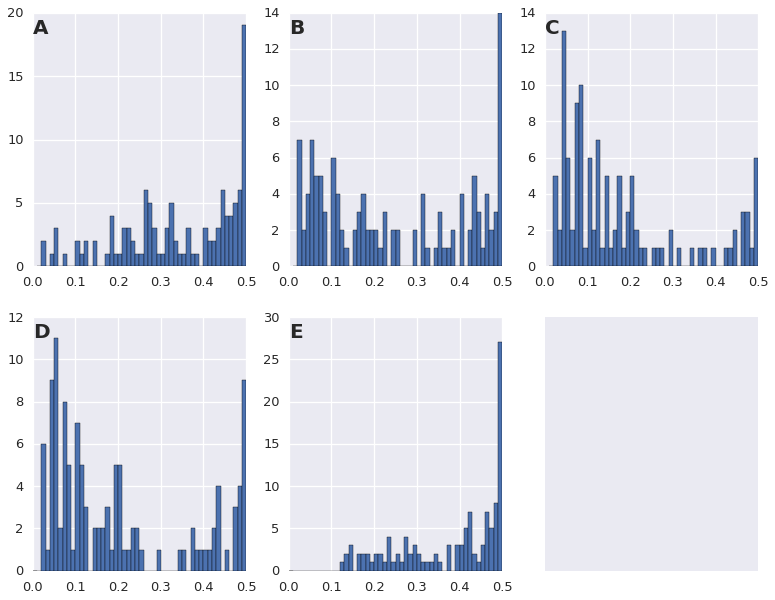

In [588]:
with PdfPages('/home/lindb/wbp/figures/grid_imp_hexp_hist_by_pheno_top_PIPs_true_freqs.pdf') as pdf:
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6)) = plt.subplots(2, 3, figsize=(5,5),dpi=400)

    a1 = plt.subplot(231)
    a1.hist(outlierdata['bfpopx']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a1.set_title('A',y=.9,loc='left',fontsize=20,fontweight='bold')
    a1.spines['right'].set_visible(False)
    a1.spines['top'].set_visible(False)
    a1.yaxis.set_ticks_position('left')
    a1.xaxis.set_ticks_position('bottom')
    
    a2 = plt.subplot(232)
    a2.hist(outlierdata['c13popx']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a2.set_title('B',y=.9,loc='left',fontsize=20,fontweight='bold')
    a2.spines['right'].set_visible(False)
    a2.spines['top'].set_visible(False)
    a2.yaxis.set_ticks_position('left')
    a2.xaxis.set_ticks_position('bottom')
    
    a3 = plt.subplot(233)
    a3.hist(outlierdata['htpopx']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a3.set_title('C',y=.9,loc='left',fontsize=20,fontweight='bold')
    a3.spines['right'].set_visible(False)
    a3.spines['top'].set_visible(False)
    a3.yaxis.set_ticks_position('left')
    a3.xaxis.set_ticks_position('bottom')
    
    a4 = plt.subplot(234)
    a4.hist(outlierdata['n15popx']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a4.set_title('D',y=.9,loc='left',fontsize=20,fontweight='bold')
    a4.spines['right'].set_visible(False)
    a4.spines['top'].set_visible(False)
    a4.yaxis.set_ticks_position('left')
    a4.xaxis.set_ticks_position('bottom')
    
    a5 = plt.subplot(235)
    a5.hist(outlierdata['rspopx']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a5.set_title('E',y=.9,loc='left',fontsize=20,fontweight='bold')
    a5.spines['right'].set_visible(False)
    a5.spines['top'].set_visible(False)
    a5.yaxis.set_ticks_position('left')
    a5.xaxis.set_ticks_position('bottom')
    
    a6.spines['right'].set_visible(False)
    a6.spines['left'].set_visible(False)
    a6.spines['top'].set_visible(False)
    a6.spines['bottom'].set_visible(False)
    a6.axes.get_yaxis().set_visible(False)
    a6.axes.get_xaxis().set_ticks([])
    a6.axes.get_yaxis().set_ticks([])
    
    fig.set_size_inches(13,10)
    pdf.savefig(fig,bbox_inches='tight')

In [589]:
#get sets of SNPs to make random draws
nonsigsnps = OrderedDict()
for pheno in outlierdata.keys():
    nonsigs = list(set(H.index.tolist()) - set(outlierdata[pheno].index.tolist()))
    nonsigsnps[pheno] = pd.DataFrame(H[H.index.isin(nonsigs)])
    print len(outlierdata[pheno].index.tolist())+len(nonsigsnps[pheno].index)

116231
116231
116231
116231
116231


In [590]:
#how many random snps to draw from each bin?
binCounter = OrderedDict()
for pheno in outlierdata.keys():
    binCounter[pheno] = Counter()
    for row in outlierdata[pheno].index:
        binCounter[pheno][outlierdata[pheno].loc[row,'bin']] += 1
    for b in binCounter[pheno].keys():
        print pheno,b,binCounter[pheno][b]

bfpopx 1.0 1
bfpopx 2.0 1
bfpopx 4.0 1
bfpopx 5.0 3
bfpopx 7.0 1
bfpopx 10.0 2
bfpopx 11.0 1
bfpopx 12.0 2
bfpopx 13.0 1
bfpopx 14.0 1
bfpopx 17.0 1
bfpopx 18.0 4
bfpopx 19.0 2
bfpopx 21.0 3
bfpopx 22.0 3
bfpopx 23.0 2
bfpopx 24.0 1
bfpopx 25.0 2
bfpopx 26.0 5
bfpopx 27.0 5
bfpopx 28.0 4
bfpopx 30.0 1
bfpopx 31.0 3
bfpopx 32.0 5
bfpopx 33.0 2
bfpopx 34.0 1
bfpopx 35.0 1
bfpopx 36.0 3
bfpopx 37.0 1
bfpopx 38.0 1
bfpopx 39.0 1
bfpopx 40.0 2
bfpopx 41.0 2
bfpopx 42.0 2
bfpopx 43.0 3
bfpopx 44.0 6
bfpopx 45.0 5
bfpopx 46.0 3
bfpopx 47.0 5
bfpopx 48.0 7
bfpopx 49.0 18
c13popx 1.0 2
c13popx 2.0 5
c13popx 3.0 2
c13popx 4.0 4
c13popx 5.0 7
c13popx 6.0 5
c13popx 7.0 5
c13popx 8.0 3
c13popx 10.0 6
c13popx 11.0 4
c13popx 12.0 2
c13popx 13.0 1
c13popx 14.0 1
c13popx 15.0 1
c13popx 16.0 3
c13popx 17.0 4
c13popx 18.0 2
c13popx 19.0 2
c13popx 20.0 2
c13popx 21.0 1
c13popx 22.0 3
c13popx 24.0 2
c13popx 25.0 2
c13popx 29.0 2
c13popx 31.0 4
c13popx 32.0 1
c13popx 34.0 1
c13popx 35.0 3
c13popx 36.0 1
c13

In [591]:
os.makedirs('/home/lindb/wbp/gemma/covariances/randmatrices')
os.makedirs('/home/lindb/wbp/gemma/covariances/randmatrices/randsnps')

In [592]:
#for each pheno make 1000 dataframes with a set of snps == len(outliersnps[pheno])
for pheno in outlierdata.keys():
    print pheno
    for i in range(1000):  
        snps = []        
        for binn in binCounter[pheno].keys():
            data = nonsigsnps[pheno][nonsigsnps[pheno]['bin'] == binn]
                
            [snps.append(snp) for snp in random.sample(data.index,binCounter[pheno][binn])]
        
        assert len(np.unique(snps).tolist()) == sum(binCounter[pheno].values())

        DIR = '/home/lindb/wbp/gemma/covariances/randmatrices/randsnps/%s' % pheno
        if not op.exists(DIR):
            os.makedirs(DIR)
        filE = op.join(DIR,"%s_%s_randsnps.txt" % (pheno,str(i).zfill(3)))
        df = pd.DataFrame(snps)
        df.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
c13popx
htpopx
n15popx
rspopx


In [705]:
#quicker to do it this way
#get dvals for the sets of random snps for each pheno
for pheno in outlierdata.keys():
    for i in range(1000):
        text = '''from __future__ import division
import os
from collections import OrderedDict,Counter
import pandas as pd
import numpy as np
import random
import math
from os import path as op
from os import listdir as ls

#get pop assignment for each samp
filE = '/home/lindb/wbp/sampsTOpop.txt'
stp = pd.read_csv(filE,header=0,sep="\t")


#pops matched to samps
ptsDict = OrderedDict() #pop to samp dictionary
for row in stp.index:
    pop = stp.loc[row,'pop']
    if not pop in ptsDict.keys():
        ptsDict[pop] = []
    ptsDict[pop].append(stp.loc[row,'sampID'])


#get a dict with num indiv in pop
popDict = OrderedDict()
total = 0
for pop in ptsDict.keys():
    popDict[pop] = len(ptsDict[pop])
    print pop,popDict[pop]
    total += popDict[pop]


filE = '/home/lindb/wbp/OutFLANK/global_mafs.txt'
globs = pd.read_csv(filE,header=0,sep='\\t')
glob = OrderedDict()
for row in globs.index:
    snp = globs.loc[row,'locus']
    maf = globs.loc[row,'maf']
    glob[snp] = maf

impMAF = pd.read_csv('/home/lindb/wbp/OutFLANK/imputed_MAF.txt',header=0,index_col=0,sep="\\t")

filE= '/home/lindb/wbp/gemma/covariances/randmatrices/randsnps/%s/%s_%s_randsnps.txt' 
df = pd.read_csv(filE,header=None,sep="\\t")
randomsnps = df[0].tolist()

dijDict = OrderedDict() 
for i,locusi in enumerate(randomsnps):
    dijDict[locusi] = OrderedDict()
    qi = glob[locusi] #global maf

    for j,locusj in enumerate(randomsnps):
        if i > j: #i=row, j=col : lower triangle 
            qj = glob[locusj] #global maf

            sums = 0
            for pop in impMAF.columns:
                qik = impMAF.loc[locusi,pop] #get pop maf
                qjk = impMAF.loc[locusj,pop] #get pop maf
                nk = popDict[pop]

                sums += (nk/244)*((qik*qjk)-(qi*qj))

            dijDict[locusi][locusj] = sums
        else:
            dijDict[locusi][locusj] = np.nan

filE = '/home/lindb/wbp/gemma/covariances/randmatrices/randDVALS/%s/%s_%s_randDVALS.txt'
if not op.exists('/home/lindb/wbp/gemma/covariances/randmatrices/randDVALS/'):
    os.makedirs('/home/lindb/wbp/gemma/covariances/randmatrices/randDVALS/')
DIR = op.dirname(filE)
if not op.exists(DIR):
    os.makedirs(DIR)

with open(filE,'w') as o:
    key0 = dijDict.keys()[0]
    line = '\\t'.join(dijDict[key0].keys()) + str('\\n')
    o.write("%%s" %% line)
    for locusi in dijDict.keys():
        line = str(locusi)+'\\t'+'\\t'.join([str(x) for x in dijDict[locusi].values()]) + str('\\n')
        o.write("%%s" %% line)


''' % (pheno,pheno,str(i).zfill(3),
       pheno,pheno,str(i).zfill(3))
        filE = '/home/lindb/wbp/gemma/covariances/randmatrices/randpyfiles/get_rand_dvals_%s_%s.py' % (pheno,
                                                                                                      str(i).zfill(3)
                                                                                                     )
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [706]:
DIR = '/home/lindb/wbp/gemma/covariances/randmatrices/randpyfiles/'
pyfiles = [op.join(DIR,f) for f in ls(DIR)]
len(pyfiles)

5000

In [708]:
5000/180

27.77777777777778

In [710]:
#spread out the jobs across 180 files
#18000/25=720
tcount  = 0
fcount = 0
tcount = 0
for f in sorted(pyfiles):
    if count == 0:
        text = 'python %s\n' % f
    else:
        newtext = 'python %s\n' % f
        text = text + newtext
    count += 1
    tcount +=1
    if (count == 28) or (tcount ==5000):
        count = 0
        fcount += 1
        filE = '/home/lindb/wbp/gemma/covariances/randmatrices/runpyfiles/%s_cmds.txt' % str(fcount).zfill(3)
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [713]:
#make 180 qsub files
for i in range(179):
    j = i+1
    text = '''#!/bin/bash
#$ -N pyfile%s
#$ -V
#$ -j y
#$ -cwd

cat %s_cmds.txt | parallel --progress --

''' % (str(j).zfill(3),
       str(j).zfill(3)
      )
    filE = '/home/lindb/wbp/gemma/covariances/randmatrices/runpyfiles/%s_run.sh' % str(j).zfill(3)
    with open(filE,'w') as o:
        o.write("%s" % text)

In [ ]:
#qsub the qsubs

In [839]:
#check on progress
DIR = '/home/lindb/wbp/gemma/covariances/randmatrices/randDVALS/'
ds = [op.join(DIR,d) for d in ls(DIR)]
count = 0
for DIR in ds:
    count = count + len(ls(DIR))
count

5000

In [840]:
# get observed dvals
dvals = OrderedDict()
medvals = OrderedDict()
for pheno in outlierdata.keys():
    print pheno
    DF = pd.read_csv('/home/lindb/wbp/gemma/covariances/dvals/%s_dvals.txt' % pheno,
                     header=0,index_col=0,sep="\t")
    dvals[pheno] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[pheno].append(abs(DF.loc[row,col]))

    DIR = '/home/lindb/wbp/gemma/covariances/randmatrices/randDVALS/%s/' % pheno
    files = [op.join(DIR,f) for f in ls(DIR)]

    fcount = 0
    medvals[pheno] = []
    for f in files:
        df = pd.read_csv(f,header=0,index_col=0,sep="\t")
        rvals = [] #random dij values
        for lst in df.values.tolist():
            for x in lst:
                if math.isnan(x) == False:
                    rvals.append(x)


        medvals[pheno].append(np.median([abs(val) for val in rvals]))

        fcount += 1
        if fcount % 100 == 0:
            print fcount

    filE = '/home/lindb/wbp/gemma/covariances/randmatrices/randmedvals/%s_randmedvalues.txt' % pheno
    if not op.exists(op.dirname(filE)):
        os.makedirs(op.dirname(filE))
    medvaldf = pd.DataFrame(medvals[pheno])
    medvaldf.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
100
200
300
400
500
600
700
800
900
1000
c13popx
100
200
300
400
500
600
700
800
900
1000
htpopx
100
200
300
400
500
600
700
800
900
1000
n15popx
100
200
300
400
500
600
700
800
900
1000
rspopx
100
200
300
400
500
600
700
800
900
1000


In [874]:
#in case I restart my notebook
medvals = {}
for pheno in outlierdata.keys():
    print pheno
    DF = pd.read_csv('/home/lindb/wbp/gemma/covariances_top_PIPs_true_mafs/dvals/%s_dvals.txt' % pheno,
                     header=0,index_col=0,sep="\t")
    dvals[pheno] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[pheno].append(abs(DF.loc[row,col]))
    filE = '/home/lindb/wbp/gemma/covariances_top_PIPs_true_mafs/randmatrices/randmedvals/%s_randmedvalues.txt' % pheno
    df = pd.read_csv(filE,header=None,sep='\t')
    medvals[pheno] = df[0].tolist()

bfpopx
c13popx
htpopx
n15popx
rspopx


In [875]:
n5th = OrderedDict()    #get 95th percentile
gt_hth = OrderedDict()  #how much greater is the empirical median dvalue than the 100th percentile of random SNPs?
gt_n5th = OrderedDict() #how much greater is the empirical median dvalue than the 95th percentile of random SNPs?
bmax=OrderedDict()      #below what percentile of the observed dvals are the values less than the maximum randdvals
bn5th = OrderedDict()   #below what percentile of the observed dvals are the values less than the 95th perc randdvals
for pheno in outlierdata.keys():
    print pheno,'has',len(toppips[pheno]),'SNPs in intersection of top PIPs and top effects (alpha+beta)'
    sorts        = sorted(medvals[pheno])
    n5th[pheno]    = sorts[949]
    gt_hth[pheno]  = np.median(dvals[pheno])/max(medvals[pheno])
    print 'emp median is %sx greater than 100th percentile of random'%str(round(gt_hth[pheno],3))
    gt_n5th[pheno] = np.median(dvals[pheno])/n5th[pheno]
    print 'emp median is %sx greater than 95th percentile of random'%str(round(gt_n5th[pheno],3))
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < max(sorts): #the max(randDval) corresponds to the xth percentile of empirical d-values
            bmax[pheno]=(i+1,i/len(dvals[pheno]))
            break
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < sorts[949]:
            bn5th[pheno]=(i+1,i/len(dvals[pheno]))
            break
    print 'the max random value corresponds to the %s precentile' % str(round(bmax[pheno][1],3)*100),"(%s/%s)" % (bmax[pheno][0],len(dvals[pheno])),'of emp values'
    print 'the 95th perc rand val corresponds to the %s percentile',str(round(bn5th[pheno][1],3)*100),"(%s/%s)" % (bn5th[pheno][0],len(dvals[pheno])),'of emp values'
    print 'emp med dval =',"{:.4}".format(np.median(dvals[pheno]))
    print 'max rand dval =',"{:.4}".format(max(medvals[pheno]))
    print '95th rand dval =',"{:.4}".format(n5th[pheno])
    print '\n' 

bfpopx has 118 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.801x greater than 100th percentile of random
emp median is 0.929x greater than 95th percentile of random
the max random value corresponds to the 56.5 precentile (3903/6903) of emp values
the 95th perc rand val corresponds to the %s percentile 52.1 (3599/6903) of emp values
emp med dval = 0.0008791
max rand dval = 0.001097
95th rand dval = 0.0009466


c13popx has 122 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.727x greater than 100th percentile of random
emp median is 0.864x greater than 95th percentile of random
the max random value corresponds to the 59.9 precentile (4419/7381) of emp values
the 95th perc rand val corresponds to the %s percentile 54.4 (4016/7381) of emp values
emp med dval = 0.0004098
max rand dval = 0.0005637
95th rand dval = 0.0004743


htpopx has 117 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.855x greater 

# look at effect distributions

In [1019]:
sorted(combined_dfs.keys())

['bfpopx', 'c13popx', 'htpopx', 'n15popx', 'rspopx']

In [1423]:
#this dictionary was made elsewhere in 11_GEMMA.ipynb; I came back to remake soem of the distribution charts
for pheno in alphasnps:
    print pheno,len(alphasnps999[pheno])

rspopx 116
bfpopx 116
c13popx 116
n15popx 116
htpopx 116


In [2017]:
for pheno in toppips:
    print pheno,len(toppips[pheno])

rspopx 117
bfpopx 118
c13popx 122
n15popx 117
htpopx 117


In [2052]:
for pheno in pip998:
    print pheno,len(pip998[pheno])

rspopx 234
bfpopx 240
c13popx 240
n15popx 232
htpopx 238


In [2053]:
effects = OrderedDict()
for pheno in combined_dfs.keys():
    effects[pheno] = OrderedDict()
    effects[pheno]['toppips'] = pd.DataFrame(combined_dfs[pheno][combined_dfs[pheno].index.isin(toppips[pheno])])
#    effects[pheno]['snpdict999'] = pd.DataFrame(combined_dfs[pheno][combined_dfs[pheno].index.isin(snpdict999[pheno])])
#    effects[pheno]['snpdict995'] = pd.DataFrame(combined_dfs[pheno][combined_dfs[pheno].index.isin(snpdict995[pheno])])
#    effects[pheno]['top alphas'] = pd.DataFrame(combined_dfs[pheno][combined_dfs[pheno].index.isin(alphasnps999[pheno])])
    effects[pheno]['pip998']     = pd.DataFrame(combined_dfs[pheno][combined_dfs[pheno].index.isin(pip998[pheno])])

In [2054]:
for pheno in effects:
    for crit in effects[pheno]:
        print pheno,crit,len(effects[pheno][crit].index)

bfpopx toppips 118
bfpopx pip998 240
n15popx toppips 117
n15popx pip998 232
c13popx toppips 122
c13popx pip998 240
rspopx toppips 117
rspopx pip998 234
htpopx toppips 117
htpopx pip998 238


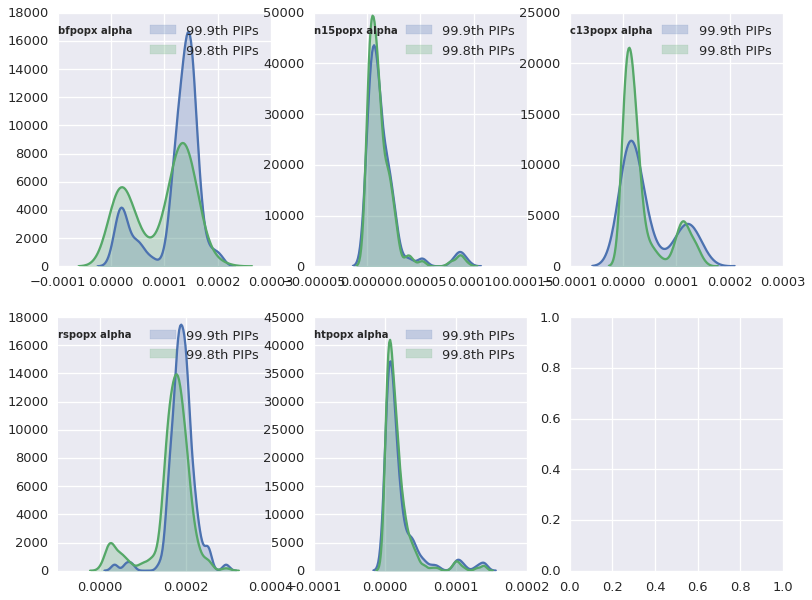

In [2056]:
with PdfPages('/home/lindb/wbp/figures/alpha_effects_2_criteria_by_pheno.pdf') as pdf:
    crit = 'alpha_hmean'
    
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6)) = plt.subplots(2, 3, figsize=(5,5),dpi=400)
    
    plotdict = {}
    count = 1
    for pheno in effects:
        plotdict[count] = plt.subplot(int("23%s" % count))
        a = effects[pheno]['toppips'][crit].tolist()
        b = effects[pheno]['pip998'][crit].tolist()
        bins=np.histogram(np.hstack((a,b)), bins=40)[1]
        sns.kdeplot(np.asarray(a),shade=True,legend=True)
        sns.kdeplot(np.asarray(b),shade=True,legend=True)
        plt.legend(['99.9th PIPs','99.8th PIPs'])
        plotdict[count].set_title('%s alpha' % pheno,y=.9,loc='left',fontsize=10,fontweight='bold')
        plotdict[count].spines['right'].set_visible(False)
        plotdict[count].spines['top'].set_visible(False)
        plotdict[count].yaxis.set_ticks_position('left')
        plotdict[count].xaxis.set_ticks_position('bottom')
        plotdict[count].locator_params(axis='x',nbins=4)

        fig.set_size_inches(13,10)
        pdf.savefig(fig,bbox_inches='tight')
        
        count += 1

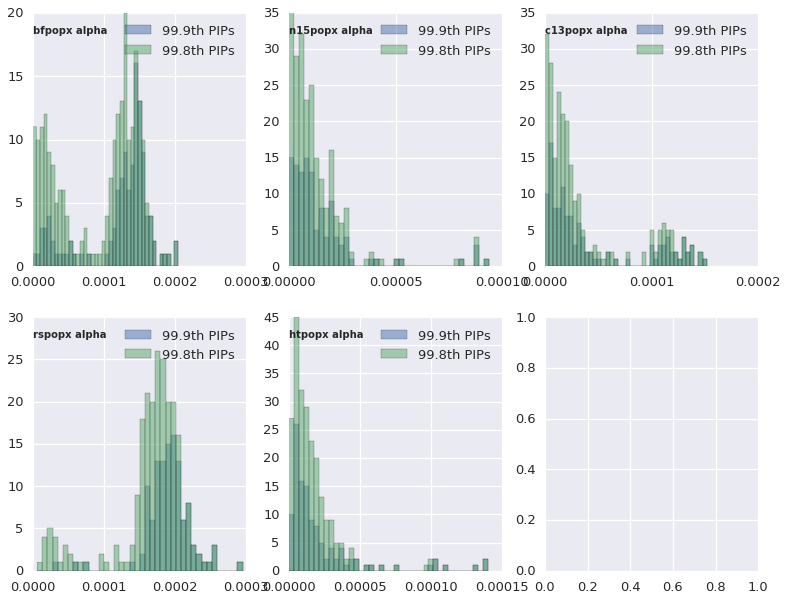

In [2057]:
with PdfPages('/home/lindb/wbp/figures/alpha_effects_2_criteria_by_pheno.pdf') as pdf:
    crit = 'alpha_hmean'
    
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6)) = plt.subplots(2, 3, figsize=(5,5),dpi=400)
    
    plotdict = {}
    count = 1
    for pheno in effects:
        plotdict[count] = plt.subplot(int("23%s" % count))
        a = effects[pheno]['toppips'][crit].tolist()
        b = effects[pheno]['pip998'][crit].tolist()
        bins=np.histogram(np.hstack((a,b)), bins=40)[1]
        plotdict[count].hist(a,label='99.9th PIPs',alpha=0.5,bins=bins)
        plotdict[count].hist(b,label='99.8th PIPs',alpha=0.5,bins=bins)
        plt.legend()
        plotdict[count].set_title('%s alpha' % pheno,y=.9,loc='left',fontsize=10,fontweight='bold')
        plotdict[count].spines['right'].set_visible(False)
        plotdict[count].spines['top'].set_visible(False)
        plotdict[count].yaxis.set_ticks_position('left')
        plotdict[count].xaxis.set_ticks_position('bottom')
        if pheno == 'c13popx':
            plotdict[count].locator_params(axis='x',nbins=3)
        else:
            plotdict[count].locator_params(axis='x',nbins=4)

        fig.set_size_inches(13,10)
        pdf.savefig(fig,bbox_inches='tight')
        
        count += 1

In [2022]:
for pheno in toppips:
    snps = set(toppips[pheno]).intersection(set(pip998[pheno]))
    print pheno,len(snps),len(toppips[pheno]),len(pip998[pheno])

rspopx 112 117 232
bfpopx 91 118 232
c13popx 31 122 232
n15popx 5 117 232
htpopx 8 117 232


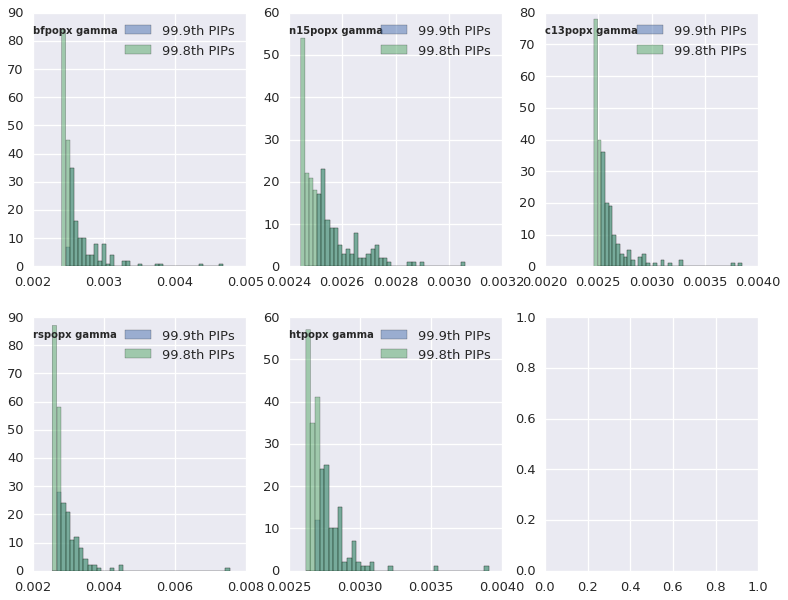

In [2068]:
with PdfPages('/home/lindb/wbp/figures/gamma_dist_2_criteria_by_pheno.pdf') as pdf:
    crit = 'gamma_hmean'
    
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6)) = plt.subplots(2, 3, figsize=(5,5),dpi=400)
    
    plotdict = {}
    count = 1
    for pheno in effects:
        plotdict[count] = plt.subplot(int("23%s" % count))
        a = effects[pheno]['toppips'][crit].tolist()
        b = effects[pheno]['pip998'][crit].tolist()
        bins=np.histogram(np.hstack((a,b)), bins=40)[1]
        plotdict[count].hist(a,label='99.9th PIPs',alpha=0.5,bins=bins)
        plotdict[count].hist(b,label='99.8th PIPs',alpha=0.5,bins=bins)
        plotdict[count].set_title('%s %s' % (pheno,crit.split("_")[0]),y=.9,loc='left',fontsize=10,fontweight='bold')
        plotdict[count].spines['right'].set_visible(False)
        plotdict[count].spines['top'].set_visible(False)
        plotdict[count].yaxis.set_ticks_position('left')
        plotdict[count].xaxis.set_ticks_position('bottom')
        plotdict[count].locator_params(axis='x',nbins=4)
        plt.legend(['99.9th PIPs','99.8th PIPs'])

        fig.set_size_inches(13,10)
        pdf.savefig(fig,bbox_inches='tight')
        
        count += 1

In [2069]:
effects[pheno]['toppips'].keys()

Index([u'alpha_hmean', u'beta_hmean', u'gamma_hmean', u'total_effect',
       u'model_averaged'],
      dtype='object')

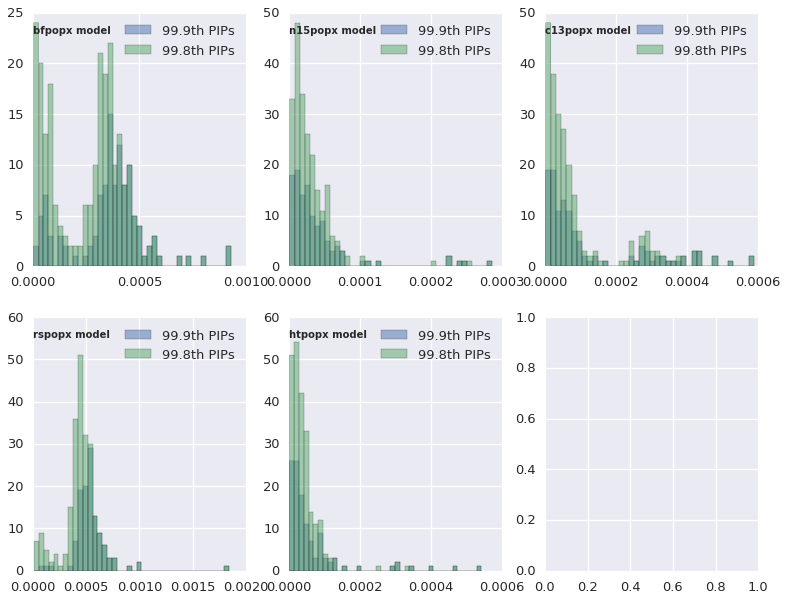

In [2070]:
with PdfPages('/home/lindb/wbp/figures/modavg_effect_dist_2_criteria_by_pheno.pdf') as pdf:
    crit = 'model_averaged' #criteria
    
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6)) = plt.subplots(2, 3, figsize=(5,5),dpi=400)
    
    plotdict = {}
    count = 1
    for pheno in effects:
        plotdict[count] = plt.subplot(int("23%s" % count))
        a = effects[pheno]['toppips'][crit].tolist()
        b = effects[pheno]['pip998'][crit].tolist()
        bins=np.histogram(np.hstack((a,b)), bins=40)[1]
        plotdict[count].hist(a,label='99.9th PIPs',alpha=0.5,bins=bins)
        plotdict[count].hist(b,label='99.8th PIPs',alpha=0.5,bins=bins)
        plt.legend()
        plotdict[count].set_title('%s %s' % (pheno,crit.split("_")[0]),y=.9,loc='left',fontsize=10,fontweight='bold')
        plotdict[count].spines['right'].set_visible(False)
        plotdict[count].spines['top'].set_visible(False)
        plotdict[count].yaxis.set_ticks_position('left')
        plotdict[count].xaxis.set_ticks_position('bottom')
        plotdict[count].locator_params(axis='x',nbins=4)

        fig.set_size_inches(13,10)
        pdf.savefig(fig,bbox_inches='tight')
        
        count += 1

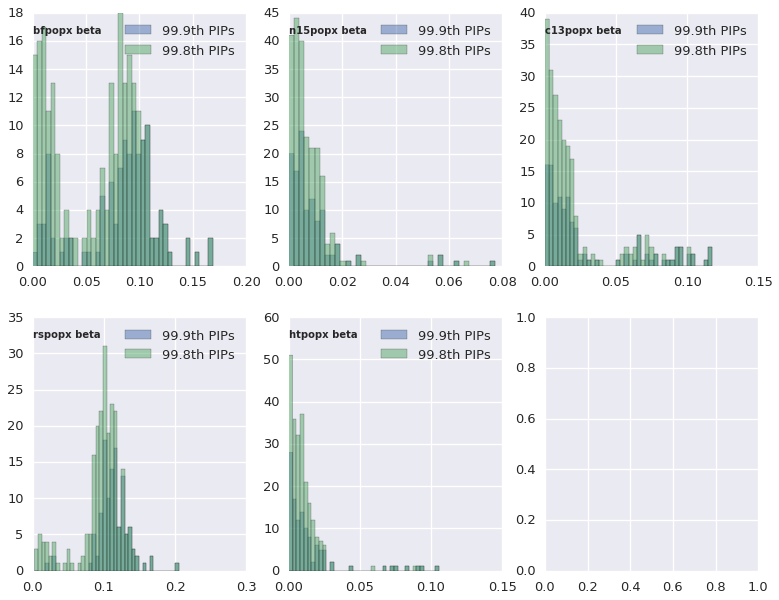

In [2072]:
with PdfPages('/home/lindb/wbp/figures/beta_dist_3_criteria_by_pheno.pdf') as pdf:
    crit = 'beta_hmean' #criteria
    
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6)) = plt.subplots(2, 3, figsize=(5,5),dpi=400)
    
    plotdict = {}
    count = 1
    for pheno in effects:
        plotdict[count] = plt.subplot(int("23%s" % count))
        a = effects[pheno]['toppips'][crit].tolist()
        b = effects[pheno]['pip998'][crit].tolist()
        bins=np.histogram(np.hstack((a,b)), bins=40)[1]
        plotdict[count].hist(a,label='99.9th PIPs',alpha=0.5,bins=bins)
        plotdict[count].hist(b,label='99.8th PIPs',alpha=0.5,bins=bins)
        plt.legend()
        plotdict[count].set_title('%s %s' % (pheno,crit.split("_")[0]),y=.9,loc='left',fontsize=10,fontweight='bold')
        plotdict[count].spines['right'].set_visible(False)
        plotdict[count].spines['top'].set_visible(False)
        plotdict[count].yaxis.set_ticks_position('left')
        plotdict[count].xaxis.set_ticks_position('bottom')
        plotdict[count].locator_params(axis='x',nbins=4)

        fig.set_size_inches(13,10)
        pdf.savefig(fig,bbox_inches='tight')
        
        count += 1

# covariance among top 0.99 PIPs and 0.99 top effects for ht and n15

In [1050]:
phenos

['htpopx', 'bfpopx', 'rspopx', 'c13popx', 'n15popx']

In [1051]:
effect_snps = {}
for pheno in phenos:
    d = combined_dfs[pheno]
    x = 'gamma_hmean'
    for q in [0.990]:
        x99_cutoff = d[x].quantile(q)
        xvals = d[x][d[x] >= x99_cutoff] 
        for y in ['total_effect']:
            y99_cutoff = d[y].quantile(q)
            yvals = d[y][d[y] >= y99_cutoff]
            isect = set(xvals.index).intersection(set(yvals.index))
            effect_snps[pheno] = isect
            print(pheno, x, y, q, len(isect))

('htpopx', 'gamma_hmean', 'total_effect', 0.99, 38)
('bfpopx', 'gamma_hmean', 'total_effect', 0.99, 311)
('rspopx', 'gamma_hmean', 'total_effect', 0.99, 492)
('c13popx', 'gamma_hmean', 'total_effect', 0.99, 113)
('n15popx', 'gamma_hmean', 'total_effect', 0.99, 30)


In [1034]:
filE = '/home/lindb/wbp/gemma/6pop_glob_mafs.txt'
globs = pd.read_csv(filE,header=0,sep='\\t')
glob = OrderedDict()
for row in globs.index:
    snp = globs.loc[row,'locus']
    maf = globs.loc[row,'maf']
    glob[snp] = maf

/gpfs_fs/home/lindb/anaconda/envs/conda/lib/python2.7/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


In [1039]:
os.makedirs('/home/lindb/wbp/bp/gemma/covariance_90th_n15_ht')

In [1038]:
popsizeDict

{'Dicks_Pass': 15,
 'Freel_Peak': 19,
 'Little_Round_Top': 14,
 'Mt_Rose_Ophir': 11,
 'Rifle_Peak': 15,
 'Snow_Valley_Peak': 14}

In [1044]:
mafs.head()

Dicks_Pass  Freel_Peak  \
NODE_1000013_length_91_cov_1.802198_37     0.066667    0.105263   
NODE_1000031_length_98_cov_2.000000_30     0.333333    0.078947   
NODE_1000037_length_93_cov_2.043011_33     0.100000    0.078947   
NODE_1000042_length_93_cov_1.118280_100    0.000000    0.000000   
NODE_1000053_length_94_cov_1.744681_25     0.033333    0.000000   

                                         Little_Round_Top  Mt_Rose_Ophir  \
NODE_1000013_length_91_cov_1.802198_37           0.250000       0.272727   
NODE_1000031_length_98_cov_2.000000_30           0.178571       0.045455   
NODE_1000037_length_93_cov_2.043011_33           0.071429       0.045455   
NODE_1000042_length_93_cov_1.118280_100          0.035714       0.000000   
NODE_1000053_length_94_cov_1.744681_25           0.035714       0.045455   

                                         Rifle_Peak  Snow_Valley_Peak  
NODE_1000013_length_91_cov_1.802198_37     0.100000          0.178571  
NODE_1000031_length_98_cov_2.000000_30     0.100000          0.178571  
NODE_1000037_length_93_cov_2.043011_33     0.133333          0.142857  
NODE_1000042_length_93_cov_1.118280_100    0.000000          0.071429  
NODE_1000053_length_94_cov_1.744681_25     0.033333          0.035714

In [1045]:
mafDict['NODE_1000013_length_91_cov_1.802198_37']

OrderedDict([('Dicks_Pass', 0.066666666666699986),
             ('Freel_Peak', 0.105263157895),
             ('Little_Round_Top', 0.25),
             ('Mt_Rose_Ophir', 0.27272727272699998),
             ('Rifle_Peak', 0.10000000000000001),
             ('Snow_Valley_Peak', 0.17857142857099997)])

In [1046]:
sum(popsizeDict.values())

88

In [1052]:
#do pairwise to get Dij
for pheno in effect_snps.keys():
    print pheno
    outliersnps = effect_snps[pheno]

    dijDict = OrderedDict() 
    dijDict[pheno] = OrderedDict() 
    for i,locusi in enumerate(outliersnps):
        dijDict[pheno][locusi] = OrderedDict()
        qi = glob[locusi] #global maf

        for j,locusj in enumerate(outliersnps):
            if i > j: #i=row, j=col : lower triangle 
                qj = glob[locusj] #global maf

                sums = 0
                for pop in popsizeDict.keys():
                    qik = mafDict[locusi][pop] #get pop maf
                    qjk = mafDict[locusj][pop] #get pop maf
                    nk = popsizeDict[pop]

                    sums += (float(nk)/float(88))*((qik*qjk)-(qi*qj))

                dijDict[pheno][locusi][locusj] = sums
            else:
                dijDict[pheno][locusi][locusj] = np.nan
    #write out the file
    for pheno in dijDict.keys():
        filE = '/home/lindb/wbp/gemma/covariance_90th_n15_ht/dvals/%s_dvals.txt' % pheno
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            key0 = dijDict[pheno].keys()[0]
            line = '\t'.join(dijDict[pheno][key0].keys()) + str('\n')
            o.write("%s" % line)
            for locusi in dijDict[pheno].keys():
                line = str(locusi)+'\t'+'\t'.join([str(x) for x in dijDict[pheno][locusi].values()]) + str('\n')
                o.write("%s" % line)

bfpopx
n15popx
c13popx
rspopx
htpopx


In [1054]:
DIR = '/home/lindb/wbp/gemma/covariance_90th_n15_ht/dvals'
files = [op.join(DIR,f) for f in ls(DIR)]
dijDict = OrderedDict()
for f in sorted(files):
    pheno = op.basename(f).split("_")[0]
    dijDict[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')
dijDict['n15popx'].head()

NODE_1760644_length_97_cov_1.000000_48  \
NODE_1760644_length_97_cov_1.000000_48                                     NaN   
NODE_741395_length_91_cov_5.483517_37                                -0.017810   
NODE_301449_length_82_cov_3.207317_56                                -0.021995   
NODE_1744348_length_94_cov_1.000000_31                               -0.012174   
NODE_1566073_length_91_cov_1.032967_34                               -0.036295   

                                        NODE_741395_length_91_cov_5.483517_37  \
NODE_1760644_length_97_cov_1.000000_48                                    NaN   
NODE_741395_length_91_cov_5.483517_37                                     NaN   
NODE_301449_length_82_cov_3.207317_56                               -0.001353   
NODE_1744348_length_94_cov_1.000000_31                               0.000352   
NODE_1566073_length_91_cov_1.032967_34                              -0.003629   

                                        NODE_301449_length_82_cov_3.207317_56  \
NODE_1760644_length_97_cov_1.000000_48                                    NaN   
NODE_741395_length_91_cov_5.483517_37                                     NaN   
NODE_301449_length_82_cov_3.207317_56                                     NaN   
NODE_1744348_length_94_cov_1.000000_31                              -0.002396   
NODE_1566073_length_91_cov_1.032967_34                              -0.003271   

                                        NODE_1744348_length_94_cov_1.000000_31  \
NODE_1760644_length_97_cov_1.000000_48                                     NaN   
NODE_741395_length_91_cov_5.483517_37                                      NaN   
NODE_301449_length_82_cov_3.207317_56                                      NaN   
NODE_1744348_length_94_cov_1.000000_31                                     NaN   
NODE_1566073_length_91_cov_1.032967_34                               -0.001063   

                                        NODE_1566073_length_91_cov_1.032967_34  \
NODE_1760644_length_97_cov_1.000000_48                                     NaN   
NODE_741395_length_91_cov_5.483517_37                                      NaN   
NODE_301449_length_82_cov_3.207317_56                                      NaN   
NODE_1744348_length_94_cov_1.000000_31                                     NaN   
NODE_1566073_length_91_cov_1.032967_34                                     NaN   

                                        NODE_679018_length_98_cov_3.000000_88  \
NODE_1760644_length_97_cov_1.000000_48                                    NaN   
NODE_741395_length_91_cov_5.483517_37                                     NaN   
NODE_301449_length_82_cov_3.207317_56                                     NaN   
NODE_1744348_length_94_cov_1.000000_31                                    NaN   
NODE_1566073_length_91_cov_1.032967_34                                    NaN   

                                        NODE_1880097_length_97_cov_2.731959_23  \
NODE_1760644_length_97_cov_1.000000_48                                     NaN   
NODE_741395_length_91_cov_5.483517_37                                      NaN   
NODE_301449_length_82_cov_3.207317_56                                      NaN   
NODE_1744348_length_94_cov_1.000000_31                                     NaN   
NODE_1566073_length_91_cov_1.032967_34                                     NaN   

                                        NODE_699776_length_98_cov_1.938776_94  \
NODE_1760644_length_97_cov_1.000000_48                                    NaN   
NODE_741395_length_91_cov_5.483517_37                                     NaN   
NODE_301449_length_82_cov_3.207317_56                                     NaN   
NODE_1744348_length_94_cov_1.000000_31                                    NaN   
NODE_1566073_length_91_cov_1.032967_34                                    NaN   

                                        NODE_1337066_length_105_cov_1.057143_110  \
NODE_1760644_length_97_cov_1.000000_

In [1055]:
for pheno in dijDict.keys():
    print pheno,len(dijDict[pheno].columns)

bfpopx 311
c13popx 113
htpopx 38
n15popx 30
rspopx 492


In [1056]:
len(Hexp.keys())

115632

In [1057]:
H.head()

locus  \
NODE_1000013_length_91_cov_1.802198_37    NODE_1000013_length_91_cov_1.802198_37   
NODE_1000031_length_98_cov_2.000000_30    NODE_1000031_length_98_cov_2.000000_30   
NODE_1000037_length_93_cov_2.043011_33    NODE_1000037_length_93_cov_2.043011_33   
NODE_1000042_length_93_cov_1.118280_100  NODE_1000042_length_93_cov_1.118280_100   
NODE_1000053_length_94_cov_1.744681_25    NODE_1000053_length_94_cov_1.744681_25   

                                            H_exp  bin  
NODE_1000013_length_91_cov_1.802198_37   0.259749   25  
NODE_1000031_length_98_cov_2.000000_30   0.259749   25  
NODE_1000037_length_93_cov_2.043011_33   0.174522   17  
NODE_1000042_length_93_cov_1.118280_100  0.033510    3  
NODE_1000053_length_94_cov_1.744681_25   0.055204    5

In [1058]:
len(H.index)

115632

In [1059]:
for pheno in effect_snps:
    print pheno,len(effect_snps[pheno])

bfpopx 311
n15popx 30
c13popx 113
rspopx 492
htpopx 38


In [1060]:
#get a dataframe with the outlier loci and their bins
outlierdata = OrderedDict()
for pheno in dijDict.keys():
    outliersnps = effect_snps[pheno]

    outlierdata[pheno] = pd.DataFrame(H[H.index.isin(outliersnps)])
    print pheno,len(outlierdata[pheno]),len(effect_snps[pheno])

bfpopx 311 311
c13popx 113 113
htpopx 38 38
n15popx 30 30
rspopx 492 492


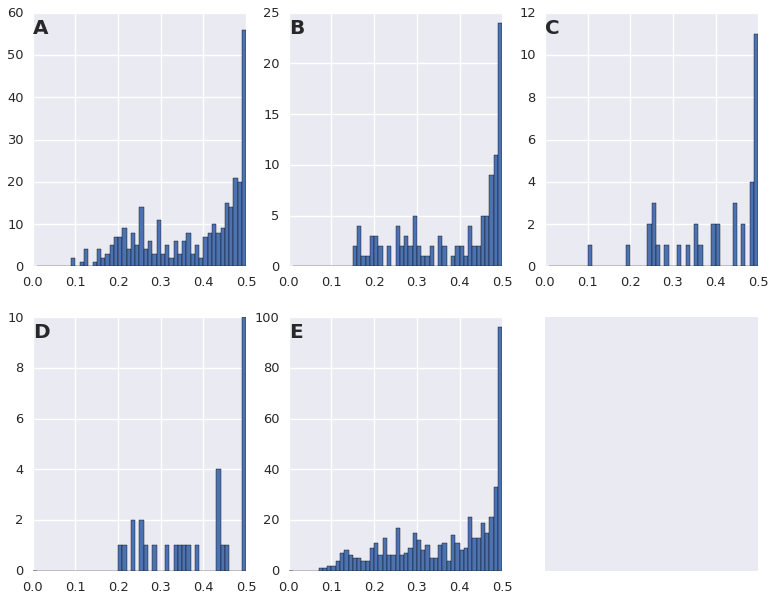

In [1061]:
with PdfPages('/home/lindb/wbp/figures/grid_imp_hexp_hist_by_pheno_990.pdf') as pdf:
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6)) = plt.subplots(2, 3, figsize=(5,5),dpi=400)

    a1 = plt.subplot(231)
    a1.hist(outlierdata['bfpopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a1.set_title('A',y=.9,loc='left',fontsize=20,fontweight='bold')
    a1.spines['right'].set_visible(False)
    a1.spines['top'].set_visible(False)
    a1.yaxis.set_ticks_position('left')
    a1.xaxis.set_ticks_position('bottom')
    
    a2 = plt.subplot(232)
    a2.hist(outlierdata['c13popx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a2.set_title('B',y=.9,loc='left',fontsize=20,fontweight='bold')
    a2.spines['right'].set_visible(False)
    a2.spines['top'].set_visible(False)
    a2.yaxis.set_ticks_position('left')
    a2.xaxis.set_ticks_position('bottom')
    
    a3 = plt.subplot(233)
    a3.hist(outlierdata['htpopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a3.set_title('C',y=.9,loc='left',fontsize=20,fontweight='bold')
    a3.spines['right'].set_visible(False)
    a3.spines['top'].set_visible(False)
    a3.yaxis.set_ticks_position('left')
    a3.xaxis.set_ticks_position('bottom')
    
    a4 = plt.subplot(234)
    a4.hist(outlierdata['n15popx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a4.set_title('D',y=.9,loc='left',fontsize=20,fontweight='bold')
    a4.spines['right'].set_visible(False)
    a4.spines['top'].set_visible(False)
    a4.yaxis.set_ticks_position('left')
    a4.xaxis.set_ticks_position('bottom')
    
    a5 = plt.subplot(235)
    a5.hist(outlierdata['rspopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a5.set_title('E',y=.9,loc='left',fontsize=20,fontweight='bold')
    a5.spines['right'].set_visible(False)
    a5.spines['top'].set_visible(False)
    a5.yaxis.set_ticks_position('left')
    a5.xaxis.set_ticks_position('bottom')
    
    a6.spines['right'].set_visible(False)
    a6.spines['left'].set_visible(False)
    a6.spines['top'].set_visible(False)
    a6.spines['bottom'].set_visible(False)
    a6.axes.get_yaxis().set_visible(False)
    a6.axes.get_xaxis().set_ticks([])
    a6.axes.get_yaxis().set_ticks([])
    
    fig.set_size_inches(13,10)
    pdf.savefig(fig,bbox_inches='tight')

In [1062]:
#get sets of SNPs to make random draws
nonsigsnps = OrderedDict()
for pheno in outlierdata.keys():
    nonsigs = list(set(H.index.tolist()) - set(outlierdata[pheno].index.tolist()))
    nonsigsnps[pheno] = pd.DataFrame(H[H.index.isin(nonsigs)])
    print len(outlierdata[pheno].index.tolist())+len(nonsigsnps[pheno].index)

115632
115632
115632
115632
115632


In [1063]:
#how many random snps to draw from each bin?
binCounter = OrderedDict()
for pheno in outlierdata.keys():
    binCounter[pheno] = Counter()
    for row in outlierdata[pheno].index:
        binCounter[pheno][outlierdata[pheno].loc[row,'bin']] += 1
    for b in binCounter[pheno].keys():
        print pheno,b,binCounter[pheno][b]

bfpopx 9 2
bfpopx 11 1
bfpopx 12 4
bfpopx 14 1
bfpopx 15 4
bfpopx 16 2
bfpopx 17 3
bfpopx 18 5
bfpopx 19 7
bfpopx 20 13
bfpopx 21 3
bfpopx 22 4
bfpopx 23 8
bfpopx 24 5
bfpopx 25 14
bfpopx 26 4
bfpopx 27 6
bfpopx 28 9
bfpopx 29 5
bfpopx 30 3
bfpopx 31 5
bfpopx 32 2
bfpopx 33 6
bfpopx 34 3
bfpopx 35 6
bfpopx 36 8
bfpopx 37 3
bfpopx 38 5
bfpopx 39 2
bfpopx 40 7
bfpopx 41 8
bfpopx 42 10
bfpopx 43 8
bfpopx 44 9
bfpopx 45 15
bfpopx 46 14
bfpopx 47 21
bfpopx 48 20
bfpopx 49 56
c13popx 15 2
c13popx 16 4
c13popx 17 1
c13popx 18 1
c13popx 19 3
c13popx 20 5
c13popx 23 2
c13popx 25 4
c13popx 26 2
c13popx 27 3
c13popx 28 3
c13popx 29 4
c13popx 30 2
c13popx 31 1
c13popx 32 1
c13popx 33 2
c13popx 35 3
c13popx 36 2
c13popx 38 1
c13popx 39 2
c13popx 40 2
c13popx 41 1
c13popx 42 4
c13popx 43 2
c13popx 44 2
c13popx 45 5
c13popx 46 5
c13popx 47 9
c13popx 48 11
c13popx 49 24
htpopx 33 1
htpopx 35 2
htpopx 36 1
htpopx 39 2
htpopx 40 2
htpopx 10 1
htpopx 44 3
htpopx 46 2
htpopx 48 4
htpopx 49 11
htpopx 19 1


In [1064]:
os.makedirs('/home/lindb/wbp/gemma/covariance_90th_n15_ht/randmatrices')
os.makedirs('/home/lindb/wbp/gemma/covariance_90th_n15_ht/randmatrices/randsnps')

In [1065]:
#for each pheno make 1000 dataframes with a set of snps == len(outliersnps[pheno])
for pheno in outlierdata.keys():
    print pheno
    for i in range(1000):  
        snps = []        
        for binn in binCounter[pheno].keys():
            data = nonsigsnps[pheno][nonsigsnps[pheno]['bin'] == binn]
                
            [snps.append(snp) for snp in random.sample(data.index,binCounter[pheno][binn])]
        
        assert len(np.unique(snps).tolist()) == sum(binCounter[pheno].values())

        DIR = '/home/lindb/wbp/gemma/covariance_90th_n15_ht/randmatrices/randsnps/%s' % pheno
        if not op.exists(DIR):
            os.makedirs(DIR)
        filE = op.join(DIR,"%s_%s_randsnps.txt" % (pheno,str(i).zfill(3)))
        df = pd.DataFrame(snps)
        df.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
c13popx
htpopx
n15popx
rspopx


In [1068]:
#quicker to do it this way
#get dvals for the sets of random snps for each pheno
for pheno in outlierdata.keys():
    for i in range(1000):
        text = '''from __future__ import division
import os
from collections import OrderedDict,Counter
import pandas as pd
import numpy as np
import random
import math
from os import path as op
from os import listdir as ls


#get a dict with num indiv in pop
#population sizes (only for individuals in pops with phenotypic measurements)
popDict = {'Dicks_Pass':15,
'Freel_Peak':19,
'Little_Round_Top':14,
'Mt_Rose_Ophir':11,
'Rifle_Peak':15,
'Snow_Valley_Peak':14,}


filE = '/home/lindb/wbp/gemma/6pop_glob_mafs.txt'
globs = pd.read_csv(filE,header=0,sep='\\t')
glob = OrderedDict()
for row in globs.index:
    snp = globs.loc[row,'locus']
    maf = globs.loc[row,'maf']
    glob[snp] = maf

impMAF = pd.read_csv('/home/lindb/wbp/gemma/6pop_pop_maf.txt',header=0,index_col=0,sep="\\t")

filE= '/home/lindb/wbp/gemma/covariance_90th_n15_ht/randmatrices/randsnps/%s/%s_%s_randsnps.txt' 
df = pd.read_csv(filE,header=None,sep="\\t")
randomsnps = df[0].tolist()

dijDict = OrderedDict() 
for i,locusi in enumerate(randomsnps):
    dijDict[locusi] = OrderedDict()
    qi = glob[locusi] #global maf

    for j,locusj in enumerate(randomsnps):
        if i > j: #i=row, j=col : lower triangle 
            qj = glob[locusj] #global maf

            sums = 0
            for pop in impMAF.columns:
                qik = impMAF.loc[locusi,pop] #get pop maf
                qjk = impMAF.loc[locusj,pop] #get pop maf
                nk = popDict[pop]

                sums += (nk/88)*((qik*qjk)-(qi*qj))

            dijDict[locusi][locusj] = sums
        else:
            dijDict[locusi][locusj] = np.nan

filE = '/home/lindb/wbp/gemma/covariance_90th_n15_ht/randmatrices/randDVALS/%s/%s_%s_randDVALS.txt'
if not op.exists('/home/lindb/wbp/gemma/covariance_90th_n15_ht/randmatrices/randDVALS/'):
    os.makedirs('/home/lindb/wbp/gemma/covariance_90th_n15_ht/randmatrices/randDVALS/')
DIR = op.dirname(filE)
if not op.exists(DIR):
    os.makedirs(DIR)

with open(filE,'w') as o:
    key0 = dijDict.keys()[0]
    line = '\\t'.join(dijDict[key0].keys()) + str('\\n')
    o.write("%%s" %% line)
    for locusi in dijDict.keys():
        line = str(locusi)+'\\t'+'\\t'.join([str(x) for x in dijDict[locusi].values()]) + str('\\n')
        o.write("%%s" %% line)


''' % (pheno,pheno,str(i).zfill(3),
       pheno,pheno,str(i).zfill(3))
        filE = '/home/lindb/wbp/gemma/covariance_90th_n15_ht/randmatrices/randpyfiles/get_rand_dvals_%s_%s.py' % (pheno,
                                                                                                      str(i).zfill(3)
                                                                                                     )
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [1072]:
DIR = '/home/lindb/wbp/gemma/covariance_90th_n15_ht/randmatrices/randpyfiles/'
pyfiles = [op.join(DIR,f) for f in ls(DIR)]
len(pyfiles)

5000

In [1070]:
5000/50

100.0

In [1073]:
#spread out the jobs
count = 0
fcount = 0
tcount = 0
for f in sorted(pyfiles):
    if count == 0:
        text = 'python %s\n' % f
    else:
        newtext = 'python %s\n' % f
        text = text + newtext
    count += 1
    tcount += 1
    if (count == 100) or (tcount == 5000):
        count = 0
        fcount += 1
        filE = '/home/lindb/wbp/gemma/covariance_90th_n15_ht/randmatrices/runpyfiles/%s_cmds.txt' % str(fcount).zfill(3)
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [1074]:
#make qsub files
for i in range(50):
    j = i+1
    text = '''#!/bin/bash
#$ -N pyfile%s
#$ -V
#$ -j y
#$ -cwd

cat %s_cmds.txt | parallel --progress --

''' % (str(j).zfill(3),
       str(j).zfill(3)
      )
    filE = '/home/lindb/wbp/gemma/covariance_90th_n15_ht/randmatrices/runpyfiles/%s_run.sh' % str(j).zfill(3)
    with open(filE,'w') as o:
        o.write("%s" % text)

In [1222]:
#check on progress
DIR = '/home/lindb/wbp/gemma/covariance_90th_n15_ht/randmatrices/randDVALS/'
ds = [op.join(DIR,d) for d in ls(DIR)]
count = 0
for DIR in ds:
    count = count + len(ls(DIR))
count

5000

In [1223]:
outlierdata.keys()

['bfpopx', 'c13popx', 'htpopx', 'n15popx', 'rspopx']

In [1224]:
# get observed dvals
dvals = OrderedDict()
medvals = OrderedDict()
for pheno in outlierdata.keys():
    print pheno
    DF = pd.read_csv('/home/lindb/wbp/gemma/covariance_90th_n15_ht/dvals/%s_dvals.txt' % pheno,
                     header=0,index_col=0,sep="\t")
    dvals[pheno] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[pheno].append(abs(DF.loc[row,col]))

    DIR = '/home/lindb/wbp/gemma/covariance_90th_n15_ht/randmatrices/randDVALS/%s/' % pheno
    files = [op.join(DIR,f) for f in ls(DIR)]

    fcount = 0
    medvals[pheno] = []
    for f in files:
        df = pd.read_csv(f,header=0,index_col=0,sep="\t")
        rvals = [] #random dij values
        for lst in df.values.tolist():
            for x in lst:
                if math.isnan(x) == False:
                    rvals.append(x)

        medvals[pheno].append(np.median([abs(val) for val in rvals]))

        fcount += 1
        if fcount % 100 == 0:
            print fcount

    filE = '/home/lindb/wbp/gemma/covariance_90th_n15_ht/randmatrices/randmedvals/%s_randmedvalues.txt' % pheno
    if not op.exists(op.dirname(filE)):
        os.makedirs(op.dirname(filE))
    medvaldf = pd.DataFrame(medvals[pheno])
    medvaldf.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
100
200
300
400
500
600
700
800
900
1000
c13popx
100
200
300
400
500
600
700
800
900
1000
htpopx
100
200
300
400
500
600
700
800
900
1000
n15popx
100
200
300
400
500
600
700
800
900
1000
rspopx
100
200
300
400
500
600
700
800
900
1000


In [1225]:
n5th = OrderedDict()    #get 95th percentile
gt_hth = OrderedDict()  #how much greater is the empirical median dvalue than the 100th percentile of random SNPs?
gt_n5th = OrderedDict() #how much greater is the empirical median dvalue than the 95th percentile of random SNPs?
bmax=OrderedDict()      #below what percentile of the observed dvals are the values less than the maximum randdvals
bn5th = OrderedDict()   #below what percentile of the observed dvals are the values less than the 95th perc randdvals
for pheno in outlierdata.keys():
    print pheno,'has',len(effect_snps[pheno]),'SNPs in intersection of top PIPs and top effects (alpha+beta)'
    sorts        = sorted(medvals[pheno])
    n5th[pheno]    = sorts[949]
    gt_hth[pheno]  = np.median(dvals[pheno])/max(medvals[pheno])
    print 'emp median is %sx greater than 100th percentile of random'%str(round(gt_hth[pheno],3))
    gt_n5th[pheno] = np.median(dvals[pheno])/n5th[pheno]
    print 'emp median is %sx greater than 95th percentile of random'%str(round(gt_n5th[pheno],3))
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < max(sorts): #the max(randDval) corresponds to the xth percentile of empirical d-values
            bmax[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < sorts[949]:
            bn5th[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    print 'the max random value corresponds to the %s precentile' % str(round(bmax[pheno][1],3)*100),"(%s/%s)" % (bmax[pheno][0],len(dvals[pheno])),'of emp values'
    print 'the 95th perc rand val corresponds to the %s percentile',str(round(bn5th[pheno][1],3)*100),"(%s/%s)" % (bn5th[pheno][0],len(dvals[pheno])),'of emp values'
    print 'emp med dval =',"{:.4}".format(np.median(dvals[pheno]))
    print 'max rand dval =',"{:.4}".format(max(medvals[pheno]))
    print '95th rand dval =',"{:.4}".format(n5th[pheno])
    print '\n' 

bfpopx has 311 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.982x greater than 100th percentile of random
emp median is 1.047x greater than 95th percentile of random
the max random value corresponds to the 50.5 precentile (24360/48205) of emp values
the 95th perc rand val corresponds to the %s percentile 48.6 (23417/48205) of emp values
emp med dval = 0.002418
max rand dval = 0.002462
95th rand dval = 0.00231


c13popx has 113 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.942x greater than 100th percentile of random
emp median is 1.092x greater than 95th percentile of random
the max random value corresponds to the 52.0 precentile (3288/6328) of emp values
the 95th perc rand val corresponds to the %s percentile 47.5 (3006/6328) of emp values
emp med dval = 0.003216
max rand dval = 0.003413
95th rand dval = 0.002946


htpopx has 38 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.586x greater tha

# covariance among top 0.999 model average effects 

In [1787]:
combined_dfs[pheno].head()

alpha_hmean  beta_hmean  gamma_hmean  \
rs                                                                              
NODE_1000013_length_91_cov_1.802198_37      0.000089    0.033259     0.001765   
NODE_1000031_length_98_cov_2.000000_30      0.000024    0.011842     0.001620   
NODE_1000037_length_93_cov_2.043011_33      0.000016    0.004484     0.001635   
NODE_1000042_length_93_cov_1.118280_100     0.000009    0.001231     0.001680   
NODE_1000053_length_94_cov_1.744681_25      0.000008    0.001378     0.001835   

                                         total_effect  model_averaged  
rs                                                                     
NODE_1000013_length_91_cov_1.802198_37       0.033348        0.000148  
NODE_1000031_length_98_cov_2.000000_30       0.011866        0.000043  
NODE_1000037_length_93_cov_2.043011_33       0.004500        0.000023  
NODE_1000042_length_93_cov_1.118280_100      0.001240        0.000011  
NODE_1000053_length_94_cov_1.744681_25       0.001386        0.000010

In [1807]:
x = 'model_averaged'
modfx = {}
for pheno in combined_dfs:
    modfx[pheno] = {}
    d = combined_dfs[pheno]
    for q in [0.999,0.995]:
        cutoff = d[x].quantile(q)
        xvals = d[x][d[x]>=cutoff]
        modfx[pheno][q] = xvals.index
        print pheno,q,len(modfx[pheno][q])

 bfpopx 0.999 116
bfpopx 0.995 578
n15popx 0.999 116
n15popx 0.995 579
c13popx 0.999 116
c13popx 0.995 579
rspopx 0.999 116
rspopx 0.995 578
htpopx 0.999 116
htpopx 0.995 579


In [1792]:
os.makedirs('/home/lindb/wbp/gemma/covariance_modfx_999')

In [1793]:
popsizeDict

{'Dicks_Pass': 15,
 'Freel_Peak': 19,
 'Little_Round_Top': 14,
 'Mt_Rose_Ophir': 11,
 'Rifle_Peak': 15,
 'Snow_Valley_Peak': 14}

In [1795]:
globs.head()

locus       maf
0   NODE_1000013_length_91_cov_1.802198_37  0.153409
1   NODE_1000031_length_98_cov_2.000000_30  0.153409
2   NODE_1000037_length_93_cov_2.043011_33  0.096591
3  NODE_1000042_length_93_cov_1.118280_100  0.017045
4   NODE_1000053_length_94_cov_1.744681_25  0.028409

In [1796]:
glob['NODE_1000013_length_91_cov_1.802198_37']

0.15340909090900001

In [1808]:
for pheno in modfx:
    print pheno,len(modfx[pheno][0.999])

rspopx 116
bfpopx 116
c13popx 116
n15popx 116
htpopx 116


In [1809]:
#do pairwise to get Dij
for pheno in modfx:
    print pheno
    outliersnps = modfx[pheno][0.999]
    popDict = OrderedDict(popsizeDict)

    dijDict = OrderedDict() 
    dijDict[pheno] = OrderedDict() 
    for i,locusi in enumerate(outliersnps):
        dijDict[pheno][locusi] = OrderedDict()
        qi = glob[locusi] #global maf

        for j,locusj in enumerate(outliersnps):
            if i > j: #i=row, j=col : lower triangle 
                qj = glob[locusj] #global maf

                sums = 0
                for pop in popDict.keys():
                    qik = mafDict[locusi][pop] #get pop maf
                    qjk = mafDict[locusj][pop] #get pop maf
                    nk = popDict[pop]

                    sums += (float(nk)/float(88))*((qik*qjk)-(qi*qj))

                dijDict[pheno][locusi][locusj] = sums
            else:
                dijDict[pheno][locusi][locusj] = np.nan
    #write out the file
    for pheno in dijDict.keys(): #indented by accident, would just overwrite and take longer than necessary
        filE = '/home/lindb/wbp/gemma/covariance_modfx_999/dvals/%s_dvals.txt' % pheno
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            key0 = dijDict[pheno].keys()[0]
            line = '\t'.join(dijDict[pheno][key0].keys()) + str('\n')
            o.write("%s" % line)
            for locusi in dijDict[pheno].keys():
                line = str(locusi)+'\t'+'\t'.join([str(x) for x in dijDict[pheno][locusi].values()]) + str('\n')
                o.write("%s" % line)

rspopx
bfpopx
c13popx
n15popx
htpopx


In [1810]:
DIR = '/home/lindb/wbp/gemma/covariance_modfx_999/dvals'
files = [op.join(DIR,f) for f in ls(DIR)]
dijDict = OrderedDict()
for f in sorted(files):
    pheno = op.basename(f).split("_")[0]
    dijDict[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')
dijDict[pheno].head()

NODE_1002798_length_96_cov_1.708333_69  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1006116_length_110_cov_1.718182_68                               -0.045083   
NODE_1022519_length_94_cov_1.712766_68                                -0.022610   
NODE_1031179_length_98_cov_1.897959_34                                -0.017021   
NODE_1043532_length_95_cov_2.000000_10                                -0.050929   

                                         NODE_1006116_length_110_cov_1.718182_68  \
NODE_1002798_length_96_cov_1.708333_69                                       NaN   
NODE_1006116_length_110_cov_1.718182_68                                      NaN   
NODE_1022519_length_94_cov_1.712766_68                                 -0.032550   
NODE_1031179_length_98_cov_1.897959_34                                 -0.029009   
NODE_1043532_length_95_cov_2.000000_10                                 -0.070850   

                                         NODE_1022519_length_94_cov_1.712766_68  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   
NODE_1031179_length_98_cov_1.897959_34                                 0.002353   
NODE_1043532_length_95_cov_2.000000_10                                -0.024522   

                                         NODE_1031179_length_98_cov_1.897959_34  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   
NODE_1031179_length_98_cov_1.897959_34                                      NaN   
NODE_1043532_length_95_cov_2.000000_10                                -0.025102   

                                         NODE_1043532_length_95_cov_2.000000_10  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   
NODE_1031179_length_98_cov_1.897959_34                                      NaN   
NODE_1043532_length_95_cov_2.000000_10                                      NaN   

                                         NODE_1048500_length_96_cov_1.625000_61  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   
NODE_1031179_length_98_cov_1.897959_34                                      NaN   
NODE_1043532_length_95_cov_2.000000_10                                      NaN   

                                         NODE_1051747_length_64_cov_1.328125_30  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   
NODE_1031179_length_98_cov_1.897959_34                                      NaN   
NODE_1043532_length_95_cov_2.000000_10                                      NaN   

                                         NODE_1059708_length_68_cov_1.073529_68  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   
NODE_1031179_length_98_cov_1.897959_34                                      NaN   
NODE_1043532_length_95_cov_2.000000_10                                      NaN   

                                         NO

In [1811]:
for pheno in dijDict.keys():
    print pheno,len(dijDict[pheno].columns)

bfpopx 116
c13popx 116
htpopx 116
n15popx 116
rspopx 116


In [1817]:
#get a dataframe with the outlier loci and their bins
outlierdata = OrderedDict()
for pheno in dijDict.keys():
    outliersnps = modfx[pheno][0.999]

    outlierdata[pheno] = pd.DataFrame(H[H.index.isin(outliersnps)])
    print pheno,len(outlierdata[pheno].index)

bfpopx 116
c13popx 116
htpopx 116
n15popx 116
rspopx 116


In [1818]:
#get sets of SNPs to make random draws
nonsigsnps = OrderedDict()
for pheno in outlierdata.keys():
    nonsigs = list(set(H.index.tolist()) - set(outlierdata[pheno].index.tolist()))
    nonsigsnps[pheno] = pd.DataFrame(H[H.index.isin(nonsigs)])
    print len(outlierdata[pheno].index.tolist())+len(nonsigsnps[pheno].index)

115632
115632
115632
115632
115632


In [1819]:
#how many random snps to draw from each bin?
binCounter = OrderedDict()
for pheno in outlierdata.keys():
    binCounter[pheno] = Counter()
    for row in outlierdata[pheno].index:
        binCounter[pheno][outlierdata[pheno].loc[row,'bin']] += 1
    for b in binCounter[pheno].keys():
        print pheno,b,binCounter[pheno][b]

bfpopx 12 1
bfpopx 15 1
bfpopx 16 1
bfpopx 17 2
bfpopx 19 1
bfpopx 20 2
bfpopx 21 1
bfpopx 22 1
bfpopx 23 3
bfpopx 24 4
bfpopx 25 6
bfpopx 26 1
bfpopx 27 2
bfpopx 28 4
bfpopx 29 2
bfpopx 31 2
bfpopx 32 2
bfpopx 33 3
bfpopx 34 2
bfpopx 35 3
bfpopx 36 3
bfpopx 37 1
bfpopx 38 1
bfpopx 39 1
bfpopx 40 1
bfpopx 41 5
bfpopx 42 5
bfpopx 43 6
bfpopx 44 5
bfpopx 45 7
bfpopx 46 4
bfpopx 47 7
bfpopx 48 8
bfpopx 49 18
c13popx 13 1
c13popx 15 2
c13popx 16 3
c13popx 17 1
c13popx 18 2
c13popx 19 2
c13popx 20 4
c13popx 23 3
c13popx 25 4
c13popx 26 1
c13popx 27 2
c13popx 28 4
c13popx 29 2
c13popx 30 3
c13popx 31 1
c13popx 32 3
c13popx 33 4
c13popx 35 2
c13popx 36 2
c13popx 38 2
c13popx 39 2
c13popx 40 1
c13popx 41 2
c13popx 42 4
c13popx 43 2
c13popx 44 4
c13popx 45 3
c13popx 46 5
c13popx 47 9
c13popx 48 7
c13popx 49 29
htpopx 11 1
htpopx 12 1
htpopx 13 1
htpopx 18 1
htpopx 19 1
htpopx 20 3
htpopx 21 1
htpopx 22 1
htpopx 23 3
htpopx 24 4
htpopx 25 5
htpopx 26 1
htpopx 27 2
htpopx 28 3
htpopx 29 1
htpopx 

In [1815]:
os.makedirs('/home/lindb/wbp/gemma/covariance_modfx_999/randmatrices')
os.makedirs('/home/lindb/wbp/gemma/covariance_modfx_999/randmatrices/randsnps')

In [1820]:
for pheno in outlierdata.keys():
    print pheno,len(outlierdata[pheno].index)

bfpopx 116
c13popx 116
htpopx 116
n15popx 116
rspopx 116


In [1821]:
#for each pheno make 1000 dataframes with a set of snps == len(outliersnps[pheno])
for pheno in outlierdata.keys():
    print pheno
    for i in range(1000):  
        snps = []        
        for binn in binCounter[pheno].keys():
            data = nonsigsnps[pheno][nonsigsnps[pheno]['bin'] == binn]
                
            [snps.append(snp) for snp in random.sample(data.index,binCounter[pheno][binn])]
        
        assert len(np.unique(snps).tolist()) == sum(binCounter[pheno].values())

        DIR = '/home/lindb/wbp/gemma/covariance_modfx_999/randmatrices/randsnps/%s' % pheno
        if not op.exists(DIR):
            os.makedirs(DIR)
        filE = op.join(DIR,"%s_%s_randsnps.txt" % (pheno,str(i).zfill(3)))
        df = pd.DataFrame(snps)
        df.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
c13popx
htpopx
n15popx
rspopx


In [1822]:
#quicker to do it this way
#get dvals for the sets of random snps for each pheno
for pheno in outlierdata.keys():
    for i in range(1000):
        text = '''from __future__ import division
import os
from collections import OrderedDict,Counter
import pandas as pd
import numpy as np
import random
import math
from os import path as op
from os import listdir as ls


#get a dict with num indiv in pop
#population sizes (only for individuals in pops with phenotypic measurements)
popDict = {'Dicks_Pass':15,
'Freel_Peak':19,
'Little_Round_Top':14,
'Mt_Rose_Ophir':11,
'Rifle_Peak':15,
'Snow_Valley_Peak':14,}


filE = '/home/lindb/wbp/gemma/6pop_glob_mafs.txt'
globs = pd.read_csv(filE,header=0,sep='\\t')
glob = OrderedDict()
for row in globs.index:
    snp = globs.loc[row,'locus']
    maf = globs.loc[row,'maf']
    glob[snp] = maf

impMAF = pd.read_csv('/home/lindb/wbp/gemma/6pop_pop_maf.txt',header=0,index_col=0,sep="\\t")

filE= '/home/lindb/wbp/gemma/covariance_modfx_999/randmatrices/randsnps/%s/%s_%s_randsnps.txt' 
df = pd.read_csv(filE,header=None,sep="\\t")
randomsnps = df[0].tolist()

dijDict = OrderedDict() 
for i,locusi in enumerate(randomsnps):
    dijDict[locusi] = OrderedDict()
    qi = glob[locusi] #global maf

    for j,locusj in enumerate(randomsnps):
        if i > j: #i=row, j=col : lower triangle 
            qj = glob[locusj] #global maf

            sums = 0
            for pop in impMAF.columns:
                qik = impMAF.loc[locusi,pop] #get pop maf
                qjk = impMAF.loc[locusj,pop] #get pop maf
                nk = popDict[pop]

                sums += (nk/88)*((qik*qjk)-(qi*qj))

            dijDict[locusi][locusj] = sums
        else:
            dijDict[locusi][locusj] = np.nan

filE = '/home/lindb/wbp/gemma/covariance_modfx_999/randmatrices/randDVALS/%s/%s_%s_randDVALS.txt'
if not op.exists('/home/lindb/wbp/gemma/covariance_modfx_999/randmatrices/randDVALS/'):
    os.makedirs('/home/lindb/wbp/gemma/covariance_modfx_999/randmatrices/randDVALS/')
DIR = op.dirname(filE)
if not op.exists(DIR):
    os.makedirs(DIR)

with open(filE,'w') as o:
    key0 = dijDict.keys()[0]
    line = '\\t'.join(dijDict[key0].keys()) + str('\\n')
    o.write("%%s" %% line)
    for locusi in dijDict.keys():
        line = str(locusi)+'\\t'+'\\t'.join([str(x) for x in dijDict[locusi].values()]) + str('\\n')
        o.write("%%s" %% line)
        
''' % (pheno,pheno,str(i).zfill(3),
       pheno,pheno,str(i).zfill(3))
        filE = '/home/lindb/wbp/gemma/covariance_modfx_999/randmatrices/randpyfiles/get_rand_dvals_%s_%s.py' % (pheno,
                                                                                                      str(i).zfill(3)
                                                                                                     )
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [1823]:
#get the python scripts
DIR = '/home/lindb/wbp/gemma/covariance_modfx_999/randmatrices/randpyfiles/'
pyfiles = [op.join(DIR,f) for f in ls(DIR)]
len(pyfiles)

5000

In [1826]:
#spread out the jobs
count = 0
fcount = 0
for f in sorted(pyfiles):
    if count == 0:
        text = 'python %s\n' % f
    else:
        newtext = 'python %s\n' % f
        text = text + newtext
    count += 1
    if count == 100:
        count = 0
        fcount += 1
        filE = '/home/lindb/wbp/gemma/covariance_modfx_999/randmatrices/runpyfiles/%s_cmds.txt' % str(fcount).zfill(3)
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [1827]:
#make qsub files
for i in range(50):
    j = i+1
    text = '''#!/bin/bash
#$ -N pyfile%s
#$ -V
#$ -j y
#$ -cwd

cat %s_cmds.txt | parallel --progress --

''' % (str(j).zfill(3),
       str(j).zfill(3)
      )
    filE = '/home/lindb/wbp/gemma/covariance_modfx_999/randmatrices/runpyfiles/%s_run.sh' % str(j).zfill(3)
    with open(filE,'w') as o:
        o.write("%s" % text)

In [1959]:
#check on progress
DIR = '/home/lindb/wbp/gemma/covariance_modfx_999/randmatrices/randDVALS/'
ds = [op.join(DIR,d) for d in ls(DIR)]
count = 0
for DIR in ds:
    count = count + len(ls(DIR))
count

5000

In [1960]:
# get observed dvals
dvals = OrderedDict()
medvals = OrderedDict()
for pheno in outlierdata.keys():
    print pheno
    DF = pd.read_csv('/home/lindb/wbp/gemma/covariance_modfx_999/dvals/%s_dvals.txt' % pheno,
                     header=0,index_col=0,sep="\t")
    dvals[pheno] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[pheno].append(abs(DF.loc[row,col]))

    DIR = '/home/lindb/wbp/gemma/covariance_modfx_999/randmatrices/randDVALS/%s/' % pheno
    files = [op.join(DIR,f) for f in ls(DIR)]

    fcount = 0
    medvals[pheno] = []
    for f in files:
        df = pd.read_csv(f,header=0,index_col=0,sep="\t")
        rvals = [] #random dij values
        for lst in df.values.tolist():
            for x in lst:
                if math.isnan(x) == False:
                    rvals.append(x)


        medvals[pheno].append(np.median([abs(val) for val in rvals]))

        fcount += 1
        if fcount % 100 == 0:
            print fcount

    filE = '/home/lindb/wbp/gemma/covariance_modfx_999/randmatrices/randmedvals/%s_randmedvalues.txt' % pheno
    if not op.exists(op.dirname(filE)):
        os.makedirs(op.dirname(filE))
    medvaldf = pd.DataFrame(medvals[pheno])
    medvaldf.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
100
200
300
400
500
600
700
800
900
1000
c13popx
100
200
300
400
500
600
700
800
900
1000
htpopx
100
200
300
400
500
600
700
800
900
1000
n15popx
100
200
300
400
500
600
700
800
900
1000
rspopx
100
200
300
400
500
600
700
800
900
1000


In [1962]:
1+1

2

In [1964]:
n5th = OrderedDict()    #get 95th percentile
gt_hth = OrderedDict()  #how much greater is the empirical median dvalue than the 100th percentile of random SNPs?
gt_n5th = OrderedDict() #how much greater is the empirical median dvalue than the 95th percentile of random SNPs?
bmax=OrderedDict()      #below what percentile of the observed dvals are the values less than the maximum randdvals
bn5th = OrderedDict()   #below what percentile of the observed dvals are the values less than the 95th perc randdvals
for pheno in outlierdata.keys():
    print pheno,'has',len(modfx[pheno][0.999]),'SNPs in top 0.999 of model averaged effects (alpha+beta*gamma)'
    sorts        = sorted(medvals[pheno])
    n5th[pheno]    = sorts[949]
    gt_hth[pheno]  = np.median(dvals[pheno])/max(medvals[pheno])
    print 'emp median is %sx greater than 100th percentile of random'%str(round(gt_hth[pheno],3))
    gt_n5th[pheno] = np.median(dvals[pheno])/n5th[pheno]
    print 'emp median is %sx greater than 95th percentile of random'%str(round(gt_n5th[pheno],3))
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < max(sorts): #the max(randDval) corresponds to the xth percentile of empirical d-values
            bmax[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < sorts[949]:
            bn5th[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    print 'the max random value corresponds to the %s precentile' % str(round(bmax[pheno][1],3)*100),"(%s/%s)" % (bmax[pheno][0],len(dvals[pheno])),'of emp values'
    print 'the 95th perc rand val corresponds to the %s percentile',str(round(bn5th[pheno][1],3)*100),"(%s/%s)" % (bn5th[pheno][0],len(dvals[pheno])),'of emp values'
    print 'emp med dval =',"{:.4}".format(np.median(dvals[pheno]))
    print 'max rand dval =',"{:.4}".format(max(medvals[pheno]))
    print '95th rand dval =',"{:.4}".format(n5th[pheno])
    print '\n' 

bfpopx has 116 SNPs in top 0.999 of model averaged effects (alpha+beta*gamma)
emp median is 0.901x greater than 100th percentile of random
emp median is 1.068x greater than 95th percentile of random
the max random value corresponds to the 53.4 precentile (3563/6670) of emp values
the 95th perc rand val corresponds to the %s percentile 48.2 (3218/6670) of emp values
emp med dval = 0.00261
max rand dval = 0.002897
95th rand dval = 0.002444


c13popx has 116 SNPs in top 0.999 of model averaged effects (alpha+beta*gamma)
emp median is 0.808x greater than 100th percentile of random
emp median is 1.062x greater than 95th percentile of random
the max random value corresponds to the 55.8 precentile (3725/6670) of emp values
the 95th perc rand val corresponds to the %s percentile 48.0 (3201/6670) of emp values
emp med dval = 0.003424
max rand dval = 0.004236
95th rand dval = 0.003223


htpopx has 116 SNPs in top 0.999 of model averaged effects (alpha+beta*gamma)
emp median is 0.696x greater tha

# covariance among top 0.995 model averaged effects (alpha + beta x gamma)

In [1828]:
for pheno in modfx:
    print pheno,len(modfx[pheno][0.995])

rspopx 578
bfpopx 578
c13popx 579
n15popx 579
htpopx 579


In [1830]:
os.makedirs('/home/lindb/wbp/gemma/covariance_modfx_995')

In [1832]:
#do pairwise to get Dij
for pheno in snpdict995.keys():
    print pheno
    outliersnps = modfx[pheno][0.995]
    popDict = OrderedDict(popsizeDict)

    dijDict = OrderedDict() 
    dijDict[pheno] = OrderedDict() 
    for i,locusi in enumerate(outliersnps):
        dijDict[pheno][locusi] = OrderedDict()
        qi = glob[locusi] #global maf

        for j,locusj in enumerate(outliersnps):
            if i > j: #i=row, j=col : lower triangle 
                qj = glob[locusj] #global maf

                sums = 0
                for pop in popDict.keys():
                    qik = mafDict[locusi][pop] #get pop maf
                    qjk = mafDict[locusj][pop] #get pop maf
                    nk = popDict[pop]

                    sums += (float(nk)/float(88))*((qik*qjk)-(qi*qj))

                dijDict[pheno][locusi][locusj] = sums
            else:
                dijDict[pheno][locusi][locusj] = np.nan
    #write out the file
    for pheno in dijDict.keys(): #indented by accident, would just overwrite and take longer than necessary
        filE = '/home/lindb/wbp/gemma/covariance_modfx_995/dvals/%s_dvals.txt' % pheno
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            key0 = dijDict[pheno].keys()[0]
            line = '\t'.join(dijDict[pheno][key0].keys()) + str('\n')
            o.write("%s" % line)
            for locusi in dijDict[pheno].keys():
                line = str(locusi)+'\t'+'\t'.join([str(x) for x in dijDict[pheno][locusi].values()]) + str('\n')
                o.write("%s" % line)

rspopx
bfpopx
c13popx
n15popx
htpopx


In [1833]:
DIR = '/home/lindb/wbp/gemma/covariance_modfx_995/dvals'
files = [op.join(DIR,f) for f in ls(DIR)]
dijDict = OrderedDict()
for f in sorted(files):
    pheno = op.basename(f).split("_")[0]
    dijDict[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')
dijDict[pheno].head()

NODE_1002798_length_96_cov_1.708333_69  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                -0.035482   
NODE_1005005_length_97_cov_1.041237_100                               -0.025974   
NODE_1006116_length_110_cov_1.718182_68                               -0.045083   
NODE_1021929_length_94_cov_1.180851_97                                -0.012415   

                                         NODE_1004353_length_98_cov_6.795918_59  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                               -0.037074   
NODE_1006116_length_110_cov_1.718182_68                               -0.056431   
NODE_1021929_length_94_cov_1.180851_97                                -0.018977   

                                         NODE_1005005_length_97_cov_1.041237_100  \
NODE_1002798_length_96_cov_1.708333_69                                       NaN   
NODE_1004353_length_98_cov_6.795918_59                                       NaN   
NODE_1005005_length_97_cov_1.041237_100                                      NaN   
NODE_1006116_length_110_cov_1.718182_68                                -0.045794   
NODE_1021929_length_94_cov_1.180851_97                                 -0.010520   

                                         NODE_1006116_length_110_cov_1.718182_68  \
NODE_1002798_length_96_cov_1.708333_69                                       NaN   
NODE_1004353_length_98_cov_6.795918_59                                       NaN   
NODE_1005005_length_97_cov_1.041237_100                                      NaN   
NODE_1006116_length_110_cov_1.718182_68                                      NaN   
NODE_1021929_length_94_cov_1.180851_97                                  -0.02638   

                                         NODE_1021929_length_94_cov_1.180851_97  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1021929_length_94_cov_1.180851_97                                      NaN   

                                         NODE_1022519_length_94_cov_1.712766_68  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1021929_length_94_cov_1.180851_97                                      NaN   

                                         NODE_1023980_length_97_cov_2.577320_74  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1021929_length_94_cov_1.180851_97                                      NaN   

                                         NODE_1026181_length_94_cov_1.031915_59  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1021929_length_94_cov_1.180851_97                                      NaN   

                                     

In [1834]:
for pheno in dijDict.keys():
    print pheno,len(dijDict[pheno].columns)

bfpopx 578
c13popx 579
htpopx 579
n15popx 579
rspopx 578


In [1836]:
#get a dataframe with the outlier loci and their bins
outlierdata = OrderedDict()
for pheno in dijDict.keys():
    outliersnps = modfx[pheno][0.995]

    outlierdata[pheno] = pd.DataFrame(H[H.index.isin(outliersnps)])
    print pheno,len(outlierdata[pheno].index)

bfpopx 578
c13popx 579
htpopx 579
n15popx 579
rspopx 578


In [1837]:
#get sets of SNPs to make random draws
nonsigsnps = OrderedDict()
for pheno in outlierdata.keys():
    nonsigs = list(set(H.index.tolist()) - set(outlierdata[pheno].index.tolist()))
    nonsigsnps[pheno] = pd.DataFrame(H[H.index.isin(nonsigs)])
    print len(outlierdata[pheno].index.tolist())+len(nonsigsnps[pheno].index)

115632
115632
115632
115632
115632


In [1838]:
#how many random snps to draw from each bin?
binCounter = OrderedDict()
for pheno in outlierdata.keys():
    binCounter[pheno] = Counter()
    for row in outlierdata[pheno].index:
        binCounter[pheno][outlierdata[pheno].loc[row,'bin']] += 1
    for b in binCounter[pheno].keys():
        print pheno,b,binCounter[pheno][b]

bfpopx 7 1
bfpopx 9 2
bfpopx 11 5
bfpopx 12 5
bfpopx 13 2
bfpopx 14 3
bfpopx 15 7
bfpopx 16 4
bfpopx 17 6
bfpopx 18 8
bfpopx 19 17
bfpopx 20 18
bfpopx 21 11
bfpopx 22 8
bfpopx 23 14
bfpopx 24 10
bfpopx 25 21
bfpopx 26 8
bfpopx 27 11
bfpopx 28 12
bfpopx 29 8
bfpopx 30 8
bfpopx 31 18
bfpopx 32 3
bfpopx 33 13
bfpopx 34 6
bfpopx 35 16
bfpopx 36 12
bfpopx 37 5
bfpopx 38 16
bfpopx 39 7
bfpopx 40 13
bfpopx 41 17
bfpopx 42 15
bfpopx 43 11
bfpopx 44 19
bfpopx 45 25
bfpopx 46 21
bfpopx 47 35
bfpopx 48 33
bfpopx 49 104
c13popx 7 1
c13popx 10 2
c13popx 11 4
c13popx 12 3
c13popx 13 7
c13popx 14 4
c13popx 15 4
c13popx 16 15
c13popx 17 13
c13popx 18 6
c13popx 19 13
c13popx 20 19
c13popx 21 8
c13popx 22 4
c13popx 23 9
c13popx 24 8
c13popx 25 17
c13popx 26 15
c13popx 27 6
c13popx 28 14
c13popx 29 10
c13popx 30 8
c13popx 31 11
c13popx 32 8
c13popx 33 15
c13popx 34 6
c13popx 35 14
c13popx 36 12
c13popx 37 4
c13popx 38 8
c13popx 39 11
c13popx 40 10
c13popx 41 10
c13popx 42 18
c13popx 43 8
c13popx 44 13
c1

In [1839]:
os.makedirs('/home/lindb/wbp/gemma/covariance_modfx_995/randmatrices')
os.makedirs('/home/lindb/wbp/gemma/covariance_modfx_995/randmatrices/randsnps')

In [1840]:
for pheno in outlierdata.keys():
    print pheno,len(outlierdata[pheno].index)

bfpopx 578
c13popx 579
htpopx 579
n15popx 579
rspopx 578


In [1841]:
#for each pheno make 1000 dataframes with a set of snps == len(outliersnps[pheno])
for pheno in outlierdata.keys():
    print pheno
    for i in range(1000):  
        snps = []        
        for binn in binCounter[pheno].keys():
            data = nonsigsnps[pheno][nonsigsnps[pheno]['bin'] == binn]
                
            [snps.append(snp) for snp in random.sample(data.index,binCounter[pheno][binn])]
        
        assert len(np.unique(snps).tolist()) == sum(binCounter[pheno].values())

        DIR = '/home/lindb/wbp/gemma/covariance_modfx_995/randmatrices/randsnps/%s' % pheno
        if not op.exists(DIR):
            os.makedirs(DIR)
        filE = op.join(DIR,"%s_%s_randsnps.txt" % (pheno,str(i).zfill(3)))
        df = pd.DataFrame(snps)
        df.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
c13popx
htpopx
n15popx
rspopx


In [1842]:
#quicker to do it this way
#get dvals for the sets of random snps for each pheno
for pheno in outlierdata.keys():
    for i in range(1000):
        text = '''from __future__ import division
import os
from collections import OrderedDict,Counter
import pandas as pd
import numpy as np
import random
import math
from os import path as op
from os import listdir as ls


#get a dict with num indiv in pop
#population sizes (only for individuals in pops with phenotypic measurements)
popDict = {'Dicks_Pass':15,
'Freel_Peak':19,
'Little_Round_Top':14,
'Mt_Rose_Ophir':11,
'Rifle_Peak':15,
'Snow_Valley_Peak':14,}


filE = '/home/lindb/wbp/gemma/6pop_glob_mafs.txt'
globs = pd.read_csv(filE,header=0,sep='\\t')
glob = OrderedDict()
for row in globs.index:
    snp = globs.loc[row,'locus']
    maf = globs.loc[row,'maf']
    glob[snp] = maf

impMAF = pd.read_csv('/home/lindb/wbp/gemma/6pop_pop_maf.txt',header=0,index_col=0,sep="\\t")

filE= '/home/lindb/wbp/gemma/covariance_modfx_995/randmatrices/randsnps/%s/%s_%s_randsnps.txt' 
df = pd.read_csv(filE,header=None,sep="\\t")
randomsnps = df[0].tolist()

dijDict = OrderedDict() 
for i,locusi in enumerate(randomsnps):
    dijDict[locusi] = OrderedDict()
    qi = glob[locusi] #global maf

    for j,locusj in enumerate(randomsnps):
        if i > j: #i=row, j=col : lower triangle 
            qj = glob[locusj] #global maf

            sums = 0
            for pop in impMAF.columns:
                qik = impMAF.loc[locusi,pop] #get pop maf
                qjk = impMAF.loc[locusj,pop] #get pop maf
                nk = popDict[pop]

                sums += (nk/88)*((qik*qjk)-(qi*qj))

            dijDict[locusi][locusj] = sums
        else:
            dijDict[locusi][locusj] = np.nan

filE = '/home/lindb/wbp/gemma/covariance_modfx_995/randmatrices/randDVALS/%s/%s_%s_randDVALS.txt'
if not op.exists('/home/lindb/wbp/gemma/covariance_modfx_995/randmatrices/randDVALS/'):
    os.makedirs('/home/lindb/wbp/gemma/covariance_modfx_995/randmatrices/randDVALS/')
DIR = op.dirname(filE)
if not op.exists(DIR):
    os.makedirs(DIR)

with open(filE,'w') as o:
    key0 = dijDict.keys()[0]
    line = '\\t'.join(dijDict[key0].keys()) + str('\\n')
    o.write("%%s" %% line)
    for locusi in dijDict.keys():
        line = str(locusi)+'\\t'+'\\t'.join([str(x) for x in dijDict[locusi].values()]) + str('\\n')
        o.write("%%s" %% line)
        
''' % (pheno,pheno,str(i).zfill(3),
       pheno,pheno,str(i).zfill(3))
        filE = '/home/lindb/wbp/gemma/covariance_modfx_995/randmatrices/randpyfiles/get_rand_dvals_%s_%s.py' % (pheno,
                                                                                                      str(i).zfill(3)
                                                                                                     )
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [1844]:
#get the python scripts
DIR = '/home/lindb/wbp/gemma/covariance_modfx_995/randmatrices/randpyfiles/'
pyfiles = [op.join(DIR,f) for f in ls(DIR)]
len(pyfiles)

5000

In [1845]:
pyfiles[0]

'/home/lindb/wbp/gemma/covariance_modfx_995/randmatrices/randpyfiles/get_rand_dvals_n15popx_675.py'

In [1846]:
#spread out the jobs 
count = 0
fcount = 0
for f in sorted(pyfiles):
    if count == 0:
        text = 'python %s\n' % f
    else:
        newtext = 'python %s\n' % f
        text = text + newtext
    count += 1
    if count == 100:
        count = 0
        fcount += 1
        filE = '/home/lindb/wbp/gemma/covariance_modfx_995/randmatrices/runpyfiles/%s_cmds.txt' % str(fcount).zfill(3)
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [1847]:
#make qsub files
for i in range(50):
    j = i+1
    text = '''#!/bin/bash
#$ -N pyfile%s
#$ -V
#$ -j y
#$ -cwd

cat %s_cmds.txt | parallel --progress --

''' % (str(j).zfill(3),
       str(j).zfill(3)
      )
    filE = '/home/lindb/wbp/gemma/covariance_modfx_995/randmatrices/runpyfiles/%s_run.sh' % str(j).zfill(3)
    with open(filE,'w') as o:
        o.write("%s" % text)

In [2058]:
#check on progress
DIR = '/home/lindb/wbp/gemma/covariance_modfx_995/randmatrices/randDVALS/'
ds = [op.join(DIR,d) for d in ls(DIR)]
count = 0
for DIR in ds:
    count = count + len(ls(DIR))
count

5000

In [2060]:
outlierdata.keys()

['bfpopx', 'c13popx', 'htpopx', 'n15popx', 'rspopx']

In [2059]:
# get observed dvals
dvals = OrderedDict()
medvals = OrderedDict()
for pheno in outlierdata.keys():
    print pheno
    DF = pd.read_csv('/home/lindb/wbp/gemma/covariance_modfx_995/dvals/%s_dvals.txt' % pheno,
                     header=0,index_col=0,sep="\t")
    dvals[pheno] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[pheno].append(abs(DF.loc[row,col]))

    DIR = '/home/lindb/wbp/gemma/covariance_modfx_995/randmatrices/randDVALS/%s/' % pheno
    files = [op.join(DIR,f) for f in ls(DIR)]

    fcount = 0
    medvals[pheno] = []
    for f in files:
        df = pd.read_csv(f,header=0,index_col=0,sep="\t")
        rvals = [] #random dij values
        for lst in df.values.tolist():
            for x in lst:
                if math.isnan(x) == False:
                    rvals.append(x)


        medvals[pheno].append(np.median([abs(val) for val in rvals]))

        fcount += 1
        if fcount % 100 == 0:
            print fcount

    filE = '/home/lindb/wbp/gemma/covariance_modfx_995/randmatrices/randmedvals/%s_randmedvalues.txt' % pheno
    if not op.exists(op.dirname(filE)):
        os.makedirs(op.dirname(filE))
    medvaldf = pd.DataFrame(medvals[pheno])
    medvaldf.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
100


KeyboardInterrupt: 

In [ ]:
n5th = OrderedDict()    #get 95th percentile
gt_hth = OrderedDict()  #how much greater is the empirical median dvalue than the 100th percentile of random SNPs?
gt_n5th = OrderedDict() #how much greater is the empirical median dvalue than the 95th percentile of random SNPs?
bmax=OrderedDict()      #below what percentile of the observed dvals are the values less than the maximum randdvals
bn5th = OrderedDict()   #below what percentile of the observed dvals are the values less than the 95th perc randdvals
for pheno in outlierdata.keys():
    print pheno,'has',len(modfx[pheno][0.995]),'SNPs in intersection of top PIPs and top effects (alpha+beta)'
    sorts        = sorted(medvals[pheno])
    n5th[pheno]    = sorts[949]
    gt_hth[pheno]  = np.median(dvals[pheno])/max(medvals[pheno])
    print 'emp median is %sx greater than 100th percentile of random'%str(round(gt_hth[pheno],3))
    gt_n5th[pheno] = np.median(dvals[pheno])/n5th[pheno]
    print 'emp median is %sx greater than 95th percentile of random'%str(round(gt_n5th[pheno],3))
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < max(sorts): #the max(randDval) corresponds to the xth percentile of empirical d-values
            bmax[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < sorts[949]:
            bn5th[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    print 'the max random value corresponds to the %s precentile' % str(round(bmax[pheno][1],3)*100),"(%s/%s)" % (bmax[pheno][0],len(dvals[pheno])),'of emp values'
    print 'the 95th perc rand val corresponds to the %s percentile',str(round(bn5th[pheno][1],3)*100),"(%s/%s)" % (bn5th[pheno][0],len(dvals[pheno])),'of emp values'
    print 'emp med dval =',"{:.4}".format(np.median(dvals[pheno]))
    print 'max rand dval =',"{:.4}".format(max(medvals[pheno]))
    print '95th rand dval =',"{:.4}".format(n5th[pheno])
    print '\n' 

# covariance for top alphas

In [1227]:
x = 'alpha_hmean'
alphasnps = {}
for pheno in combined_dfs.keys():
    d = combined_dfs[pheno]
    alphasnps[pheno] = {}
    for q in [0.999,0.995]:
        x99_cutoff = d[x].quantile(q)
        xvals = d[x][d[x] >= x99_cutoff] 
        alphasnps[pheno][q] = xvals.index

In [1229]:
for pheno in sorted(alphasnps):
    for q in alphasnps[pheno]:
        print pheno,q, len(alphasnps[pheno][q])

bfpopx 0.999 116
bfpopx 0.995 578
c13popx 0.999 116
c13popx 0.995 579
htpopx 0.999 116
htpopx 0.995 579
n15popx 0.999 116
n15popx 0.995 579
rspopx 0.999 116
rspopx 0.995 578


In [1248]:
alphasnps999 = {}
for pheno in alphasnps:
    alphasnps999[pheno] = alphasnps[pheno][0.999]

In [1514]:
#write out the alphasnps999
for pheno in alphasnps999:
    filE = '/home/lindb/wbp/gemma/infiles/bslmm/output/%s_top_alphasnps999.txt' % pheno
    df = pd.DataFrame(alphasnps999[pheno])
    df.to_csv(filE,header=None,index=False,sep='\t')
df.head()

rs
0  NODE_1023980_length_97_cov_2.577320_74
1  NODE_1024380_length_98_cov_6.530612_13
2  NODE_1027152_length_96_cov_1.010417_96
3  NODE_1034283_length_96_cov_2.625000_32
4  NODE_1042213_length_96_cov_2.010417_23

In [1241]:
impMAF.head()

Dicks_Pass  Freel_Peak  \
NODE_1000013_length_91_cov_1.802198_37     0.066667    0.105263   
NODE_1000031_length_98_cov_2.000000_30     0.333333    0.078947   
NODE_1000037_length_93_cov_2.043011_33     0.100000    0.078947   
NODE_1000042_length_93_cov_1.118280_100    0.000000    0.000000   
NODE_1000053_length_94_cov_1.744681_25     0.033333    0.000000   

                                         Little_Round_Top  Mt_Rose_Ophir  \
NODE_1000013_length_91_cov_1.802198_37           0.250000       0.272727   
NODE_1000031_length_98_cov_2.000000_30           0.178571       0.045455   
NODE_1000037_length_93_cov_2.043011_33           0.071429       0.045455   
NODE_1000042_length_93_cov_1.118280_100          0.035714       0.000000   
NODE_1000053_length_94_cov_1.744681_25           0.035714       0.045455   

                                         Rifle_Peak  Snow_Valley_Peak  
NODE_1000013_length_91_cov_1.802198_37     0.100000          0.178571  
NODE_1000031_length_98_cov_2.000000_30     0.100000          0.178571  
NODE_1000037_length_93_cov_2.043011_33     0.133333          0.142857  
NODE_1000042_length_93_cov_1.118280_100    0.000000          0.071429  
NODE_1000053_length_94_cov_1.744681_25     0.033333          0.035714

In [1242]:
mafDict['NODE_1000013_length_91_cov_1.802198_37']

OrderedDict([('Dicks_Pass', 0.066666666666699986),
             ('Freel_Peak', 0.105263157895),
             ('Little_Round_Top', 0.25),
             ('Mt_Rose_Ophir', 0.27272727272699998),
             ('Rifle_Peak', 0.10000000000000001),
             ('Snow_Valley_Peak', 0.17857142857099997)])

In [1243]:
popsizeDict

{'Dicks_Pass': 15,
 'Freel_Peak': 19,
 'Little_Round_Top': 14,
 'Mt_Rose_Ophir': 11,
 'Rifle_Peak': 15,
 'Snow_Valley_Peak': 14}

In [1244]:
globs.head()

locus       maf
0   NODE_1000013_length_91_cov_1.802198_37  0.153409
1   NODE_1000031_length_98_cov_2.000000_30  0.153409
2   NODE_1000037_length_93_cov_2.043011_33  0.096591
3  NODE_1000042_length_93_cov_1.118280_100  0.017045
4   NODE_1000053_length_94_cov_1.744681_25  0.028409

In [1245]:
glob['NODE_1000013_length_91_cov_1.802198_37']

0.15340909090900001

In [1246]:
os.makedirs('/home/lindb/wbp/gemma/covariances_top_alphas')

In [1249]:
#do pairwise to get Dij
for pheno in alphasnps.keys():
    outliersnps = alphasnps999[pheno]
    popDict = OrderedDict(popsizeDict)

    dijDict = OrderedDict() 
    dijDict[pheno] = OrderedDict() 
    for i,locusi in enumerate(outliersnps):
        dijDict[pheno][locusi] = OrderedDict()
        qi = glob[locusi] #global maf

        for j,locusj in enumerate(outliersnps):
            if i > j: #i=row, j=col : lower triangle 
                qj = glob[locusj] #global maf

                sums = 0
                for pop in popDict.keys():
                    qik = mafDict[locusi][pop] #get pop maf
                    qjk = mafDict[locusj][pop] #get pop maf
                    nk = popDict[pop]

                    sums += (float(nk)/float(88))*((qik*qjk)-(qi*qj))

                dijDict[pheno][locusi][locusj] = sums
            else:
                dijDict[pheno][locusi][locusj] = np.nan
    #write out the file
    for pheno in dijDict.keys():
        filE = '/home/lindb/wbp/gemma/covariances_top_alphas/dvals/%s_dvals.txt' % pheno
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            key0 = dijDict[pheno].keys()[0]
            line = '\t'.join(dijDict[pheno][key0].keys()) + str('\n')
            o.write("%s" % line)
            for locusi in dijDict[pheno].keys():
                line = str(locusi)+'\t'+'\t'.join([str(x) for x in dijDict[pheno][locusi].values()]) + str('\n')
                o.write("%s" % line)

In [1250]:
DIR = '/home/lindb/wbp/gemma/covariances_top_alphas/dvals'
files = [op.join(DIR,f) for f in ls(DIR)]
dijDict = OrderedDict()
for f in sorted(files):
    pheno = op.basename(f).split("_")[0]
    dijDict[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')
dijDict[pheno].head()

NODE_1002798_length_96_cov_1.708333_69  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                -0.035482   
NODE_1005005_length_97_cov_1.041237_100                               -0.025974   
NODE_1021929_length_94_cov_1.180851_97                                -0.012415   
NODE_1022519_length_94_cov_1.712766_68                                -0.022610   

                                         NODE_1004353_length_98_cov_6.795918_59  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                               -0.037074   
NODE_1021929_length_94_cov_1.180851_97                                -0.018977   
NODE_1022519_length_94_cov_1.712766_68                                -0.022743   

                                         NODE_1005005_length_97_cov_1.041237_100  \
NODE_1002798_length_96_cov_1.708333_69                                       NaN   
NODE_1004353_length_98_cov_6.795918_59                                       NaN   
NODE_1005005_length_97_cov_1.041237_100                                      NaN   
NODE_1021929_length_94_cov_1.180851_97                                 -0.010520   
NODE_1022519_length_94_cov_1.712766_68                                 -0.025082   

                                         NODE_1021929_length_94_cov_1.180851_97  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1021929_length_94_cov_1.180851_97                                      NaN   
NODE_1022519_length_94_cov_1.712766_68                                -0.003668   

                                         NODE_1022519_length_94_cov_1.712766_68  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1021929_length_94_cov_1.180851_97                                      NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   

                                         NODE_1043532_length_95_cov_2.000000_10  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1021929_length_94_cov_1.180851_97                                      NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   

                                         NODE_1048500_length_96_cov_1.625000_61  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1021929_length_94_cov_1.180851_97                                      NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   

                                         NODE_1051747_length_64_cov_1.328125_30  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1021929_length_94_cov_1.180851_97                                      NaN   
NODE_1022519_length_94_cov_1.712766_68                                      NaN   

                                         NO

In [1251]:
for pheno in dijDict.keys():
    print pheno,len(dijDict[pheno].columns)

bfpopx 116
c13popx 116
htpopx 116
n15popx 116
rspopx 116


In [1252]:
H.head()

locus  \
NODE_1000013_length_91_cov_1.802198_37    NODE_1000013_length_91_cov_1.802198_37   
NODE_1000031_length_98_cov_2.000000_30    NODE_1000031_length_98_cov_2.000000_30   
NODE_1000037_length_93_cov_2.043011_33    NODE_1000037_length_93_cov_2.043011_33   
NODE_1000042_length_93_cov_1.118280_100  NODE_1000042_length_93_cov_1.118280_100   
NODE_1000053_length_94_cov_1.744681_25    NODE_1000053_length_94_cov_1.744681_25   

                                            H_exp  bin  
NODE_1000013_length_91_cov_1.802198_37   0.259749   25  
NODE_1000031_length_98_cov_2.000000_30   0.259749   25  
NODE_1000037_length_93_cov_2.043011_33   0.174522   17  
NODE_1000042_length_93_cov_1.118280_100  0.033510    3  
NODE_1000053_length_94_cov_1.744681_25   0.055204    5

In [1253]:
#get a dataframe with the outlier loci and their bins
outlierdata = OrderedDict()
for pheno in dijDict.keys():
    outliersnps = alphasnps999[pheno]

    outlierdata[pheno] = pd.DataFrame(H[H.index.isin(outliersnps)])
    print pheno,len(outlierdata[pheno].index)

bfpopx 116
c13popx 116
htpopx 116
n15popx 116
rspopx 116


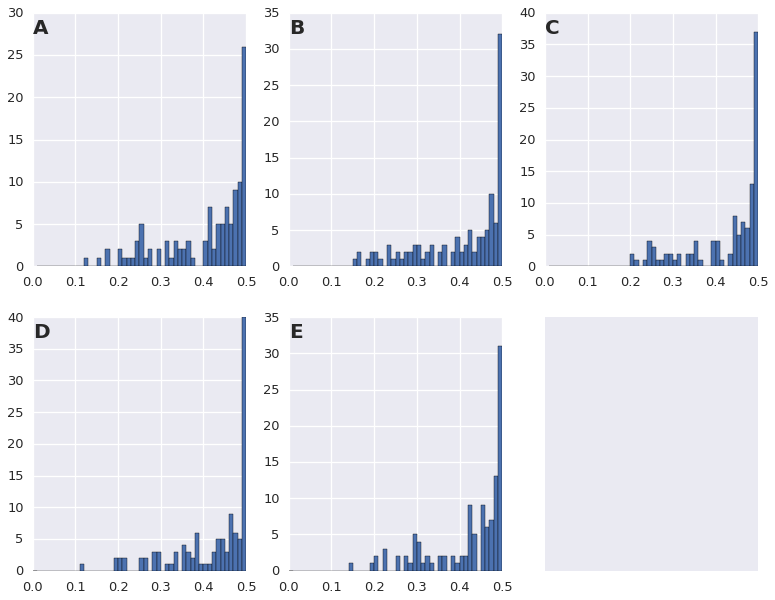

In [1254]:
with PdfPages('/home/lindb/wbp/figures/grid_imp_hexp_hist_by_pheno_top_alphas_999.pdf') as pdf:
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6)) = plt.subplots(2, 3, figsize=(5,5),dpi=400)

    a1 = plt.subplot(231)
    a1.hist(outlierdata['bfpopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a1.set_title('A',y=.9,loc='left',fontsize=20,fontweight='bold')
    a1.spines['right'].set_visible(False)
    a1.spines['top'].set_visible(False)
    a1.yaxis.set_ticks_position('left')
    a1.xaxis.set_ticks_position('bottom')
    
    a2 = plt.subplot(232)
    a2.hist(outlierdata['c13popx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a2.set_title('B',y=.9,loc='left',fontsize=20,fontweight='bold')
    a2.spines['right'].set_visible(False)
    a2.spines['top'].set_visible(False)
    a2.yaxis.set_ticks_position('left')
    a2.xaxis.set_ticks_position('bottom')
    
    a3 = plt.subplot(233)
    a3.hist(outlierdata['htpopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a3.set_title('C',y=.9,loc='left',fontsize=20,fontweight='bold')
    a3.spines['right'].set_visible(False)
    a3.spines['top'].set_visible(False)
    a3.yaxis.set_ticks_position('left')
    a3.xaxis.set_ticks_position('bottom')
    
    a4 = plt.subplot(234)
    a4.hist(outlierdata['n15popx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a4.set_title('D',y=.9,loc='left',fontsize=20,fontweight='bold')
    a4.spines['right'].set_visible(False)
    a4.spines['top'].set_visible(False)
    a4.yaxis.set_ticks_position('left')
    a4.xaxis.set_ticks_position('bottom')
    
    a5 = plt.subplot(235)
    a5.hist(outlierdata['rspopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a5.set_title('E',y=.9,loc='left',fontsize=20,fontweight='bold')
    a5.spines['right'].set_visible(False)
    a5.spines['top'].set_visible(False)
    a5.yaxis.set_ticks_position('left')
    a5.xaxis.set_ticks_position('bottom')
    
    a6.spines['right'].set_visible(False)
    a6.spines['left'].set_visible(False)
    a6.spines['top'].set_visible(False)
    a6.spines['bottom'].set_visible(False)
    a6.axes.get_yaxis().set_visible(False)
    a6.axes.get_xaxis().set_ticks([])
    a6.axes.get_yaxis().set_ticks([])
    
    fig.set_size_inches(13,10)
    pdf.savefig(fig,bbox_inches='tight')

In [1255]:
#get sets of SNPs to make random draws
nonsigsnps = OrderedDict()
for pheno in outlierdata.keys():
    nonsigs = list(set(H.index.tolist()) - set(outlierdata[pheno].index.tolist()))
    nonsigsnps[pheno] = pd.DataFrame(H[H.index.isin(nonsigs)])
    print len(outlierdata[pheno].index.tolist())+len(nonsigsnps[pheno].index)

115632
115632
115632
115632
115632


In [1256]:
#how many random snps to draw from each bin?
binCounter = OrderedDict()
for pheno in outlierdata.keys():
    binCounter[pheno] = Counter()
    for row in outlierdata[pheno].index:
        binCounter[pheno][outlierdata[pheno].loc[row,'bin']] += 1
    for b in binCounter[pheno].keys():
        print pheno,b,binCounter[pheno][b]

bfpopx 12 1
bfpopx 15 1
bfpopx 17 2
bfpopx 20 2
bfpopx 21 1
bfpopx 22 1
bfpopx 23 1
bfpopx 24 3
bfpopx 25 5
bfpopx 26 1
bfpopx 27 2
bfpopx 28 1
bfpopx 29 1
bfpopx 31 3
bfpopx 32 1
bfpopx 33 3
bfpopx 34 2
bfpopx 35 2
bfpopx 36 3
bfpopx 37 1
bfpopx 40 3
bfpopx 41 7
bfpopx 42 2
bfpopx 43 5
bfpopx 44 5
bfpopx 45 7
bfpopx 46 5
bfpopx 47 9
bfpopx 48 10
bfpopx 49 26
c13popx 15 1
c13popx 16 2
c13popx 18 1
c13popx 19 2
c13popx 20 3
c13popx 23 3
c13popx 24 1
c13popx 25 2
c13popx 26 1
c13popx 27 2
c13popx 28 3
c13popx 29 2
c13popx 30 3
c13popx 31 1
c13popx 32 2
c13popx 33 3
c13popx 35 2
c13popx 36 3
c13popx 38 2
c13popx 39 4
c13popx 40 2
c13popx 41 3
c13popx 42 5
c13popx 43 2
c13popx 44 4
c13popx 45 4
c13popx 46 5
c13popx 47 10
c13popx 48 6
c13popx 49 32
htpopx 20 3
htpopx 23 1
htpopx 24 4
htpopx 25 3
htpopx 26 1
htpopx 27 1
htpopx 28 4
htpopx 30 1
htpopx 31 2
htpopx 33 2
htpopx 34 2
htpopx 35 4
htpopx 36 1
htpopx 39 4
htpopx 40 4
htpopx 41 1
htpopx 43 2
htpopx 44 8
htpopx 45 5
htpopx 46 7
htpopx

In [1257]:
os.makedirs('/home/lindb/wbp/gemma/covariances_top_alphas/randmatrices')
os.makedirs('/home/lindb/wbp/gemma/covariances_top_alphas/randmatrices/randsnps')

In [1258]:
for pheno in outlierdata.keys():
    print pheno,len(outlierdata[pheno].index)

bfpopx 116
c13popx 116
htpopx 116
n15popx 116
rspopx 116


In [1259]:
#for each pheno make 1000 dataframes with a set of snps == len(outliersnps[pheno])
for pheno in outlierdata.keys():
    print pheno
    for i in range(1000):  
        snps = []        
        for binn in binCounter[pheno].keys():
            data = nonsigsnps[pheno][nonsigsnps[pheno]['bin'] == binn]
                
            [snps.append(snp) for snp in random.sample(data.index,binCounter[pheno][binn])]
        
        assert len(np.unique(snps).tolist()) == sum(binCounter[pheno].values())

        DIR = '/home/lindb/wbp/gemma/covariances_top_alphas/randmatrices/randsnps/%s' % pheno
        if not op.exists(DIR):
            os.makedirs(DIR)
        filE = op.join(DIR,"%s_%s_randsnps.txt" % (pheno,str(i).zfill(3)))
        df = pd.DataFrame(snps)
        df.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
c13popx
htpopx
n15popx
rspopx


In [1260]:
#do it all at once, ninjas (quicker to do it this way)
#you found the easter egg!
#get dvals for the sets of random snps for each pheno
for pheno in outlierdata.keys():
    for i in range(1000):
        text = '''from __future__ import division
import os
from collections import OrderedDict,Counter
import pandas as pd
import numpy as np
import random
import math
from os import path as op
from os import listdir as ls


#get a dict with num indiv in pop
#population sizes (only for individuals in pops with phenotypic measurements)
popDict = {'Dicks_Pass':15,
'Freel_Peak':19,
'Little_Round_Top':14,
'Mt_Rose_Ophir':11,
'Rifle_Peak':15,
'Snow_Valley_Peak':14,}


filE = '/home/lindb/wbp/gemma/6pop_glob_mafs.txt'
globs = pd.read_csv(filE,header=0,sep='\\t')
glob = OrderedDict()
for row in globs.index:
    snp = globs.loc[row,'locus']
    maf = globs.loc[row,'maf']
    glob[snp] = maf

impMAF = pd.read_csv('/home/lindb/wbp/gemma/6pop_pop_maf.txt',header=0,index_col=0,sep="\\t")

filE= '/home/lindb/wbp/gemma/covariances_top_alphas/randmatrices/randsnps/%s/%s_%s_randsnps.txt' 
df = pd.read_csv(filE,header=None,sep="\\t")
randomsnps = df[0].tolist()

dijDict = OrderedDict() 
for i,locusi in enumerate(randomsnps):
    dijDict[locusi] = OrderedDict()
    qi = glob[locusi] #global maf

    for j,locusj in enumerate(randomsnps):
        if i > j: #i=row, j=col : lower triangle 
            qj = glob[locusj] #global maf

            sums = 0
            for pop in impMAF.columns:
                qik = impMAF.loc[locusi,pop] #get pop maf
                qjk = impMAF.loc[locusj,pop] #get pop maf
                nk = popDict[pop]

                sums += (nk/88)*((qik*qjk)-(qi*qj))

            dijDict[locusi][locusj] = sums
        else:
            dijDict[locusi][locusj] = np.nan

filE = '/home/lindb/wbp/gemma/covariances_top_alphas/randmatrices/randDVALS/%s/%s_%s_randDVALS.txt'
if not op.exists('/home/lindb/wbp/gemma/covariances_top_alphas/randmatrices/randDVALS/'):
    os.makedirs('/home/lindb/wbp/gemma/covariances_top_alphas/randmatrices/randDVALS/')
DIR = op.dirname(filE)
if not op.exists(DIR):
    os.makedirs(DIR)

with open(filE,'w') as o:
    key0 = dijDict.keys()[0]
    line = '\\t'.join(dijDict[key0].keys()) + str('\\n')
    o.write("%%s" %% line)
    for locusi in dijDict.keys():
        line = str(locusi)+'\\t'+'\\t'.join([str(x) for x in dijDict[locusi].values()]) + str('\\n')
        o.write("%%s" %% line)
        
''' % (pheno,pheno,str(i).zfill(3),
       pheno,pheno,str(i).zfill(3))
        filE = '/home/lindb/wbp/gemma/covariances_top_alphas/randmatrices/randpyfiles/get_rand_dvals_%s_%s.py' % (pheno,
                                                                                                      str(i).zfill(3)
                                                                                                     )
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [1261]:
#get the python scripts
DIR = '/home/lindb/wbp/gemma/covariances_top_alphas/randmatrices/randpyfiles/'
pyfiles = [op.join(DIR,f) for f in ls(DIR)]
len(pyfiles)

5000

In [1263]:
#spread out the jobs
count = 0
fcount = 0
tcount = 0
for f in sorted(pyfiles):
    if count == 0:
        text = 'python %s\n' % f
    else:
        newtext = 'python %s\n' % f
        text = text + newtext
    count += 1
    tcount += 1
    if (count == 125) or (tcount == 5000):
        count = 0
        fcount += 1
        filE = '/home/lindb/wbp/gemma/covariances_top_alphas/randmatrices/runpyfiles/%s_cmds.txt' % str(fcount).zfill(3)
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [1264]:
#make qsub files
for i in range(40):
    j = i+1
    text = '''#!/bin/bash
#$ -N pyfile%s
#$ -V
#$ -j y
#$ -cwd

cat %s_cmds.txt | parallel --progress --

''' % (str(j).zfill(3),
       str(j).zfill(3)
      )
    filE = '/home/lindb/wbp/gemma/covariances_top_alphas/randmatrices/runpyfiles/%s_run.sh' % str(j).zfill(3)
    with open(filE,'w') as o:
        o.write("%s" % text)

In [1265]:
#qsub the qsubs

In [1299]:
#check on progress
DIR = '/home/lindb/wbp/gemma/covariances_top_alphas/randmatrices/randDVALS/'
ds = [op.join(DIR,d) for d in ls(DIR)]
count = 0
for DIR in ds:
    count = count + len(ls(DIR))
count

5000

In [1300]:
# get observed dvals and median vals from random snps
dvals = OrderedDict()
medvals = OrderedDict()
for pheno in outlierdata.keys():
    print pheno
    DF = pd.read_csv('/home/lindb/wbp/gemma/covariances_top_alphas/dvals/%s_dvals.txt' % pheno,
                     header=0,index_col=0,sep="\t")
    dvals[pheno] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[pheno].append(abs(DF.loc[row,col]))

    DIR = '/home/lindb/wbp/gemma/covariances_top_alphas/randmatrices/randDVALS/%s/' % pheno
    files = [op.join(DIR,f) for f in ls(DIR)]

    fcount = 0
    medvals[pheno] = []
    for f in files:
        df = pd.read_csv(f,header=0,index_col=0,sep="\t")
        rvals = [] #random dij values
        for lst in df.values.tolist():
            for x in lst:
                if math.isnan(x) == False:
                    rvals.append(x)


        medvals[pheno].append(np.median([abs(val) for val in rvals]))

        fcount += 1
        if fcount % 100 == 0:
            print fcount

    filE = '/home/lindb/wbp/gemma/covariances_top_alphas/randmatrices/randmedvals/%s_randmedvalues.txt' % pheno
    if not op.exists(op.dirname(filE)):
        os.makedirs(op.dirname(filE))
    medvaldf = pd.DataFrame(medvals[pheno])
    medvaldf.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
100
200
300
400
500
600
700
800
900
1000
c13popx
100
200
300
400
500
600
700
800
900
1000
htpopx
100
200
300
400
500
600
700
800
900
1000
n15popx
100
200
300
400
500
600
700
800
900
1000
rspopx
100
200
300
400
500
600
700
800
900
1000


In [1301]:
n5th = OrderedDict()    #get 95th percentile
gt_hth = OrderedDict()  #how much greater is the empirical median dvalue than the 100th percentile of random SNPs?
gt_n5th = OrderedDict() #how much greater is the empirical median dvalue than the 95th percentile of random SNPs?
bmax=OrderedDict()      #below what percentile of the observed dvals are the values less than the maximum randdvals
bn5th = OrderedDict()   #below what percentile of the observed dvals are the values less than the 95th perc randdvals
for pheno in outlierdata.keys():
    print pheno,'has',len(alphasnps999[pheno]),'SNPs in intersection of top PIPs and top effects (alpha+beta)'
    sorts        = sorted(medvals[pheno])
    n5th[pheno]    = sorts[949]
    gt_hth[pheno]  = np.median(dvals[pheno])/max(medvals[pheno])
    print 'emp median is %sx greater than 100th percentile of random'%str(round(gt_hth[pheno],3))
    gt_n5th[pheno] = np.median(dvals[pheno])/n5th[pheno]
    print 'emp median is %sx greater than 95th percentile of random'%str(round(gt_n5th[pheno],3))
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < max(sorts): #the max(randDval) corresponds to the xth percentile of empirical d-values
            bmax[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < sorts[949]:
            bn5th[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    print 'the max random value corresponds to the %s precentile' % str(round(bmax[pheno][1],3)*100),"(%s/%s)" % (bmax[pheno][0],len(dvals[pheno])),'of emp values'
    print 'the 95th perc rand val corresponds to the %s percentile',str(round(bn5th[pheno][1],3)*100),"(%s/%s)" % (bn5th[pheno][0],len(dvals[pheno])),'of emp values'
    print 'emp med dval =',"{:.4}".format(np.median(dvals[pheno]))
    print 'max rand dval =',"{:.4}".format(max(medvals[pheno]))
    print '95th rand dval =',"{:.4}".format(n5th[pheno])
    print '\n'

bfpopx has 116 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.96x greater than 100th percentile of random
emp median is 1.174x greater than 95th percentile of random
the max random value corresponds to the 51.2 precentile (3415/6670) of emp values
the 95th perc rand val corresponds to the %s percentile 45.4 (3029/6670) of emp values
emp med dval = 0.003899
max rand dval = 0.004062
95th rand dval = 0.00332


c13popx has 116 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.884x greater than 100th percentile of random
emp median is 1.134x greater than 95th percentile of random
the max random value corresponds to the 53.1 precentile (3542/6670) of emp values
the 95th perc rand val corresponds to the %s percentile 46.6 (3109/6670) of emp values
emp med dval = 0.004276
max rand dval = 0.004836
95th rand dval = 0.003771


htpopx has 116 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.754x greater than 10

# intersections of SNPs

                                         Intersections with top PIPs

### intersection of top PIPs and OutFLANK

In [1102]:
for pheno in toppips:
    print pheno,len(toppips[pheno])

rspopx 117
bfpopx 118
c13popx 122
n15popx 117
htpopx 117


In [278]:
outflank = '/home/lindb/wbp/OutFLANK/OutFLANK_snps.txt'
outdf = pd.read_csv(outflank,header=0,sep='\t')
outflanksnps = outdf['x'].tolist()
len(outflanksnps)

110

In [1106]:
#intersections
for pheno in toppips:
    snps = set(toppips[pheno]).intersection(set(outflanksnps))
    if len(snps)>0:
        print pheno,len(snps)

### intersection of top PIPs and bayenv2

In [231]:
#get bayenv2 snps
DIR = '/home/lindb/wbp/bayenv2/results/sigsnps'
bayfs = [op.join(DIR,f) for f in ls(DIR)]
baydict = {}
for f in bayfs:
    env = op.basename(f).split("_")[0]
    df = pd.read_csv(f,header=0,sep='\t')
    baydict[env] = df[env].tolist()
    print env,len(baydict[env])

AWS0-25 95
AWS0-50 147
Ann-ppt 49
CEC 14
Clay 22
Elev 143
GDD-Aug 157
GDD-May 80
Lat 119
Lon 67
Max-rad-input 144
Rock-cov 143
Sand 111
Silt 140
Tmax-July 50
Tmin-Jan 116
WC15Bar 86
WC3rdbar 97


In [1110]:
#intersection
for pheno in toppips:
    for evn in baydict:
        snps = set(toppips[pheno]).intersection(set(baydict[env]))
        if len(snps) > 0:
            print pheno,env,len(snps)

### intersection of top PIPs across phenotypes

In [1111]:
for i,phenoi in enumerate(toppips):
    for j,phenoj in enumerate(toppips):
        if i>j:
            snps = set(toppips[phenoi]).intersection(toppips[phenoj])
            if len(snps) > 0:
                print phenoi,phenoj,len(snps)

bfpopx rspopx 1
n15popx c13popx 1


                                  Intersections with top 0.998 PIPs

In [1998]:
d

rspopx 232
bfpopx 232
c13popx 232
n15popx 232
htpopx 232


In [276]:
for pheno in pip998:
    print pheno,len(pip998[pheno])

rspopx 234
bfpopx 240
c13popx 240
n15popx 232
htpopx 238


In [2007]:
#large effect snps from LMM (-ln(p_wald) >= 10)
len(outloci)

15

### with OutFLANK

In [279]:
for pheno in pip998:
    snps = set(pip998[pheno]).intersection(set(outflanksnps))
    if len(snps) > 0:
        print pheno,len(snps)
        for snp in snps:
            if snp in outloci:
                print snp

### with bayenv2

In [284]:
for pheno in sorted(pip998):
    for env in sorted(baydict):
        snps = set(pip998[pheno]).intersection(baydict[env])
        if len(snps) > 0:
            print pheno,env,len(snps)
#             for snp in snps:
#                 if snp in outloci:
#                     print snp

bfpopx GDD-May 1
bfpopx Rock-cov 1
c13popx Elev 1
c13popx Lat 2
c13popx Tmin-Jan 1
c13popx WC3rdbar 1
htpopx Clay 1
htpopx Elev 1
htpopx Max-rad-input 2
htpopx Tmax-July 1
n15popx AWS0-50 1
n15popx Sand 1
rspopx Elev 1


### across phenotypes

In [275]:
for i,phenoi in enumerate(sorted(pip998)):
    for j,phenoj in enumerate(sorted(pip998)):
        if i > j:
            snps = set(pip998[phenoi]).intersection(set(pip998[phenoj]))
            if len(snps) > 0 :
                print phenoi,phenoj,len(snps)
                for snp in snps:
                    if snp in outloci:
                        print snp

n15popx c13popx 1
n15popx htpopx 1
rspopx bfpopx 3


### bayenv with outloci

In [2008]:
for env in baydict:
    snps = set(baydict[env]).intersection(set(outloci))
    if len(snps) > 0:
        print env,len(snps)

Rock-cov 1


### outflank with outloci

In [2009]:
len(set(outflanksnps).intersection(set(outloci)))

0

### bayenv2 with bayenv2

In [2012]:
for i,envi in enumerate(sorted(baydict)):
    for j,envj in enumerate(sorted(baydict)):
        if i > j:
            snps = set(baydict[envi]).intersection(set(baydict[envj]))
            if len(snps) > 0:
                print envi,envj,len(snps)

AWS0-50 AWS0-25 75
Elev AWS0-25 2
Elev AWS0-50 2
Elev Ann-ppt 1
Elev Clay 2
GDD-Aug AWS0-50 1
GDD-Aug Ann-ppt 1
GDD-Aug Elev 43
GDD-May Elev 12
GDD-May GDD-Aug 6
Lat AWS0-25 1
Lat AWS0-50 1
Lat Clay 1
Lat Elev 26
Lat GDD-Aug 10
Lat GDD-May 9
Lon AWS0-25 1
Lon AWS0-50 1
Lon Ann-ppt 18
Lon GDD-May 1
Max-rad-input AWS0-25 4
Max-rad-input AWS0-50 8
Max-rad-input GDD-Aug 1
Max-rad-input GDD-May 1
Max-rad-input Lon 1
Rock-cov Ann-ppt 17
Rock-cov CEC 2
Rock-cov Elev 2
Rock-cov GDD-Aug 2
Rock-cov GDD-May 8
Rock-cov Lon 19
Rock-cov Max-rad-input 4
Sand AWS0-25 23
Sand AWS0-50 32
Sand Elev 1
Sand GDD-Aug 2
Sand GDD-May 4
Sand Lon 1
Sand Max-rad-input 7
Silt AWS0-25 43
Silt AWS0-50 73
Silt GDD-Aug 2
Silt GDD-May 1
Silt Max-rad-input 13
Silt Sand 63
Tmax-July AWS0-25 5
Tmax-July AWS0-50 9
Tmax-July Elev 2
Tmax-July GDD-May 4
Tmax-July Lat 3
Tmax-July Lon 1
Tmax-July Max-rad-input 1
Tmax-July Silt 3
Tmin-Jan Ann-ppt 20
Tmin-Jan Elev 10
Tmin-Jan GDD-Aug 22
Tmin-Jan Lon 15
Tmin-Jan Rock-cov 22
Tmin-J

                                  Intersections with top 0.999 total effects

In [ ]:
#0.999 total effect snps
for pheno in snpdict999.keys():
    print pheno,len(snpdict999[pheno])

### intersection with OutFLANK

In [1113]:
#intersection
for pheno in snpdict999:
    snps = set(snpdict999[pheno]).intersection(set(outflanksnps))
    if len(snps)>0:
        print pheno,len(snps)

### inersection with bayenv2

In [1114]:
for pheno in snpdict999.keys():
    for env in baydict.keys():
        snps = set(snpdict999[pheno]).intersection(set(baydict[env]))
        if len(snps)>0:
            print pheno,env,len(snps)

### intersection across phenotypes

In [1115]:
for i,phenoi in enumerate(snpdict999.keys()):
    for j,phenoj in enumerate(snpdict999.keys()):
        if i>j:
            snps = set(snpdict999[phenoi]).intersection(set(snpdict999[phenoj]))
            if len(snps) > 0:
                print phenoi,phenoj,len(snps)

n15popx c13popx 1


                                  Intersections with top 0.995 total effects

In [1117]:
for pheno in snpdict995.keys():
    print pheno,len(snpdict995[pheno])

rspopx 292
bfpopx 202
c13popx 73
n15popx 9
htpopx 20


### intersection with OutFLANK

In [1118]:
for pheno in snpdict995.keys():
    snps = set(snpdict995[pheno]).intersection(set(outflanksnps))
    if len(snps) > 0:
        print pheno,len(snps)

### intersection with bayenv2

In [1119]:
for pheno in snpdict995.keys():
    for env in baydict.keys():
        snps = set(snpdict995[pheno]).intersection(set(baydict[env]))
        if len(snps) > 0:
            print pheno,env,len(snps)

rspopx Elev 1
c13popx Tmin-Jan 1


### intersection across phenotypes

In [1123]:
for i,phenoi in enumerate(snpdict995.keys()):
    for j,phenoj in enumerate(snpdict995.keys()):
        if i>j:
            snps = set(snpdict995[phenoi]).intersection(set(snpdict995[phenoj]))
            if len(snps) > 0:
                print phenoi,phenoj,len(snps)

bfpopx rspopx 3
n15popx c13popx 2


                                  Intersections with top 0.990 total effects

In [1529]:
#snps
for pheno in effect_snps:
    print pheno,len(effect_snps[pheno])

bfpopx 311
n15popx 30
c13popx 113
rspopx 492
htpopx 38


### intersection with OutFLANK

In [1121]:
#intersection
for pheno in effect_snps.keys():
    snps = set(effect_snps[pheno]).intersection(set(outflanksnps))
    if len(snps) > 0:
        print pheno,len(snps)

### intersection with bayenv2

In [1122]:
for pheno in effect_snps.keys():
    for env in baydict.keys():
        snps = set(effect_snps[pheno]).intersection(set(baydict[env]))
        if len(snps) > 0:
            print pheno,env,len(snps)

c13popx Tmin-Jan 1
rspopx Elev 1


### intersection across phenotypes

In [1124]:
for i,phenoi in enumerate(effect_snps.keys()):
    for j,phenoj in enumerate(effect_snps.keys()):
        if i>j:
            snps = set(effect_snps[phenoi]).intersection(set(effect_snps[phenoj]))
            if len(snps) > 0:
                print phenoi,phenoj,len(snps)

c13popx bfpopx 2
c13popx n15popx 3
rspopx bfpopx 9
htpopx rspopx 2


                                  Intersections with top 0.999 and 0.995 alpha

In [1534]:
for pheno in sorted(alphasnps):
    for q in alphasnps[pheno]:
        print pheno,q,len(alphasnps[pheno][q])

bfpopx 0.999 116
bfpopx 0.995 578
c13popx 0.999 116
c13popx 0.995 579
htpopx 0.999 116
htpopx 0.995 579
n15popx 0.999 116
n15popx 0.995 579
rspopx 0.999 116
rspopx 0.995 578


In [1302]:
#snps
for pheno in alphasnps999:
    print pheno,len(alphasnps999[pheno])

bfpopx 116
n15popx 116
c13popx 116
rspopx 116
htpopx 116


### intersection with OutFLANK

In [1535]:
q = 0.999
for pheno in alphasnps:
    snps = set(alphasnps[pheno][q]).intersection(outflanksnps)
    if len(snps) > 0:
        print pheno,len(snps)

n15popx 2


In [1537]:
q = 0.995
for pheno in alphasnps:
    snps = set(alphasnps[pheno][q]).intersection(outflanksnps)
    if len(snps) > 0:
        print pheno,len(snps)

c13popx 2
n15popx 9
htpopx 3


### intersection with bayenv2

In [1538]:
q = 0.999
for pheno in alphasnps:
    for env in baydict:
        snps = set(alphasnps[pheno][q]).intersection(baydict[env])
        if len(snps) > 0:
            print pheno,env,len(snps)

In [1539]:
q = 0.995
for pheno in alphasnps:
    for env in baydict:
        snps = set(alphasnps[pheno][q]).intersection(baydict[env])
        if len(snps) > 0:
            print pheno,env,len(snps)

rspopx Elev 1
c13popx Tmin-Jan 1


### intersection across phenotypes

In [1540]:
q = 0.999
for i,phenoi in enumerate(alphasnps):
    for j,phenoj in enumerate(alphasnps):
        if i>j:
            snps = set(alphasnps[phenoi][q]).intersection(set(alphasnps[phenoj][q]))
            if len(snps) > 0:
                print phenoi,phenoj,len(snps)

bfpopx rspopx 2
c13popx bfpopx 1
n15popx bfpopx 1
n15popx c13popx 9
htpopx rspopx 1
htpopx n15popx 1


In [1541]:
q = 0.995
for i,phenoi in enumerate(alphasnps):
    for j,phenoj in enumerate(alphasnps):
        if i>j:
            snps = set(alphasnps[phenoi][q]).intersection(set(alphasnps[phenoj][q]))
            if len(snps) > 0:
                print phenoi,phenoj,len(snps)

bfpopx rspopx 25
c13popx rspopx 20
c13popx bfpopx 20
n15popx rspopx 9
n15popx bfpopx 22
n15popx c13popx 58
htpopx rspopx 29
htpopx bfpopx 16
htpopx c13popx 28
htpopx n15popx 22


                                     Intersections with top 0.999 and 0.995 beta

In [1515]:
#get the betasnps
betasnps = {}
for pheno in combined_dfs:
    betasnps[pheno] = {}
    d = combined_dfs[pheno]
    x = 'beta_hmean'
    for q in [0.999,0.995]:
        cutoff = d[x].quantile(q)
        xvals = d[x][d[x]>=cutoff]
        betasnps[pheno][q] = xvals.index
        print pheno,q,len(xvals.index)

bfpopx 0.999 116
bfpopx 0.995 578
n15popx 0.999 116
n15popx 0.995 579
c13popx 0.999 116
c13popx 0.995 579
rspopx 0.999 116
rspopx 0.995 578
htpopx 0.999 116
htpopx 0.995 579


### intersection with OutFLANK

In [1598]:
for pheno in betasnps:
    for q in betasnps[pheno]:
        snps = set(betasnps[pheno][q]).intersection(set(outflanksnps))
        if len(snps) > 0:
            print pheno,q,len(snps)

n15popx 0.999 1
n15popx 0.995 6
htpopx 0.995 1


### intersection with bayenv2

In [1517]:
for pheno in betasnps:
    for q in betasnps[pheno]:
        for env in baydict:
            snps = set(betasnps[pheno][q]).intersection(set(baydict[env]))
            if len(snps) > 0:
                print pheno,q,env,len(snps)

rspopx 0.999 Elev 1
rspopx 0.995 Elev 1
rspopx 0.995 GDD-Aug 1
c13popx 0.995 Tmin-Jan 1
htpopx 0.995 Max-rad-input 1


### intersection across phenotypes

In [1526]:
sorted(betasnps.keys())

['bfpopx', 'c13popx', 'htpopx', 'n15popx', 'rspopx']

In [1527]:
qi = 0.999
for i,phenoi in enumerate(betasnps):
    for j,phenoj in enumerate(betasnps):
        if i > j:
            snps = set(betasnps[phenoi][qi]).intersection(set(betasnps[phenoj][qi]))
            if len(snps) > 0:
                print phenoi,phenoj,qi,len(snps)

n15popx c13popx 0.999 5
htpopx bfpopx 0.999 1
htpopx c13popx 0.999 1
htpopx n15popx 0.999 1


In [1528]:
qi = 0.995
for i,phenoi in enumerate(betasnps):
    for j,phenoj in enumerate(betasnps):
        if i > j:
            snps = set(betasnps[phenoi][qi]).intersection(set(betasnps[phenoj][qi]))
            if len(snps) > 0:
                print phenoi,phenoj,qi,len(snps)

bfpopx rspopx 0.995 13
c13popx rspopx 0.995 9
c13popx bfpopx 0.995 10
n15popx rspopx 0.995 10
n15popx bfpopx 0.995 13
n15popx c13popx 0.995 42
htpopx rspopx 0.995 15
htpopx bfpopx 0.995 10
htpopx c13popx 0.995 14
htpopx n15popx 0.995 18


                                Intersections with top 0.999 and 0.995 total effect

In [1552]:
fxsnps = {}
for pheno in combined_dfs:
    fxsnps[pheno] = {}
    d = combined_dfs[pheno]
    x = 'total_effect'
    for q in [0.995,0.999]:
        cutoff = d[x].quantile(q)
        xvals = d[x][d[x]>=cutoff]
        fxsnps[pheno][q] = xvals.index.tolist()
        print pheno,q,len(xvals.index)

bfpopx 0.995 578
bfpopx 0.999 116
n15popx 0.995 579
n15popx 0.999 116
c13popx 0.995 579
c13popx 0.999 116
rspopx 0.995 578
rspopx 0.999 116
htpopx 0.995 579
htpopx 0.999 116


### intersection with OutFLANK

In [1553]:
q = 0.999
for pheno in fxsnps:
    snps = set(fxsnps[pheno][q]).intersection(set(outflanksnps))
    if len(snps) > 0:
        print pheno,len(snps)

n15popx 1


In [1554]:
q = 0.999
for pheno in fxsnps:
    snps = set(fxsnps[pheno][q]).intersection(set(outflanksnps))
    if len(snps) > 0:
        print pheno,len(snps)

n15popx 1


### intersection with bayenv2

In [1555]:
q = 0.999
for pheno in fxsnps:
    for env in baydict:
        snps = set(fxsnps[pheno][q]).intersection(set(baydict[env]))
        if len(snps) > 0:
            print pheno,env,len(snps)

rspopx Elev 1


In [1556]:
q = 0.995
for pheno in fxsnps:
    for env in baydict:
        snps = set(fxsnps[pheno][q]).intersection(set(baydict[env]))
        if len(snps) > 0:
            print pheno,env,len(snps)

rspopx Elev 1
rspopx GDD-Aug 1
c13popx Tmin-Jan 1
htpopx Max-rad-input 1


                                     Intersections among criteria

### alpha and beta

In [1543]:
q = 0.999
for i,phenoi in enumerate(alphasnps):
    for j,phenoj in enumerate(betasnps):
        snps = set(alphasnps[pheno]).intersection(betasnps[phenoj][q])
        if len(snps) > 0:
            print phenoi,phenoj,len(snps)

In [1544]:
q = 0.995
for i,phenoi in enumerate(alphasnps):
    for j,phenoj in enumerate(betasnps):
        snps = set(alphasnps[pheno]).intersection(betasnps[phenoj][q])
        if len(snps) > 0:
            print phenoi,phenoj,len(snps)

### alpha and pip

In [1545]:
q = 0.999
for i,phenoi in enumerate(alphasnps):
    for j,phenoj in enumerate(toppips):
        snps = set(alphasnps[phenoi][q]).intersection(toppips[phenoj ])
        if len(snps) > 0:
            print phenoi,phenoj,len(snps)

rspopx rspopx 78
rspopx bfpopx 2
bfpopx rspopx 1
bfpopx bfpopx 72
c13popx bfpopx 1
c13popx c13popx 29
c13popx n15popx 1
n15popx bfpopx 1
n15popx c13popx 2
n15popx n15popx 5
htpopx n15popx 1
htpopx htpopx 7


In [1546]:
q = 0.995
for i,phenoi in enumerate(alphasnps):
    for j,phenoj in enumerate(toppips):
        snps = set(alphasnps[phenoi][q]).intersection(toppips[phenoj ])
        if len(snps) > 0:
            print phenoi,phenoj,len(snps)

rspopx rspopx 113
rspopx bfpopx 10
rspopx c13popx 3
bfpopx rspopx 3
bfpopx bfpopx 95
bfpopx c13popx 1
bfpopx htpopx 1
c13popx rspopx 3
c13popx bfpopx 2
c13popx c13popx 31
c13popx n15popx 3
c13popx htpopx 1
n15popx rspopx 1
n15popx bfpopx 2
n15popx c13popx 4
n15popx n15popx 5
n15popx htpopx 1
htpopx rspopx 6
htpopx bfpopx 1
htpopx c13popx 1
htpopx n15popx 3
htpopx htpopx 8


### beta and pip

In [1547]:
q = 0.999
for i,phenoi in enumerate(betasnps):
    for j,phenoj in enumerate(toppips):
        snps = set(betasnps[phenoi][q]).intersection(set(toppips[phenoj]))
        if len(snps) > 0:
            print phenoi,phenoj, len(snps)

rspopx rspopx 79
bfpopx rspopx 1
bfpopx bfpopx 70
c13popx c13popx 27
c13popx n15popx 1
n15popx bfpopx 1
n15popx c13popx 2
n15popx n15popx 5
htpopx htpopx 7


In [1548]:
q = 0.995
for i,phenoi in enumerate(betasnps):
    for j,phenoj in enumerate(toppips):
        snps = set(betasnps[phenoi][q]).intersection(set(toppips[phenoj]))
        if len(snps) > 0:
            print phenoi,phenoj, len(snps)

rspopx rspopx 114
rspopx bfpopx 6
rspopx c13popx 2
bfpopx rspopx 2
bfpopx bfpopx 92
bfpopx n15popx 1
c13popx rspopx 1
c13popx bfpopx 2
c13popx c13popx 31
c13popx n15popx 2
c13popx htpopx 1
n15popx rspopx 1
n15popx bfpopx 3
n15popx c13popx 3
n15popx n15popx 5
n15popx htpopx 1
htpopx rspopx 5
htpopx c13popx 2
htpopx n15popx 3
htpopx htpopx 7


### top fx and alpha

In [ ]:
q = 0.999
for i,phenoi

In [1551]:
for pheno in snpdict999:
    print pheno,len(snpdict999[pheno])

 rspopx 79
bfpopx 70
c13popx 27
n15popx 5
htpopx 7


### intersection across bayenv

In [1572]:
from operator import itemgetter

In [1595]:
uniqs = {}
for i,envi in enumerate(sorted(baydict)):
    for j,envj in enumerate(sorted(baydict)):
        if i>j:
            combo = "%s %s" % (envi,envj)
            uniqs[combo] = []
            [uniqs[combo].append(snp) for snp in baydict[envi] if not snp in uniqs[combo]]
            [uniqs[combo].append(snp) for snp in baydict[envj] if not snp in uniqs[combo]]

In [1594]:
bayint = {}
bayintl = {}
for i,envi in enumerate(sorted(baydict)):
    for j,envj in enumerate(sorted(baydict)):
        if i >j:
            snps = set(baydict[envi]).intersection(set(baydict[envj]))
            if len(snps) > 0:
                bayint["%s %s" % (envi,envj)] = snps
                bayintl["%s %s" % (envi,envj)] = len(snps)
for combo,snps in sorted(bayintl.items(),key=lambda x: x[1],reverse=True):
    print combo,bayintl[combo],len(uniqs[combo]),round((bayintl[combo]/len(uniqs[combo]))*100,2)

AWS0-50 AWS0-25 75 167 44.91
Silt AWS0-50 73 214 34.11
Silt Sand 63 188 33.51
WC15Bar AWS0-50 49 184 26.63
WC3rdbar WC15Bar 46 137 33.58
Silt AWS0-25 43 192 22.4
GDD-Aug Elev 43 257 16.73
WC15Bar Silt 42 184 22.83
WC3rdbar AWS0-50 35 209 16.75
Sand AWS0-50 32 226 14.16
WC15Bar AWS0-25 30 151 19.87
WC3rdbar Silt 27 210 12.86
Lat Elev 26 236 11.02
Sand AWS0-25 23 183 12.57
Tmin-Jan Rock-cov 22 237 9.28
Tmin-Jan GDD-Aug 22 251 8.76
Tmin-Jan Ann-ppt 20 145 13.79
Rock-cov Lon 19 191 9.95
Lon Ann-ppt 18 98 18.37
Rock-cov Ann-ppt 17 175 9.71
WC15Bar Sand 16 181 8.84
Tmin-Jan Lon 15 168 8.93
WC3rdbar AWS0-25 13 179 7.26
Silt Max-rad-input 13 271 4.8
GDD-May Elev 12 211 5.69
Tmin-Jan Elev 10 249 4.02
Lat GDD-Aug 10 266 3.76
Tmax-July AWS0-50 9 188 4.79
Lat GDD-May 9 190 4.74
Max-rad-input AWS0-50 8 283 2.83
Rock-cov GDD-May 8 215 3.72
Sand Max-rad-input 7 248 2.82
GDD-May GDD-Aug 6 231 2.6
WC15Bar Max-rad-input 5 225 2.22
Tmax-July AWS0-25 5 140 3.57
WC3rdbar Tmax-July 5 142 3.52
WC3rdbar Max-r

### intersection between OutFLANK and bayenv2

In [2016]:
for env in sorted(baydict):
    snps = set(baydict[env]).intersection(set(outflanksnps))
    if len(snps) > 0:
        print env,len(snps)
        for snp in snps:
            if snp in outloci:
                print snp

AWS0-25 1
Ann-ppt 1
Elev 1
GDD-Aug 2
Max-rad-input 1
Rock-cov 3
Sand 1
Tmin-Jan 3
WC15Bar 1
WC3rdbar 3


In [1565]:
outbay = []
outbayo = {}
for env in baydict:
    outbayo[env] = set(baydict[env]).intersection(set(outflanksnps))
    if len(outbayo[env]) > 0:
        print env,len(outbayo[env])
        [outbay.append(snp) for snp in outbayo[env] if snp not in outbay]
len(outbay)

Tmin-Jan 3
Ann-ppt 1
AWS0-25 1
Rock-cov 3
WC3rdbar 3
Sand 1
Max-rad-input 1
Elev 1
GDD-Aug 2
WC15Bar 1


11

In [1571]:
osnps = []
for i,envi in enumerate(sorted(outbayo)):
    for j,envj in enumerate(sorted(outbayo)):
        if i > j:
            snps = set(outbayo[envi]).intersection(outbayo[envj])
            if len(snps) > 0:
                print envi,envj,len(snps)
                [osnps.append(snp) for snp in snps if snp not in osnps]
len(osnps)

GDD-Aug Elev 1
Tmin-Jan Elev 1
Tmin-Jan GDD-Aug 2
Tmin-Jan Rock-cov 1
WC3rdbar Rock-cov 1
WC3rdbar WC15Bar 1


5

# covaraince of intersection of top PIPs and top model averaged effects

In [1623]:
topfx = {}
for pheno in combined_dfs:
    topfx[pheno] = {}
    d = combined_dfs[pheno]
    x = 'model_averaged'
    for q in [0.999,0.995]:
        cutoff = d[x].quantile(q)
        xvals = d[x][d[x] >= cutoff]
        topfx[pheno][q] = xvals.index
        print pheno,q,len(xvals.index)

bfpopx 0.999 116
bfpopx 0.995 578
n15popx 0.999 116
n15popx 0.995 579
c13popx 0.999 116
c13popx 0.995 579
rspopx 0.999 116
rspopx 0.995 578
htpopx 0.999 116
htpopx 0.995 579


In [1635]:
topint = {}
for pheno in topfx:
    topint[pheno] = {}
    for q in topfx[pheno]:
        snps = set(tops[pheno][q]).intersection(set(topfx[pheno][q]))
        topint[pheno][q] = snps
        print pheno,q,len(snps)

rspopx 0.999 94
rspopx 0.995 325
bfpopx 0.999 80
bfpopx 0.995 222
c13popx 0.999 31
c13popx 0.995 77
n15popx 0.999 5
n15popx 0.995 10
htpopx 0.999 7
htpopx 0.995 21


In [1636]:
for pheno in snpdict995:
    print pheno,len(snpdict995[pheno]),len(topint[pheno][0.995])

rspopx 292 325
bfpopx 202 222
c13popx 73 77
n15popx 9 10
htpopx 20 21


In [1631]:
for pheno in topint:
    for q in [0.999]:
        snps = set(topint[pheno][q]).intersection(set(snpdict999[pheno]))
        print pheno,len(snps),len(topint[pheno][q]),len(snpdict999[pheno])

bfpopx 70 80 70
n15popx 5 5 5
c13popx 27 31 27
rspopx 79 94 79
htpopx 7 7 7


In [1637]:
for pheno in topint:
    for q in [0.995]:
        snps = set(topint[pheno][q]).intersection(set(snpdict995[pheno]))
        print pheno,len(snps),len(topint[pheno][q]),len(snpdict995[pheno])

bfpopx 202 222 202
n15popx 9 10 9
c13popx 73 77 73
rspopx 292 325 292
htpopx 20 21 20


In [1638]:
mafs.head()

Dicks_Pass  Freel_Peak  \
NODE_1000013_length_91_cov_1.802198_37     0.066667    0.105263   
NODE_1000031_length_98_cov_2.000000_30     0.333333    0.078947   
NODE_1000037_length_93_cov_2.043011_33     0.100000    0.078947   
NODE_1000042_length_93_cov_1.118280_100    0.000000    0.000000   
NODE_1000053_length_94_cov_1.744681_25     0.033333    0.000000   

                                         Little_Round_Top  Mt_Rose_Ophir  \
NODE_1000013_length_91_cov_1.802198_37           0.250000       0.272727   
NODE_1000031_length_98_cov_2.000000_30           0.178571       0.045455   
NODE_1000037_length_93_cov_2.043011_33           0.071429       0.045455   
NODE_1000042_length_93_cov_1.118280_100          0.035714       0.000000   
NODE_1000053_length_94_cov_1.744681_25           0.035714       0.045455   

                                         Rifle_Peak  Snow_Valley_Peak  
NODE_1000013_length_91_cov_1.802198_37     0.100000          0.178571  
NODE_1000031_length_98_cov_2.000000_30     0.100000          0.178571  
NODE_1000037_length_93_cov_2.043011_33     0.133333          0.142857  
NODE_1000042_length_93_cov_1.118280_100    0.000000          0.071429  
NODE_1000053_length_94_cov_1.744681_25     0.033333          0.035714

In [1647]:
mafDict['NODE_1000013_length_91_cov_1.802198_37']

OrderedDict([('Dicks_Pass', 0.066666666666699986),
             ('Freel_Peak', 0.105263157895),
             ('Little_Round_Top', 0.25),
             ('Mt_Rose_Ophir', 0.27272727272699998),
             ('Rifle_Peak', 0.10000000000000001),
             ('Snow_Valley_Peak', 0.17857142857099997)])

In [1642]:
os.makedirs('/home/lindb/wbp/gemma/covariance_int_pips_modfx_999')

In [1643]:
globs.head()

locus       maf
0   NODE_1000013_length_91_cov_1.802198_37  0.153409
1   NODE_1000031_length_98_cov_2.000000_30  0.153409
2   NODE_1000037_length_93_cov_2.043011_33  0.096591
3  NODE_1000042_length_93_cov_1.118280_100  0.017045
4   NODE_1000053_length_94_cov_1.744681_25  0.028409

In [1644]:
glob['NODE_1000013_length_91_cov_1.802198_37']

0.15340909090900001

In [1645]:
popsizeDict

{'Dicks_Pass': 15,
 'Freel_Peak': 19,
 'Little_Round_Top': 14,
 'Mt_Rose_Ophir': 11,
 'Rifle_Peak': 15,
 'Snow_Valley_Peak': 14}

In [1648]:
#do pairwise to get Dij
for pheno in topint.keys():
    print pheno
    outliersnps = topint[pheno][0.999]

    dijDict = OrderedDict() 
    dijDict[pheno] = OrderedDict() 
    for i,locusi in enumerate(outliersnps):
        dijDict[pheno][locusi] = OrderedDict()
        qi = glob[locusi] #global maf

        for j,locusj in enumerate(outliersnps):
            if i > j: #i=row, j=col : lower triangle 
                qj = glob[locusj] #global maf

                sums = 0
                for pop in popsizeDict.keys():
                    qik = mafDict[locusi][pop] #get pop maf
                    qjk = mafDict[locusj][pop] #get pop maf
                    nk = popsizeDict[pop]

                    sums += (float(nk)/float(88))*((qik*qjk)-(qi*qj))

                dijDict[pheno][locusi][locusj] = sums
            else:
                dijDict[pheno][locusi][locusj] = np.nan
    #write out the file
    for pheno in dijDict.keys():
        filE = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/dvals/%s_dvals.txt' % pheno
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            key0 = dijDict[pheno].keys()[0]
            line = '\t'.join(dijDict[pheno][key0].keys()) + str('\n')
            o.write("%s" % line)
            for locusi in dijDict[pheno].keys():
                line = str(locusi)+'\t'+'\t'.join([str(x) for x in dijDict[pheno][locusi].values()]) + str('\n')
                o.write("%s" % line)

bfpopx
n15popx
c13popx
rspopx
htpopx


In [1649]:
DIR = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/dvals'
files = [op.join(DIR,f) for f in ls(DIR)]
dijDict = OrderedDict()
for f in sorted(files):
    pheno = op.basename(f).split("_")[0]
    dijDict[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')
dijDict['n15popx'].head()

NODE_1447602_length_71_cov_1.478873_46  \
NODE_1447602_length_71_cov_1.478873_46                                     NaN   
NODE_1195032_length_96_cov_1.958333_81                               -0.010446   
NODE_679018_length_98_cov_3.000000_88                                -0.013291   
NODE_1468828_length_97_cov_1.773196_22                               -0.027230   
NODE_1647305_length_94_cov_1.000000_94                               -0.008183   

                                        NODE_1195032_length_96_cov_1.958333_81  \
NODE_1447602_length_71_cov_1.478873_46                                     NaN   
NODE_1195032_length_96_cov_1.958333_81                                     NaN   
NODE_679018_length_98_cov_3.000000_88                                -0.002419   
NODE_1468828_length_97_cov_1.773196_22                               -0.007091   
NODE_1647305_length_94_cov_1.000000_94                                0.000684   

                                        NODE_679018_length_98_cov_3.000000_88  \
NODE_1447602_length_71_cov_1.478873_46                                    NaN   
NODE_1195032_length_96_cov_1.958333_81                                    NaN   
NODE_679018_length_98_cov_3.000000_88                                     NaN   
NODE_1468828_length_97_cov_1.773196_22                              -0.008860   
NODE_1647305_length_94_cov_1.000000_94                              -0.002946   

                                        NODE_1468828_length_97_cov_1.773196_22  \
NODE_1447602_length_71_cov_1.478873_46                                     NaN   
NODE_1195032_length_96_cov_1.958333_81                                     NaN   
NODE_679018_length_98_cov_3.000000_88                                      NaN   
NODE_1468828_length_97_cov_1.773196_22                                     NaN   
NODE_1647305_length_94_cov_1.000000_94                               -0.005091   

                                        NODE_1647305_length_94_cov_1.000000_94  
NODE_1447602_length_71_cov_1.478873_46                                     NaN  
NODE_1195032_length_96_cov_1.958333_81                                     NaN  
NODE_679018_length_98_cov_3.000000_88                                      NaN  
NODE_1468828_length_97_cov_1.773196_22                                     NaN  
NODE_1647305_length_94_cov_1.000000_94                                     NaN

In [1650]:
for pheno in dijDict.keys():
    print pheno,len(dijDict[pheno].columns)

bfpopx 80
c13popx 31
htpopx 7
n15popx 5
rspopx 94


In [1652]:
#get a dataframe with the outlier loci and their bins
outlierdata = OrderedDict()
for pheno in dijDict.keys():
    outliersnps = topint[pheno][0.999]

    outlierdata[pheno] = pd.DataFrame(H[H.index.isin(outliersnps)])
    print pheno,len(outlierdata[pheno]),len(topint[pheno][0.999])

bfpopx 80 80
c13popx 31 31
htpopx 7 7
n15popx 5 5
rspopx 94 94


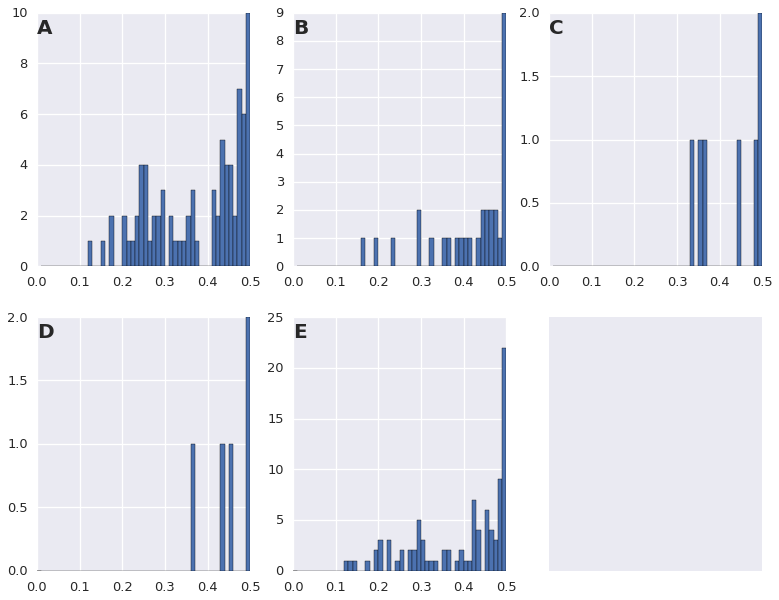

In [1653]:
with PdfPages('/home/lindb/wbp/figures/grid_imp_hexp_hist_by_pheno_int_pips_modfx_999.pdf') as pdf:
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6)) = plt.subplots(2, 3, figsize=(5,5),dpi=400)

    a1 = plt.subplot(231)
    a1.hist(outlierdata['bfpopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a1.set_title('A',y=.9,loc='left',fontsize=20,fontweight='bold')
    a1.spines['right'].set_visible(False)
    a1.spines['top'].set_visible(False)
    a1.yaxis.set_ticks_position('left')
    a1.xaxis.set_ticks_position('bottom')
    
    a2 = plt.subplot(232)
    a2.hist(outlierdata['c13popx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a2.set_title('B',y=.9,loc='left',fontsize=20,fontweight='bold')
    a2.spines['right'].set_visible(False)
    a2.spines['top'].set_visible(False)
    a2.yaxis.set_ticks_position('left')
    a2.xaxis.set_ticks_position('bottom')
    
    a3 = plt.subplot(233)
    a3.hist(outlierdata['htpopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a3.set_title('C',y=.9,loc='left',fontsize=20,fontweight='bold')
    a3.spines['right'].set_visible(False)
    a3.spines['top'].set_visible(False)
    a3.yaxis.set_ticks_position('left')
    a3.xaxis.set_ticks_position('bottom')
    
    a4 = plt.subplot(234)
    a4.hist(outlierdata['n15popx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a4.set_title('D',y=.9,loc='left',fontsize=20,fontweight='bold')
    a4.spines['right'].set_visible(False)
    a4.spines['top'].set_visible(False)
    a4.yaxis.set_ticks_position('left')
    a4.xaxis.set_ticks_position('bottom')
    
    a5 = plt.subplot(235)
    a5.hist(outlierdata['rspopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a5.set_title('E',y=.9,loc='left',fontsize=20,fontweight='bold')
    a5.spines['right'].set_visible(False)
    a5.spines['top'].set_visible(False)
    a5.yaxis.set_ticks_position('left')
    a5.xaxis.set_ticks_position('bottom')
    
    a6.spines['right'].set_visible(False)
    a6.spines['left'].set_visible(False)
    a6.spines['top'].set_visible(False)
    a6.spines['bottom'].set_visible(False)
    a6.axes.get_yaxis().set_visible(False)
    a6.axes.get_xaxis().set_ticks([])
    a6.axes.get_yaxis().set_ticks([])
    
    fig.set_size_inches(13,10)
    pdf.savefig(fig,bbox_inches='tight')

In [1654]:
#get sets of SNPs to make random draws
nonsigsnps = OrderedDict()
for pheno in outlierdata.keys():
    nonsigs = list(set(H.index.tolist()) - set(outlierdata[pheno].index.tolist()))
    nonsigsnps[pheno] = pd.DataFrame(H[H.index.isin(nonsigs)])
    print len(outlierdata[pheno].index.tolist())+len(nonsigsnps[pheno].index)

115632
115632
115632
115632
115632


In [1655]:
#how many random snps to draw from each bin?
binCounter = OrderedDict()
for pheno in outlierdata.keys():
    binCounter[pheno] = Counter()
    for row in outlierdata[pheno].index:
        binCounter[pheno][outlierdata[pheno].loc[row,'bin']] += 1
    for b in binCounter[pheno].keys():
        print pheno,b,binCounter[pheno][b]

bfpopx 12 1
bfpopx 15 1
bfpopx 17 2
bfpopx 20 2
bfpopx 21 1
bfpopx 22 1
bfpopx 23 2
bfpopx 24 4
bfpopx 25 4
bfpopx 26 1
bfpopx 27 2
bfpopx 28 4
bfpopx 29 1
bfpopx 31 2
bfpopx 32 1
bfpopx 33 1
bfpopx 34 1
bfpopx 35 2
bfpopx 36 3
bfpopx 37 1
bfpopx 41 3
bfpopx 42 2
bfpopx 43 5
bfpopx 44 4
bfpopx 45 4
bfpopx 46 2
bfpopx 47 7
bfpopx 48 6
bfpopx 49 10
c13popx 32 1
c13popx 48 1
c13popx 35 1
c13popx 36 1
c13popx 38 1
c13popx 39 1
c13popx 40 1
c13popx 41 1
c13popx 43 1
c13popx 44 2
c13popx 45 2
c13popx 46 2
c13popx 47 2
c13popx 16 1
c13popx 49 9
c13popx 19 1
c13popx 23 1
c13popx 29 2
htpopx 33 1
htpopx 35 1
htpopx 36 1
htpopx 44 1
htpopx 48 1
htpopx 49 2
n15popx 49 2
n15popx 43 1
n15popx 36 1
n15popx 45 1
rspopx 12 1
rspopx 13 1
rspopx 14 1
rspopx 17 1
rspopx 19 2
rspopx 20 3
rspopx 22 3
rspopx 24 1
rspopx 25 2
rspopx 27 2
rspopx 28 5
rspopx 29 2
rspopx 30 3
rspopx 31 1
rspopx 32 1
rspopx 33 1
rspopx 35 2
rspopx 36 2
rspopx 38 1
rspopx 39 2
rspopx 40 1
rspopx 41 1
rspopx 42 7
rspopx 43 4
rspop

In [1656]:
os.makedirs('/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/randmatrices')
os.makedirs('/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/randmatrices/randsnps')

In [1657]:
#for each pheno make 1000 dataframes with a set of snps == len(outliersnps[pheno])
for pheno in outlierdata.keys():
    print pheno
    for i in range(1000):  
        snps = []        
        for binn in binCounter[pheno].keys():
            data = nonsigsnps[pheno][nonsigsnps[pheno]['bin'] == binn]
                
            [snps.append(snp) for snp in random.sample(data.index,binCounter[pheno][binn])]
        
        assert len(np.unique(snps).tolist()) == sum(binCounter[pheno].values())

        DIR = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/randmatrices/randsnps/%s' % pheno
        if not op.exists(DIR):
            os.makedirs(DIR)
        filE = op.join(DIR,"%s_%s_randsnps.txt" % (pheno,str(i).zfill(3)))
        df = pd.DataFrame(snps)
        df.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
c13popx
htpopx
n15popx
rspopx


In [1658]:
#quicker to do it this way
#get dvals for the sets of random snps for each pheno
for pheno in outlierdata.keys():
    for i in range(1000):
        text = '''from __future__ import division
import os
from collections import OrderedDict,Counter
import pandas as pd
import numpy as np
import random
import math
from os import path as op
from os import listdir as ls


#get a dict with num indiv in pop
#population sizes (only for individuals in pops with phenotypic measurements)
popDict = {'Dicks_Pass':15,
'Freel_Peak':19,
'Little_Round_Top':14,
'Mt_Rose_Ophir':11,
'Rifle_Peak':15,
'Snow_Valley_Peak':14,}


filE = '/home/lindb/wbp/gemma/6pop_glob_mafs.txt'
globs = pd.read_csv(filE,header=0,sep='\\t')
glob = OrderedDict()
for row in globs.index:
    snp = globs.loc[row,'locus']
    maf = globs.loc[row,'maf']
    glob[snp] = maf

impMAF = pd.read_csv('/home/lindb/wbp/gemma/6pop_pop_maf.txt',header=0,index_col=0,sep="\\t")

filE= '/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/randmatrices/randsnps/%s/%s_%s_randsnps.txt' 
df = pd.read_csv(filE,header=None,sep="\\t")
randomsnps = df[0].tolist()

dijDict = OrderedDict() 
for i,locusi in enumerate(randomsnps):
    dijDict[locusi] = OrderedDict()
    qi = glob[locusi] #global maf

    for j,locusj in enumerate(randomsnps):
        if i > j: #i=row, j=col : lower triangle 
            qj = glob[locusj] #global maf

            sums = 0
            for pop in impMAF.columns:
                qik = impMAF.loc[locusi,pop] #get pop maf
                qjk = impMAF.loc[locusj,pop] #get pop maf
                nk = popDict[pop]

                sums += (nk/88)*((qik*qjk)-(qi*qj))

            dijDict[locusi][locusj] = sums
        else:
            dijDict[locusi][locusj] = np.nan

filE = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/randmatrices/randDVALS/%s/%s_%s_randDVALS.txt'
if not op.exists('/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/randmatrices/randDVALS/'):
    os.makedirs('/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/randmatrices/randDVALS/')
DIR = op.dirname(filE)
if not op.exists(DIR):
    os.makedirs(DIR)

with open(filE,'w') as o:
    key0 = dijDict.keys()[0]
    line = '\\t'.join(dijDict[key0].keys()) + str('\\n')
    o.write("%%s" %% line)
    for locusi in dijDict.keys():
        line = str(locusi)+'\\t'+'\\t'.join([str(x) for x in dijDict[locusi].values()]) + str('\\n')
        o.write("%%s" %% line)


''' % (pheno,pheno,str(i).zfill(3),
       pheno,pheno,str(i).zfill(3))
        filE = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/randmatrices/randpyfiles/get_rand_dvals_%s_%s.py' % (pheno,
                                                                                                      str(i).zfill(3)
                                                                                                     )
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [1659]:
DIR = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/randmatrices/randpyfiles/'
pyfiles = [op.join(DIR,f) for f in ls(DIR)]
len(pyfiles)

5000

In [1660]:
#spread out the jobs
count = 0
fcount = 0
tcount = 0
for f in sorted(pyfiles):
    if count == 0:
        text = 'python %s\n' % f
    else:
        newtext = 'python %s\n' % f
        text = text + newtext
    count += 1
    tcount += 1
    if (count == 100) or (tcount == 5000):
        count = 0
        fcount += 1
        filE = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/randmatrices/runpyfiles/%s_cmds.txt' % str(fcount).zfill(3)
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [1661]:
#make qsub files
for i in range(50):
    j = i+1
    text = '''#!/bin/bash
#$ -N pyfile%s
#$ -V
#$ -j y
#$ -cwd

cat %s_cmds.txt | parallel --progress --

''' % (str(j).zfill(3),
       str(j).zfill(3)
      )
    filE = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/randmatrices/runpyfiles/%s_run.sh' % str(j).zfill(3)
    with open(filE,'w') as o:
        o.write("%s" % text)

In [1663]:
#check on progress
DIR = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/randmatrices/randDVALS/'
ds = [op.join(DIR,d) for d in ls(DIR)]
count = 0
for DIR in ds:
    count = count + len(ls(DIR))
count

5000

In [1664]:
# get observed dvals
dvals = OrderedDict()
medvals = OrderedDict()
for pheno in outlierdata.keys():
    print pheno
    DF = pd.read_csv('/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/dvals/%s_dvals.txt' % pheno,
                     header=0,index_col=0,sep="\t")
    dvals[pheno] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[pheno].append(abs(DF.loc[row,col]))

    DIR = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/randmatrices/randDVALS/%s/' % pheno
    files = [op.join(DIR,f) for f in ls(DIR)]

    fcount = 0
    medvals[pheno] = []
    for f in files:
        df = pd.read_csv(f,header=0,index_col=0,sep="\t")
        rvals = [] #random dij values
        for lst in df.values.tolist():
            for x in lst:
                if math.isnan(x) == False:
                    rvals.append(x)

        medvals[pheno].append(np.median([abs(val) for val in rvals]))

        fcount += 1
        if fcount % 100 == 0:
            print fcount

    filE = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/randmatrices/randmedvals/%s_randmedvalues.txt' % pheno
    if not op.exists(op.dirname(filE)):
        os.makedirs(op.dirname(filE))
    medvaldf = pd.DataFrame(medvals[pheno])
    medvaldf.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
100
200
300
400
500
600
700
800
900
1000
c13popx
100
200
300
400
500
600
700
800
900
1000
htpopx
100
200
300
400
500
600
700
800
900
1000
n15popx
100
200
300
400
500
600
700
800
900
1000
rspopx
100
200
300
400
500
600
700
800
900
1000


In [1667]:
outlierdata.keys()

['bfpopx', 'c13popx', 'htpopx', 'n15popx', 'rspopx']

In [1785]:
#in case I restart my notebook
medvals = {}
for pheno in outlierdata.keys():
    print pheno
    DF = pd.read_csv('/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/dvals/%s_dvals.txt' % pheno,
                     header=0,index_col=0,sep="\t")
    dvals[pheno] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[pheno].append(abs(DF.loc[row,col]))
    filE = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_999/randmatrices/randmedvals/%s_randmedvalues.txt' % pheno
    df = pd.read_csv(filE,header=None,sep='\t')
    medvals[pheno] = df[0].tolist()

bfpopx
c13popx
htpopx
n15popx
rspopx


In [1786]:
n5th = OrderedDict()    #get 95th percentile
gt_hth = OrderedDict()  #how much greater is the empirical median dvalue than the 100th percentile of random SNPs?
gt_n5th = OrderedDict() #how much greater is the empirical median dvalue than the 95th percentile of random SNPs?
bmax=OrderedDict()      #below what percentile of the observed dvals are the values less than the maximum randdvals
bn5th = OrderedDict()   #below what percentile of the observed dvals are the values less than the 95th perc randdvals
for pheno in outlierdata.keys():
    print pheno,'has',len(topint[pheno][0.999]),'SNPs in intersection of top PIPs and top effects (alpha+beta*gamma)'
    sorts        = sorted(medvals[pheno])
    n5th[pheno]    = sorts[949]
    gt_hth[pheno]  = np.median(dvals[pheno])/max(medvals[pheno])
    print 'emp median is %sx greater than 100th percentile of random'%str(round(gt_hth[pheno],3))
    gt_n5th[pheno] = np.median(dvals[pheno])/n5th[pheno]
    print 'emp median is %sx greater than 95th percentile of random'%str(round(gt_n5th[pheno],3))
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < max(sorts): #the max(randDval) corresponds to the xth percentile of empirical d-values
            bmax[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
        if i+1 == len(dvals[pheno]):
            print '%s bmax maxed out' % pheno
            bmax[pheno] = (i+1,(i+1)/len(dvals[pheno]))
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < sorts[949]:
            bn5th[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    print 'the max random value corresponds to the %s precentile' % str(round(bmax[pheno][1],3)*100),"(%s/%s)" % (bmax[pheno][0],len(dvals[pheno])),'of emp values'
    print 'the 95th perc rand val corresponds to the %s percentile',str(round(bn5th[pheno][1],3)*100),"(%s/%s)" % (bn5th[pheno][0],len(dvals[pheno])),'of emp values'
    print 'emp med dval =',"{:.4}".format(np.median(dvals[pheno]))
    print 'max rand dval =',"{:.4}".format(max(medvals[pheno]))
    print '95th rand dval =',"{:.4}".format(n5th[pheno])
    print '\n' 

bfpopx has 80 SNPs in intersection of top PIPs and top effects (alpha+beta*gamma)
emp median is 0.812x greater than 100th percentile of random
emp median is 1.052x greater than 95th percentile of random
the max random value corresponds to the 57.1 precentile (1803/3160) of emp values
the 95th perc rand val corresponds to the %s percentile 48.2 (1522/3160) of emp values
emp med dval = 0.002422
max rand dval = 0.002982
95th rand dval = 0.002302


c13popx has 31 SNPs in intersection of top PIPs and top effects (alpha+beta*gamma)
emp median is 0.575x greater than 100th percentile of random
emp median is 0.866x greater than 95th percentile of random
the max random value corresponds to the 62.6 precentile (291/465) of emp values
the 95th perc rand val corresponds to the %s percentile 54.2 (252/465) of emp values
emp med dval = 0.00431
max rand dval = 0.007489
95th rand dval = 0.004978


htpopx has 7 SNPs in intersection of top PIPs and top effects (alpha+beta*gamma)
emp median is 0.165x grea

# covariance among top 99.5th pips and 99.5th model effects

In [1681]:
for pheno in topint:
    for q in [0.995]:
        print pheno,len(topint[pheno][q])

bfpopx 222
n15popx 10
c13popx 77
rspopx 325
htpopx 21


In [1682]:
os.makedirs('/home/lindb/wbp/gemma/covariance_int_pips_modfx_995')

In [1683]:
for pheno in effect_snps.keys():
    print pheno
    outliersnps = topint[pheno][0.995]

    dijDict = OrderedDict() 
    dijDict[pheno] = OrderedDict() 
    for i,locusi in enumerate(outliersnps):
        dijDict[pheno][locusi] = OrderedDict()
        qi = glob[locusi] #global maf

        for j,locusj in enumerate(outliersnps):
            if i > j: #i=row, j=col : lower triangle 
                qj = glob[locusj] #global maf

                sums = 0
                for pop in popsizeDict.keys():
                    qik = mafDict[locusi][pop] #get pop maf
                    qjk = mafDict[locusj][pop] #get pop maf
                    nk = popsizeDict[pop]

                    sums += (float(nk)/float(88))*((qik*qjk)-(qi*qj))

                dijDict[pheno][locusi][locusj] = sums
            else:
                dijDict[pheno][locusi][locusj] = np.nan
    #write out the file
    for pheno in dijDict.keys():
        filE = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_995/dvals/%s_dvals.txt' % pheno
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            key0 = dijDict[pheno].keys()[0]
            line = '\t'.join(dijDict[pheno][key0].keys()) + str('\n')
            o.write("%s" % line)
            for locusi in dijDict[pheno].keys():
                line = str(locusi)+'\t'+'\t'.join([str(x) for x in dijDict[pheno][locusi].values()]) + str('\n')
                o.write("%s" % line)

bfpopx
n15popx
c13popx
rspopx
htpopx


In [1684]:
DIR = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_995/dvals'
files = [op.join(DIR,f) for f in ls(DIR)]
dijDict = OrderedDict()
for f in sorted(files):
    pheno = op.basename(f).split("_")[0]
    dijDict[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')
dijDict['n15popx'].head()

NODE_129464_length_93_cov_1.946237_87  \
NODE_129464_length_93_cov_1.946237_87                                       NaN   
NODE_679018_length_98_cov_3.000000_88                                 -0.002632   
NODE_1647305_length_94_cov_1.000000_94                                -0.000304   
NODE_1290163_length_45_cov_1.311111_37                                -0.010344   
NODE_1337066_length_105_cov_1.057143_110                              -0.009331   

                                          NODE_679018_length_98_cov_3.000000_88  \
NODE_129464_length_93_cov_1.946237_87                                       NaN   
NODE_679018_length_98_cov_3.000000_88                                       NaN   
NODE_1647305_length_94_cov_1.000000_94                                -0.002946   
NODE_1290163_length_45_cov_1.311111_37                                -0.022843   
NODE_1337066_length_105_cov_1.057143_110                              -0.015112   

                                          NODE_1647305_length_94_cov_1.000000_94  \
NODE_129464_length_93_cov_1.946237_87                                        NaN   
NODE_679018_length_98_cov_3.000000_88                                        NaN   
NODE_1647305_length_94_cov_1.000000_94                                       NaN   
NODE_1290163_length_45_cov_1.311111_37                                 -0.008781   
NODE_1337066_length_105_cov_1.057143_110                               -0.011995   

                                          NODE_1290163_length_45_cov_1.311111_37  \
NODE_129464_length_93_cov_1.946237_87                                        NaN   
NODE_679018_length_98_cov_3.000000_88                                        NaN   
NODE_1647305_length_94_cov_1.000000_94                                       NaN   
NODE_1290163_length_45_cov_1.311111_37                                       NaN   
NODE_1337066_length_105_cov_1.057143_110                               -0.048642   

                                          NODE_1337066_length_105_cov_1.057143_110  \
NODE_129464_length_93_cov_1.946237_87                                          NaN   
NODE_679018_length_98_cov_3.000000_88                                          NaN   
NODE_1647305_length_94_cov_1.000000_94                                         NaN   
NODE_1290163_length_45_cov_1.311111_37                                         NaN   
NODE_1337066_length_105_cov_1.057143_110                                       NaN   

                                          NODE_1688309_length_115_cov_3.200000_102  \
NODE_129464_length_93_cov_1.946237_87                                          NaN   
NODE_679018_length_98_cov_3.000000_88                                          NaN   
NODE_1647305_length_94_cov_1.000000_94                                         NaN   
NODE_1290163_length_45_cov_1.311111_37                                         NaN   
NODE_1337066_length_105_cov_1.057143_110                                       NaN   

                                          NODE_1447602_length_71_cov_1.478873_46  \
NODE_129464_length_93_cov_1.946237_87                                        NaN   
NODE_679018_length_98_cov_3.000000_88                                        NaN   
NODE_1647305_length_94_cov_1.000000_94                                       NaN   
NODE_1290163_length_45_cov_1.311111_37                                       NaN   
NODE_1337066_length_105_cov_1.057143_110                                     NaN   

                                          NODE_567431_length_96_cov_1.260417_95  \
NODE_129464_length_93_cov_1.946237_87                                       NaN   
NODE_679018_length_98_cov_3.000000_88                                       NaN   
NODE_1647305_length_94_cov_1.000000_94                                      NaN   
NODE_1290163_length_45_cov_1.311111_37                                      NaN   
NODE_1337066_length_105_cov_1.057143_110                                    NaN 

In [1687]:
#get a dataframe with the outlier loci and their bins
outlierdata = OrderedDict()
for pheno in dijDict.keys():
    outliersnps = topint[pheno][0.995]

    outlierdata[pheno] = pd.DataFrame(H[H.index.isin(outliersnps)])
    print pheno,len(outlierdata[pheno]),len(topint[pheno][0.995])

 bfpopx 222 222
c13popx 77 77
htpopx 21 21
n15popx 10 10
rspopx 325 325


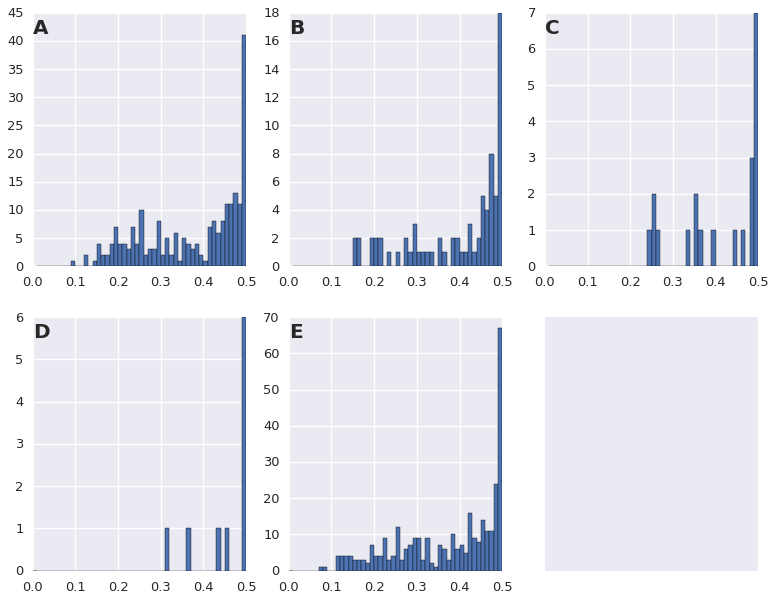

In [1688]:
with PdfPages('/home/lindb/wbp/figures/grid_imp_hexp_hist_by_pheno_modfx_pips_995.pdf') as pdf:
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6)) = plt.subplots(2, 3, figsize=(5,5),dpi=400)

    a1 = plt.subplot(231)
    a1.hist(outlierdata['bfpopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a1.set_title('A',y=.9,loc='left',fontsize=20,fontweight='bold')
    a1.spines['right'].set_visible(False)
    a1.spines['top'].set_visible(False)
    a1.yaxis.set_ticks_position('left')
    a1.xaxis.set_ticks_position('bottom')
    
    a2 = plt.subplot(232)
    a2.hist(outlierdata['c13popx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a2.set_title('B',y=.9,loc='left',fontsize=20,fontweight='bold')
    a2.spines['right'].set_visible(False)
    a2.spines['top'].set_visible(False)
    a2.yaxis.set_ticks_position('left')
    a2.xaxis.set_ticks_position('bottom')
    
    a3 = plt.subplot(233)
    a3.hist(outlierdata['htpopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a3.set_title('C',y=.9,loc='left',fontsize=20,fontweight='bold')
    a3.spines['right'].set_visible(False)
    a3.spines['top'].set_visible(False)
    a3.yaxis.set_ticks_position('left')
    a3.xaxis.set_ticks_position('bottom')
    
    a4 = plt.subplot(234)
    a4.hist(outlierdata['n15popx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a4.set_title('D',y=.9,loc='left',fontsize=20,fontweight='bold')
    a4.spines['right'].set_visible(False)
    a4.spines['top'].set_visible(False)
    a4.yaxis.set_ticks_position('left')
    a4.xaxis.set_ticks_position('bottom')
    
    a5 = plt.subplot(235)
    a5.hist(outlierdata['rspopx']['H_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a5.set_title('E',y=.9,loc='left',fontsize=20,fontweight='bold')
    a5.spines['right'].set_visible(False)
    a5.spines['top'].set_visible(False)
    a5.yaxis.set_ticks_position('left')
    a5.xaxis.set_ticks_position('bottom')
    
    a6.spines['right'].set_visible(False)
    a6.spines['left'].set_visible(False)
    a6.spines['top'].set_visible(False)
    a6.spines['bottom'].set_visible(False)
    a6.axes.get_yaxis().set_visible(False)
    a6.axes.get_xaxis().set_ticks([])
    a6.axes.get_yaxis().set_ticks([])
    
    fig.set_size_inches(13,10)
    pdf.savefig(fig,bbox_inches='tight')

In [1689]:
#get sets of SNPs to make random draws
nonsigsnps = OrderedDict()
for pheno in outlierdata.keys():
    nonsigs = list(set(H.index.tolist()) - set(outlierdata[pheno].index.tolist()))
    nonsigsnps[pheno] = pd.DataFrame(H[H.index.isin(nonsigs)])
    print len(outlierdata[pheno].index.tolist())+len(nonsigsnps[pheno].index)

115632
115632
115632
115632
115632


In [1690]:
#how many random snps to draw from each bin?
binCounter = OrderedDict()
for pheno in outlierdata.keys():
    binCounter[pheno] = Counter()
    for row in outlierdata[pheno].index:
        binCounter[pheno][outlierdata[pheno].loc[row,'bin']] += 1
    for b in binCounter[pheno].keys():
        print pheno,b,binCounter[pheno][b]

bfpopx 9 1
bfpopx 12 2
bfpopx 14 1
bfpopx 15 4
bfpopx 16 2
bfpopx 17 2
bfpopx 18 4
bfpopx 19 7
bfpopx 20 6
bfpopx 21 2
bfpopx 22 3
bfpopx 23 7
bfpopx 24 4
bfpopx 25 10
bfpopx 26 2
bfpopx 27 3
bfpopx 28 6
bfpopx 29 5
bfpopx 30 2
bfpopx 31 5
bfpopx 32 2
bfpopx 33 6
bfpopx 34 1
bfpopx 35 5
bfpopx 36 4
bfpopx 37 3
bfpopx 38 4
bfpopx 39 2
bfpopx 40 1
bfpopx 41 7
bfpopx 42 8
bfpopx 43 6
bfpopx 44 8
bfpopx 45 11
bfpopx 46 11
bfpopx 47 13
bfpopx 48 11
bfpopx 49 41
c13popx 15 2
c13popx 16 2
c13popx 19 2
c13popx 20 4
c13popx 23 1
c13popx 25 1
c13popx 27 2
c13popx 28 2
c13popx 29 2
c13popx 30 1
c13popx 31 1
c13popx 32 1
c13popx 33 1
c13popx 35 2
c13popx 36 1
c13popx 38 2
c13popx 39 2
c13popx 40 1
c13popx 41 1
c13popx 42 3
c13popx 43 1
c13popx 44 2
c13popx 45 5
c13popx 46 4
c13popx 47 8
c13popx 48 5
c13popx 49 18
htpopx 33 1
htpopx 35 2
htpopx 36 1
htpopx 39 1
htpopx 44 1
htpopx 46 1
htpopx 48 3
htpopx 49 7
htpopx 24 1
htpopx 25 2
htpopx 26 1
n15popx 49 6
n15popx 43 1
n15popx 36 1
n15popx 45 1
n15

In [1691]:
os.makedirs('/home/lindb/wbp/gemma/covariance_int_pips_modfx_995/randmatrices')
os.makedirs('/home/lindb/wbp/gemma/covariance_int_pips_modfx_995/randmatrices/randsnps')

In [1692]:
#for each pheno make 1000 dataframes with a set of snps == len(outliersnps[pheno])
for pheno in outlierdata.keys():
    print pheno
    for i in range(1000):  
        snps = []        
        for binn in binCounter[pheno].keys():
            data = nonsigsnps[pheno][nonsigsnps[pheno]['bin'] == binn]
                
            [snps.append(snp) for snp in random.sample(data.index,binCounter[pheno][binn])]
        
        assert len(np.unique(snps).tolist()) == sum(binCounter[pheno].values())

        DIR = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_995/randmatrices/randsnps/%s' % pheno
        if not op.exists(DIR):
            os.makedirs(DIR)
        filE = op.join(DIR,"%s_%s_randsnps.txt" % (pheno,str(i).zfill(3)))
        df = pd.DataFrame(snps)
        df.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
c13popx
htpopx
n15popx
rspopx


In [1693]:
#quicker to do it this way
#get dvals for the sets of random snps for each pheno
for pheno in outlierdata.keys():
    for i in range(1000):
        text = '''from __future__ import division
import os
from collections import OrderedDict,Counter
import pandas as pd
import numpy as np
import random
import math
from os import path as op
from os import listdir as ls


#get a dict with num indiv in pop
#population sizes (only for individuals in pops with phenotypic measurements)
popDict = {'Dicks_Pass':15,
'Freel_Peak':19,
'Little_Round_Top':14,
'Mt_Rose_Ophir':11,
'Rifle_Peak':15,
'Snow_Valley_Peak':14,}


filE = '/home/lindb/wbp/gemma/6pop_glob_mafs.txt'
globs = pd.read_csv(filE,header=0,sep='\\t')
glob = OrderedDict()
for row in globs.index:
    snp = globs.loc[row,'locus']
    maf = globs.loc[row,'maf']
    glob[snp] = maf

impMAF = pd.read_csv('/home/lindb/wbp/gemma/6pop_pop_maf.txt',header=0,index_col=0,sep="\\t")

filE= '/home/lindb/wbp/gemma/covariance_int_pips_modfx_995/randmatrices/randsnps/%s/%s_%s_randsnps.txt' 
df = pd.read_csv(filE,header=None,sep="\\t")
randomsnps = df[0].tolist()

dijDict = OrderedDict() 
for i,locusi in enumerate(randomsnps):
    dijDict[locusi] = OrderedDict()
    qi = glob[locusi] #global maf

    for j,locusj in enumerate(randomsnps):
        if i > j: #i=row, j=col : lower triangle 
            qj = glob[locusj] #global maf

            sums = 0
            for pop in impMAF.columns:
                qik = impMAF.loc[locusi,pop] #get pop maf
                qjk = impMAF.loc[locusj,pop] #get pop maf
                nk = popDict[pop]

                sums += (nk/88)*((qik*qjk)-(qi*qj))

            dijDict[locusi][locusj] = sums
        else:
            dijDict[locusi][locusj] = np.nan

filE = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_995/randmatrices/randDVALS/%s/%s_%s_randDVALS.txt'
if not op.exists('/home/lindb/wbp/gemma/covariance_int_pips_modfx_995/randmatrices/randDVALS/'):
    os.makedirs('/home/lindb/wbp/gemma/covariance_int_pips_modfx_995/randmatrices/randDVALS/')
DIR = op.dirname(filE)
if not op.exists(DIR):
    os.makedirs(DIR)

with open(filE,'w') as o:
    key0 = dijDict.keys()[0]
    line = '\\t'.join(dijDict[key0].keys()) + str('\\n')
    o.write("%%s" %% line)
    for locusi in dijDict.keys():
        line = str(locusi)+'\\t'+'\\t'.join([str(x) for x in dijDict[locusi].values()]) + str('\\n')
        o.write("%%s" %% line)


''' % (pheno,pheno,str(i).zfill(3),
       pheno,pheno,str(i).zfill(3))
        filE = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_995/randmatrices/randpyfiles/get_rand_dvals_%s_%s.py' % (pheno,
                                                                                                      str(i).zfill(3)
                                                                                                     )
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [1694]:
DIR = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_995/randmatrices/randpyfiles/'
pyfiles = [op.join(DIR,f) for f in ls(DIR)]
len(pyfiles)

5000

In [1695]:
#spread out the jobs
count = 0
fcount = 0
tcount = 0
for f in sorted(pyfiles):
    if count == 0:
        text = 'python %s\n' % f
    else:
        newtext = 'python %s\n' % f
        text = text + newtext
    count += 1
    tcount += 1
    if (count == 100) or (tcount == 5000):
        count = 0
        fcount += 1
        filE = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_995/randmatrices/runpyfiles/%s_cmds.txt' % str(fcount).zfill(3)
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [1696]:
#make qsub files
for i in range(50):
    j = i+1
    text = '''#!/bin/bash
#$ -N pyfile%s
#$ -V
#$ -j y
#$ -cwd

cat %s_cmds.txt | parallel --progress --

''' % (str(j).zfill(3),
       str(j).zfill(3)
      )
    filE = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_995/randmatrices/runpyfiles/%s_run.sh' % str(j).zfill(3)
    with open(filE,'w') as o:
        o.write("%s" % text)

In [1731]:
#check on progress
DIR = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_995/randmatrices/randDVALS/'
ds = [op.join(DIR,d) for d in ls(DIR)]
count = 0
for DIR in ds:
    count = count + len(ls(DIR))
count

5000

In [1732]:
# get observed dvals
dvals = OrderedDict()
medvals = OrderedDict()
for pheno in outlierdata.keys():
    print pheno
    DF = pd.read_csv('/home/lindb/wbp/gemma/covariance_int_pips_modfx_995/dvals/%s_dvals.txt' % pheno,
                     header=0,index_col=0,sep="\t")
    dvals[pheno] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[pheno].append(abs(DF.loc[row,col]))

    DIR = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_995/randmatrices/randDVALS/%s/' % pheno
    files = [op.join(DIR,f) for f in ls(DIR)]

    fcount = 0
    medvals[pheno] = []
    for f in files:
        df = pd.read_csv(f,header=0,index_col=0,sep="\t")
        rvals = [] #random dij values
        for lst in df.values.tolist():
            for x in lst:
                if math.isnan(x) == False:
                    rvals.append(x)

        medvals[pheno].append(np.median([abs(val) for val in rvals]))

        fcount += 1
        if fcount % 100 == 0:
            print fcount

    filE = '/home/lindb/wbp/gemma/covariance_int_pips_modfx_995/randmatrices/randmedvals/%s_randmedvalues.txt' % pheno
    if not op.exists(op.dirname(filE)):
        os.makedirs(op.dirname(filE))
    medvaldf = pd.DataFrame(medvals[pheno])
    medvaldf.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
100
200
300
400
500
600
700
800
900
1000
c13popx
100
200
300
400
500
600
700
800
900
1000
htpopx
100
200
300
400
500
600
700
800
900
1000
n15popx
100
200
300
400
500
600
700
800
900
1000
rspopx
100
200
300
400
500
600
700
800
900
1000


In [1733]:
n5th = OrderedDict()    #get 95th percentile
gt_hth = OrderedDict()  #how much greater is the empirical median dvalue than the 100th percentile of random SNPs?
gt_n5th = OrderedDict() #how much greater is the empirical median dvalue than the 95th percentile of random SNPs?
bmax=OrderedDict()      #below what percentile of the observed dvals are the values less than the maximum randdvals
bn5th = OrderedDict()   #below what percentile of the observed dvals are the values less than the 95th perc randdvals
for pheno in outlierdata.keys():
    print pheno,'has',len(topint[pheno][0.995]),'SNPs in intersection of top PIPs and top effects (alpha+beta)'
    sorts        = sorted(medvals[pheno])
    n5th[pheno]    = sorts[949]
    gt_hth[pheno]  = np.median(dvals[pheno])/max(medvals[pheno])
    print 'emp median is %sx greater than 100th percentile of random'%str(round(gt_hth[pheno],3))
    gt_n5th[pheno] = np.median(dvals[pheno])/n5th[pheno]
    print 'emp median is %sx greater than 95th percentile of random'%str(round(gt_n5th[pheno],3))
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < max(sorts): #the max(randDval) corresponds to the xth percentile of empirical d-values
            bmax[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < sorts[949]:
            bn5th[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    print 'the max random value corresponds to the %s precentile' % str(round(bmax[pheno][1],3)*100),"(%s/%s)" % (bmax[pheno][0],len(dvals[pheno])),'of emp values'
    print 'the 95th perc rand val corresponds to the %s percentile',str(round(bn5th[pheno][1],3)*100),"(%s/%s)" % (bn5th[pheno][0],len(dvals[pheno])),'of emp values'
    print 'emp med dval =',"{:.4}".format(np.median(dvals[pheno]))
    print 'max rand dval =',"{:.4}".format(max(medvals[pheno]))
    print '95th rand dval =',"{:.4}".format(n5th[pheno])
    print '\n' 

bfpopx has 222 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.916x greater than 100th percentile of random
emp median is 1.067x greater than 95th percentile of random
the max random value corresponds to the 52.6 precentile (12892/24531) of emp values
the 95th perc rand val corresponds to the %s percentile 47.9 (11760/24531) of emp values
emp med dval = 0.002504
max rand dval = 0.002733
95th rand dval = 0.002347


c13popx has 77 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.834x greater than 100th percentile of random
emp median is 1.078x greater than 95th percentile of random
the max random value corresponds to the 54.4 precentile (1592/2926) of emp values
the 95th perc rand val corresponds to the %s percentile 48.1 (1406/2926) of emp values
emp med dval = 0.003659
max rand dval = 0.004387
95th rand dval = 0.003394


htpopx has 21 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.639x greater tha

# covariance among top 998 pips and mod fx

In [178]:
for pheno in phenos:
    d = combined_dfs[pheno]
    cut = d[y].quantile(q)
    xvals = d[y][d[y]>=cut]
    modfx[pheno] = xvals.index
    print pheno,len(modfx[pheno])

bfpopx 232
c13popx 232
htpopx 232
n15popx 232
rspopx 232


In [195]:
#do pairwise to get Dij
def get_dijdict(tokens):
    from collections import OrderedDict
    from os import path as op
    from os import listdir as ls
    import os
    import numpy as np
    import pandas as pd
    
    pheno,outliersnps,glob,mafDict,popDict = tokens
    dijDict = OrderedDict() 
    dijDict[pheno] = OrderedDict() 
    for i,locusi in enumerate(outliersnps):
        dijDict[pheno][locusi] = OrderedDict()
        qi = glob[locusi] #global maf

        for j,locusj in enumerate(outliersnps):
            if i > j: #i=row, j=col : lower triangle 
                qj = glob[locusj] #global maf

                sums = 0
                for pop in popDict.keys():
                    qik = mafDict[locusi][pop] #get pop maf
                    qjk = mafDict[locusj][pop] #get pop maf
                    nk = popDict[pop]

                    sums += (float(nk)/float(88))*((qik*qjk)-(qi*qj))

                dijDict[pheno][locusi][locusj] = sums
            else:
                dijDict[pheno][locusi][locusj] = np.nan
    #write out the file
    for pheno in dijDict.keys():
        filE = '/home/lindb/wbp/gemma/covariance_pip998_by_modfx/dvals/%s_dvals.txt' % pheno
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            key0 = dijDict[pheno].keys()[0]
            line = '\t'.join(dijDict[pheno][key0].keys()) + str('\n')
            o.write("%s" % line)
            for locusi in dijDict[pheno].keys():
                line = str(locusi)+'\t'+'\t'.join([str(x) for x in dijDict[pheno][locusi].values()]) + str('\n')
                o.write("%s" % line)

In [196]:
jobs = []
for pheno in phenos:
    print pheno
    jobs.append(lview.apply_async(get_dijdict,[pheno,modfx[pheno],glob,mafDict,popsizeDict]))

bfpopx
c13popx
htpopx
n15popx
rspopx


In [203]:
for j in jobs:
    if j.ready():
        print j.r

None
None
None
None
None


In [205]:
DIR = '/home/lindb/wbp/gemma/covariance_pip998_by_modfx/dvals'
files = [op.join(DIR,f) for f in ls(DIR)]
dijDict = OrderedDict()
for f in sorted(files):
    pheno = op.basename(f).split("_")[0]
    dijDict[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')
dijDict[pheno].head()

NODE_1002798_length_96_cov_1.708333_69  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                 0.015655   
NODE_1005005_length_97_cov_1.041237_100                                0.009373   
NODE_1006116_length_110_cov_1.718182_68                               -0.008239   
NODE_1021929_length_94_cov_1.180851_97                                 0.005870   

                                         NODE_1004353_length_98_cov_6.795918_59  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                0.008958   
NODE_1006116_length_110_cov_1.718182_68                               -0.004896   
NODE_1021929_length_94_cov_1.180851_97                                 0.003854   

                                         NODE_1005005_length_97_cov_1.041237_100  \
NODE_1002798_length_96_cov_1.708333_69                                       NaN   
NODE_1004353_length_98_cov_6.795918_59                                       NaN   
NODE_1005005_length_97_cov_1.041237_100                                      NaN   
NODE_1006116_length_110_cov_1.718182_68                                -0.013103   
NODE_1021929_length_94_cov_1.180851_97                                  0.006688   

                                         NODE_1006116_length_110_cov_1.718182_68  \
NODE_1002798_length_96_cov_1.708333_69                                       NaN   
NODE_1004353_length_98_cov_6.795918_59                                       NaN   
NODE_1005005_length_97_cov_1.041237_100                                      NaN   
NODE_1006116_length_110_cov_1.718182_68                                      NaN   
NODE_1021929_length_94_cov_1.180851_97                                 -0.004465   

                                         NODE_1021929_length_94_cov_1.180851_97  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1021929_length_94_cov_1.180851_97                                      NaN   

                                         NODE_1022519_length_94_cov_1.712766_68  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1021929_length_94_cov_1.180851_97                                      NaN   

                                         NODE_1031179_length_98_cov_1.897959_34  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1021929_length_94_cov_1.180851_97                                      NaN   

                                         NODE_1043532_length_95_cov_2.000000_10  \
NODE_1002798_length_96_cov_1.708333_69                                      NaN   
NODE_1004353_length_98_cov_6.795918_59                                      NaN   
NODE_1005005_length_97_cov_1.041237_100                                     NaN   
NODE_1006116_length_110_cov_1.718182_68                                     NaN   
NODE_1021929_length_94_cov_1.180851_97                                      NaN   

                                     

In [211]:
#quicker to do it this way
#get dvals for the sets of random snps for each pheno
for pheno in phenos:
    for i in range(1000):
        text = '''from __future__ import division
import os
from collections import OrderedDict,Counter
import pandas as pd
import numpy as np
import random
import math
from os import path as op
from os import listdir as ls


#get a dict with num indiv in pop
#population sizes (only for individuals in pops with phenotypic measurements)
popDict = {'Dicks_Pass':15,
'Freel_Peak':19,
'Little_Round_Top':14,
'Mt_Rose_Ophir':11,
'Rifle_Peak':15,
'Snow_Valley_Peak':14,}


filE = '/home/lindb/wbp/gemma/6pop_glob_mafs.txt'
globs = pd.read_csv(filE,header=0,sep='\\t')
glob = OrderedDict()
for row in globs.index:
    snp = globs.loc[row,'locus']
    maf = globs.loc[row,'maf']
    glob[snp] = maf

impMAF = pd.read_csv('/home/lindb/wbp/gemma/6pop_pop_maf.txt',header=0,index_col=0,sep="\\t")

filE= '/home/lindb/wbp/gemma/covariance_pip998_by_modfx/randmatrices/randsnps/%s/%s_%s_randsnps.txt' 
df = pd.read_csv(filE,header=None,sep="\\t")
randomsnps = df[0].tolist()

dijDict = OrderedDict() 
for i,locusi in enumerate(randomsnps):
    dijDict[locusi] = OrderedDict()
    qi = glob[locusi] #global maf

    for j,locusj in enumerate(randomsnps):
        if i > j: #i=row, j=col : lower triangle 
            qj = glob[locusj] #global maf

            sums = 0
            for pop in impMAF.columns:
                qik = impMAF.loc[locusi,pop] #get pop maf
                qjk = impMAF.loc[locusj,pop] #get pop maf
                nk = popDict[pop]

                sums += (nk/88)*((qik*qjk)-(qi*qj))

            dijDict[locusi][locusj] = sums
        else:
            dijDict[locusi][locusj] = np.nan

filE = '/home/lindb/wbp/gemma/covariance_pip998_by_modfx/randmatrices/randDVALS/%s/%s_%s_randDVALS.txt'
if not op.exists('/home/lindb/wbp/gemma/covariance_pip998_by_modfx/randmatrices/randDVALS/'):
    os.makedirs('/home/lindb/wbp/gemma/covariance_pip998_by_modfx/randmatrices/randDVALS/')
DIR = op.dirname(filE)
if not op.exists(DIR):
    os.makedirs(DIR)

with open(filE,'w') as o:
    key0 = dijDict.keys()[0]
    line = '\\t'.join(dijDict[key0].keys()) + str('\\n')
    o.write("%%s" %% line)
    for locusi in dijDict.keys():
        line = str(locusi)+'\\t'+'\\t'.join([str(x) for x in dijDict[locusi].values()]) + str('\\n')
        o.write("%%s" %% line)


''' % (pheno,pheno,str(i).zfill(3),
       pheno,pheno,str(i).zfill(3))
        filE = '/home/lindb/wbp/gemma/covariance_pip998_by_modfx/randmatrices/randpyfiles/get_rand_dvals_%s_%s.py' % (pheno,
                                                                                                      str(i).zfill(3)
                                                                                                     )
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [213]:
DIR = '/home/lindb/wbp/gemma/covariance_pip998_by_modfx/randmatrices/randpyfiles/'
pyfiles = [op.join(DIR,f) for f in ls(DIR)]
len(pyfiles)

5000

In [207]:
#spread out the jobs across 25 files
count = 0
fcount = 0
for f in sorted(pyfiles):
    if count == 0:
        text = 'python %s\n' % f
    else:
        newtext = 'python %s\n' % f
        text = text + newtext
    count += 1
    if count == 200:
        count = 0
        fcount += 1
        filE = '/home/lindb/wbp/gemma/covariance_pip998_by_modfx/randmatrices/runpyfiles/%s_cmds.txt' % str(fcount).zfill(3)
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [208]:
#make 125 qsub files
for i in range(25):
    j = i+1
    text = '''#!/bin/bash
#$ -N pyfile%s
#$ -V
#$ -j y
#$ -cwd

cat %s_cmds.txt | parallel --progress --

''' % (str(j).zfill(3),
       str(j).zfill(3)
      )
    filE = '/home/lindb/wbp/gemma/covariance_pip998_by_modfx/randmatrices/runpyfiles/%s_run.sh' % str(j).zfill(3)
    with open(filE,'w') as o:
        o.write("%s" % text)

In [214]:
#check on progress
DIR = '/home/lindb/wbp/gemma/covariance_pip998_by_modfx/randmatrices/randDVALS'
ds = [op.join(DIR,d) for d in ls(DIR)]
count = 0
for DIR in ds:
    count = count + len(ls(DIR))
count

5000

In [215]:
# get observed dvals
dvals = OrderedDict()
medvals = OrderedDict()
for pheno in phenos:
    print pheno
    DF = pd.read_csv('/home/lindb/wbp/gemma/covariance_pip998_by_modfx/dvals/%s_dvals.txt' % pheno,
                     header=0,index_col=0,sep="\t")
    dvals[pheno] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[pheno].append(abs(DF.loc[row,col]))

    DIR = '/home/lindb/wbp/gemma/covariance_pip998_by_modfx/randmatrices/randDVALS/%s/' % pheno
    files = [op.join(DIR,f) for f in ls(DIR)]

    fcount = 0
    medvals[pheno] = []
    for f in files:
        df = pd.read_csv(f,header=0,index_col=0,sep="\t")
        rvals = [] #random dij values
        for lst in df.values.tolist():
            for x in lst:
                if math.isnan(x) == False:
                    rvals.append(x)

        medvals[pheno].append(np.median([abs(val) for val in rvals]))

        fcount += 1
        if fcount % 100 == 0:
            print fcount

    filE = '/home/lindb/wbp/gemma/covariance_pip998_by_modfx/randmatrices/randmedvals/%s_randmedvalues.txt' % pheno
    if not op.exists(op.dirname(filE)):
        os.makedirs(op.dirname(filE))
    medvaldf = pd.DataFrame(medvals[pheno])
    medvaldf.to_csv(filE,header=False,index=False,sep="\t")

bfpopx
100
200
300
400
500
600
700
800
900
1000
c13popx
100
200
300
400
500
600
700
800
900
1000
htpopx
100
200
300
400
500
600
700
800
900
1000
n15popx
100
200
300
400
500
600
700
800
900
1000
rspopx
100
200
300
400
500
600
700
800
900
1000


In [4]:
files = ls('/home/lindb/wbp/gemma/covariance_pip998_by_modfx/randmatrices/randmedvals/')
phenos = []
for f in files:
    pheno = f.split("_")[0]
    print pheno
    phenos.append(pheno)

bfpopx
c13popx
htpopx
n15popx
rspopx


In [6]:
medvals = {}
for pheno in phenos:
    filE = '/home/lindb/wbp/gemma/covariance_pip998_by_modfx/randmatrices/randmedvals/%s_randmedvalues.txt' % pheno
    df = pd.read_csv(filE,header=None,sep='\t')
    medvals[pheno] = df[0].tolist()

In [8]:
dvals = {}
for pheno in phenos:
    print pheno
    DF = pd.read_csv('/home/lindb/wbp/gemma/covariance_pip998_by_modfx/dvals/%s_dvals.txt' % pheno,
                     header=0,index_col=0,sep="\t")
    dvals[pheno] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[pheno].append(abs(DF.loc[row,col]))

bfpopx
c13popx
htpopx
n15popx
rspopx


In [ ]:
phenos = ls('as')

In [9]:
n5th = OrderedDict()    #get 95th percentile
gt_hth = OrderedDict()  #how much greater is the empirical median dvalue than the 100th percentile of random SNPs?
gt_n5th = OrderedDict() #how much greater is the empirical median dvalue than the 95th percentile of random SNPs?
bmax=OrderedDict()      #below what percentile of the observed dvals are the values less than the maximum randdvals
bn5th = OrderedDict()   #below what percentile of the observed dvals are the values less than the 95th perc randdvals
for pheno in phenos:
    print pheno,'has',"234",'SNPs'
    sorts        = sorted(medvals[pheno])
    n5th[pheno]    = sorts[949]
    gt_hth[pheno]  = np.median(dvals[pheno])/max(medvals[pheno])
    print 'emp median is %sx greater than 100th percentile of random'%str(round(gt_hth[pheno],3))
    gt_n5th[pheno] = np.median(dvals[pheno])/n5th[pheno]
    print 'emp median is %sx greater than 95th percentile of random'%str(round(gt_n5th[pheno],3))
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < max(sorts): #the max(randDval) corresponds to the xth percentile of empirical d-values
            bmax[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < sorts[949]:
            bn5th[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    print 'the max random value corresponds to the %s precentile' % str(round(bmax[pheno][1],3)*100),"(%s/%s)" % (bmax[pheno][0],len(dvals[pheno])),'of emp values'
    print 'the 95th perc rand val corresponds to the %s percentile',str(round(bn5th[pheno][1],3)*100),"(%s/%s)" % (bn5th[pheno][0],len(dvals[pheno])),'of emp values'
    print 'emp med dval =',"{:.4}".format(np.median(dvals[pheno]))
    print 'max rand dval =',"{:.4}".format(max(medvals[pheno]))
    print '95th rand dval =',"{:.4}".format(n5th[pheno])
    print '\n' 

bfpopx has 234 SNPs
emp median is 0.914x greater than 100th percentile of random
emp median is 0.986x greater than 95th percentile of random
the max random value corresponds to the 53.7 precentile (14387/26796) of emp values
the 95th perc rand val corresponds to the %s percentile 50.6 (13556/26796) of emp values
emp med dval = 0.001433
max rand dval = 0.001568
95th rand dval = 0.001454


c13popx has 234 SNPs
emp median is 0.941x greater than 100th percentile of random
emp median is 1.021x greater than 95th percentile of random
the max random value corresponds to the 52.4 precentile (14039/26796) of emp values
the 95th perc rand val corresponds to the %s percentile 49.2 (13186/26796) of emp values
emp med dval = 0.00149
max rand dval = 0.001583
95th rand dval = 0.001459


htpopx has 234 SNPs
emp median is 0.883x greater than 100th percentile of random
emp median is 0.974x greater than 95th percentile of random
the max random value corresponds to the 54.9 precentile (14715/26796) of emp 

In [216]:
n5th = OrderedDict()    #get 95th percentile
gt_hth = OrderedDict()  #how much greater is the empirical median dvalue than the 100th percentile of random SNPs?
gt_n5th = OrderedDict() #how much greater is the empirical median dvalue than the 95th percentile of random SNPs?
bmax=OrderedDict()      #below what percentile of the observed dvals are the values less than the maximum randdvals
bn5th = OrderedDict()   #below what percentile of the observed dvals are the values less than the 95th perc randdvals
for pheno in phenos:
    print pheno,'has',"234",'SNPs in intersection of top PIPs and top effects (alpha+beta)'
    sorts        = sorted(medvals[pheno])
    n5th[pheno]    = sorts[949]
    gt_hth[pheno]  = np.median(dvals[pheno])/max(medvals[pheno])
    print 'emp median is %sx greater than 100th percentile of random'%str(round(gt_hth[pheno],3))
    gt_n5th[pheno] = np.median(dvals[pheno])/n5th[pheno]
    print 'emp median is %sx greater than 95th percentile of random'%str(round(gt_n5th[pheno],3))
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < max(sorts): #the max(randDval) corresponds to the xth percentile of empirical d-values
            bmax[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < sorts[949]:
            bn5th[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    print 'the max random value corresponds to the %s precentile' % str(round(bmax[pheno][1],3)*100),"(%s/%s)" % (bmax[pheno][0],len(dvals[pheno])),'of emp values'
    print 'the 95th perc rand val corresponds to the %s percentile',str(round(bn5th[pheno][1],3)*100),"(%s/%s)" % (bn5th[pheno][0],len(dvals[pheno])),'of emp values'
    print 'emp med dval =',"{:.4}".format(np.median(dvals[pheno]))
    print 'max rand dval =',"{:.4}".format(max(medvals[pheno]))
    print '95th rand dval =',"{:.4}".format(n5th[pheno])
    print '\n' 

bfpopx has 234 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.914x greater than 100th percentile of random
emp median is 0.986x greater than 95th percentile of random
the max random value corresponds to the 53.7 precentile (14387/26796) of emp values
the 95th perc rand val corresponds to the %s percentile 50.6 (13556/26796) of emp values
emp med dval = 0.001433
max rand dval = 0.001568
95th rand dval = 0.001454


c13popx has 234 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.941x greater than 100th percentile of random
emp median is 1.021x greater than 95th percentile of random
the max random value corresponds to the 52.4 precentile (14039/26796) of emp values
the 95th perc rand val corresponds to the %s percentile 49.2 (13186/26796) of emp values
emp med dval = 0.00149
max rand dval = 0.001583
95th rand dval = 0.001459


htpopx has 234 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.883x greate

In [174]:
n5th = OrderedDict()    #get 95th percentile
gt_hth = OrderedDict()  #how much greater is the empirical median dvalue than the 100th percentile of random SNPs?
gt_n5th = OrderedDict() #how much greater is the empirical median dvalue than the 95th percentile of random SNPs?
bmax=OrderedDict()      #below what percentile of the observed dvals are the values less than the maximum randdvals
bn5th = OrderedDict()   #below what percentile of the observed dvals are the values less than the 95th perc randdvals
for pheno in phenos:
    print pheno,'has',"234",'SNPs in intersection of top PIPs and top effects (alpha+beta)'
    sorts        = sorted(medvals[pheno])
    n5th[pheno]    = sorts[949]
    gt_hth[pheno]  = np.median(dvals[pheno])/max(medvals[pheno])
    print 'emp median is %sx greater than 100th percentile of random'%str(round(gt_hth[pheno],3))
    gt_n5th[pheno] = np.median(dvals[pheno])/n5th[pheno]
    print 'emp median is %sx greater than 95th percentile of random'%str(round(gt_n5th[pheno],3))
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < max(sorts): #the max(randDval) corresponds to the xth percentile of empirical d-values
            bmax[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    for i,dval in enumerate(sorted(dvals[pheno])):
        if not dval < sorts[949]:
            bn5th[pheno]=(i+1,(i+1)/len(dvals[pheno]))
            break
    print 'the max random value corresponds to the %s precentile' % str(round(bmax[pheno][1],3)*100),"(%s/%s)" % (bmax[pheno][0],len(dvals[pheno])),'of emp values'
    print 'the 95th perc rand val corresponds to the %s percentile',str(round(bn5th[pheno][1],3)*100),"(%s/%s)" % (bn5th[pheno][0],len(dvals[pheno])),'of emp values'
    print 'emp med dval =',"{:.4}".format(np.median(dvals[pheno]))
    print 'max rand dval =',"{:.4}".format(max(medvals[pheno]))
    print '95th rand dval =',"{:.4}".format(n5th[pheno])
    print '\n' 

 bfpopx has 234 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.946x greater than 100th percentile of random
emp median is 1.046x greater than 95th percentile of random
the max random value corresponds to the 51.5 precentile (13798/26796) of emp values
the 95th perc rand val corresponds to the %s percentile 48.7 (13038/26796) of emp values
emp med dval = 0.002448
max rand dval = 0.002589
95th rand dval = 0.00234


c13popx has 234 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.946x greater than 100th percentile of random
emp median is 1.044x greater than 95th percentile of random
the max random value corresponds to the 51.6 precentile (13830/26796) of emp values
the 95th perc rand val corresponds to the %s percentile 48.8 (13075/26796) of emp values
emp med dval = 0.003031
max rand dval = 0.003205
95th rand dval = 0.002903


htpopx has 234 SNPs in intersection of top PIPs and top effects (alpha+beta)
emp median is 0.855x great

# Allele frequency shifts

### 0.999 intersection

In [217]:
impMAF = pd.read_csv('/home/lindb/wbp/gemma/6pop_pop_maf.txt',header=0,index_col=0,sep="\\t")
impMAF.head()

/gpfs_fs/home/lindb/anaconda/envs/conda/lib/python2.7/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


Dicks_Pass  Freel_Peak  \
NODE_1000013_length_91_cov_1.802198_37     0.066667    0.105263   
NODE_1000031_length_98_cov_2.000000_30     0.333333    0.078947   
NODE_1000037_length_93_cov_2.043011_33     0.100000    0.078947   
NODE_1000042_length_93_cov_1.118280_100    0.000000    0.000000   
NODE_1000053_length_94_cov_1.744681_25     0.033333    0.000000   

                                         Little_Round_Top  Mt_Rose_Ophir  \
NODE_1000013_length_91_cov_1.802198_37           0.250000       0.272727   
NODE_1000031_length_98_cov_2.000000_30           0.178571       0.045455   
NODE_1000037_length_93_cov_2.043011_33           0.071429       0.045455   
NODE_1000042_length_93_cov_1.118280_100          0.035714       0.000000   
NODE_1000053_length_94_cov_1.744681_25           0.035714       0.045455   

                                         Rifle_Peak  Snow_Valley_Peak  
NODE_1000013_length_91_cov_1.802198_37     0.100000          0.178571  
NODE_1000031_length_98_cov_2.000000_30     0.100000          0.178571  
NODE_1000037_length_93_cov_2.043011_33     0.133333          0.142857  
NODE_1000042_length_93_cov_1.118280_100    0.000000          0.071429  
NODE_1000053_length_94_cov_1.744681_25     0.033333          0.035714

In [218]:
len(impMAF.index)

115632

In [219]:
popsizeDict

{'Dicks_Pass': 15,
 'Freel_Peak': 19,
 'Little_Round_Top': 14,
 'Mt_Rose_Ophir': 11,
 'Rifle_Peak': 15,
 'Snow_Valley_Peak': 14}

In [220]:
for pheno in snpdict999.keys():
    print pheno,len(snpdict999[pheno])

rspopx 79
bfpopx 70
c13popx 27
n15popx 5
htpopx 7


In [221]:
#do pairwise pops for empirical SNPs and calculate median Dij for each pop pair
shiftDict = OrderedDict() 
for pheno in snpdict999.keys():
    print pheno
    kcount = 0
    shiftDict[pheno] = OrderedDict()
    outliersnps = snpdict999[pheno]
    for m,popm in enumerate(impMAF.columns):
        print popm
        shiftDict[pheno][popm] = OrderedDict()
        for l,popl in enumerate(impMAF.columns):
            if m>l: #only need to do the lower triangle
                dijlist = []
                for i,locusi in enumerate(outliersnps):
                    for j,locusj in enumerate(outliersnps):
                        if i > j: #i=row, j=col : lower triangle 
                            sums =0
                            kcount += 1
                            for popk in [popm,popl]:
                                qik = impMAF.loc[locusi,popk]        #get locusi maf for pop k
                                qjk = impMAF.loc[locusj,popk]        #get locusj maf for pop k
                                nk = popsizeDict[popk]                   #N  individuals  in pop k

                                globN = 2*(popsizeDict[popm]+popsizeDict[popl]) # number of alleles across 2 pops

                                #get global mafs
                                fqim = impMAF.loc[locusi,popm]        #minor allele locusi freq  in popm
                                nqim = round(fqim*2*popsizeDict[popm])    #minor allele locusi count in popm
                                fqil = impMAF.loc[locusi,popl]        #minor allele locusi freq  in popl
                                nqil = round(fqil*2*popsizeDict[popl])    #minor allele locusi count in popl

                                fqjm = impMAF.loc[locusj,popm]        #minor allele locusj freq  in popm
                                nqjm = round(fqjm*2*popsizeDict[popm])    #minor allele locusj count in popm
                                fqjl = impMAF.loc[locusj,popl]        #minor allele locusj freq  in popl
                                nqjl = round(fqjl*2*popsizeDict[popl])    #minor allele locusj count in popl

                                qi = (nqim+nqil)/((2*popsizeDict[popm])+(2*popsizeDict[popl])) #pairwise global maf locusi
                                qj = (nqjm+nqjl)/((2*popsizeDict[popm])+(2*popsizeDict[popl])) #pariwise global maf locusj

                                sums += (nk/(popsizeDict[popm]+popsizeDict[popl]))*((qik*qjk)-(qi*qj))

                            dijlist.append(sums) #each pairwise pop comparison has a matrix of Dij
                        else:
                            pass #no redundancies, no diagonal. 
                shiftDict[pheno][popm][popl] = np.median([abs(d) for d in dijlist])
            else:
                shiftDict[pheno][popm][popl] = np.nan #no redundancies,no diagonal. will be faster to reflect across diag later
    #    if kcount > 1:
    #        break

rspopx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
bfpopx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
c13popx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
n15popx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
htpopx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak


In [1141]:
os.makedirs('/home/lindb/wbp/gemma/freqshifts')

In [222]:
#write out the dfs
for pheno in shiftDict.keys():
    filE = '/home/lindb/wbp/gemma/freqshifts/%s_pop_pairwise_dij_999.text' % pheno
    with open(filE,'w') as o:
        key0 = shiftDict[pheno].keys()[0]
        line = '\t'.join(shiftDict[pheno][key0].keys()) + str('\n')
        o.write("%s" % line)
        for popk in shiftDict[pheno].keys():
            text = str(popk)+'\t'+'\t'.join([str(d) for d in shiftDict[pheno][popk].values()])+'\n'
            o.write("%s" % text)

In [223]:
#read in the DFs
shiftDF = OrderedDict()
DIR = '/home/lindb/wbp/gemma/freqshifts/'
files = [op.join(DIR,f) for f in ls(DIR) if 'dij_999' in f]
for f in files:
    pheno = op.basename(f).split("_")[0]
    shiftDF[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')
shiftDF[pheno]

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass               NaN         NaN               NaN            NaN   
Freel_Peak          0.006304         NaN               NaN            NaN   
Little_Round_Top    0.002670    0.000503               NaN            NaN   
Mt_Rose_Ophir       0.004846    0.000457      4.519481e-04            NaN   
Rifle_Peak          0.002222    0.001257      2.463054e-04       0.001089   
Snow_Valley_Peak    0.002279    0.000778      2.601808e-13       0.000740   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass               NaN               NaN  
Freel_Peak               NaN               NaN  
Little_Round_Top         NaN               NaN  
Mt_Rose_Ophir            NaN               NaN  
Rifle_Peak               NaN               NaN  
Snow_Valley_Peak    0.000178               NaN

In [224]:
#make DFs symmetrical
for pheno in shiftDF.keys():
    for i,popi in enumerate(shiftDF[pheno].index):
        for j,popj in enumerate(shiftDF[pheno].columns):
            if i == j:
                shiftDF[pheno].loc[popi,popj] =0
            elif math.isnan(shiftDF[pheno].loc[popi,popj]) == True:
                shiftDF[pheno].loc[popi,popj] = shiftDF[pheno].loc[popj,popi]
shiftDF[pheno]

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass          0.000000    0.006304      2.669724e-03       0.004846   
Freel_Peak          0.006304    0.000000      5.031518e-04       0.000457   
Little_Round_Top    0.002670    0.000503      0.000000e+00       0.000452   
Mt_Rose_Ophir       0.004846    0.000457      4.519481e-04       0.000000   
Rifle_Peak          0.002222    0.001257      2.463054e-04       0.001089   
Snow_Valley_Peak    0.002279    0.000778      2.601808e-13       0.000740   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass          0.002222      2.279033e-03  
Freel_Peak          0.001257      7.784613e-04  
Little_Round_Top    0.000246      2.601808e-13  
Mt_Rose_Ophir       0.001089      7.402597e-04  
Rifle_Peak          0.000000      1.783591e-04  
Snow_Valley_Peak    0.000178      0.000000e+00

In [225]:
shift999 = OrderedDict(shiftDF)

In [226]:
#get Vincenty geographic distances
#made in 09_OutFLANK
filE = '/home/lindb/wbp/bayenv2/distance_matrices/geographic_distances.txt'
geodist = pd.read_csv(filE,header=0,index_col=0,sep='\t')
geodist.head()

Dicks_Pass  Freel_Peak   Heavenly  Little_Round_Top  \
Dicks_Pass          0.000000   20.104666  19.920600         20.154529   
Freel_Peak         20.104666    0.000000   8.942301         18.012925   
Heavenly           19.920600    8.942301   0.000000         25.483772   
Little_Round_Top   20.154529   18.012925  25.483772          0.000000   
Mt_Rose_Ophir      46.721875   48.167873  39.233487         62.614167   

                  Mt_Rose_Ophir  Rifle_Peak  Snow_Valley_Peak  \
Dicks_Pass            46.721875   43.644995         34.872237   
Freel_Peak            48.167873   47.870742         33.436003   
Heavenly              39.233487   39.101996         24.495198   
Little_Round_Top      62.614167   60.896987         48.688896   
Mt_Rose_Ophir          0.000000    6.729816         14.888191   

                  West_Shore_Peaks  
Dicks_Pass                7.360111  
Freel_Peak               22.696565  
Heavenly                 19.398818  
Little_Round_Top         26.972518  
Mt_Rose_Ophir            39.846163

In [227]:
#limit to pops with phenotypes
geodist = geodist[[pop for pop in impMAF.columns]]
geodist = geodist[geodist.index.isin(impMAF.columns)]
geodist

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass          0.000000   20.104666         20.154529      46.721875   
Freel_Peak         20.104666    0.000000         18.012925      48.167873   
Little_Round_Top   20.154529   18.012925          0.000000      62.614167   
Mt_Rose_Ophir      46.721875   48.167873         62.614167       0.000000   
Rifle_Peak         43.644995   47.870742         60.896987       6.729816   
Snow_Valley_Peak   34.872237   33.436003         48.688896      14.888191   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass         43.644995         34.872237  
Freel_Peak         47.870742         33.436003  
Little_Round_Top   60.896987         48.688896  
Mt_Rose_Ophir       6.729816         14.888191  
Rifle_Peak          0.000000         16.378662  
Snow_Valley_Peak   16.378662          0.000000

In [228]:
#get total environmental distance
filE = '/home/lindb/wbp/bayenv2/distance_matrices/environmental_distances.txt'
envdist = pd.read_csv(filE,header=0,index_col=0,sep='\t')
envdist.head()

Dicks_Pass  Freel_Peak  Heavenly  Little_Round_Top  \
Dicks_Pass          0.000000    2.922248  2.220908          4.149592   
Freel_Peak          2.922248    0.000000  0.701339          1.227344   
Heavenly            2.220908    0.701339  0.000000          1.928684   
Little_Round_Top    4.149592    1.227344  1.928684          0.000000   
Mt_Rose_Ophir       0.233780    3.156028  2.454688          4.383372   

                  Mt_Rose_Ophir  Rifle_Peak  Snow_Valley_Peak  \
Dicks_Pass             0.233780    3.039138          8.299184   
Freel_Peak             3.156028    5.961386         11.221432   
Heavenly               2.454688    5.260046         10.520092   
Little_Round_Top       4.383372    7.188730         12.448776   
Mt_Rose_Ophir          0.000000    2.805358          8.065404   

                  West_Shore_Peaks  
Dicks_Pass                6.078275  
Freel_Peak                3.156028  
Heavenly                  3.857367  
Little_Round_Top          1.928684  
Mt_Rose_Ophir             6.312055

In [229]:
#limit to pops with phenotypes
envdist = envdist[[pop for pop in impMAF.columns]]
envdist = envdist[envdist.index.isin(impMAF.columns)]
envdist

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass          0.000000    2.922248          4.149592       0.233780   
Freel_Peak          2.922248    0.000000          1.227344       3.156028   
Little_Round_Top    4.149592    1.227344          0.000000       4.383372   
Mt_Rose_Ophir       0.233780    3.156028          4.383372       0.000000   
Rifle_Peak          3.039138    5.961386          7.188730       2.805358   
Snow_Valley_Peak    8.299184   11.221432         12.448776       8.065404   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass          3.039138          8.299184  
Freel_Peak          5.961386         11.221432  
Little_Round_Top    7.188730         12.448776  
Mt_Rose_Ophir       2.805358          8.065404  
Rifle_Peak          0.000000          5.260046  
Snow_Valley_Peak    5.260046          0.000000

In [232]:
#get environmental distances for each environment, limit to pops with phenotypes
envdDict = OrderedDict()
for env in sorted(baydict.keys()):
    filE = '/home/lindb/wbp/distance_matrices/%s_dist_symm.txt' % env
    df = pd.read_csv(filE,header=0,index_col=0,sep='\t')
    df = df[[pop for pop in impMAF.columns]]
    df = df[df.index.isin(impMAF.columns)]
    envdDict[env] = df
envdDict[env]

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass          0.000000    0.688780          0.978068       0.055102   
Freel_Peak          0.688780    0.000000          0.289288       0.743883   
Little_Round_Top    0.978068    0.289288          0.000000       1.033171   
Mt_Rose_Ophir       0.055102    0.743883          1.033171       0.000000   
Rifle_Peak          0.716332    1.405112          1.694400       0.661229   
Snow_Valley_Peak    1.956136    2.644917          2.934205       1.901034   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass          0.716332          1.956136  
Freel_Peak          1.405112          2.644917  
Little_Round_Top    1.694400          2.934205  
Mt_Rose_Ophir       0.661229          1.901034  
Rifle_Peak          0.000000          1.239805  
Snow_Valley_Peak    1.239805          0.000000

In [21]:
from skbio.stats.distance import mantel

In [234]:
#test geographic distance
for pheno in shift999.keys():
    mant = mantel(shift999[pheno],geodist,permutations=9999)
    if mant[1] <= 0.05:
        print pheno,mant

c13popx (0.58971241849701594, 0.016299999999999999, 6)


In [235]:
#test total environmental distance
for pheno in shift999:
    mant = mantel(shift999[pheno],envdist,permutations=9999)
    if mant[1] <= 0.05:
        print pheno,mant

In [236]:
#test individual environmental distances
for pheno in shift999.keys():
    for env in envdDict.keys():
        mant = mantel(shift999[pheno],envdDict[env],permutations=9999)
        if mant[1] <= 0.05:
            print pheno,env,mant

bfpopx GDD-Aug (0.59929638506201033, 0.0106, 6)
c13popx CEC (0.6237805497070269, 0.020500000000000001, 6)
c13popx Lat (0.61925728143151182, 0.0144, 6)
n15popx Silt (-0.71220260328443763, 0.0044999999999999997, 6)
htpopx Lon (0.60449833381397111, 0.044999999999999998, 6)


In [239]:
#get phenotypic distances
#get population assignments
popDict = OrderedDict()
for samp in pheno_data.index:
    pop = pheno_data.loc[samp,'Population_ID']
    if not pop in popDict.keys():
        popDict[pop] = []
    popDict[pop].append(samp)

In [240]:
#get phenotypic distances
#get average phenotypic score for each pop
popavg = OrderedDict()
for pheno in sorted(pheno_data.columns[1:]):
    phen = "%sx" % "".join(pheno.split("_"))
    popavg[phen] = OrderedDict()
    for pop in popDict.keys():
        data = pheno_data[pheno_data.index.isin(popDict[pop])]
        sums = sum([val for val in data[pheno].tolist() if not math.isnan(val)])
        
        popavg[phen][pop] = sums/len(data.index)

In [241]:
#get phenotypic distances
#get standardized phenotypic values
popstd = OrderedDict()
for pheno in popavg.keys():
    popstd[pheno] = OrderedDict()
    mean = np.mean(popavg[pheno].values())
    std  = np.std(popavg[pheno].values())
    for pop in popavg[pheno].keys():
        popstd[pheno][pop] = ((popavg[pheno][pop] - mean)/std)

In [242]:
#get phenotypic distances
#get pairwise phenotypic distances
phendist = OrderedDict()
for pheno in popstd.keys():
    phendist[pheno] = OrderedDict()
    for i,popi in enumerate(popstd[pheno].keys()):
        phendist[pheno][popi] = OrderedDict()
        for i,popj in enumerate(popstd[pheno].keys()):
            if popi == popj:
                phendist[pheno][popi][popj] = 0
            else:
                phendist[pheno][popi][popj] = abs(popstd[pheno][popi]-popstd[pheno][popj])

In [1196]:
os.makedirs('/home/lindb/wbp/gemma/distance_matrices')

In [243]:
#get phenotypic distances
#write out pairwise phenotypic distance matrices
for pheno in phendist.keys():
    filE = '/home/lindb/wbp/gemma/distance_matrices/%s_phenotypic_distances.txt' % pheno
    with open(filE,'w') as o:
        text = '\t'.join(phendist[pheno].keys())+'\n'
        o.write("%s" % text)
        for pop in phendist[pheno].keys():
            text = str(pop)+'\t'+'\t'.join([str(x) for x in phendist[pheno][pop].values()])+'\n'
            o.write("%s" % text)

In [244]:
df = pd.read_csv(filE,header=0,index_col=0,sep='\t')
df

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass          0.000000    0.875842          2.606191       1.598282   
Freel_Peak          0.875842    0.000000          1.730349       0.722440   
Little_Round_Top    2.606191    1.730349          0.000000       1.007910   
Mt_Rose_Ophir       1.598282    0.722440          1.007910       0.000000   
Rifle_Peak          2.768496    1.892654          0.162305       1.170214   
Snow_Valley_Peak    0.763021    0.112821          1.843170       0.835261   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass          2.768496          0.763021  
Freel_Peak          1.892654          0.112821  
Little_Round_Top    0.162305          1.843170  
Mt_Rose_Ophir       1.170214          0.835261  
Rifle_Peak          0.000000          2.005475  
Snow_Valley_Peak    2.005475          0.000000

In [245]:
phendist[pheno]['Dicks_Pass']

OrderedDict([('Dicks_Pass', 0),
             ('Freel_Peak', 0.87584210832021092),
             ('Little_Round_Top', 2.6061914720906851),
             ('Mt_Rose_Ophir', 1.5982818684165701),
             ('Rifle_Peak', 2.768496147852602),
             ('Snow_Valley_Peak', 0.76302112920348331)])

In [246]:
#get phenotypic distances
#get pairwise phenotypic distance matrices
phendf = OrderedDict()
DIR = '/home/lindb/wbp/gemma/distance_matrices/'
files = [op.join(DIR,f) for f in ls(DIR)]
for f in files:
    pheno = op.basename(f).split("_")[0]
    phendf[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')

In [247]:
phendf[pheno]

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass          0.000000    0.875842          2.606191       1.598282   
Freel_Peak          0.875842    0.000000          1.730349       0.722440   
Little_Round_Top    2.606191    1.730349          0.000000       1.007910   
Mt_Rose_Ophir       1.598282    0.722440          1.007910       0.000000   
Rifle_Peak          2.768496    1.892654          0.162305       1.170214   
Snow_Valley_Peak    0.763021    0.112821          1.843170       0.835261   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass          2.768496          0.763021  
Freel_Peak          1.892654          0.112821  
Little_Round_Top    0.162305          1.843170  
Mt_Rose_Ophir       1.170214          0.835261  
Rifle_Peak          0.000000          2.005475  
Snow_Valley_Peak    2.005475          0.000000

In [248]:
#test against phenotypic distances
for i,phenoi in enumerate(shift999.keys()):
    for j,phenoj in enumerate(phendf.keys()):
        if i>j:
            mant = mantel(shift999[phenoi],phendf[phenoj],permutations=9999)
            if mant[1] <= 0.05:
                print phenoi,phenoj,mant

c13popx c13popx (0.56372343478376652, 0.049700000000000001, 6)


In [249]:
#test phenotypic distance vs environmental distance
for pheno in phendf.keys():
    for env in envdDict.keys():
        mant = mantel(phendf[pheno],envdDict[env],permutations = 9999)
        if mant[1] <= 0.05:
            print pheno,env,mant

c13popx GDD-Aug (0.6015455033197814, 0.031399999999999997, 6)
c13popx Tmin-Jan (0.47745132359742376, 0.019199999999999998, 6)


In [269]:
mantel(phendf['c13popx'],envdDict['Ann-ppt'],permutations=9999)

(-0.13889336447520143, 0.73240000000000005, 6)

In [1373]:
#phenotypic distance vs phenotypic distance
for i,phenoi in enumerate(phendf):
    for j,phenoj in enumerate(phendf):
        if i > j:
            mant = mantel(phendf[phenoi],phendf[phenoj],permutations=9999)
            if mant[1] <= 0.05:
                print phenoi,phenoj,mant

n15popx c13popx (0.52775806062274355, 0.0253, 6)
n15popx htpopx (0.63270718070251286, 0.0184, 6)


In [1322]:
#phenotypic distance vs geographic distance
for pheno in phendf:
    mant = mantel(phendf[pheno],geodist,permutations=9999)
    if mant[1] <= 0.05:
        print pheno,mant

In [ ]:
1+1

In [251]:
#pDij vs pDij
for i,phenoi in enumerate(shift999):
    for j,phenoj in enumerate(shift999):
        if i>j:
            mant = mantel(shift999[phenoi],shift999[phenoj],permutations=9999)
            if mant[1] <= 0.05:
                print phenoi,phenoj,mant

### top 998 pips

In [252]:
for pheno in pip998:
    print pheno,len(pip998[pheno])

rspopx 234
bfpopx 240
c13popx 240
n15popx 232
htpopx 238


In [253]:
impMAF.head()

Dicks_Pass  Freel_Peak  \
NODE_1000013_length_91_cov_1.802198_37     0.066667    0.105263   
NODE_1000031_length_98_cov_2.000000_30     0.333333    0.078947   
NODE_1000037_length_93_cov_2.043011_33     0.100000    0.078947   
NODE_1000042_length_93_cov_1.118280_100    0.000000    0.000000   
NODE_1000053_length_94_cov_1.744681_25     0.033333    0.000000   

                                         Little_Round_Top  Mt_Rose_Ophir  \
NODE_1000013_length_91_cov_1.802198_37           0.250000       0.272727   
NODE_1000031_length_98_cov_2.000000_30           0.178571       0.045455   
NODE_1000037_length_93_cov_2.043011_33           0.071429       0.045455   
NODE_1000042_length_93_cov_1.118280_100          0.035714       0.000000   
NODE_1000053_length_94_cov_1.744681_25           0.035714       0.045455   

                                         Rifle_Peak  Snow_Valley_Peak  
NODE_1000013_length_91_cov_1.802198_37     0.100000          0.178571  
NODE_1000031_length_98_cov_2.000000_30     0.100000          0.178571  
NODE_1000037_length_93_cov_2.043011_33     0.133333          0.142857  
NODE_1000042_length_93_cov_1.118280_100    0.000000          0.071429  
NODE_1000053_length_94_cov_1.744681_25     0.033333          0.035714

In [254]:
mafDict['NODE_1000013_length_91_cov_1.802198_37']

OrderedDict([('Dicks_Pass', 0.06666666666666667),
             ('Freel_Peak', 0.10526315789473684),
             ('Little_Round_Top', 0.25),
             ('Mt_Rose_Ophir', 0.2727272727272727),
             ('Rifle_Peak', 0.1),
             ('Snow_Valley_Peak', 0.17857142857142858)])

In [255]:
#do pairwise pops for empirical SNPs and calculate median Dij for each pop pair
shiftDict = OrderedDict() 
for pheno in pip998.keys():
    print pheno
    kcount = 0
    shiftDict[pheno] = OrderedDict()
    outliersnps = pip998[pheno]
    for m,popm in enumerate(impMAF.columns):
        print popm
        shiftDict[pheno][popm] = OrderedDict()
        for l,popl in enumerate(impMAF.columns):
            if m>l: #only need to do the lower triangle
                dijlist = []
                for i,locusi in enumerate(outliersnps):
                    for j,locusj in enumerate(outliersnps):
                        if i > j: #i=row, j=col : lower triangle 
                            sums =0
                            kcount += 1
                            for popk in [popm,popl]:
                                qik = impMAF.loc[locusi,popk]        #get locusi maf for pop k
                                qjk = impMAF.loc[locusj,popk]        #get locusj maf for pop k
                                nk = popsizeDict[popk]                   #N  individuals  in pop k

                                globN = 2*(popsizeDict[popm]+popsizeDict[popl]) # number of alleles across 2 pops

                                #get global mafs
                                fqim = impMAF.loc[locusi,popm]        #minor allele locusi freq  in popm
                                nqim = round(fqim*2*popsizeDict[popm])    #minor allele locusi count in popm
                                fqil = impMAF.loc[locusi,popl]        #minor allele locusi freq  in popl
                                nqil = round(fqil*2*popsizeDict[popl])    #minor allele locusi count in popl

                                fqjm = impMAF.loc[locusj,popm]        #minor allele locusj freq  in popm
                                nqjm = round(fqjm*2*popsizeDict[popm])    #minor allele locusj count in popm
                                fqjl = impMAF.loc[locusj,popl]        #minor allele locusj freq  in popl
                                nqjl = round(fqjl*2*popsizeDict[popl])    #minor allele locusj count in popl

                                qi = (nqim+nqil)/((2*popsizeDict[popm])+(2*popsizeDict[popl])) #pairwise global maf locusi
                                qj = (nqjm+nqjl)/((2*popsizeDict[popm])+(2*popsizeDict[popl])) #pariwise global maf locusj

                                sums += (nk/(popsizeDict[popm]+popsizeDict[popl]))*((qik*qjk)-(qi*qj))

                            dijlist.append(sums) #each pairwise pop comparison has a matrix of Dij
                        else:
                            pass #no redundancies, no diagonal. 
                shiftDict[pheno][popm][popl] = np.median([abs(d) for d in dijlist])
            else:
                shiftDict[pheno][popm][popl] = np.nan #no redundancies,no diagonal. will be faster to reflect across diag later
    #    if kcount > 1:
    #        break

rspopx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
bfpopx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
c13popx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
n15popx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
htpopx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak


In [256]:
#write out the dfs
for pheno in shiftDict.keys():
    filE = '/home/lindb/wbp/gemma/freqshifts/%s_pop_pairwise_dij_pip998.text' % pheno
    with open(filE,'w') as o:
        key0 = shiftDict[pheno].keys()[0]
        line = '\t'.join(shiftDict[pheno][key0].keys()) + str('\n')
        o.write("%s" % line)
        for popk in shiftDict[pheno].keys():
            text = str(popk)+'\t'+'\t'.join([str(d) for d in shiftDict[pheno][popk].values()])+'\n'
            o.write("%s" % text)

In [257]:
#read in the DFs
shiftDF = OrderedDict()
DIR = '/home/lindb/wbp/gemma/freqshifts/'
files = [op.join(DIR,f) for f in ls(DIR) if 'pip998' in f]
for f in files:
    pheno = op.basename(f).split("_")[0]
    shiftDF[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')
shiftDF[pheno]

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass               NaN         NaN               NaN            NaN   
Freel_Peak          0.000553         NaN               NaN            NaN   
Little_Round_Top    0.000602    0.000250               NaN            NaN   
Mt_Rose_Ophir       0.000444    0.000409          0.000444            NaN   
Rifle_Peak          0.000556    0.000341          0.000297        0.00037   
Snow_Valley_Peak    0.000713    0.000250          0.000319        0.00040   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass               NaN               NaN  
Freel_Peak               NaN               NaN  
Little_Round_Top         NaN               NaN  
Mt_Rose_Ophir            NaN               NaN  
Rifle_Peak               NaN               NaN  
Snow_Valley_Peak    0.000294               NaN

In [12]:
#make DFs symmetrical
for pheno in shiftDF.keys():
    for i,popi in enumerate(shiftDF[pheno].index):
        for j,popj in enumerate(shiftDF[pheno].columns):
            if i == j:
                shiftDF[pheno].loc[popi,popj] =0
            elif math.isnan(shiftDF[pheno].loc[popi,popj]) == True:
                shiftDF[pheno].loc[popi,popj] = shiftDF[pheno].loc[popj,popi]
shiftDF[pheno]

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass          0.000000    0.000553          0.000602       0.000444   
Freel_Peak          0.000553    0.000000          0.000250       0.000409   
Little_Round_Top    0.000602    0.000250          0.000000       0.000444   
Mt_Rose_Ophir       0.000444    0.000409          0.000444       0.000000   
Rifle_Peak          0.000556    0.000341          0.000297       0.000370   
Snow_Valley_Peak    0.000713    0.000250          0.000319       0.000400   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass          0.000556          0.000713  
Freel_Peak          0.000341          0.000250  
Little_Round_Top    0.000297          0.000319  
Mt_Rose_Ophir       0.000370          0.000400  
Rifle_Peak          0.000000          0.000294  
Snow_Valley_Peak    0.000294          0.000000

In [259]:
#redo
shiftpip998 = OrderedDict(shiftDF)

In [260]:
geodist.head()

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass          0.000000   20.104666         20.154529      46.721875   
Freel_Peak         20.104666    0.000000         18.012925      48.167873   
Little_Round_Top   20.154529   18.012925          0.000000      62.614167   
Mt_Rose_Ophir      46.721875   48.167873         62.614167       0.000000   
Rifle_Peak         43.644995   47.870742         60.896987       6.729816   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass         43.644995         34.872237  
Freel_Peak         47.870742         33.436003  
Little_Round_Top   60.896987         48.688896  
Mt_Rose_Ophir       6.729816         14.888191  
Rifle_Peak          0.000000         16.378662

In [261]:
envdist.head()

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass          0.000000    2.922248          4.149592       0.233780   
Freel_Peak          2.922248    0.000000          1.227344       3.156028   
Little_Round_Top    4.149592    1.227344          0.000000       4.383372   
Mt_Rose_Ophir       0.233780    3.156028          4.383372       0.000000   
Rifle_Peak          3.039138    5.961386          7.188730       2.805358   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass          3.039138          8.299184  
Freel_Peak          5.961386         11.221432  
Little_Round_Top    7.188730         12.448776  
Mt_Rose_Ophir       2.805358          8.065404  
Rifle_Peak          0.000000          5.260046

In [1986]:
len(envdDict.keys())

18

In [262]:
#test geographic distance
for pheno in shiftpip998.keys():
    mant = mantel(shiftpip998[pheno],geodist,permutations=9999)
    if mant[1] <= 0.05:
        print pheno,mant

In [263]:
#test total environmental distance
for pheno in shiftpip998.keys():
    mant = mantel(shiftpip998[pheno],envdist,permutations=9999)
    if mant[1] <= 0.05:
        print pheno,mant

In [ ]:
godzilla

In [23]:
shiftpip998[pheno]

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass          0.000000    0.001518          0.001132       0.001282   
Freel_Peak          0.001518    0.000000          0.001001       0.001470   
Little_Round_Top    0.001132    0.001001          0.000000       0.001309   
Mt_Rose_Ophir       0.001282    0.001470          0.001309       0.000000   
Rifle_Peak          0.001111    0.000601          0.001053       0.001311   
Snow_Valley_Peak    0.001755    0.000834          0.001594       0.001727   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass          0.001111          0.001755  
Freel_Peak          0.000601          0.000834  
Little_Round_Top    0.001053          0.001594  
Mt_Rose_Ophir       0.001311          0.001727  
Rifle_Peak          0.000000          0.000883  
Snow_Valley_Peak    0.000883          0.000000

In [27]:
for env in envdDict:
    df = envdDict[env]
    envdDict[env] = df.loc[[row for row in shiftpip998[pheno].columns],[col for col in df.columns if col in shiftpip998[pheno].columns]]
envdDict[env]

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass          0.000000    0.688780          0.978068       0.055102   
Freel_Peak          0.688780    0.000000          0.289288       0.743883   
Little_Round_Top    0.978068    0.289288          0.000000       1.033171   
Mt_Rose_Ophir       0.055102    0.743883          1.033171       0.000000   
Rifle_Peak          0.716332    1.405112          1.694400       0.661229   
Snow_Valley_Peak    1.956136    2.644917          2.934205       1.901034   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass          0.716332          1.956136  
Freel_Peak          1.405112          2.644917  
Little_Round_Top    1.694400          2.934205  
Mt_Rose_Ophir       0.661229          1.901034  
Rifle_Peak          0.000000          1.239805  
Snow_Valley_Peak    1.239805          0.000000

In [271]:
#test individual environmental distances
for pheno in shiftpip998.keys():
    for env in envdDict.keys():
        mant = mantel(shiftpip998[pheno],envdDict[env],permutations=9999)
        if mant[1] <= 0.05:
            print pheno,env,mant

bfpopx Ann-ppt (0.43084977409401171, 0.014, 6)
bfpopx Lon (0.55324870986006913, 0.040500000000000001, 6)
bfpopx Max-rad-input (-0.63197178374729035, 0.012699999999999999, 6)
n15popx Elev (0.53349711039709036, 0.026499999999999999, 6)
htpopx Ann-ppt (0.72099385462304177, 0.032000000000000001, 6)


In [265]:
#test against other pDij matrices
for i,phenoi in enumerate(shiftpip998):
    for j,phenoj in enumerate(shiftpip998):
        if i>j:
            mant = mantel(shiftpip998[phenoi],shiftpip998[phenoj],permutations=9999)
            if mant[1] <= 0.05:
                print phenoi,phenoj,mant

c13popx rspopx (0.70940555371393399, 0.012999999999999999, 6)
n15popx c13popx (0.6487968335427079, 0.016899999999999998, 6)
htpopx bfpopx (0.71536266796605852, 0.021399999999999999, 6)
htpopx c13popx (0.5342981726898095, 0.041200000000000001, 6)


In [266]:
#test against phenotypic distances
for i,phenoi in enumerate(shiftpip998.keys()):
    for j,phenoj in enumerate(phendf.keys()):
        if i>j:
            mant = mantel(shiftpip998[phenoi],phendf[phenoj],permutations=9999)
            if mant[1] <= 0.05:
                print phenoi,phenoj,mant

n15popx c13popx (0.58619195794938062, 0.0012999999999999999, 6)


In [273]:
for i,phenoi in enumerate(phendf):
    for j,phenoj in enumerate(phendf):
        if i>j:
            mant = mantel(phendf[phenoi],phendf[phenoj],permutations=9999)
            if mant[1] <= 0.05:
                print phenoi,phenoj,mant

n15popx c13popx (0.52775806062274355, 0.023800000000000002, 6)
n15popx htpopx (0.63270718070251286, 0.019800000000000002, 6)


### alpha snps

In [1323]:
impMAF.head()

Dicks_Pass  Freel_Peak  \
NODE_1000013_length_91_cov_1.802198_37     0.066667    0.105263   
NODE_1000031_length_98_cov_2.000000_30     0.333333    0.078947   
NODE_1000037_length_93_cov_2.043011_33     0.100000    0.078947   
NODE_1000042_length_93_cov_1.118280_100    0.000000    0.000000   
NODE_1000053_length_94_cov_1.744681_25     0.033333    0.000000   

                                         Little_Round_Top  Mt_Rose_Ophir  \
NODE_1000013_length_91_cov_1.802198_37           0.250000       0.272727   
NODE_1000031_length_98_cov_2.000000_30           0.178571       0.045455   
NODE_1000037_length_93_cov_2.043011_33           0.071429       0.045455   
NODE_1000042_length_93_cov_1.118280_100          0.035714       0.000000   
NODE_1000053_length_94_cov_1.744681_25           0.035714       0.045455   

                                         Rifle_Peak  Snow_Valley_Peak  
NODE_1000013_length_91_cov_1.802198_37     0.100000          0.178571  
NODE_1000031_length_98_cov_2.000000_30     0.100000          0.178571  
NODE_1000037_length_93_cov_2.043011_33     0.133333          0.142857  
NODE_1000042_length_93_cov_1.118280_100    0.000000          0.071429  
NODE_1000053_length_94_cov_1.744681_25     0.033333          0.035714

In [1324]:
globs.head()

locus       maf
0   NODE_1000013_length_91_cov_1.802198_37  0.153409
1   NODE_1000031_length_98_cov_2.000000_30  0.153409
2   NODE_1000037_length_93_cov_2.043011_33  0.096591
3  NODE_1000042_length_93_cov_1.118280_100  0.017045
4   NODE_1000053_length_94_cov_1.744681_25  0.028409

In [1325]:
glob['NODE_1000013_length_91_cov_1.802198_37']

0.15340909090900001

In [1327]:
#do pairwise pops for empirical SNPs and calculate median Dij for each pop pair
shiftDict = OrderedDict() 
for pheno in alphasnps999.keys():
    print pheno
    kcount = 0
    shiftDict[pheno] = OrderedDict()
    outliersnps = alphasnps999[pheno]
    for m,popm in enumerate(impMAF.columns):
        print popm
        shiftDict[pheno][popm] = OrderedDict()
        for l,popl in enumerate(impMAF.columns):
            if m>l: #only need to do the lower triangle
                dijlist = []
                for i,locusi in enumerate(outliersnps):
                    for j,locusj in enumerate(outliersnps):
                        if i > j: #i=row, j=col : lower triangle 
                            sums =0
                            kcount += 1
                            for popk in [popm,popl]:
                                qik = impMAF.loc[locusi,popk]        #get locusi maf for pop k
                                qjk = impMAF.loc[locusj,popk]        #get locusj maf for pop k
                                nk = popsizeDict[popk]                   #N  individuals  in pop k

                                globN = 2*(popsizeDict[popm]+popsizeDict[popl]) # number of alleles across 2 pops

                                #get global mafs
                                fqim = impMAF.loc[locusi,popm]        #minor allele locusi freq  in popm
                                nqim = round(fqim*2*popsizeDict[popm])    #minor allele locusi count in popm
                                fqil = impMAF.loc[locusi,popl]        #minor allele locusi freq  in popl
                                nqil = round(fqil*2*popsizeDict[popl])    #minor allele locusi count in popl

                                fqjm = impMAF.loc[locusj,popm]        #minor allele locusj freq  in popm
                                nqjm = round(fqjm*2*popsizeDict[popm])    #minor allele locusj count in popm
                                fqjl = impMAF.loc[locusj,popl]        #minor allele locusj freq  in popl
                                nqjl = round(fqjl*2*popsizeDict[popl])    #minor allele locusj count in popl

                                qi = (nqim+nqil)/((2*popsizeDict[popm])+(2*popsizeDict[popl])) #pairwise global maf locusi
                                qj = (nqjm+nqjl)/((2*popsizeDict[popm])+(2*popsizeDict[popl])) #pariwise global maf locusj

                                sums += (nk/(popsizeDict[popm]+popsizeDict[popl]))*((qik*qjk)-(qi*qj))

                            dijlist.append(sums) #each pairwise pop comparison has a matrix of Dij
                        else:
                            pass #no redundancies, no diagonal. 
                shiftDict[pheno][popm][popl] = np.median([abs(d) for d in dijlist])
            else:
                shiftDict[pheno][popm][popl] = np.nan #no redundancies,no diagonal. will be faster to reflect across diag later
    #    if kcount > 1:
    #        break

bfpopx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
n15popx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
c13popx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
rspopx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
htpopx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak


In [1328]:
#write out the dfs
for pheno in shiftDict.keys():
    filE = '/home/lindb/wbp/gemma/freqshifts/%s_pop_pairwise_dij_alphasnps999.text' % pheno
    with open(filE,'w') as o:
        key0 = shiftDict[pheno].keys()[0]
        line = '\t'.join(shiftDict[pheno][key0].keys()) + str('\n')
        o.write("%s" % line)
        for popk in shiftDict[pheno].keys():
            text = str(popk)+'\t'+'\t'.join([str(d) for d in shiftDict[pheno][popk].values()])+'\n'
            o.write("%s" % text)

In [1399]:
#read in the DFs
shiftDF = OrderedDict()
DIR = '/home/lindb/wbp/gemma/freqshifts/'
files = [op.join(DIR,f) for f in ls(DIR) if 'alphasnps' in f]
for f in files:
    pheno = op.basename(f).split("_")[0]
    shiftDF[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')
shiftDF[pheno]

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass               NaN         NaN               NaN            NaN   
Freel_Peak          0.001004         NaN               NaN            NaN   
Little_Round_Top    0.001554    0.001033               NaN            NaN   
Mt_Rose_Ophir       0.001112    0.000800          0.001527            NaN   
Rifle_Peak          0.000833    0.000908          0.000699       0.000726   
Snow_Valley_Peak    0.001203    0.000801          0.000638       0.000971   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass               NaN               NaN  
Freel_Peak               NaN               NaN  
Little_Round_Top         NaN               NaN  
Mt_Rose_Ophir            NaN               NaN  
Rifle_Peak               NaN               NaN  
Snow_Valley_Peak    0.000747               NaN

In [1400]:
#make DFs symmetrical
for pheno in shiftDF.keys():
    for i,popi in enumerate(shiftDF[pheno].index):
        for j,popj in enumerate(shiftDF[pheno].columns):
            if i == j:
                shiftDF[pheno].loc[popi,popj] =0
            elif math.isnan(shiftDF[pheno].loc[popi,popj]) == True:
                shiftDF[pheno].loc[popi,popj] = shiftDF[pheno].loc[popj,popi]
shiftDF[pheno]

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass          0.000000    0.001004          0.001554       0.001112   
Freel_Peak          0.001004    0.000000          0.001033       0.000800   
Little_Round_Top    0.001554    0.001033          0.000000       0.001527   
Mt_Rose_Ophir       0.001112    0.000800          0.001527       0.000000   
Rifle_Peak          0.000833    0.000908          0.000699       0.000726   
Snow_Valley_Peak    0.001203    0.000801          0.000638       0.000971   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass          0.000833          0.001203  
Freel_Peak          0.000908          0.000801  
Little_Round_Top    0.000699          0.000638  
Mt_Rose_Ophir       0.000726          0.000971  
Rifle_Peak          0.000000          0.000747  
Snow_Valley_Peak    0.000747          0.000000

In [1401]:
shiftalphas = OrderedDict(shiftDF)

In [1333]:
geodist.head()

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass          0.000000   20.104666         20.154529      46.721875   
Freel_Peak         20.104666    0.000000         18.012925      48.167873   
Little_Round_Top   20.154529   18.012925          0.000000      62.614167   
Mt_Rose_Ophir      46.721875   48.167873         62.614167       0.000000   
Rifle_Peak         43.644995   47.870742         60.896987       6.729816   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass         43.644995         34.872237  
Freel_Peak         47.870742         33.436003  
Little_Round_Top   60.896987         48.688896  
Mt_Rose_Ophir       6.729816         14.888191  
Rifle_Peak          0.000000         16.378662

In [1335]:
envdist

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass          0.000000    2.922248          4.149592       0.233780   
Freel_Peak          2.922248    0.000000          1.227344       3.156028   
Little_Round_Top    4.149592    1.227344          0.000000       4.383372   
Mt_Rose_Ophir       0.233780    3.156028          4.383372       0.000000   
Rifle_Peak          3.039138    5.961386          7.188730       2.805358   
Snow_Valley_Peak    8.299184   11.221432         12.448776       8.065404   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass          3.039138          8.299184  
Freel_Peak          5.961386         11.221432  
Little_Round_Top    7.188730         12.448776  
Mt_Rose_Ophir       2.805358          8.065404  
Rifle_Peak          0.000000          5.260046  
Snow_Valley_Peak    5.260046          0.000000

In [1336]:
len(envdDict.keys())

18

In [1403]:
#test geographic distance
for pheno in shiftalphas.keys():
    mant = mantel(shiftalphas[pheno],geodist,permutations=9999)
    if mant[1] <= 0.05:
        print pheno,mant

In [1404]:
#test total environmental distance
for pheno in shiftalphas.keys():
    mant = mantel(shiftalphas[pheno],envdist,permutations=9999)
    if mant[1] <= 0.05:
        print pheno,mant

c13popx (0.57384233079597846, 0.039, 6)


In [1405]:
#test individual environmental distances
for pheno in shiftalphas.keys():
    for env in envdDict.keys():
        mant = mantel(shiftalphas[pheno],envdDict[env],permutations=9999)
        if mant[1] <= 0.05:
            print pheno,env,mant

c13popx Lon (-0.56033989171403142, 0.039899999999999998, 6)
c13popx WC15Bar (0.63365051218948498, 0.0109, 6)
c13popx WC3rdbar (0.57384233079556313, 0.040000000000000001, 6)


In [1406]:
#test against other pDij matrices
for i,phenoi in enumerate(shiftalphas):
    for j,phenoj in enumerate(shiftalphas):
        if i>j:
            mant = mantel(shiftalphas[phenoi],shiftalphas[phenoj],permutations=9999)
            if mant[1] <= 0.05:
                print phenoi,phenoj,mant

htpopx c13popx (-0.55396540930877658, 0.047399999999999998, 6)


### top PIPs (gamma)

In [267]:
for pheno in toppips:
    print pheno,len(toppips[pheno])

rspopx 119
bfpopx 118
c13popx 122
n15popx 117
htpopx 117


In [268]:
#do pairwise pops for empirical SNPs and calculate median Dij for each pop pair
shiftDict = OrderedDict() 
for pheno in toppips.keys():
    print pheno
    kcount = 0
    shiftDict[pheno] = OrderedDict()
    outliersnps = toppips[pheno]
    for m,popm in enumerate(impMAF.columns):
        print popm
        shiftDict[pheno][popm] = OrderedDict()
        for l,popl in enumerate(impMAF.columns):
            if m>l: #only need to do the lower triangle
                dijlist = []
                for i,locusi in enumerate(outliersnps):
                    for j,locusj in enumerate(outliersnps):
                        if i > j: #i=row, j=col : lower triangle 
                            sums =0
                            kcount += 1
                            for popk in [popm,popl]:
                                qik = impMAF.loc[locusi,popk]        #get locusi maf for pop k
                                qjk = impMAF.loc[locusj,popk]        #get locusj maf for pop k
                                nk = popsizeDict[popk]                   #N  individuals  in pop k

                                globN = 2*(popsizeDict[popm]+popsizeDict[popl]) # number of alleles across 2 pops

                                #get global mafs
                                fqim = impMAF.loc[locusi,popm]        #minor allele locusi freq  in popm
                                nqim = round(fqim*2*popsizeDict[popm])    #minor allele locusi count in popm
                                fqil = impMAF.loc[locusi,popl]        #minor allele locusi freq  in popl
                                nqil = round(fqil*2*popsizeDict[popl])    #minor allele locusi count in popl

                                fqjm = impMAF.loc[locusj,popm]        #minor allele locusj freq  in popm
                                nqjm = round(fqjm*2*popsizeDict[popm])    #minor allele locusj count in popm
                                fqjl = impMAF.loc[locusj,popl]        #minor allele locusj freq  in popl
                                nqjl = round(fqjl*2*popsizeDict[popl])    #minor allele locusj count in popl

                                qi = (nqim+nqil)/((2*popsizeDict[popm])+(2*popsizeDict[popl])) #pairwise global maf locusi
                                qj = (nqjm+nqjl)/((2*popsizeDict[popm])+(2*popsizeDict[popl])) #pariwise global maf locusj

                                sums += (nk/(popsizeDict[popm]+popsizeDict[popl]))*((qik*qjk)-(qi*qj))

                            dijlist.append(sums) #each pairwise pop comparison has a matrix of Dij
                        else:
                            pass #no redundancies, no diagonal. 
                shiftDict[pheno][popm][popl] = np.median([abs(d) for d in dijlist])
            else:
                shiftDict[pheno][popm][popl] = np.nan #no redundancies,no diagonal. will be faster to reflect across diag later
    #    if kcount > 1:
    #        break

rspopx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
bfpopx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
c13popx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
n15popx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
htpopx
Dicks_Pass
Freel_Peak
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak


In [ ]:
#waiting for the above to finish!!!!!!!!!!!!!

In [1355]:
#write out the dfs
for pheno in shiftDict.keys():
    filE = '/home/lindb/wbp/gemma/freqshifts/%s_pop_pairwise_dij_top_PIPs.text' % pheno
    with open(filE,'w') as o:
        key0 = shiftDict[pheno].keys()[0]
        line = '\t'.join(shiftDict[pheno][key0].keys()) + str('\n')
        o.write("%s" % line)
        for popk in shiftDict[pheno].keys():
            text = str(popk)+'\t'+'\t'.join([str(d) for d in shiftDict[pheno][popk].values()])+'\n'
            o.write("%s" % text)

In [1407]:
#read in the DFs
shiftDF = OrderedDict()
DIR = '/home/lindb/wbp/gemma/freqshifts/'
files = [op.join(DIR,f) for f in ls(DIR) if 'top_PIPs' in f]
for f in files:
    pheno = op.basename(f).split("_")[0]
    shiftDF[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')
shiftDF[pheno]

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass               NaN         NaN               NaN            NaN   
Freel_Peak          0.000524         NaN               NaN            NaN   
Little_Round_Top    0.000674    0.000202               NaN            NaN   
Mt_Rose_Ophir       0.000555    0.000354      3.142857e-04            NaN   
Rifle_Peak          0.000556    0.000249      2.774475e-04       0.000303   
Snow_Valley_Peak    0.000595    0.000186      1.862334e-14       0.000291   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass               NaN               NaN  
Freel_Peak               NaN               NaN  
Little_Round_Top         NaN               NaN  
Mt_Rose_Ophir            NaN               NaN  
Rifle_Peak               NaN               NaN  
Snow_Valley_Peak    0.000255               NaN

In [1408]:
#make DFs symmetrical
for pheno in shiftDF.keys():
    for i,popi in enumerate(shiftDF[pheno].index):
        for j,popj in enumerate(shiftDF[pheno].columns):
            if i == j:
                shiftDF[pheno].loc[popi,popj] =0
            elif math.isnan(shiftDF[pheno].loc[popi,popj]) == True:
                shiftDF[pheno].loc[popi,popj] = shiftDF[pheno].loc[popj,popi]
shiftDF[pheno]

Dicks_Pass  Freel_Peak  Little_Round_Top  Mt_Rose_Ophir  \
Dicks_Pass          0.000000    0.000524      6.738010e-04       0.000555   
Freel_Peak          0.000524    0.000000      2.019512e-04       0.000354   
Little_Round_Top    0.000674    0.000202      0.000000e+00       0.000314   
Mt_Rose_Ophir       0.000555    0.000354      3.142857e-04       0.000000   
Rifle_Peak          0.000556    0.000249      2.774475e-04       0.000303   
Snow_Valley_Peak    0.000595    0.000186      1.862334e-14       0.000291   

                  Rifle_Peak  Snow_Valley_Peak  
Dicks_Pass          0.000556      5.945303e-04  
Freel_Peak          0.000249      1.864165e-04  
Little_Round_Top    0.000277      1.862334e-14  
Mt_Rose_Ophir       0.000303      2.909091e-04  
Rifle_Peak          0.000000      2.547987e-04  
Snow_Valley_Peak    0.000255      0.000000e+00

In [1409]:
shiftpips = OrderedDict(shiftDF)

In [1410]:
#test geographic distance
for pheno in shiftpips.keys():
    mant = mantel(shiftpips[pheno],geodist,permutations=9999)
    if mant[1] <= 0.05:
        print pheno,mant

In [1411]:
#test individual environmental distances
for pheno in shiftpips.keys():
    for env in envdDict.keys():
        mant = mantel(shiftpips[pheno],envdDict[env],permutations=9999)
        if mant[1] <= 0.05:
            print pheno,env,mant

bfpopx GDD-Aug (0.58043914607250457, 0.018100000000000002, 6)
bfpopx GDD-May (-0.51897663591462695, 0.0458, 6)
bfpopx Max-rad-input (-0.54856572587120556, 0.0482, 6)
bfpopx Tmin-Jan (0.69840590273592362, 0.019099999999999999, 6)


In [1412]:
#test against phenotypic distances
for i,phenoi in enumerate(shiftpips.keys()):
    for j,phenoj in enumerate(phendf.keys()):
        if i>j:
            mant = mantel(shiftpips[phenoi],phendf[phenoj],permutations=9999)
            if mant[1] <= 0.05:
                print phenoi,phenoj,mant

In [1413]:
#test against other pDij matrices
for i,phenoi in enumerate(shiftpips):
    for j,phenoj in enumerate(shiftpips):
        if i>j:
            mant = mantel(shiftpips[phenoi],shiftpips[phenoj],permutations=9999)
            if mant[1] <= 0.05:
                print phenoi,phenoj,mant

c13popx rspopx (0.55810089609503644, 0.039899999999999998, 6)
n15popx c13popx (0.6610100060571954, 0.0097999999999999997, 6)


In [2093]:
envdDict['Ann-ppt']

OptionError: "No such keys(s): 'display.encoding'"

OptionError: "No such keys(s): 'display.large_repr'"